In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype

In [2]:
!pip install tensorflow

  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached tensorflow_io_gcs_filesystem-0.33.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached Werkzeug-2.2.3-py3-none-any.whl (233 kB)


In [3]:
import tensorflow as tf

2023-08-18 16:17:15.816437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 16:17:17.443902: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:17:17.444120: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [4]:
!pip install keras

In [5]:
!pip install scikeras

  Using cached scikeras-0.10.0-py3-none-any.whl (27 kB)


In [6]:
import keras
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [7]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [8]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

  Using cached livelossplot-0.5.5-py3-none-any.whl (22 kB)
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)


In [9]:
!pip install shap
import shap

  Using cached shap-0.42.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (545 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [10]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [11]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [12]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [13]:
data_analysis_folder_path = 'master-thesis/data-analysis/'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [14]:
project_id = "master-thesis-2023-393813" # Fill project id
bqclient = bigquery.Client(project_id)

## Loading data

In [15]:
dataset_name = "twitbot_22_preprocessed_common_users_ids" #"twitbot_22_preprocessed"
users_table_name = "users"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
table_id = project_id + "." + BQ_TABLE_USERS

In [16]:
job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=True
)

In [17]:
SQL_QUERY = f"""SELECT * FROM {BQ_TABLE_USERS} LIMIT 10000"""
users_df1 = bqclient.query(SQL_QUERY).to_dataframe()

In [18]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [19]:
num_bots = 0 # bots iter.
num_humans = 0 # humans iter.

for index, record in users_df1.iterrows():
    if record['label']=='bot':
      num_bots += 1
    if record['label']=='human':
      num_humans += 1

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  7867
Number of bots:  2133


In [20]:
org_users_df = users_df1.copy()
users_df2 = org_users_df.copy()

In [21]:
users_df = pd.DataFrame()

i = 0 # bots iter.
j = 0 # humans iter.
k = 0
max_bots = num_bots
max_humans = num_bots
for index, record in users_df2.iterrows():
  if k < (max_bots+max_humans):
    if record['label']=='bot' and i < max_bots:
      users_df = users_df.append(record)
      # users_df = pd.concat([users_df, record], ignore_index=True)
      i += 1
      k += 1
    if record['label']=='human' and j < max_humans:
      users_df = users_df.append(record)
      # users_df = pd.concat([users_df, record], ignore_index=True)
      j += 1
      k += 1

## Data preparation

In [22]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [23]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

#### Align values for bool columns

In [24]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

In [25]:
# Firstly align boolean columns values
for col_name in boolean_columns:
    users_df[col_name] = users_df[col_name].astype(bool)

column_to_remove = []
# Check unique values (some of subset can have only one unique value for some feature) if so it column will be removed from dataframe
for col_name in boolean_columns:
    uniq_val_list = users_df[col_name].unique()
    print("Column {:<24} {}".format(col_name, str(uniq_val_list)))
    if (len(uniq_val_list) < 2):
        column_to_remove.append(col_name)

Column verified                 [False  True]
Column protected                [False  True]
Column withheld                 [False]
Column has_location             [ True False]
Column has_profile_image_url    [ True False]
Column has_pinned_tweet         [False  True]
Column has_description          [ True False]


In [26]:
column_to_remove

['withheld']

In [27]:
# remove from bool columns:
for col_name in column_to_remove:
    boolean_columns.remove(col_name)
# remove from dataframe
users_df = drop_columns(users_df, column_to_remove)

### Encoding of non-numeric information which will be used by model

In [28]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})


In [29]:
users_df

id  label         username                    name  \
0     1484544053572419585      0  blessing_xettry        #Blessing xettry   
1     1447956502443069446      0      menametaken               winwinnie   
2     1487790036322033674      0    VShipExpress1          V Ship Express   
3      901531094507507715      0        dbamiloye  Damilola Mike-Bamiloye   
4     1329634133379665921      0  Languagegamesny        Languagegamesnyc   
...                   ...    ...              ...                     ...   
9977  1214029823984599040      1  againstempiric1                magee ��   
9978  1480060548410580995      1  MetawarOfficial                 Metawar   
9979  1338724314766585856      1    steinartgroup         stein art group   
9987   782641505089363968      1    kessentiniglp     Marouane Kessentini   
9988           1708464528      1       JSociology    Journal of Sociology   

        created_at  verified  protected  has_location    location  \
0     1.642778e+09         0          0             1       Nepal   
1     1.634055e+09         0          0             1  your walls   
2     1.643552e+09         0          0             1      Canada   
3     1.503777e+09         0          0             1     Nigeria   
4     1.605844e+09         0          0             1    New York   
...            ...       ...        ...           ...         ...   
9977  1.578282e+09         0          0             0        None   
9978  1.641709e+09         0          0             0        None   
9979  1.608012e+09         0          0             0        None   
9987  1.475431e+09         0          0             0        None   
9988  1.377732e+09         0          0             0        None   

      has_profile_image_url  has_pinned_tweet                      url  \
0                         1                 0                            
1                         1                 0                            
2                         1                 0  https://t.co/HE80bmcMvk   
3                         1                 1                            
4                         1                 1  https://t.co/jN9HYPLgeV   
...                     ...               ...                      ...   
9977                      1                 0                            
9978                      1                 1                            
9979                      1                 0  https://t.co/WbtX3bST1a   
9987                      1                 0                            
9988                      1                 0   http://t.co/QbiSibtEmi   

      followers_count  following_count  tweet_count  listed_count  \
0                 0.0             24.0          1.0           0.0   
1                 0.0             20.0          1.0           0.0   
2                 0.0              0.0         26.0           0.0   
3             54528.0            190.0       5039.0          11.0   
4                 1.0            128.0         79.0           0.0   
...               ...              ...          ...           ...   
9977            172.0             81.0       2245.0           5.0   
9978         283820.0              2.0          7.0          54.0   
9979            174.0           1555.0         34.0           0.0   
9987            183.0            187.0        159.0           0.0   
9988           4791.0            515.0       1242.0         109.0   

      has_description  \
0                   1   
1                   1   
2                   1   
3                   1   
4                   1   
...               ...   
9977                1   
9978                1   
9979                1   
9987                0   
9988                1   

                                                                                                                                         description  \
0                                                                           Okay, well, maybe not 

#### Null and NaN statistics

In [30]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
has_location: 0
location: 1413
has_profile_image_url: 0
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0


In [31]:
users_reduced_df = users_df.copy()
columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
users_reduced_df

label  verified  protected  has_location  has_profile_image_url  \
0         0         0          0             1                      1   
1         0         0          0             1                      1   
2         0         0          0             1                      1   
3         0         0          0             1                      1   
4         0         0          0             1                      1   
...     ...       ...        ...           ...                    ...   
9977      1         0          0             0                      1   
9978      1         0          0             0                      1   
9979      1         0          0             0                      1   
9987      1         0          0             0                      1   
9988      1         0          0             0                      1   

      has_pinned_tweet  followers_count  following_count  tweet_count  \
0                    0              0.0             24.0          1.0   
1                    0              0.0             20.0          1.0   
2                    0              0.0              0.0         26.0   
3                    1          54528.0            190.0       5039.0   
4                    1              1.0            128.0         79.0   
...                ...              ...              ...          ...   
9977                 0            172.0             81.0       2245.0   
9978                 1         283820.0              2.0          7.0   
9979                 0            174.0           1555.0         34.0   
9987                 0            183.0            187.0        159.0   
9988                 0           4791.0            515.0       1242.0   

      listed_count  has_description  descr_no_hashtags  descr_no_cashtags  \
0              0.0                1                0.0                0.0   
1              0.0                1                1.0                0.0   
2              0.0                1                0.0                0.0   
3             11.0                1                0.0                0.0   
4              0.0                1                0.0                0.0   
...            ...              ...                ...                ...   
9977           5.0                1                0.0                0.0   
9978          54.0                1                0.0                0.0   
9979           0.0                1                0.0                0.0   
9987           0.0                0                0.0                0.0   
9988         109.0                1                0.0                0.0   

      descr_no_mentions  descr_no_urls  url_no_urls  
0                   0.0            0.0          0.0  
1                   0.0            0.0          0.0  
2                   0.0            0.0          1.0  
3                   0.0            0.0          0.0  
4                   0.0            0.0          1.0  
...                 ...            ...          ...  
9977                0.0            0.0          0.0  
9978                0.0            2.0          0.0  
9979                0.0            0.0          1.0  
9987                0.0            0.0          0.0  
9988                3.0            0.0          1.0  

[4266 rows x 16 columns]

### Filter data, left column by feature importance based on SHAP results

In [32]:
users_reduced_df = users_df.copy()
users_reduced_df = users_df.filter(['label', 'followers_count', 'tweet_count', 'following_count'])
users_reduced_df

label  followers_count  tweet_count  following_count
0         0              0.0          1.0             24.0
1         0              0.0          1.0             20.0
2         0              0.0         26.0              0.0
3         0          54528.0       5039.0            190.0
4         0              1.0         79.0            128.0
...     ...              ...          ...              ...
9977      1            172.0       2245.0             81.0
9978      1         283820.0          7.0              2.0
9979      1            174.0         34.0           1555.0
9987      1            183.0        159.0            187.0
9988      1           4791.0       1242.0            515.0

[4266 rows x 4 columns]

### Data type conversion (to float)

In [33]:
for (column_name, column_data) in users_reduced_df.iteritems():
    users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing

In [34]:
train_data, test_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=25, shuffle=True)

In [ ]:
train_data.describe()

# Data analysis

In [35]:
sns.set(font_scale=2)

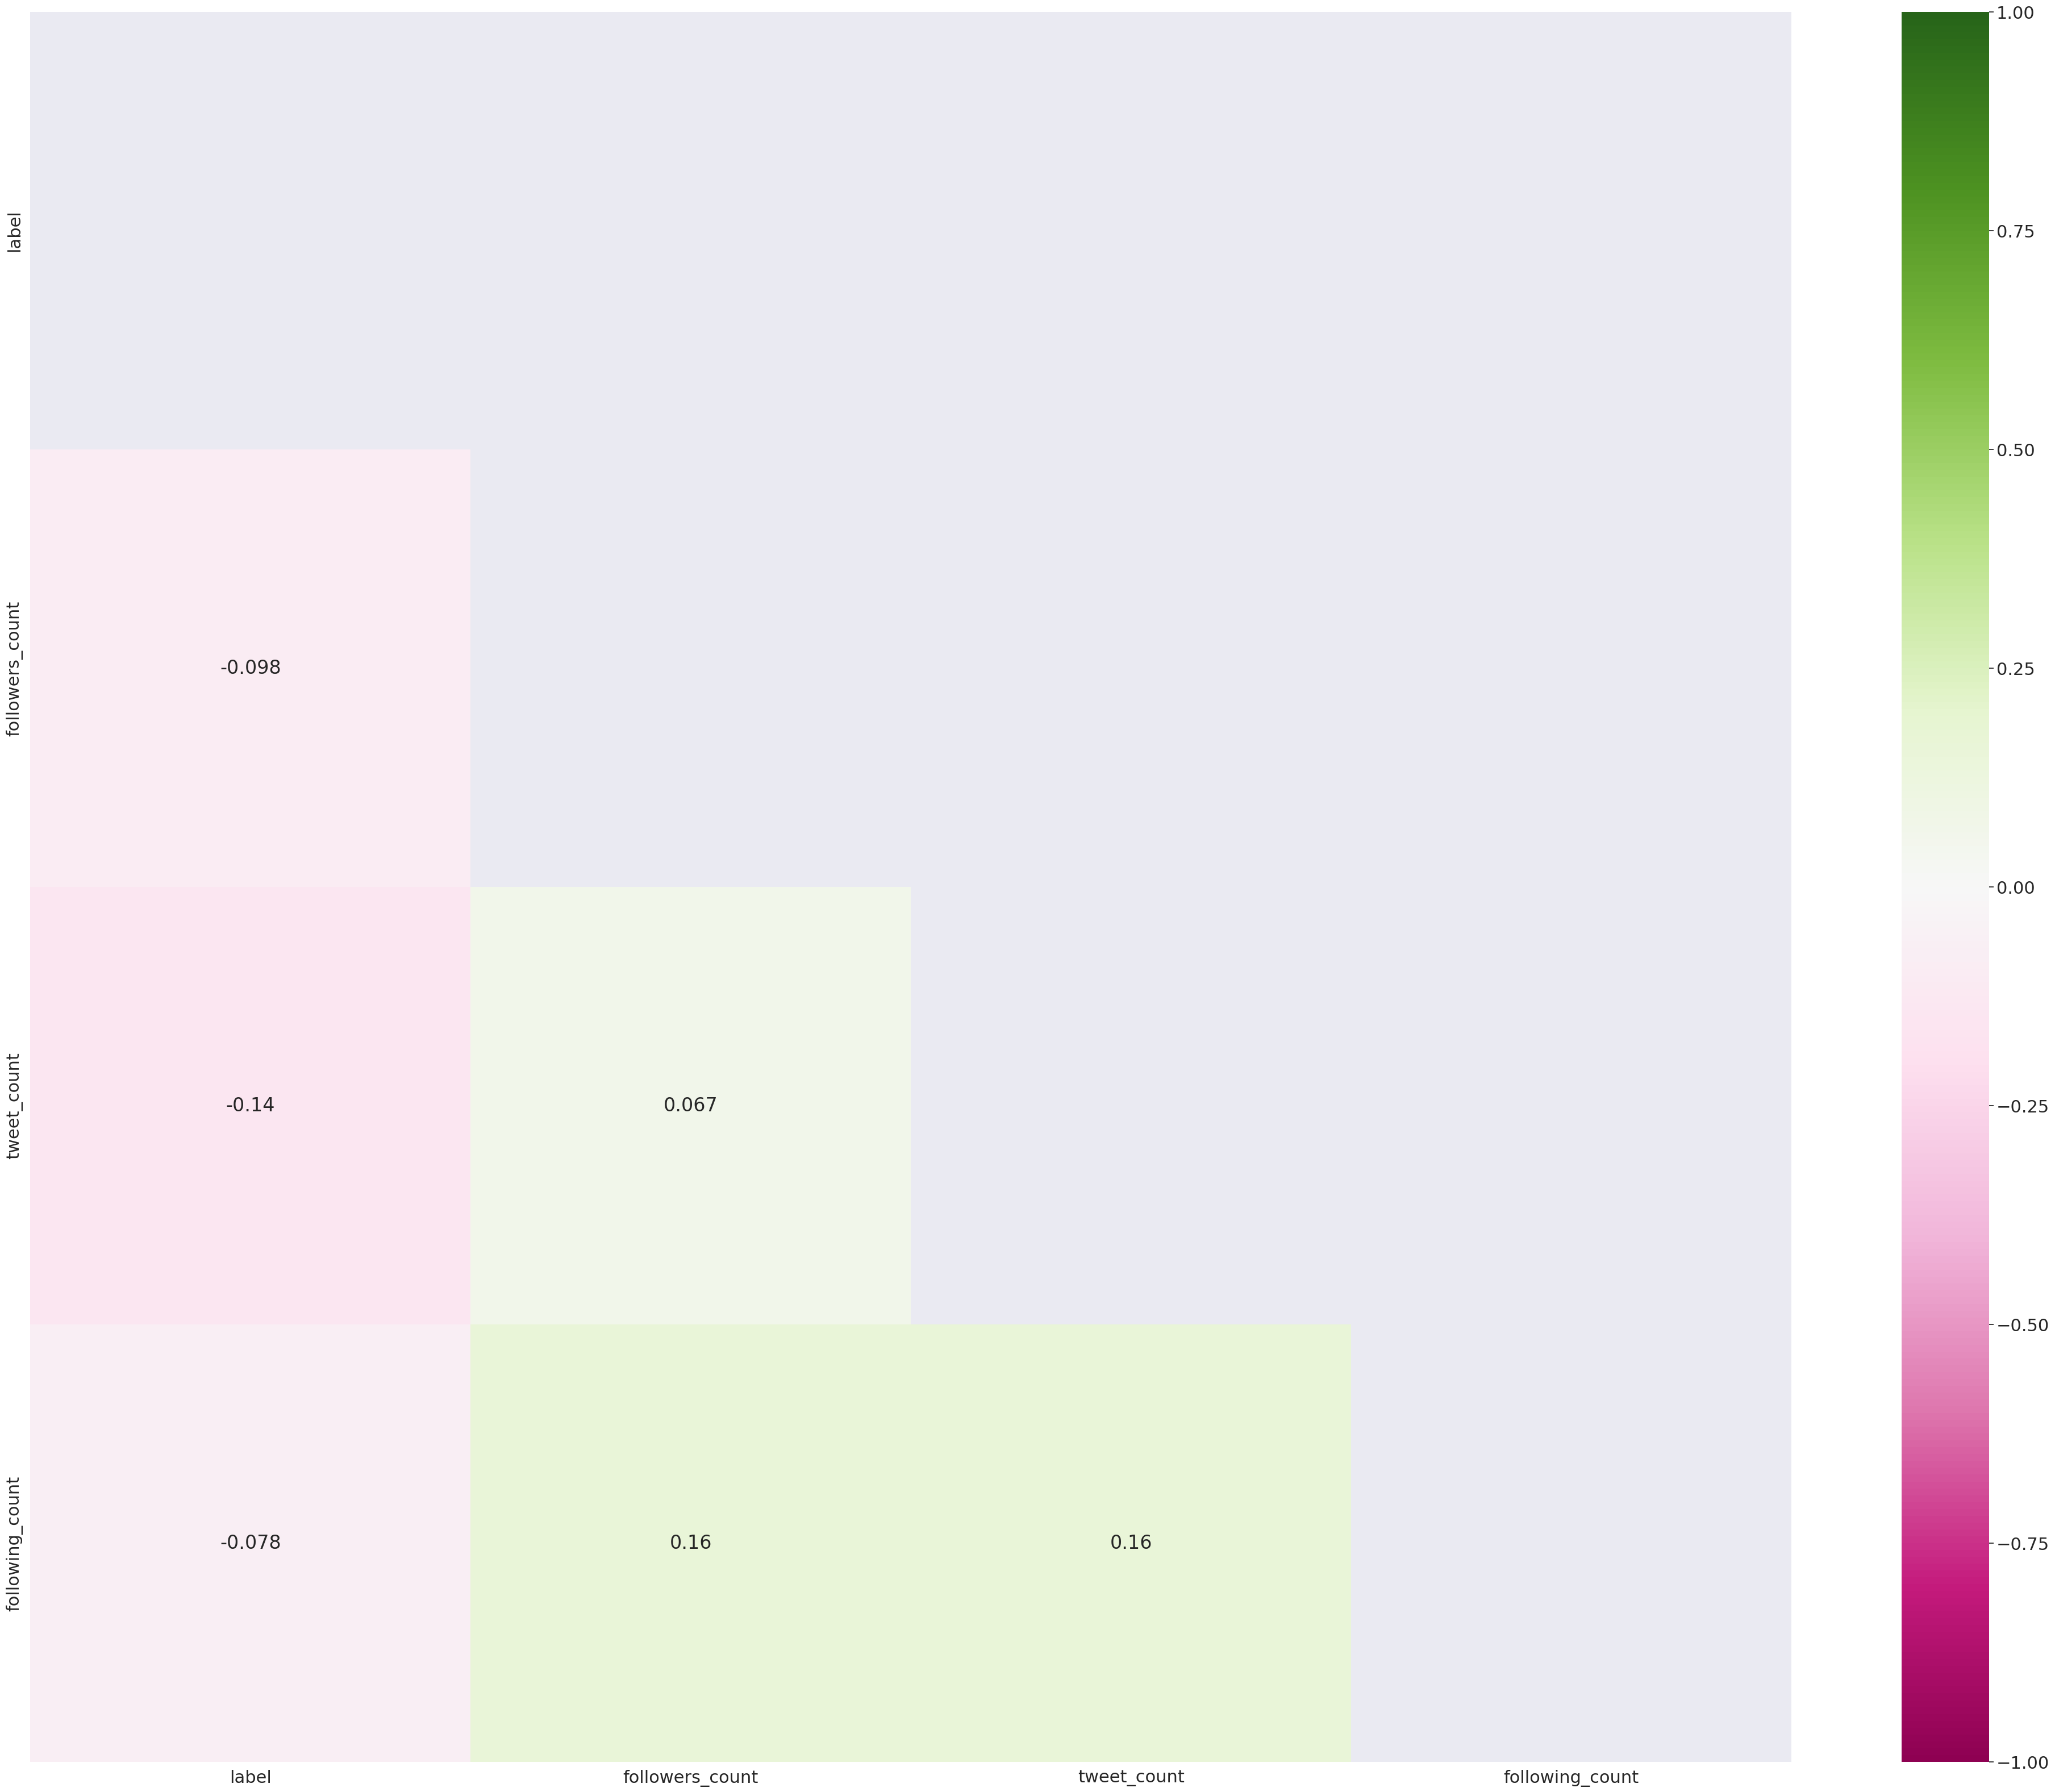

In [36]:
corr_threshold = 0.5
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [37]:
sns.set(font_scale=1)

In [38]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 0


[]

#### Split data for input and output

In [40]:
train_X = train_data.drop(['label'], axis=1)
train_Y = pd.concat([train_data['label']], axis=1)
val_X = val_data.drop(['label'], axis=1)
val_Y = pd.concat([val_data['label']], axis=1)
test_X = test_data.drop(['label'], axis=1)
test_Y = pd.concat([test_data['label']], axis=1)

# DNN models

#### Function to load a saved neural network model

In [41]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [42]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [43]:
def create_confusion_matrix(test_Y, out_Y):
  cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

  group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  plt.figure()
  fig = plt.figure(figsize=(7,7))
  ax = fig.add_subplot(111)

  sns.heatmap(
      cm,
      annot=labels,
      annot_kws={"size": 16},
      fmt='',
      cmap=plt.cm.Blues,
      cbar=False
  )
  ax.set_title("Confusion matrix", fontsize=20)
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
  ax.set_ylabel('True', fontsize=16)
  ax.set_xlabel('Predicted', fontsize=16)

  fig.show()

## Neural network models 

In [44]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=50,
                           restore_best_weights=True,
                           mode='max')
# PlotLosses
plot_losses = PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [45]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses,
                           early_stop,
                           checkpoint_callback(model_name)])
    return model

## Model 1.

#### Create model

In [46]:
def create_model_1(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

2023-08-18 16:22:08.920615: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:22:08.920672: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-18 16:22:08.920707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f97fff3adc1c): /proc/driver/nvidia/version does not exist
2023-08-18 16:22:08.923715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

In [47]:
shape = (train_X.shape[1],)
model = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 6

### batch_size=50, epochs=200

#### Train model

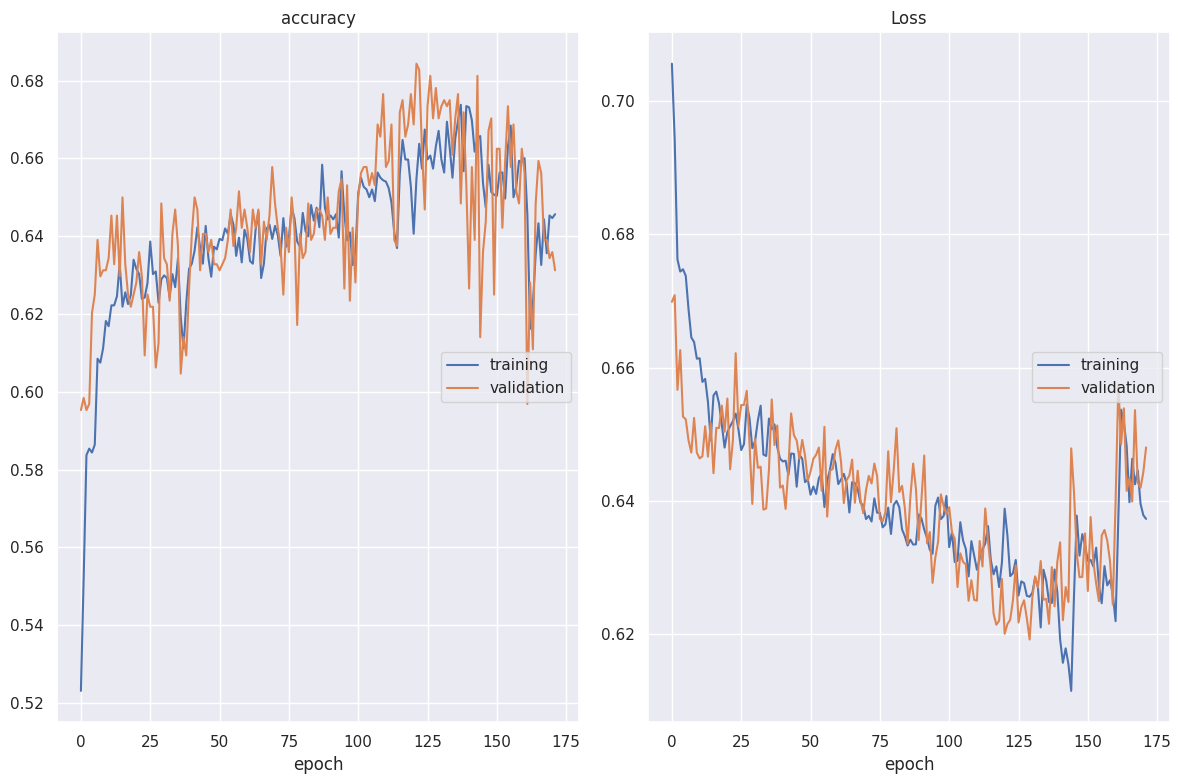

accuracy
	training         	 (min:    0.523, max:    0.674, cur:    0.646)
	validation       	 (min:    0.595, max:    0.684, cur:    0.631)
Loss
	training         	 (min:    0.612, max:    0.706, cur:    0.637)
	validation       	 (min:    0.619, max:    0.671, cur:    0.648)

Epoch 172: val_accuracy did not improve from 0.68437
60/60 [==============================] - 1s 15ms/step - loss: 0.6373 - accuracy: 0.6457 - val_loss: 0.6480 - val_accuracy: 0.6313


In [48]:
model_name = 'model_users_only_1000_important_features_v1'
model = train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size=50, epochs=200)

In [49]:
# Load model
# model = load_model_from_file(models_path + '/model_name.hdf5')

### Prediction

In [50]:
out_Y_org = model.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

#### Results

(0.0, 1.0)

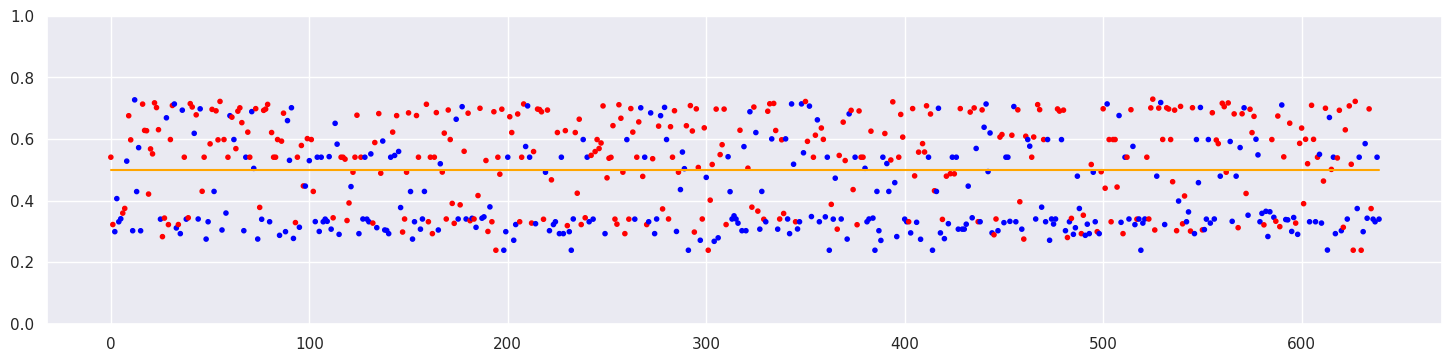

In [51]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

## Confusion matrix

Accuracy: 0.6640625
Precision: [0.64285714 0.68553459]
Recall: 0.6546546546546547
F1 score: 0.669739
ROC AUC: 0.664461


(0.6640625,
 array([0.64285714, 0.68553459]),
 0.6546546546546547,
 0.6697388632872503,
 0.6644608778159268)

<Figure size 640x480 with 0 Axes>

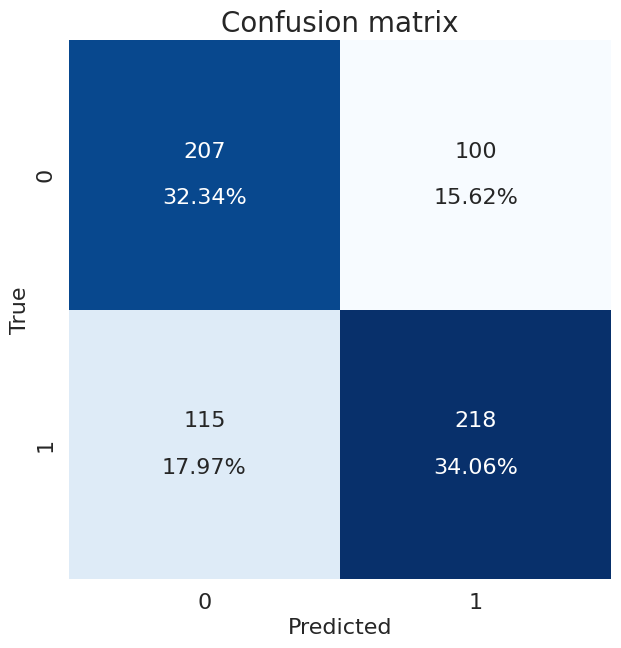

In [52]:
create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

Accuracy: 0.6640625

Precision: [0.64285714 0.68553459]

Recall: 0.6546546546546547

F1 score: 0.669739

ROC AUC: 0.664461

### Grid search for finding the most optimal set of parameters

In [58]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [59]:
model_wrapper = KerasClassifier(model=create_model_1(shape=(train_X.shape[1],)))
# model_wrapper.get_params().keys()

early_stop_sg = EarlyStopping(monitor='accuracy',
                           patience=50,
                           restore_best_weights=True,
                           mode='max')

parameters = {
    'optimizer' : [tf.keras.optimizers.Adam(learning_rate=0.0001), tf.keras.optimizers.Adam(learning_rate=0.001), tf.keras.optimizers.Adam(learning_rate=0.01)],
    'batch_size' : [10, 20, 40, 60, 80, 100, 150, 200, 250],
    'epochs' : [10, 50, 100],
    'callbacks' : [early_stop_sg]}


dnn_model_grid = GridSearchCV(estimator=model_wrapper,
                        param_grid=parameters,
                        scoring='accuracy',
                        cv=5,
                        n_jobs=10,
                        verbose=0)


dnn_model_grid.fit(train_X, train_Y)

INFO:tensorflow:Assets written to: ram://d02bea25431e48cc81c7cc3801f056f8/assets


INFO:tensorflow:Assets written to: ram://d02bea25431e48cc81c7cc3801f056f8/assets
2023-08-18 16:29:31.023615: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c585335685574570b01bdf1b4e68b2e5: INVALID_ARGUMENT: ram://c585335685574570b01bdf1b4e68b2e5 is a directory.


INFO:tensorflow:Assets written to: ram://3a2bb30c046f43e39a42e336e4fc4fd4/assets


INFO:tensorflow:Assets written to: ram://3a2bb30c046f43e39a42e336e4fc4fd4/assets
2023-08-18 16:29:33.384951: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0d88ea5f853846eca18fc86aa12cc2f8: INVALID_ARGUMENT: ram://0d88ea5f853846eca18fc86aa12cc2f8 is a directory.


INFO:tensorflow:Assets written to: ram://a5c5bd41e17a40a8a097ed3fdbaa49b5/assets


INFO:tensorflow:Assets written to: ram://a5c5bd41e17a40a8a097ed3fdbaa49b5/assets
2023-08-18 16:29:35.185298: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f4667fed29ac423ea4bb528a6f812176: INVALID_ARGUMENT: ram://f4667fed29ac423ea4bb528a6f812176 is a directory.


INFO:tensorflow:Assets written to: ram://f81cf4744e70401c9b7c4dfa7a49a726/assets


INFO:tensorflow:Assets written to: ram://f81cf4744e70401c9b7c4dfa7a49a726/assets
2023-08-18 16:29:36.990217: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b206470e190c47619d6b800f578e06c6: INVALID_ARGUMENT: ram://b206470e190c47619d6b800f578e06c6 is a directory.


INFO:tensorflow:Assets written to: ram://1faa70afdb704f4b885f1a2fe37b4b15/assets


INFO:tensorflow:Assets written to: ram://1faa70afdb704f4b885f1a2fe37b4b15/assets
2023-08-18 16:29:38.823542: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fb9e2e34bbeb480695d5d6efe45004d0: INVALID_ARGUMENT: ram://fb9e2e34bbeb480695d5d6efe45004d0 is a directory.


INFO:tensorflow:Assets written to: ram://384f7a8c96854aaa9c381e8cf13570a5/assets


INFO:tensorflow:Assets written to: ram://384f7a8c96854aaa9c381e8cf13570a5/assets
2023-08-18 16:29:41.054130: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://de94c455553349fab6f9d20c63079f34: INVALID_ARGUMENT: ram://de94c455553349fab6f9d20c63079f34 is a directory.


INFO:tensorflow:Assets written to: ram://22dcb723b7da43f589af409e6b8a0a1d/assets


INFO:tensorflow:Assets written to: ram://22dcb723b7da43f589af409e6b8a0a1d/assets
2023-08-18 16:29:42.872742: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://618a840d17114c49880909151be0e644: INVALID_ARGUMENT: ram://618a840d17114c49880909151be0e644 is a directory.


INFO:tensorflow:Assets written to: ram://e55a952f24bc42dd8a34595b5134f6e1/assets


INFO:tensorflow:Assets written to: ram://e55a952f24bc42dd8a34595b5134f6e1/assets
2023-08-18 16:29:44.729486: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a0b0378b37d2470dbcd370ddf57130a6: INVALID_ARGUMENT: ram://a0b0378b37d2470dbcd370ddf57130a6 is a directory.


INFO:tensorflow:Assets written to: ram://b5321941dca74b3e81ea9665eacf75b8/assets


INFO:tensorflow:Assets written to: ram://b5321941dca74b3e81ea9665eacf75b8/assets
2023-08-18 16:29:46.577084: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://52b8b65637984a198f190165dacf4207: INVALID_ARGUMENT: ram://52b8b65637984a198f190165dacf4207 is a directory.


INFO:tensorflow:Assets written to: ram://018d4f3e731d4edcaf0c660cf54c5368/assets


INFO:tensorflow:Assets written to: ram://018d4f3e731d4edcaf0c660cf54c5368/assets
2023-08-18 16:29:48.918762: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://db9d6984f8c2446596be0766b4771f7d: INVALID_ARGUMENT: ram://db9d6984f8c2446596be0766b4771f7d is a directory.


INFO:tensorflow:Assets written to: ram://184dd0b33afa4371b600a527334fee73/assets


INFO:tensorflow:Assets written to: ram://184dd0b33afa4371b600a527334fee73/assets
2023-08-18 16:29:50.761826: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8ed0dba3c3cc4f81b8c717718ebf9a65: INVALID_ARGUMENT: ram://8ed0dba3c3cc4f81b8c717718ebf9a65 is a directory.


INFO:tensorflow:Assets written to: ram://f4a4a110240f41ea9bb2ca35bb52702e/assets


INFO:tensorflow:Assets written to: ram://f4a4a110240f41ea9bb2ca35bb52702e/assets


INFO:tensorflow:Assets written to: ram://ec428af23c5c4e06bcaf2b1e34f80168/assets


INFO:tensorflow:Assets written to: ram://ec428af23c5c4e06bcaf2b1e34f80168/assets
2023-08-18 16:29:55.823961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 16:29:55.932806: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://33dac0212a3048c5966e389b5075308c: INVALID_ARGUMENT: ram://33dac0212a3048c5966e389b5075308c is a directory.


INFO:tensorflow:Assets written to: ram://88278fa7d085490886e9952506e84352/assets


INFO:tensorflow:Assets written to: ram://88278fa7d085490886e9952506e84352/assets
2023-08-18 16:29:57.492990: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:29:57.493141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:29:57.493157: W tensorflow/compiler/tf2tensor

Epoch 1/10
INFO:tensorflow:Assets written to: ram://d2fb9718543b4560871af88be40d6810/assets


INFO:tensorflow:Assets written to: ram://d2fb9718543b4560871af88be40d6810/assets
2023-08-18 16:30:00.572532: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:00.572774: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:00.572798: W tensorflow/compiler/tf2tensor

 58/239 [======>.......................] - ETA: 0s - loss: 0.7068 - accuracy: 0.5397INFO:tensorflow:Assets written to: ram://d990bdd9d1ba454aa1a8238d0cd9f4a0/assets


INFO:tensorflow:Assets written to: ram://d990bdd9d1ba454aa1a8238d0cd9f4a0/assets


239/239 [==============================] - 2s 3ms/step - loss: 0.7075 - accuracy: 0.5310
Epoch 2/10
123/239 [==============>...............] - ETA: 0s - loss: 0.6831 - accuracy: 0.5797

2023-08-18 16:30:01.926449: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7841226af288497c83fdfe4ac12155a3: INVALID_ARGUMENT: ram://7841226af288497c83fdfe4ac12155a3 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6839 - accuracy: 0.5817
Epoch 3/10
121/239 [==============>...............] - ETA: 0s - loss: 0.6752 - accuracy: 0.5959

2023-08-18 16:30:02.490742: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:02.490797: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-18 16:30:02.490855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f97fff3adc1c): /proc/driver/nvidia/version does not exist
2023-08-18 16:30:02.491246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

216/239 [==========================>...] - ETA: 0s - loss: 0.6704 - accuracy: 0.6046

2023-08-18 16:30:02.939640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


239/239 [==============================] - 1s 3ms/step - loss: 0.6699 - accuracy: 0.6039
Epoch 4/10
208/239 [=========================>....] - ETA: 0s - loss: 0.6817 - accuracy: 0.5962

2023-08-18 16:30:03.533714: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://95388743a5b6470194a4081b34aa84f8: INVALID_ARGUMENT: ram://95388743a5b6470194a4081b34aa84f8 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6771 - accuracy: 0.6043
Epoch 5/10
 97/239 [===========>..................] - ETA: 0s - loss: 0.6854 - accuracy: 0.5907

239/239 [==============================] - 1s 3ms/step - loss: 0.6674 - accuracy: 0.6097
Epoch 6/10
167/239 [===================>..........] - ETA: 0s - loss: 0.6584 - accuracy: 0.6066

239/239 [==============================] - 1s 3ms/step - loss: 0.6631 - accuracy: 0.6047
Epoch 7/10
  1/239 [..............................] - ETA: 0s - loss: 0.7621 - accuracy: 0.4000

2023-08-18 16:30:05.182355: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:05.182577: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:05.182595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

181/239 [=====================>........] - ETA: 0s - loss: 0.6559 - accuracy: 0.6276INFO:tensorflow:Assets written to: ram://890a5f08e16a430db732aac21f2e950e/assets


INFO:tensorflow:Assets written to: ram://890a5f08e16a430db732aac21f2e950e/assets


239/239 [==============================] - 2s 3ms/step - loss: 0.6957 - accuracy: 0.5500
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6605 - accuracy: 0.6156
Epoch 8/10
226/239 [===========================>..] - ETA: 0s - loss: 0.6889 - accuracy: 0.5695INFO:tensorflow:Assets written to: ram://f2bef3c193f44853a8a380ce69d7468d/assets


INFO:tensorflow:Assets written to: ram://f2bef3c193f44853a8a380ce69d7468d/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6872 - accuracy: 0.5739
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6801 - accuracy: 0.5789
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6608 - accuracy: 0.6164
Epoch 10/10
 37/239 [===>..........................] - ETA: 0s - loss: 0.6608 - accuracy: 0.6081

2023-08-18 16:30:07.291076: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:07.291151: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-18 16:30:07.291191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f97fff3adc1c): /proc/driver/nvidia/version does not exist
2023-08-18 16:30:07.291574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

166/239 [===================>..........] - ETA: 0s - loss: 0.6616 - accuracy: 0.6072

2023-08-18 16:30:07.643911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


239/239 [==============================] - 1s 3ms/step - loss: 0.6652 - accuracy: 0.5931
Epoch 5/10
167/239 [===================>..........] - ETA: 0s - loss: 0.6655 - accuracy: 0.6066

2023-08-18 16:30:08.337958: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0f5fb665f88940b5a6abf36b5df53c85: INVALID_ARGUMENT: ram://0f5fb665f88940b5a6abf36b5df53c85 is a directory.
2023-08-18 16:30:08.453820: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://567e240f3591473095566caafc25a8fb: INVALID_ARGUMENT: ram://567e240f3591473095566caafc25a8fb is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6645 - accuracy: 0.6032
Epoch 6/10
 97/239 [===========>..................] - ETA: 0s - loss: 0.6539 - accuracy: 0.6175

239/239 [==============================] - 1s 3ms/step - loss: 0.6610 - accuracy: 0.6195
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6626 - accuracy: 0.6107
Epoch 8/10
 17/239 [=>............................] - ETA: 0s - loss: 0.6469 - accuracy: 0.6294

2023-08-18 16:30:09.900908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:09.901158: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:09.901182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

 99/239 [===========>..................] - ETA: 0s - loss: 0.6662 - accuracy: 0.6081INFO:tensorflow:Assets written to: ram://145a52e866bc4e7ba7610708b1eb42ca/assets


INFO:tensorflow:Assets written to: ram://145a52e866bc4e7ba7610708b1eb42ca/assets


239/239 [==============================] - 2s 3ms/step - loss: 0.7002 - accuracy: 0.5391
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6602 - accuracy: 0.6078
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6851 - accuracy: 0.5806
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6565 - accuracy: 0.6153
Epoch 10/10
 44/239 [====>.........................] - ETA: 0s - loss: 0.6304 - accuracy: 0.6773

167/239 [===================>..........] - ETA: 0s - loss: 0.6878 - accuracy: 0.5509

136/239 [================>.............] - ETA: 0s - loss: 0.6539 - accuracy: 0.6353

2023-08-18 16:30:12.033949: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:12.034019: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-18 16:30:12.034057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f97fff3adc1c): /proc/driver/nvidia/version does not exist
2023-08-18 16:30:12.034441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

239/239 [==============================] - 1s 3ms/step - loss: 0.6802 - accuracy: 0.5705
Epoch 4/10
116/239 [=============>................] - ETA: 0s - loss: 0.6719 - accuracy: 0.5879

2023-08-18 16:30:12.369190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


239/239 [==============================] - 1s 3ms/step - loss: 0.6724 - accuracy: 0.5881
Epoch 5/10
149/239 [=================>............] - ETA: 0s - loss: 0.6582 - accuracy: 0.6235

2023-08-18 16:30:13.071429: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5ad1a98082394beeb3506738c39cd18d: INVALID_ARGUMENT: ram://5ad1a98082394beeb3506738c39cd18d is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6627 - accuracy: 0.6082
Epoch 6/10
  1/239 [..............................] - ETA: 0s - loss: 0.5885 - accuracy: 0.7000INFO:tensorflow:Assets written to: ram://996590858bca4ae9a7a83ddf3f1cd27d/assets


INFO:tensorflow:Assets written to: ram://996590858bca4ae9a7a83ddf3f1cd27d/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6580 - accuracy: 0.6178
Epoch 7/10
175/239 [====================>.........] - ETA: 0s - loss: 0.6602 - accuracy: 0.6177

2023-08-18 16:30:14.601240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:14.601522: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:14.601546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

239/239 [==============================] - 1s 3ms/step - loss: 0.6598 - accuracy: 0.6157
Epoch 8/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7061 - accuracy: 0.5350
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6574 - accuracy: 0.6187
Epoch 9/10
168/239 [====================>.........] - ETA: 0s - loss: 0.6920 - accuracy: 0.5667

2023-08-18 16:30:15.620206: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f9588b08ff6f44799b09c27e1293d4ab: INVALID_ARGUMENT: ram://f9588b08ff6f44799b09c27e1293d4ab is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6867 - accuracy: 0.5710
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6571 - accuracy: 0.6195
Epoch 10/10
 37/239 [===>..........................] - ETA: 0s - loss: 0.6610 - accuracy: 0.6216INFO:tensorflow:Assets written to: ram://8fd1dd4ee1d84c1bac03e278d8fbf3e2/assets


INFO:tensorflow:Assets written to: ram://8fd1dd4ee1d84c1bac03e278d8fbf3e2/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6796 - accuracy: 0.5894
Epoch 4/10
 70/239 [=======>......................] - ETA: 0s - loss: 0.6709 - accuracy: 0.6071

2023-08-18 16:30:16.637917: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:16.637982: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-18 16:30:16.638038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f97fff3adc1c): /proc/driver/nvidia/version does not exist
2023-08-18 16:30:16.638491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

239/239 [==============================] - 1s 3ms/step - loss: 0.6719 - accuracy: 0.6007
Epoch 5/10
145/239 [=================>............] - ETA: 0s - loss: 0.6531 - accuracy: 0.6241

2023-08-18 16:30:17.647697: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e18a38f7be6845ffae977ec2dac87474: INVALID_ARGUMENT: ram://e18a38f7be6845ffae977ec2dac87474 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6630 - accuracy: 0.6107
Epoch 6/10
 79/239 [========>.....................] - ETA: 0s - loss: 0.6652 - accuracy: 0.5987

2023-08-18 16:30:18.101921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


157/239 [==================>...........] - ETA: 0s - loss: 0.6613 - accuracy: 0.6013

239/239 [==============================] - 1s 3ms/step - loss: 0.6627 - accuracy: 0.6057
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6611 - accuracy: 0.6195
Epoch 8/10
100/239 [===========>..................] - ETA: 0s - loss: 0.7174 - accuracy: 0.5120

239/239 [==============================] - 2s 3ms/step - loss: 0.7082 - accuracy: 0.5266
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6589 - accuracy: 0.6199
Epoch 9/10
 50/239 [=====>........................] - ETA: 0s - loss: 0.6553 - accuracy: 0.6480INFO:tensorflow:Assets written to: ram://00b51bf1c60b48889f28250b0aa7fc1b/assets


INFO:tensorflow:Assets written to: ram://00b51bf1c60b48889f28250b0aa7fc1b/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6947 - accuracy: 0.5647
Epoch 3/10
 39/239 [===>..........................] - ETA: 0s - loss: 0.6760 - accuracy: 0.5718

2023-08-18 16:30:20.311680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:20.311934: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:20.311960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

239/239 [==============================] - 1s 3ms/step - loss: 0.6585 - accuracy: 0.6170
Epoch 10/10
 52/239 [=====>........................] - ETA: 0s - loss: 0.6469 - accuracy: 0.6154INFO:tensorflow:Assets written to: ram://ab2c8d400a2e4a10aee04d0b030dd523/assets


INFO:tensorflow:Assets written to: ram://ab2c8d400a2e4a10aee04d0b030dd523/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6790 - accuracy: 0.5793
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6753 - accuracy: 0.5881
Epoch 5/10
143/239 [================>.............] - ETA: 0s - loss: 0.6714 - accuracy: 0.5895

2023-08-18 16:30:22.025991: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fc1c8846334240deaedd1d2eefd7d37e: INVALID_ARGUMENT: ram://fc1c8846334240deaedd1d2eefd7d37e is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6741 - accuracy: 0.5940
Epoch 6/10
 56/239 [======>.......................] - ETA: 0s - loss: 0.6678 - accuracy: 0.5929

2023-08-18 16:30:22.358033: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:22.358096: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-18 16:30:22.358140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f97fff3adc1c): /proc/driver/nvidia/version does not exist
2023-08-18 16:30:22.358540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

239/239 [==============================] - 1s 3ms/step - loss: 0.6634 - accuracy: 0.6049
Epoch 7/10
162/239 [===================>..........] - ETA: 0s - loss: 0.6605 - accuracy: 0.6154

2023-08-18 16:30:23.328526: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7a28f0a714c547be823052572f10de64: INVALID_ARGUMENT: ram://7a28f0a714c547be823052572f10de64 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6664 - accuracy: 0.6086
Epoch 8/10
  1/239 [..............................] - ETA: 0s - loss: 0.6017 - accuracy: 0.7000

239/239 [==============================] - 1s 3ms/step - loss: 0.6592 - accuracy: 0.6183
Epoch 9/10
 49/239 [=====>........................] - ETA: 0s - loss: 0.7203 - accuracy: 0.4816

2023-08-18 16:30:24.649663: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:24.649938: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:24.649966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

237/239 [============================>.] - ETA: 0s - loss: 0.6661 - accuracy: 0.6068INFO:tensorflow:Assets written to: ram://779a5192b7f74e07b92120aa8d7beac4/assets


INFO:tensorflow:Assets written to: ram://779a5192b7f74e07b92120aa8d7beac4/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6664 - accuracy: 0.6061
Epoch 10/10
26/60 [============>.................] - ETA: 0s s - loss: 0.6535 - accuracy: 0.500

239/239 [==============================] - 2s 3ms/step - loss: 0.7048 - accuracy: 0.5327
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6643 - accuracy: 0.6019


239/239 [==============================] - 1s 3ms/step - loss: 0.6847 - accuracy: 0.5787
Epoch 3/10
141/239 [================>.............] - ETA: 0s - loss: 0.6784 - accuracy: 0.5745INFO:tensorflow:Assets written to: ram://8a22833f43b44f8ea85a3577f246f2a5/assets


INFO:tensorflow:Assets written to: ram://8a22833f43b44f8ea85a3577f246f2a5/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6774 - accuracy: 0.5829
Epoch 4/10
 22/239 [=>............................] - ETA: 0s - loss: 0.7069 - accuracy: 0.5409

2023-08-18 16:30:26.645560: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:26.645613: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-18 16:30:26.645640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f97fff3adc1c): /proc/driver/nvidia/version does not exist
2023-08-18 16:30:26.645894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

239/239 [==============================] - 1s 3ms/step - loss: 0.6761 - accuracy: 0.5712
Epoch 5/10
157/239 [==================>...........] - ETA: 0s - loss: 0.6786 - accuracy: 0.5803

2023-08-18 16:30:27.657764: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1ed947c1f06c4f3eae94b0bdf1744648: INVALID_ARGUMENT: ram://1ed947c1f06c4f3eae94b0bdf1744648 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6738 - accuracy: 0.5984
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6675 - accuracy: 0.5967
Epoch 7/10
  1/239 [..............................] - ETA: 0s - loss: 0.7395 - accuracy: 0.5000

2023-08-18 16:30:28.454645: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fc0e1dcef5f04ddbb99d2a54a79f72e7: INVALID_ARGUMENT: ram://fc0e1dcef5f04ddbb99d2a54a79f72e7 is a directory.


183/239 [=====================>........] - ETA: 0s - loss: 0.6572 - accuracy: 0.6044

2023-08-18 16:30:28.984191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:28.984439: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:28.984463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

239/239 [==============================] - 1s 3ms/step - loss: 0.6638 - accuracy: 0.5980
Epoch 8/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7100 - accuracy: 0.5379
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6603 - accuracy: 0.6152
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6735 - accuracy: 0.5848
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6588 - accuracy: 0.6135
Epoch 10/10
 93/239 [==========>...................] - ETA: 0s - loss: 0.6713 - accuracy: 0.5989INFO:tensorflow:Assets written to: ram://7cb7e32472fe44e092554aaed1d37ede/assets


INFO:tensorflow:Assets written to: ram://7cb7e32472fe44e092554aaed1d37ede/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6788 - accuracy: 0.5848
Epoch 4/10
173/239 [====================>.........] - ETA: 0s - loss: 0.6553 - accuracy: 0.6168

2023-08-18 16:30:31.030734: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:31.030783: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-18 16:30:31.030814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f97fff3adc1c): /proc/driver/nvidia/version does not exist
2023-08-18 16:30:31.031111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

28/60 [=============>................] - ETA: 0s s - loss: 0.6717 - accuracy: 0.6054

239/239 [==============================] - 1s 3ms/step - loss: 0.6706 - accuracy: 0.6061
Epoch 5/10
 41/239 [====>.........................] - ETA: 0s - loss: 0.6627 - accuracy: 0.6000

120/239 [==============>...............] - ETA: 0s - loss: 0.6709 - accuracy: 0.5950

2023-08-18 16:30:32.072634: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://24b1d68778704bbdb39de4723b5e511b: INVALID_ARGUMENT: ram://24b1d68778704bbdb39de4723b5e511b is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6667 - accuracy: 0.6049
Epoch 6/10
 67/239 [=======>......................] - ETA: 0s - loss: 0.6628 - accuracy: 0.5925

2023-08-18 16:30:32.518535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


239/239 [==============================] - 1s 2ms/step - loss: 0.6636 - accuracy: 0.6099
Epoch 7/10
  1/239 [..............................] - ETA: 0s - loss: 0.6866 - accuracy: 0.6000INFO:tensorflow:Assets written to: ram://40c4b1eaf468419a929946455224c408/assets


INFO:tensorflow:Assets written to: ram://40c4b1eaf468419a929946455224c408/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6586 - accuracy: 0.6153
Epoch 8/10
 46/239 [====>.........................] - ETA: 0s - loss: 0.7246 - accuracy: 0.4761

239/239 [==============================] - 2s 3ms/step - loss: 0.7095 - accuracy: 0.5295
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6575 - accuracy: 0.6291
Epoch 9/10
229/239 [===========================>..] - ETA: 0s - loss: 0.6869 - accuracy: 0.5729

2023-08-18 16:30:34.790239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:34.790529: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:34.790556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

239/239 [==============================] - 1s 3ms/step - loss: 0.6865 - accuracy: 0.5751
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6547 - accuracy: 0.6178
Epoch 10/10
 93/239 [==========>...................] - ETA: 0s - loss: 0.6606 - accuracy: 0.6140INFO:tensorflow:Assets written to: ram://41ec7dbce728466f86eace2822ec05e5/assets


2023-08-18 16:30:35.086301: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3507c07be07a4471a69eeb1edce36830: INVALID_ARGUMENT: ram://3507c07be07a4471a69eeb1edce36830 is a directory.
INFO:tensorflow:Assets written to: ram://41ec7dbce728466f86eace2822ec05e5/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6783 - accuracy: 0.5781
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6696 - accuracy: 0.5961
Epoch 5/10
 62/239 [======>.......................] - ETA: 0s - loss: 0.6418 - accuracy: 0.6371

144/239 [=================>............] - ETA: 0s - loss: 0.6482 - accuracy: 0.6278

2023-08-18 16:30:36.707194: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:36.707249: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-18 16:30:36.707280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f97fff3adc1c): /proc/driver/nvidia/version does not exist
2023-08-18 16:30:36.707599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

239/239 [==============================] - 1s 3ms/step - loss: 0.6606 - accuracy: 0.6086
Epoch 6/10
126/239 [==============>...............] - ETA: 0s - loss: 0.6641 - accuracy: 0.5960

2023-08-18 16:30:37.035856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:tensorflow:Assets written to: ram://b1330353dde04994af237b2b07a455f8/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6656 - accuracy: 0.6011
Epoch 7/10
143/239 [================>.............] - ETA: 0s - loss: 0.6597 - accuracy: 0.6273

2023-08-18 16:30:37.661522: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b5801bcc0b4646aca5bb02dcc4b57c68: INVALID_ARGUMENT: ram://b5801bcc0b4646aca5bb02dcc4b57c68 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6608 - accuracy: 0.6291
Epoch 8/10
 20/239 [=>............................] - ETA: 0s - loss: 0.6672 - accuracy: 0.5950

2023-08-18 16:30:37.914115: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://12462a7b684e400ba0fca0bd0c4b078f: INVALID_ARGUMENT: ram://12462a7b684e400ba0fca0bd0c4b078f is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6533 - accuracy: 0.6224
Epoch 9/10
 18/239 [=>............................] - ETA: 0s - loss: 0.7069 - accuracy: 0.5222  

 87/239 [=========>....................] - ETA: 0s - loss: 0.7174 - accuracy: 0.5115

2023-08-18 16:30:39.191884: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:39.192192: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:39.192220: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

239/239 [==============================] - 1s 3ms/step - loss: 0.6542 - accuracy: 0.6266
Epoch 10/10
239/239 [==============================] - 2s 3ms/step - loss: 0.6999 - accuracy: 0.5458
Epoch 2/10
 20/239 [=>............................] - ETA: 0s - loss: 0.6915 - accuracy: 0.5550INFO:tensorflow:Assets written to: ram://2261663ff4364650b2aebaaade0e1709/assets


INFO:tensorflow:Assets written to: ram://2261663ff4364650b2aebaaade0e1709/assets


197/239 [=======================>......] - ETA: 0s - loss: 0.6553 - accuracy: 0.6305

239/239 [==============================] - 1s 3ms/step - loss: 0.6868 - accuracy: 0.5697
Epoch 3/10
156/239 [==================>...........] - ETA: 0s - loss: 0.6879 - accuracy: 0.5744

2023-08-18 16:30:40.560518: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://66761d0f2e284d5c8b7fb85c769e5d8a: INVALID_ARGUMENT: ram://66761d0f2e284d5c8b7fb85c769e5d8a is a directory.


239/239 [==============================] - 1s 2ms/step - loss: 0.6827 - accuracy: 0.5797
Epoch 4/10
149/239 [=================>............] - ETA: 0s - loss: 0.6854 - accuracy: 0.5919

2023-08-18 16:30:41.110254: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-18 16:30:41.110318: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-18 16:30:41.110355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f97fff3adc1c): /proc/driver/nvidia/version does not exist
2023-08-18 16:30:41.110721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

239/239 [==============================] - 1s 2ms/step - loss: 0.6852 - accuracy: 0.5776
Epoch 5/10
 68/239 [=======>......................] - ETA: 0s - loss: 0.6491 - accuracy: 0.6250

239/239 [==============================] - 1s 2ms/step - loss: 0.6695 - accuracy: 0.5961
Epoch 6/10
 91/239 [==========>...................] - ETA: 0s - loss: 0.6845 - accuracy: 0.5934INFO:tensorflow:Assets written to: ram://1320967a5ae8408baaf5bebbcfc99b44/assets


2023-08-18 16:30:42.031082: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d7c9c17270c3458596cb30b064e9bdfa: INVALID_ARGUMENT: ram://d7c9c17270c3458596cb30b064e9bdfa is a directory.
INFO:tensorflow:Assets written to: ram://1320967a5ae8408baaf5bebbcfc99b44/assets


Epoch 1/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6691 - accuracy: 0.6069
Epoch 7/10
188/239 [======================>.......] - ETA: 0s - loss: 0.6685 - accuracy: 0.5910

2023-08-18 16:30:42.962032: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7708f5e459ae40eea4b18873d9108894: INVALID_ARGUMENT: ram://7708f5e459ae40eea4b18873d9108894 is a directory.


239/239 [==============================] - 1s 2ms/step - loss: 0.6681 - accuracy: 0.5982
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6632 - accuracy: 0.6053
Epoch 9/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7067 - accuracy: 0.5291
Epoch 2/10
 70/239 [=======>......................] - ETA: 0s - loss: 0.6923 - accuracy: 0.5514

208/239 [=========================>....] - ETA: 0s - loss: 0.6612 - accuracy: 0.6072

239/239 [==============================] - 1s 3ms/step - loss: 0.6628 - accuracy: 0.6044
Epoch 10/10
 59/239 [======>.......................] - ETA: 0s - loss: 0.6742 - accuracy: 0.6051INFO:tensorflow:Assets written to: ram://2b03bb92ec0c4970a565b7c5f107dbf3/assets


INFO:tensorflow:Assets written to: ram://2b03bb92ec0c4970a565b7c5f107dbf3/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6839 - accuracy: 0.5776
Epoch 4/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6783 - accuracy: 0.5860
Epoch 5/10
159/239 [==================>...........] - ETA: 0s - loss: 0.6696 - accuracy: 0.6000

239/239 [==============================] - 1s 2ms/step - loss: 0.6687 - accuracy: 0.6057
Epoch 6/10
 23/239 [=>............................] - ETA: 0s - loss: 0.6596 - accuracy: 0.6435

2023-08-18 16:30:46.538583: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6309fd4f871f4b6a8ce7996abc02a0cb: INVALID_ARGUMENT: ram://6309fd4f871f4b6a8ce7996abc02a0cb is a directory.


239/239 [==============================] - 1s 2ms/step - loss: 0.6722 - accuracy: 0.6028
Epoch 7/10
159/239 [==================>...........] - ETA: 0s - loss: 0.6643 - accuracy: 0.6038

239/239 [==============================] - 1s 2ms/step - loss: 0.6643 - accuracy: 0.6019
Epoch 8/10
206/239 [========================>.....] - ETA: 0s - loss: 0.6608 - accuracy: 0.6107INFO:tensorflow:Assets written to: ram://c8051d70f6724acb9aa16b1458ccae18/assets


INFO:tensorflow:Assets written to: ram://c8051d70f6724acb9aa16b1458ccae18/assets


239/239 [==============================] - 1s 2ms/step - loss: 0.6606 - accuracy: 0.6116
Epoch 9/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6619 - accuracy: 0.6178
Epoch 10/10
 46/239 [====>.........................] - ETA: 0s - loss: 0.6577 - accuracy: 0.6130

2023-08-18 16:30:48.822239: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://369f5fce40cd48e4946521791925082b: INVALID_ARGUMENT: ram://369f5fce40cd48e4946521791925082b is a directory.


60/60 [==============================] - 0s 1ms/step


INFO:tensorflow:Assets written to: ram://3b2c949f34bc48af849df253ebee543d/assets


INFO:tensorflow:Assets written to: ram://3b2c949f34bc48af849df253ebee543d/assets
2023-08-18 16:30:50.832784: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2aa8e46007304988880f7257203235fd: INVALID_ARGUMENT: ram://2aa8e46007304988880f7257203235fd is a directory.


INFO:tensorflow:Assets written to: ram://b9020434427944b0adff390ee2749f19/assets


INFO:tensorflow:Assets written to: ram://b9020434427944b0adff390ee2749f19/assets
2023-08-18 16:30:52.713115: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://90a83cabc88d464390252aaa3112d006: INVALID_ARGUMENT: ram://90a83cabc88d464390252aaa3112d006 is a directory.


INFO:tensorflow:Assets written to: ram://6b1a0bb69fb74f85b3c98449996366f6/assets


INFO:tensorflow:Assets written to: ram://6b1a0bb69fb74f85b3c98449996366f6/assets
2023-08-18 16:30:54.566439: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c99ece7fe3394e01a433b586c1dc6367: INVALID_ARGUMENT: ram://c99ece7fe3394e01a433b586c1dc6367 is a directory.


INFO:tensorflow:Assets written to: ram://680014389c014e1b84e8cd2ffce9453f/assets


INFO:tensorflow:Assets written to: ram://680014389c014e1b84e8cd2ffce9453f/assets
2023-08-18 16:30:56.406067: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cae27b2f4d344ce4858c77362d2120f3: INVALID_ARGUMENT: ram://cae27b2f4d344ce4858c77362d2120f3 is a directory.


INFO:tensorflow:Assets written to: ram://6675993178fe44f49a426149799238b1/assets


INFO:tensorflow:Assets written to: ram://6675993178fe44f49a426149799238b1/assets
2023-08-18 16:30:58.964860: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6aa8189312da4faca4c90a50173efca1: INVALID_ARGUMENT: ram://6aa8189312da4faca4c90a50173efca1 is a directory.


INFO:tensorflow:Assets written to: ram://cbee08deafae4614b0b82a9d73429f5f/assets


INFO:tensorflow:Assets written to: ram://cbee08deafae4614b0b82a9d73429f5f/assets
2023-08-18 16:31:00.789032: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ebaff3af19234188955d0af32a1bc47b: INVALID_ARGUMENT: ram://ebaff3af19234188955d0af32a1bc47b is a directory.


INFO:tensorflow:Assets written to: ram://0dc530acce084deaa8868b1981a19fe5/assets


INFO:tensorflow:Assets written to: ram://0dc530acce084deaa8868b1981a19fe5/assets
2023-08-18 16:31:02.637691: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cc7a892f1df74432ad0a7fb2ba567584: INVALID_ARGUMENT: ram://cc7a892f1df74432ad0a7fb2ba567584 is a directory.


INFO:tensorflow:Assets written to: ram://30d5c1e33eac4940bb30f67ed60d2469/assets


INFO:tensorflow:Assets written to: ram://30d5c1e33eac4940bb30f67ed60d2469/assets
2023-08-18 16:31:04.509362: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://360b4bc16fa746cd926e1f06a2a8e2d1: INVALID_ARGUMENT: ram://360b4bc16fa746cd926e1f06a2a8e2d1 is a directory.


INFO:tensorflow:Assets written to: ram://cb6e97f64e0940ac8abdef4a18c8cc16/assets


INFO:tensorflow:Assets written to: ram://cb6e97f64e0940ac8abdef4a18c8cc16/assets
2023-08-18 16:31:06.302811: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4f9571d802714b3189b2e3487d3c25b3: INVALID_ARGUMENT: ram://4f9571d802714b3189b2e3487d3c25b3 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://4719945a5c454f1eb269ce28bcea144b/assets


INFO:tensorflow:Assets written to: ram://4719945a5c454f1eb269ce28bcea144b/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6911 - accuracy: 0.5540
Epoch 2/10
 44/239 [====>.........................] - ETA: 0s - loss: 0.6917 - accuracy: 0.5614

2023-08-18 16:31:07.712889: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cebc0a17eb734ba39fbca4d5fc46746e: INVALID_ARGUMENT: ram://cebc0a17eb734ba39fbca4d5fc46746e is a directory.


Epoch 1/10
126/239 [==============>...............] - ETA: 0s - loss: 0.6999 - accuracy: 0.5548

239/239 [==============================] - 1s 2ms/step - loss: 0.6909 - accuracy: 0.5662
Epoch 3/10
140/239 [================>.............] - ETA: 0s - loss: 0.6782 - accuracy: 0.5900INFO:tensorflow:Assets written to: ram://972163e91cec488b8f0d9eb348b21a99/assets


INFO:tensorflow:Assets written to: ram://972163e91cec488b8f0d9eb348b21a99/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6783 - accuracy: 0.5871
Epoch 4/10
239/239 [==============================] - 2s 3ms/step - loss: 0.6982 - accuracy: 0.5479
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.5976
Epoch 5/10
 18/239 [=>............................] - ETA: 0s - loss: 0.6627 - accuracy: 0.6333

2023-08-18 16:31:09.572419: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9f378d0686c7440f8867fdb33d627247: INVALID_ARGUMENT: ram://9f378d0686c7440f8867fdb33d627247 is a directory.


Epoch 1/10
 91/239 [==========>...................] - ETA: 0s - loss: 0.6663 - accuracy: 0.6099

239/239 [==============================] - 1s 3ms/step - loss: 0.6829 - accuracy: 0.5789
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6663 - accuracy: 0.6085
Epoch 6/10
133/239 [===============>..............] - ETA: 0s - loss: 0.6739 - accuracy: 0.5977INFO:tensorflow:Assets written to: ram://657464f7f2414861a6bb8eb014cec8d9/assets


INFO:tensorflow:Assets written to: ram://657464f7f2414861a6bb8eb014cec8d9/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6780 - accuracy: 0.5860
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6614 - accuracy: 0.6097
Epoch 7/10
154/239 [==================>...........] - ETA: 0s - loss: 0.6736 - accuracy: 0.6084

2023-08-18 16:31:11.542583: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9efbd935b2b64b0a8c00266775e38f92: INVALID_ARGUMENT: ram://9efbd935b2b64b0a8c00266775e38f92 is a directory.


239/239 [==============================] - 2s 3ms/step - loss: 0.6955 - accuracy: 0.5592
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6721 - accuracy: 0.6044
Epoch 5/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6617 - accuracy: 0.6114
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6866 - accuracy: 0.5743
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6658 - accuracy: 0.6086
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6586 - accuracy: 0.6164
Epoch 9/10
 12/239 [>.............................] - ETA: 1s - loss: 0.6828 - accuracy: 0.5583  

239/239 [==============================] - 1s 3ms/step - loss: 0.6862 - accuracy: 0.5714
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6638 - accuracy: 0.6053
Epoch 7/10
239/239 [==============================] - 2s 4ms/step - loss: 0.7127 - accuracy: 0.5329
Epoch 2/10
183/239 [=====================>........] - ETA: 0s - loss: 0.6600 - accuracy: 0.6093INFO:tensorflow:Assets written to: ram://a22239d627a5455c97f4d347936e758d/assets


INFO:tensorflow:Assets written to: ram://a22239d627a5455c97f4d347936e758d/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6640 - accuracy: 0.6199
Epoch 5/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6621 - accuracy: 0.6095
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6908 - accuracy: 0.5730
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6640 - accuracy: 0.6023
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6571 - accuracy: 0.6224
Epoch 9/10
 72/239 [========>.....................] - ETA: 0s - loss: 0.6480 - accuracy: 0.6319

2023-08-18 16:31:14.706744: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://85b69ef4eb9f4406a225668de0585a01: INVALID_ARGUMENT: ram://85b69ef4eb9f4406a225668de0585a01 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6784 - accuracy: 0.5785
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6595 - accuracy: 0.6216
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6556 - accuracy: 0.6132
Epoch 10/10
107/239 [============>.................] - ETA: 0s - loss: 0.6441 - accuracy: 0.6421

239/239 [==============================] - 1s 3ms/step - loss: 0.6724 - accuracy: 0.5990
Epoch 5/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6632 - accuracy: 0.6216
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6684 - accuracy: 0.6015
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6584 - accuracy: 0.6141
Epoch 9/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7117 - accuracy: 0.5224
Epoch 2/10
180/239 [=====================>........] - ETA: 0s - loss: 0.6952 - accuracy: 0.5600INFO:tensorflow:Assets written to: ram://2e325d157e1b4c27b8e0dbe4451f48e2/assets


INFO:tensorflow:Assets written to: ram://2e325d157e1b4c27b8e0dbe4451f48e2/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6738 - accuracy: 0.5781
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6573 - accuracy: 0.6111
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6882 - accuracy: 0.5659
Epoch 3/10
 67/239 [=======>......................] - ETA: 0s - loss: 0.7020 - accuracy: 0.5448

239/239 [==============================] - 1s 3ms/step - loss: 0.6652 - accuracy: 0.6069
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6836 - accuracy: 0.5735
Epoch 4/10
49/60 [=======================>......] - ETA: 0s0s - loss: 0.6668 - accuracy: 0.60

2023-08-18 16:31:18.411007: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://efd3e89e9ab7478784d559086946175a: INVALID_ARGUMENT: ram://efd3e89e9ab7478784d559086946175a is a directory.


60/60 [==============================] - 0s 2ms/step loss: 0.6553 - accuracy: 0.62
Epoch 1/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6594 - accuracy: 0.6170
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6722 - accuracy: 0.5906
Epoch 5/10
135/239 [===============>..............] - ETA: 0s - loss: 0.6627 - accuracy: 0.6200INFO:tensorflow:Assets written to: ram://e29ff4fcc30347d5bc00333382dce31e/assets


INFO:tensorflow:Assets written to: ram://e29ff4fcc30347d5bc00333382dce31e/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6631 - accuracy: 0.6241
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6700 - accuracy: 0.5969
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6643 - accuracy: 0.6053
Epoch 7/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7004 - accuracy: 0.5352
Epoch 2/50
 96/239 [===========>..................] - ETA: 0s - loss: 0.6954 - accuracy: 0.5490

239/239 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5616
Epoch 3/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6625 - accuracy: 0.6103
Epoch 8/10
215/239 [=========================>....] - ETA: 0s - loss: 0.6773 - accuracy: 0.5763

2023-08-18 16:31:21.562814: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d4818c9cfe1849299c189b7356b5e876: INVALID_ARGUMENT: ram://d4818c9cfe1849299c189b7356b5e876 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6762 - accuracy: 0.5766
Epoch 4/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6628 - accuracy: 0.6044
Epoch 9/10
124/239 [==============>...............] - ETA: 0s - loss: 0.6766 - accuracy: 0.5903INFO:tensorflow:Assets written to: ram://620f0424a79d4b0a99514f0116129fa6/assets


INFO:tensorflow:Assets written to: ram://620f0424a79d4b0a99514f0116129fa6/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.5913
Epoch 5/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6572 - accuracy: 0.6183
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6724 - accuracy: 0.5842
Epoch 6/50
 21/239 [=>............................] - ETA: 0s - loss: 0.6475 - accuracy: 0.6476

2023-08-18 16:31:23.051291: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6026788d4eb64ec188f128e456f01f11: INVALID_ARGUMENT: ram://6026788d4eb64ec188f128e456f01f11 is a directory.


239/239 [==============================] - 1s 2ms/step - loss: 0.6656 - accuracy: 0.6026
Epoch 7/50
239/239 [==============================] - 1s 2ms/step - loss: 0.6601 - accuracy: 0.6168
Epoch 8/50
115/239 [=============>................] - ETA: 0s - loss: 0.6635 - accuracy: 0.6104

229/239 [===========================>..] - ETA: 0s - loss: 0.6620 - accuracy: 0.6127

239/239 [==============================] - 2s 3ms/step - loss: 0.7087 - accuracy: 0.5354
Epoch 2/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6599 - accuracy: 0.6164
Epoch 9/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6631 - accuracy: 0.6072
Epoch 10/50
183/239 [=====================>........] - ETA: 0s - loss: 0.6576 - accuracy: 0.6137INFO:tensorflow:Assets written to: ram://048a5c1d5ced4291aead6745bc028b92/assets


INFO:tensorflow:Assets written to: ram://048a5c1d5ced4291aead6745bc028b92/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6619 - accuracy: 0.6080
Epoch 11/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6727 - accuracy: 0.5835
Epoch 4/50
 19/239 [=>............................] - ETA: 0s - loss: 0.6530 - accuracy: 0.6421INFO:tensorflow:Assets written to: ram://2d4287b7f64d4c358d85615785154212/assets


INFO:tensorflow:Assets written to: ram://2d4287b7f64d4c358d85615785154212/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6609 - accuracy: 0.6118
Epoch 12/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6699 - accuracy: 0.6023
Epoch 5/50
163/239 [===================>..........] - ETA: 0s - loss: 0.6610 - accuracy: 0.6190

2023-08-18 16:31:27.261537: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://60fceaa9ee6a493da6b9292b532ac29e: INVALID_ARGUMENT: ram://60fceaa9ee6a493da6b9292b532ac29e is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6597 - accuracy: 0.6260
Epoch 13/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6652 - accuracy: 0.6141
Epoch 6/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6573 - accuracy: 0.6189
Epoch 14/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6597 - accuracy: 0.6187
Epoch 7/50
 71/239 [=======>......................] - ETA: 0s - loss: 0.6422 - accuracy: 0.6296

2023-08-18 16:31:28.318691: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e27210d73a02443b833697b194988cea: INVALID_ARGUMENT: ram://e27210d73a02443b833697b194988cea is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6593 - accuracy: 0.6106
Epoch 15/50
231/239 [===========================>..] - ETA: 0s - loss: 0.7028 - accuracy: 0.5416

239/239 [==============================] - 2s 3ms/step - loss: 0.7011 - accuracy: 0.5454
Epoch 2/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6601 - accuracy: 0.6143
Epoch 16/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6603 - accuracy: 0.6162
Epoch 9/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6566 - accuracy: 0.6240
Epoch 17/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6566 - accuracy: 0.6078
Epoch 10/50
135/239 [===============>..............] - ETA: 0s - loss: 0.6610 - accuracy: 0.6074INFO:tensorflow:Assets written to: ram://00d8546799bd460ba9505a212542d09a/assets


INFO:tensorflow:Assets written to: ram://00d8546799bd460ba9505a212542d09a/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6787 - accuracy: 0.5923
Epoch 4/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6607 - accuracy: 0.6110
Epoch 18/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6583 - accuracy: 0.6149
Epoch 11/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6680 - accuracy: 0.6023
Epoch 5/50
157/239 [==================>...........] - ETA: 0s - loss: 0.6507 - accuracy: 0.6204

 65/239 [=======>......................] - ETA: 0s - loss: 0.6721 - accuracy: 0.6154

2023-08-18 16:31:31.980250: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c48d76d148074ff8b791c865408ea637: INVALID_ARGUMENT: ram://c48d76d148074ff8b791c865408ea637 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6571 - accuracy: 0.6168
Epoch 19/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6556 - accuracy: 0.6136
Epoch 12/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6695 - accuracy: 0.6132
Epoch 6/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6589 - accuracy: 0.6224
Epoch 13/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6647 - accuracy: 0.6136
Epoch 7/50
 52/239 [=====>........................] - ETA: 0s - loss: 0.7450 - accuracy: 0.4712INFO:tensorflow:Assets written to: ram://543b0dcaa0c044a9bdf461ffd55b2017/assets


INFO:tensorflow:Assets written to: ram://543b0dcaa0c044a9bdf461ffd55b2017/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6518 - accuracy: 0.6327
Epoch 21/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6556 - accuracy: 0.6216
Epoch 14/50
239/239 [==============================] - 2s 4ms/step - loss: 0.7071 - accuracy: 0.5329
Epoch 2/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6525 - accuracy: 0.6244
Epoch 22/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6508 - accuracy: 0.6258
Epoch 15/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6855 - accuracy: 0.5747
Epoch 3/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6555 - accuracy: 0.6212
Epoch 9/50
 96/239 [===========>..................] - ETA: 0s - loss: 0.6862 - accuracy: 0.5844

239/239 [==============================] - 1s 3ms/step - loss: 0.6551 - accuracy: 0.6220
Epoch 10/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6794 - accuracy: 0.5881
Epoch 4/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6507 - accuracy: 0.6323
Epoch 24/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6550 - accuracy: 0.6174
Epoch 17/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6536 - accuracy: 0.6216
Epoch 11/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6742 - accuracy: 0.5906
Epoch 5/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6527 - accuracy: 0.6281
Epoch 25/50
 44/239 [====>.........................] - ETA: 0s - loss: 0.6447 - accuracy: 0.6455INFO:tensorflow:Assets written to: ram://67ce5fbd86a140f99bffe7ce37716212/assets


INFO:tensorflow:Assets written to: ram://67ce5fbd86a140f99bffe7ce37716212/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6523 - accuracy: 0.6199
Epoch 18/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6525 - accuracy: 0.6208
Epoch 12/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6702 - accuracy: 0.6086
Epoch 6/50
113/239 [=============>................] - ETA: 0s - loss: 0.6547 - accuracy: 0.6115

2023-08-18 16:31:37.598436: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://42ee3ddeae8a42f0934eb9ed47a81cff: INVALID_ARGUMENT: ram://42ee3ddeae8a42f0934eb9ed47a81cff is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6553 - accuracy: 0.6195
Epoch 19/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6446 - accuracy: 0.6329
Epoch 13/50
142/239 [================>.............] - ETA: 0s - loss: 0.6426 - accuracy: 0.6394

2023-08-18 16:31:38.073343: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://315f3855ab1149feb8d385790144dd58: INVALID_ARGUMENT: ram://315f3855ab1149feb8d385790144dd58 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6548 - accuracy: 0.6286
Epoch 27/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6513 - accuracy: 0.6220
Epoch 20/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6630 - accuracy: 0.6128
Epoch 8/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6501 - accuracy: 0.6342
Epoch 14/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6532 - accuracy: 0.6307
Epoch 28/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6533 - accuracy: 0.6187
Epoch 21/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6604 - accuracy: 0.6183
Epoch 9/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6505 - accuracy: 0.6291
Epoch 15/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6550 - accuracy: 0.6294
Epoch 29/50
239/239 [==============================] - 2s 4ms/step - loss: 0.6992 - accuracy: 0.5375
Epoc

239/239 [==============================] - 1s 4ms/step - loss: 0.6886 - accuracy: 0.5546
Epoch 3/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6546 - accuracy: 0.6132


Epoch 23/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6551 - accuracy: 0.6216
Epoch 11/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6470 - accuracy: 0.6369
Epoch 31/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6868 - accuracy: 0.5663
Epoch 4/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6569 - accuracy: 0.6203
Epoch 12/50
  1/239 [..............................] - ETA: 0s - loss: 0.7891 - accuracy: 0.4000INFO:tensorflow:Assets written to: ram://bc259a4cc19549168befc2921408d848/assets


INFO:tensorflow:Assets written to: ram://bc259a4cc19549168befc2921408d848/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6548 - accuracy: 0.6240
Epoch 32/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6779 - accuracy: 0.5894
Epoch 5/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6511 - accuracy: 0.6254
Epoch 25/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6569 - accuracy: 0.6195
Epoch 13/50
 14/239 [>.............................] - ETA: 0s - loss: 0.6601 - accuracy: 0.6071INFO:tensorflow:Assets written to: ram://2572cb7a93574bccb48c4e8d2fca160e/assets


INFO:tensorflow:Assets written to: ram://2572cb7a93574bccb48c4e8d2fca160e/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6448 - accuracy: 0.6312
Epoch 19/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6501 - accuracy: 0.6344
Epoch 33/50
184/239 [======================>.......] - ETA: 0s - loss: 0.6535 - accuracy: 0.6261

2023-08-18 16:31:43.655824: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9a9ff6dd53b14464a6cc90afc10127e1: INVALID_ARGUMENT: ram://9a9ff6dd53b14464a6cc90afc10127e1 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6713 - accuracy: 0.5906
Epoch 6/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6565 - accuracy: 0.6249
Epoch 14/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6495 - accuracy: 0.6254
Epoch 26/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6487 - accuracy: 0.6212
Epoch 20/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6490 - accuracy: 0.6323
Epoch 34/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6547 - accuracy: 0.6229
Epoch 15/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6517 - accuracy: 0.6321
Epoch 27/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6495 - accuracy: 0.6258
Epoch 21/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6479 - accuracy: 0.6214
Epoch 35/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6642 - accuracy: 0.6023
Epo

2023-08-18 16:31:45.830225: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f24f5267c3fa424c83e39067e7998e94: INVALID_ARGUMENT: ram://f24f5267c3fa424c83e39067e7998e94 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6539 - accuracy: 0.6157
Epoch 28/50
239/239 [==============================] - 2s 4ms/step - loss: 0.7031 - accuracy: 0.5381
Epoch 2/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6481 - accuracy: 0.6333


Epoch 22/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6551 - accuracy: 0.6139
Epoch 36/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6568 - accuracy: 0.6195
Epoch 17/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6522 - accuracy: 0.6212
Epoch 29/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6899 - accuracy: 0.5704
Epoch 3/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6448 - accuracy: 0.6383
Epoch 23/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6527 - accuracy: 0.6173
Epoch 37/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6582 - accuracy: 0.6078
Epoch 18/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6522 - accuracy: 0.6216
Epoch 30/50
 73/239 [========>.....................] - ETA: 0s - loss: 0.6515 - accuracy: 0.6123INFO:tensorflow:Assets written to: ram://588dd9620bc64583aa6105668c82df85/assets


INFO:tensorflow:Assets written to: ram://588dd9620bc64583aa6105668c82df85/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6789 - accuracy: 0.5758
Epoch 4/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6478 - accuracy: 0.6316
Epoch 24/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6539 - accuracy: 0.6327
Epoch 38/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6574 - accuracy: 0.6170
Epoch 11/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6559 - accuracy: 0.6078
Epoch 19/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6535 - accuracy: 0.6208
Epoch 31/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6472 - accuracy: 0.6287
Epoch 25/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6484 - accuracy: 0.6332
Epoch 39/50
187/239 [======================>.......] - ETA: 0s - loss: 0.6574 - accuracy: 0.6091

2023-08-18 16:31:49.709920: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6656a4db0c4145ad85fd32942579dc09: INVALID_ARGUMENT: ram://6656a4db0c4145ad85fd32942579dc09 is a directory.


 35/239 [===>..........................] - ETA: 0s - loss: 0.6631 - accuracy: 0.6114Epoch 1/50


239/239 [==============================] - 1s 5ms/step - loss: 0.6570 - accuracy: 0.6149
Epoch 12/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6551 - accuracy: 0.6174
Epoch 20/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6432 - accuracy: 0.6316
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6762 - accuracy: 0.5888
Epoch 6/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6499 - accuracy: 0.6332
Epoch 40/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6468 - accuracy: 0.6429
Epoch 27/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6532 - accuracy: 0.6249
Epoch 33/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6687 - accuracy: 0.5934
Epoch 7/50
166/239 [===================>..........] - ETA: 0s - loss: 0.6557 - accuracy: 0.6163

INFO:tensorflow:Assets written to: ram://d32a7345eccb4bb99d7970384725bc01/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6520 - accuracy: 0.6273
Epoch 41/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6604 - accuracy: 0.6065
Epoch 14/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6457 - accuracy: 0.6467
Epoch 28/50
205/239 [========================>.....] - ETA: 0s - loss: 0.6595 - accuracy: 0.6073

239/239 [==============================] - 1s 5ms/step - loss: 0.6608 - accuracy: 0.6085
Epoch 8/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6510 - accuracy: 0.6315
Epoch 42/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6586 - accuracy: 0.6216
Epoch 15/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6587 - accuracy: 0.6074
Epoch 23/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6825 - accuracy: 0.5952
Epoch 3/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6494 - accuracy: 0.6233
Epoch 35/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6689 - accuracy: 0.5972
Epoch 9/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6489 - accuracy: 0.6260
Epoch 43/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6547 - accuracy: 0.6153
Epoch 24/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6409 - accuracy: 0.6367
Epoch

2023-08-18 16:31:55.516255: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cd624933d97648eaa108eec497396701: INVALID_ARGUMENT: ram://cd624933d97648eaa108eec497396701 is a directory.
INFO:tensorflow:Assets written to: ram://7ba514a59c4e482991bc4efa87406f5e/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6552 - accuracy: 0.6120
Epoch 25/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6551 - accuracy: 0.6237
Epoch 17/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6730 - accuracy: 0.6049
Epoch 5/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6448 - accuracy: 0.6312
Epoch 31/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6626 - accuracy: 0.6227
Epoch 11/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6534 - accuracy: 0.6269
Epoch 45/50
 23/239 [=>............................] - ETA: 1s - loss: 0.6735 - accuracy: 0.5957

2023-08-18 16:31:57.075837: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0c700c4d0628482390fe4689a3f2a6c1: INVALID_ARGUMENT: ram://0c700c4d0628482390fe4689a3f2a6c1 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6640 - accuracy: 0.6107
Epoch 6/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6480 - accuracy: 0.6287
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6493 - accuracy: 0.6315
Epoch 46/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6537 - accuracy: 0.6199
Epoch 19/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6481 - accuracy: 0.6229
Epoch 38/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6627 - accuracy: 0.6093
Epoch 12/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6480 - accuracy: 0.6290
Epoch 47/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6565 - accuracy: 0.6162
Epoch 20/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6564 - accuracy: 0.6237
Epoch 28/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6486 - accuracy: 0.6266
Epo

239/239 [==============================] - 1s 6ms/step - loss: 0.6525 - accuracy: 0.6315
Epoch 48/50
175/239 [====================>.........] - ETA: 0s - loss: 0.6572 - accuracy: 0.6217Epoch 21/50


239/239 [==============================] - 1s 5ms/step - loss: 0.6551 - accuracy: 0.6231
Epoch 14/50
239/239 [==============================] - 4s 6ms/step - loss: 0.6997 - accuracy: 0.5350
Epoch 2/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6597 - accuracy: 0.6120
Epoch 9/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6535 - accuracy: 0.6304
Epoch 22/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6549 - accuracy: 0.6273
Epoch 49/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6519 - accuracy: 0.6237
Epoch 30/50
105/239 [============>.................] - ETA: 1s - loss: 0.6578 - accuracy: 0.6114INFO:tensorflow:Assets written to: ram://540ab30960bc46f983b6a4f51245be1e/assets


INFO:tensorflow:Assets written to: ram://540ab30960bc46f983b6a4f51245be1e/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6834 - accuracy: 0.5714
Epoch 3/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6458 - accuracy: 0.6337
Epoch 36/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6639 - accuracy: 0.5982
Epoch 10/50
  1/239 [..............................] - ETA: 1s - loss: 0.6139 - accuracy: 0.5000INFO:tensorflow:Assets written to: ram://e165778d97294a3d88bdd16c408f8815/assets


INFO:tensorflow:Assets written to: ram://e165778d97294a3d88bdd16c408f8815/assets


239/239 [==============================] - 2s 7ms/step - loss: 0.6564 - accuracy: 0.6174
Epoch 23/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6491 - accuracy: 0.6187
Epoch 31/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6474 - accuracy: 0.6342
Epoch 42/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6798 - accuracy: 0.5827
Epoch 4/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6447 - accuracy: 0.6362
Epoch 37/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6573 - accuracy: 0.6103
Epoch 11/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6595 - accuracy: 0.6164
Epoch 17/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6511 - accuracy: 0.6220
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6701 - accuracy: 0.6003
Epoch 5/50
 66/239 [=======>......................] - ETA: 0s - loss: 0.6551 - accuracy: 0.6091

2023-08-18 16:32:05.434329: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eef26b5091084f7881b5c8dd76bf57c9: INVALID_ARGUMENT: ram://eef26b5091084f7881b5c8dd76bf57c9 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6493 - accuracy: 0.6312
Epoch 44/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6527 - accuracy: 0.6315
Epoch 18/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6508 - accuracy: 0.6300
Epoch 25/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6426 - accuracy: 0.6392
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6630 - accuracy: 0.6053
Epoch 6/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6494 - accuracy: 0.6304
Epoch 45/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6529 - accuracy: 0.6216
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6521 - accuracy: 0.6237
Epoch 34/50
183/239 [=====================>........] - ETA: 0s - loss: 0.6537 - accuracy: 0.6230

2023-08-18 16:32:08.527604: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://03707b5682fe4a4595baa66661a4c96a: INVALID_ARGUMENT: ram://03707b5682fe4a4595baa66661a4c96a is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6495 - accuracy: 0.6353
Epoch 20/50
239/239 [==============================] - 3s 6ms/step - loss: 0.7108 - accuracy: 0.5283
Epoch 2/50
204/239 [========================>.....] - ETA: 0s - loss: 0.6583 - accuracy: 0.6279Epoch 27/50
Epoch 46/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6621 - accuracy: 0.6199
Epoch 8/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6521 - accuracy: 0.6266
Epoch 35/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6562 - accuracy: 0.6269
Epoch 21/50
 29/239 [==>...........................] - ETA: 1s - loss: 0.6292 - accuracy: 0.6552

239/239 [==============================] - 1s 5ms/step - loss: 0.6878 - accuracy: 0.5722
Epoch 3/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6519 - accuracy: 0.6283
Epoch 28/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6462 - accuracy: 0.6308
Epoch 36/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6529 - accuracy: 0.6265
Epoch 22/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6765 - accuracy: 0.5982
Epoch 4/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6508 - accuracy: 0.6216
Epoch 48/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6556 - accuracy: 0.6195
Epoch 29/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6552 - accuracy: 0.6220
Epoch 10/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6505 - accuracy: 0.6287
Epoch 37/50
222/239 [==========================>...] - ETA: 0s - loss: 0.6577 - accuracy: 0.6104INFO:tens

INFO:tensorflow:Assets written to: ram://bd6bc40b1d95438faa708de5614bf55c/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6577 - accuracy: 0.6095: 0.62
Epoch 17/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6701 - accuracy: 0.6061
Epoch 5/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6580 - accuracy: 0.6090
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6513 - accuracy: 0.6266
Epoch 38/50
239/239 [==============================] - 2s 8ms/step - loss: 0.6510 - accuracy: 0.6254
Epoch 49/50
109/239 [============>.................] - ETA: 0s - loss: 0.6532 - accuracy: 0.6211

239/239 [==============================] - 1s 5ms/step - loss: 0.6517 - accuracy: 0.6307
Epoch 24/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6688 - accuracy: 0.6028
Epoch 6/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6510 - accuracy: 0.6312
Epoch 18/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6411 - accuracy: 0.6321
Epoch 44/50
228/239 [===========================>..] - ETA: 0s - loss: 0.6592 - accuracy: 0.6149

2023-08-18 16:32:14.108367: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://210982633fdf4a4594c741b29f73ad4c: INVALID_ARGUMENT: ram://210982633fdf4a4594c741b29f73ad4c is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6513 - accuracy: 0.6270
Epoch 12/50
Epoch 39/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6525 - accuracy: 0.6260
Epoch 25/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6486 - accuracy: 0.6283
Epoch 40/50
 45/239 [====>.........................] - ETA: 0s - loss: 0.6606 - accuracy: 0.6578INFO:tensorflow:Assets written to: ram://30c27f6e1e9344178277ad56cc417fad/assets


INFO:tensorflow:Assets written to: ram://30c27f6e1e9344178277ad56cc417fad/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6499 - accuracy: 0.6311
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6576 - accuracy: 0.6153
Epoch 20/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6382 - accuracy: 0.6429
Epoch 46/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6563 - accuracy: 0.6149
Epoch 14/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6581 - accuracy: 0.6086
Epoch 21/50
127/239 [==============>...............] - ETA: 0s - loss: 0.6355 - accuracy: 0.6488

239/239 [==============================] - 1s 5ms/step - loss: 0.6653 - accuracy: 0.6019
Epoch 9/50
239/239 [==============================] - 3s 5ms/step - loss: 0.7023 - accuracy: 0.5358
Epoch 2/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6552 - accuracy: 0.6208
Epoch 47/50
Epoch 15/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6500 - accuracy: 0.6269
Epoch 28/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6551 - accuracy: 0.6136
Epoch 22/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6589 - accuracy: 0.6174
Epoch 10/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6520 - accuracy: 0.6304
Epoch 35/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6845 - accuracy: 0.5726
Epoch 3/50
 52/239 [=====>........................] - ETA: 0s - loss: 0.6585 - accuracy: 0.5865

2023-08-18 16:32:19.297722: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://72468b53005c46f59011fb9f2db7634b: INVALID_ARGUMENT: ram://72468b53005c46f59011fb9f2db7634b is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6456 - accuracy: 0.6388
Epoch 43/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6526 - accuracy: 0.6294
Epoch 29/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6508 - accuracy: 0.6216
Epoch 23/50
 31/239 [==>...........................] - ETA: 1s - loss: 0.6329 - accuracy: 0.6452INFO:tensorflow:Assets written to: ram://793dd347da724bb18e54acae7628ddc2/assets


INFO:tensorflow:Assets written to: ram://793dd347da724bb18e54acae7628ddc2/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6572 - accuracy: 0.6187
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6510 - accuracy: 0.6157
Epoch 36/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6848 - accuracy: 0.5634
Epoch 4/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6526 - accuracy: 0.6220
Epoch 17/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6530 - accuracy: 0.6332
Epoch 30/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6570 - accuracy: 0.6224
Epoch 12/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6728 - accuracy: 0.5898
Epoch 5/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6489 - accuracy: 0.6350
Epoch 37/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6387 - accuracy: 0.6488
Epoch 50/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6561 - accuracy: 0.6191
Epoc

239/239 [==============================] - 1s 5ms/step - loss: 0.6557 - accuracy: 0.6166
Epoch 13/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6522 - accuracy: 0.6244
Epoch 31/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6441 - accuracy: 0.6367
Epoch 45/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6530 - accuracy: 0.6153
Epoch 25/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6720 - accuracy: 0.6028
Epoch 6/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6545 - accuracy: 0.6187
Epoch 14/50
  1/239 [..............................] - ETA: 3s - loss: 0.6264 - accuracy: 0.7000INFO:tensorflow:Assets written to: ram://a834de2b1487458aa512cca89806fe95/assets


INFO:tensorflow:Assets written to: ram://a834de2b1487458aa512cca89806fe95/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6484 - accuracy: 0.6296: 
Epoch 46/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6519 - accuracy: 0.6348
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6517 - accuracy: 0.6224
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6507 - accuracy: 0.6300
Epoch 26/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6665 - accuracy: 0.6069
Epoch 7/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6499 - accuracy: 0.6245
Epoch 20/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6483 - accuracy: 0.6191
Epoch 47/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6608 - accuracy: 0.6178
Epoch 15/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6482 - accuracy: 0.6233
Epoch 40/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6482 - accuracy: 0.6195
E

2023-08-18 16:32:25.706674: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://159e7b2e16a74a7c962aa75609f99991: INVALID_ARGUMENT: ram://159e7b2e16a74a7c962aa75609f99991 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6704 - accuracy: 0.5973
Epoch 8/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6478 - accuracy: 0.6224
Epoch 21/50
 78/239 [========>.....................] - ETA: 0s - loss: 0.6538 - accuracy: 0.6179Epoch 34/50
Epoch 48/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6615 - accuracy: 0.6132
Epoch 16/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6463 - accuracy: 0.6362
Epoch 41/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6498 - accuracy: 0.6208
Epoch 28/50
 63/239 [======>.......................] - ETA: 0s - loss: 0.6477 - accuracy: 0.6397

2023-08-18 16:32:26.630168: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d2b2bd0633b34526ac6fcfff9b25515a: INVALID_ARGUMENT: ram://d2b2bd0633b34526ac6fcfff9b25515a is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6461 - accuracy: 0.6342
Epoch 22/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6483 - accuracy: 0.6316
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6516 - accuracy: 0.6206
Epoch 35/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6563 - accuracy: 0.6212
Epoch 17/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6505 - accuracy: 0.6178
Epoch 29/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6517 - accuracy: 0.6270
Epoch 42/50
 88/239 [==========>...................] - ETA: 1s - loss: 0.6596 - accuracy: 0.6148

239/239 [==============================] - 1s 5ms/step - loss: 0.6469 - accuracy: 0.6329
Epoch 23/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6440 - accuracy: 0.6350
Epoch 50/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6470 - accuracy: 0.6312
Epoch 30/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6549 - accuracy: 0.6233
Epoch 18/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6436 - accuracy: 0.6321
Epoch 24/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6638 - accuracy: 0.5982
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6488 - accuracy: 0.6224
Epoch 19/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6516 - accuracy: 0.6302
Epoch 37/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6469 - accuracy: 0.6249
Epoch 31/50
149/239 [=================>............] - ETA: 0s - loss: 0.6849 - accuracy: 0.5638

INFO:tensorflow:Assets written to: ram://c6735a0a18644a12814f5d748862d8b9/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6457 - accuracy: 0.6304
Epoch 25/50
155/239 [==================>...........] - ETA: 0s - loss: 0.6534 - accuracy: 0.6258

239/239 [==============================] - 1s 6ms/step - loss: 0.6856 - accuracy: 0.5708
Epoch 3/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6542 - accuracy: 0.6162
Epoch 20/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6523 - accuracy: 0.6312
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6470 - accuracy: 0.6361
Epoch 38/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6476 - accuracy: 0.6388
Epoch 26/50
 35/239 [===>..........................] - ETA: 0s - loss: 0.6433 - accuracy: 0.6314INFO:tensorflow:Assets written to: ram://6201a545221a4abb8af4d589a7ff3835/assets


INFO:tensorflow:Assets written to: ram://6201a545221a4abb8af4d589a7ff3835/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6807 - accuracy: 0.5683
Epoch 4/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6591 - accuracy: 0.6120
Epoch 13/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6533 - accuracy: 0.6262
Epoch 21/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6470 - accuracy: 0.6340
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6445 - accuracy: 0.6266
Epoch 46/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6726 - accuracy: 0.5833
Epoch 5/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6594 - accuracy: 0.6103
Epoch 14/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6479 - accuracy: 0.6327
Epoch 40/50
 54/239 [=====>........................] - ETA: 0s - loss: 0.6488 - accuracy: 0.6056

2023-08-18 16:32:33.716929: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0bf847461efb495d98746a5614299f05: INVALID_ARGUMENT: ram://0bf847461efb495d98746a5614299f05 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6535 - accuracy: 0.6224
Epoch 47/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6411 - accuracy: 0.6459
Epoch 28/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6488 - accuracy: 0.6166
Epoch 35/50
181/239 [=====================>........] - ETA: 0s - loss: 0.6469 - accuracy: 0.6298

239/239 [==============================] - 1s 5ms/step - loss: 0.6677 - accuracy: 0.6005
Epoch 7/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6579 - accuracy: 0.6053
Epoch 16/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6540 - accuracy: 0.6216
Epoch 24/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6455 - accuracy: 0.6333
Epoch 36/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6520 - accuracy: 0.6141
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6459 - accuracy: 0.6379
Epoch 30/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6631 - accuracy: 0.6072
Epoch 8/50
 93/239 [==========>...................] - ETA: 0s - loss: 0.6544 - accuracy: 0.6237INFO:tensorflow:Assets written to: ram://5029b27f97db441b8319fca0f6d2e208/assets


INFO:tensorflow:Assets written to: ram://5029b27f97db441b8319fca0f6d2e208/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6575 - accuracy: 0.6145
Epoch 25/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6476 - accuracy: 0.6269
Epoch 43/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6610 - accuracy: 0.6072
Epoch 9/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6474 - accuracy: 0.6354
Epoch 38/50
 71/239 [=======>......................] - ETA: 0s - loss: 0.6444 - accuracy: 0.6239

2023-08-18 16:32:38.659129: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://64406495423a414a8bb0c3aedc5d2e0e: INVALID_ARGUMENT: ram://64406495423a414a8bb0c3aedc5d2e0e is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6466 - accuracy: 0.6260
Epoch 44/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6451 - accuracy: 0.6421
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6595 - accuracy: 0.6076
Epoch 10/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6565 - accuracy: 0.6220
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6462 - accuracy: 0.6195
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6542 - accuracy: 0.6174
Epoch 19/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6496 - accuracy: 0.6298
Epoch 45/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6594 - accuracy: 0.6206
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6531 - accuracy: 0.6304
Epoch 28/50
 14/239 [>.............................] - ETA: 0s - loss: 0.6647 - accuracy: 0.6143

2023-08-18 16:32:40.563125: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://327afc3bbb9442e0b35eb984af762733: INVALID_ARGUMENT: ram://327afc3bbb9442e0b35eb984af762733 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6464 - accuracy: 0.6300
Epoch 40/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6556 - accuracy: 0.6141
Epoch 20/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6534 - accuracy: 0.6244


239/239 [==============================] - 1s 4ms/step - loss: 0.6532 - accuracy: 0.6350
Epoch 29/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6474 - accuracy: 0.6224
Epoch 41/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6522 - accuracy: 0.6195
Epoch 21/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6534 - accuracy: 0.6298
Epoch 47/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6589 - accuracy: 0.6013
Epoch 13/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6538 - accuracy: 0.6145
Epoch 30/50
209/239 [=========================>....] - ETA: 0s - loss: 0.6514 - accuracy: 0.6167INFO:tensorflow:Assets written to: ram://819268431d6e4411821b1bf7ef6f05a6/assets


INFO:tensorflow:Assets written to: ram://819268431d6e4411821b1bf7ef6f05a6/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6481 - accuracy: 0.6237
Epoch 42/50
239/239 [==============================] - 2s 5ms/step - loss: 0.7069 - accuracy: 0.5329
Epoch 2/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6399 - accuracy: 0.6538
Epoch 36/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6574 - accuracy: 0.6085
Epoch 14/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6555 - accuracy: 0.6170
Epoch 31/50
 40/239 [====>.........................] - ETA: 1s - loss: 0.6699 - accuracy: 0.5825

2023-08-18 16:32:44.142747: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://07099913fcde46f8b18763181b43b001: INVALID_ARGUMENT: ram://07099913fcde46f8b18763181b43b001 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6621 - accuracy: 0.6028
Epoch 23/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6792 - accuracy: 0.5898
Epoch 3/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6474 - accuracy: 0.6241
Epoch 43/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6490 - accuracy: 0.6340
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6420 - accuracy: 0.6434
Epoch 37/50
 88/239 [==========>...................] - ETA: 0s - loss: 0.6508 - accuracy: 0.6307

127/239 [==============>...............] - ETA: 0s - loss: 0.6514 - accuracy: 0.6323Epoch 32/50
Epoch 4/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6495 - accuracy: 0.6262
Epoch 24/50
Epoch 44/50
 78/239 [========>.....................] - ETA: 0s - loss: 0.6405 - accuracy: 0.60WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


239/239 [==============================] - 1s 5ms/step - loss: 0.6569 - accuracy: 0.6219
Epoch 16/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6486 - accuracy: 0.6337
Epoch 38/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6468 - accuracy: 0.6296
Epoch 45/50
239/239 [==============================] - 3s 6ms/step - loss: 0.6951 - accuracy: 0.5530
Epoch 2/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6531 - accuracy: 0.6307
Epoch 17/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6427 - accuracy: 0.6375
Epoch 39/50
 98/239 [===========>..................] - ETA: 0s - loss: 0.6426 - accuracy: 0.6153WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


111/239 [============>.................] - ETA: 0s - loss: 0.6880 - accuracy: 0.5649

195/239 [=======================>......] - ETA: 0s - loss: 0.6696 - accuracy: 0.5974WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


104/239 [============>.................] - ETA: 0s - loss: 0.6475 - accuracy: 0.6115WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


118/239 [=============>................] - ETA: 0s - loss: 0.6851 - accuracy: 0.5703

173/239 [====================>.........] - ETA: 0s - loss: 0.6478 - accuracy: 0.6428

203/239 [========================>.....] - ETA: 0s - loss: 0.6685 - accuracy: 0.5985WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 43/239 [====>.........................] - ETA: 1s - loss: 0.6420 - accuracy: 0.6488

 47/239 [====>.........................] - ETA: 1s - loss: 0.6441 - accuracy: 0.6404

114/239 [=============>................] - ETA: 0s - loss: 0.6495 - accuracy: 0.6070

123/239 [==============>...............] - ETA: 0s - loss: 0.6825 - accuracy: 0.5748

181/239 [=====================>........] - ETA: 0s - loss: 0.6511 - accuracy: 0.6392

211/239 [=========================>....] - ETA: 0s - loss: 0.6719 - accuracy: 0.5953WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 54/239 [=====>........................] - ETA: 1s - loss: 0.6472 - accuracy: 0.6333WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


123/239 [==============>...............] - ETA: 0s - loss: 0.6464 - accuracy: 0.6122

225/239 [===========================>..] - ETA: 0s - loss: 0.6584 - accuracy: 0.6062WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


187/239 [======================>.......] - ETA: 0s - loss: 0.6510 - accuracy: 0.6390WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


218/239 [==========================>...] - ETA: 0s - loss: 0.6711 - accuracy: 0.5959

 63/239 [======>.......................] - ETA: 1s - loss: 0.6524 - accuracy: 0.6238

131/239 [===============>..............] - ETA: 0s - loss: 0.6472 - accuracy: 0.6099WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


234/239 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.6017WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


197/239 [=======================>......] - ETA: 0s - loss: 0.6509 - accuracy: 0.6365WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


225/239 [===========================>..] - ETA: 0s - loss: 0.6710 - accuracy: 0.5956

239/239 [==============================] - 1s 5ms/step - loss: 0.6698 - accuracy: 0.5973
Epoch 6/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6492 - accuracy: 0.6329
Epoch 34/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6470 - accuracy: 0.6174
Epoch 46/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6872 - accuracy: 0.5739
Epoch 3/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6488 - accuracy: 0.6252
Epoch 18/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6411 - accuracy: 0.6429
Epoch 40/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6534 - accuracy: 0.6103
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6620 - accuracy: 0.6153
Epoch 7/50
162/239 [===================>..........] - ETA: 0s - loss: 0.6806 - accuracy: 0.5840INFO:tensorflow:Assets written to: ram://dbeaa4ae92d94b7b935e7d24ec11ae9a/assets


INFO:tensorflow:Assets written to: ram://dbeaa4ae92d94b7b935e7d24ec11ae9a/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6534 - accuracy: 0.6287
Epoch 35/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6770 - accuracy: 0.5889
Epoch 4/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6531 - accuracy: 0.6277
Epoch 19/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6421 - accuracy: 0.6383
Epoch 41/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6692 - accuracy: 0.5927
Epoch 8/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6550 - accuracy: 0.6124
Epoch 28/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6505 - accuracy: 0.6174
Epoch 36/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6679 - accuracy: 0.5969
Epoch 48/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6444 - accuracy: 0.6404
Epoch 42/50
 41/239 [====>.........................] - ETA: 1s - loss: 0.6452 - accuracy: 0.6293

2023-08-18 16:32:51.359789: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4d829aeb57614e01b40e463aadc67d9e: INVALID_ARGUMENT: ram://4d829aeb57614e01b40e463aadc67d9e is a directory.


150/239 [=================>............] - ETA: 0s - loss: 0.6501 - accuracy: 0.6327

239/239 [==============================] - 1s 5ms/step - loss: 0.6636 - accuracy: 0.6023
Epoch 6/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6462 - accuracy: 0.6300
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6389 - accuracy: 0.6404
Epoch 43/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6596 - accuracy: 0.6128
Epoch 10/50
 30/239 [==>...........................] - ETA: 1s - loss: 0.7061 - accuracy: 0.5067INFO:tensorflow:Assets written to: ram://06026e89b66c4e4680161d027ed0987b/assets


INFO:tensorflow:Assets written to: ram://06026e89b66c4e4680161d027ed0987b/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6637 - accuracy: 0.6086
Epoch 7/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6442 - accuracy: 0.6463
Epoch 44/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6499 - accuracy: 0.6304
Epoch 50/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6583 - accuracy: 0.6103
Epoch 11/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6502 - accuracy: 0.6124
Epoch 31/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6594 - accuracy: 0.6153
Epoch 8/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6412 - accuracy: 0.6409
Epoch 45/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6544 - accuracy: 0.6227
Epoch 23/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6531 - accuracy: 0.6124
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6528 - accuracy: 0.6315
Epoc

2023-08-18 16:32:57.157421: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://815178656acd4a32b4cb33e3af193fa5: INVALID_ARGUMENT: ram://815178656acd4a32b4cb33e3af193fa5 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6514 - accuracy: 0.6319
Epoch 25/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6751 - accuracy: 0.5864
Epoch 5/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6498 - accuracy: 0.6254
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6513 - accuracy: 0.6283
Epoch 34/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6523 - accuracy: 0.6258
Epoch 42/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6502 - accuracy: 0.6332
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6734 - accuracy: 0.5948
Epoch 6/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6564 - accuracy: 0.6187
Epoch 12/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6588 - accuracy: 0.6157
Epoch 15/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6518 - accuracy: 0.6323
Epoc

INFO:tensorflow:Assets written to: ram://f31a3f55323942b5908a1e9a6d44015a/assets


239/239 [==============================] - 2s 8ms/step - loss: 0.6921 - accuracy: 0.5655
Epoch 3/50
140/239 [================>.............] - ETA: 0s - loss: 0.6403 - accuracy: 0.6421INFO:tensorflow:Assets written to: ram://287a6d6721eb4ee2950c4d93fab26201/assets


INFO:tensorflow:Assets written to: ram://287a6d6721eb4ee2950c4d93fab26201/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6523 - accuracy: 0.6245
Epoch 18/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6547 - accuracy: 0.6103
Epoch 15/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6526 - accuracy: 0.6220
Epoch 38/50
239/239 [==============================] - 2s 9ms/step - loss: 0.6499 - accuracy: 0.6266
Epoch 46/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6553 - accuracy: 0.6216
Epoch 16/50
 50/239 [=====>........................] - ETA: 1s - loss: 0.6480 - accuracy: 0.6420

2023-08-18 16:33:05.540461: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3b13af80b5a641f58f4c773b3b8c0de0: INVALID_ARGUMENT: ram://3b13af80b5a641f58f4c773b3b8c0de0 is a directory.


239/239 [==============================] - 2s 8ms/step - loss: 0.6515 - accuracy: 0.6294
Epoch 31/50
239/239 [==============================] - 2s 8ms/step - loss: 0.6494 - accuracy: 0.6266
Epoch 47/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6516 - accuracy: 0.6266
Epoch 40/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6663 - accuracy: 0.5940
Epoch 6/50
239/239 [==============================] - 2s 8ms/step - loss: 0.6549 - accuracy: 0.6229
Epoch 17/50
 27/239 [==>...........................] - ETA: 1s - loss: 0.6675 - accuracy: 0.6111

2023-08-18 16:33:07.108962: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a41c76247a644635b8e7cb1d68d3505c: INVALID_ARGUMENT: ram://a41c76247a644635b8e7cb1d68d3505c is a directory.


239/239 [==============================] - 2s 7ms/step - loss: 0.6494 - accuracy: 0.6357
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6523 - accuracy: 0.6178
Epoch 21/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6639 - accuracy: 0.6136
Epoch 7/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6489 - accuracy: 0.6265
Epoch 33/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6507 - accuracy: 0.6183
Epoch 22/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6516 - accuracy: 0.6283
Epoch 42/50
239/239 [==============================] - 4s 5ms/step - loss: 0.7024 - accuracy: 0.5440
Epoch 2/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6586 - accuracy: 0.6120
Epoch 13/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6515 - accuracy: 0.6279
Epoch 19/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6488 - accuracy: 0.6382
Epo

INFO:tensorflow:Assets written to: ram://44620c0976ac4d7ab0fa5105ef6d59a5/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6572 - accuracy: 0.6216
Epoch 14/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6521 - accuracy: 0.6311
Epoch 35/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6544 - accuracy: 0.6237
Epoch 24/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6589 - accuracy: 0.6153
Epoch 10/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6511 - accuracy: 0.6245
Epoch 44/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6742 - accuracy: 0.6001
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6529 - accuracy: 0.6199
Epoch 21/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6512 - accuracy: 0.6270
Epoch 25/50
114/239 [=============>................] - ETA: 0s - loss: 0.6759 - accuracy: 0.5851

2023-08-18 16:33:12.514917: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d504d427a9204ef69a655eaaa704129b: INVALID_ARGUMENT: ram://d504d427a9204ef69a655eaaa704129b is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6504 - accuracy: 0.6308
Epoch 45/50
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6496 - accuracy: 0.6333
Epoch 16/50
Epoch 22/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6692 - accuracy: 0.5917
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6488 - accuracy: 0.6374
Epoch 37/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6456 - accuracy: 0.6362
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6590 - accuracy: 0.6145
Epoch 12/50
207/239 [========================>.....] - ETA: 0s - loss: 0.6481 - accuracy: 0.6290

INFO:tensorflow:Assets written to: ram://cb94285a2dd344458d836842be155f98/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6496 - accuracy: 0.6235
Epoch 38/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6465 - accuracy: 0.6270
Epoch 23/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6505 - accuracy: 0.6279
Epoch 27/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6543 - accuracy: 0.6304
Epoch 17/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6677 - accuracy: 0.6097
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6532 - accuracy: 0.6258
Epoch 47/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6578 - accuracy: 0.6275
Epoch 13/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6621 - accuracy: 0.6106
Epoch 7/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6482 - accuracy: 0.6290
Epoch 39/50
239/239 [==============================] - 4s 6ms/step - loss: 0.7053 - accuracy: 0.5408
Ep

2023-08-18 16:33:17.846050: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4ba3259a90db411f817f14e066dae907: INVALID_ARGUMENT: ram://4ba3259a90db411f817f14e066dae907 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6573 - accuracy: 0.6224
Epoch 15/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6643 - accuracy: 0.6001
Epoch 9/100
 31/239 [==>...........................] - ETA: 1s - loss: 0.6248 - accuracy: 0.6484INFO:tensorflow:Assets written to: ram://9d8539499f034ae5bb391f9d10fd88b2/assets


INFO:tensorflow:Assets written to: ram://9d8539499f034ae5bb391f9d10fd88b2/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6463 - accuracy: 0.6329
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6529 - accuracy: 0.6233
Epoch 20/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6761 - accuracy: 0.6015
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6468 - accuracy: 0.6287
Epoch 30/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6480 - accuracy: 0.6316
Epoch 50/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6577 - accuracy: 0.6157
Epoch 21/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6526 - accuracy: 0.6220
Epoch 31/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6548 - accuracy: 0.6266
Epoch 16/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6492 - accuracy: 0.6241
Epoch 27/50
 51/239 [=====>........................] - ETA: 1s - loss: 0.6385 - accuracy: 0.6588

2023-08-18 16:33:20.107089: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://374b068cf3c1408dbd4bbd8bc37b85d6: INVALID_ARGUMENT: ram://374b068cf3c1408dbd4bbd8bc37b85d6 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6553 - accuracy: 0.6166
Epoch 22/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6473 - accuracy: 0.6258
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6605 - accuracy: 0.6135
Epoch 11/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6541 - accuracy: 0.6270
Epoch 17/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6768 - accuracy: 0.5965
Epoch 6/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6458 - accuracy: 0.6216
Epoch 28/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6513 - accuracy: 0.6300
Epoch 23/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6498 - accuracy: 0.6342
Epoch 18/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6516 - accuracy: 0.6187
Epoch 33/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6659 - accuracy: 0.6036
E

INFO:tensorflow:Assets written to: ram://ca093dab18df4425b7e1aacd56f697d3/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6734 - accuracy: 0.6099
Epoch 3/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6640 - accuracy: 0.6069
Epoch 9/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6526 - accuracy: 0.6308
Epoch 20/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6467 - accuracy: 0.6312
Epoch 31/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6536 - accuracy: 0.6291
Epoch 26/50
158/239 [==================>...........] - ETA: 0s - loss: 0.6757 - accuracy: 0.5943

INFO:tensorflow:Assets written to: ram://93f60c4ea33c4573ba2e8367d58efb13/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6729 - accuracy: 0.5923
Epoch 4/100
236/239 [============================>.] - ETA: 0s - loss: 0.6631 - accuracy: 0.6051

2023-08-18 16:33:27.222195: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c90a82d92bdd4d49974e82aa55ffd535: INVALID_ARGUMENT: ram://c90a82d92bdd4d49974e82aa55ffd535 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6587 - accuracy: 0.6124
Epoch 11/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6493 - accuracy: 0.6332
Epoch 48/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6527 - accuracy: 0.6212
Epoch 28/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6671 - accuracy: 0.5973
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6573 - accuracy: 0.6170
Epoch 12/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6473 - accuracy: 0.6308
Epoch 34/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6542 - accuracy: 0.6216
Epoch 29/50
31/60 [==============>...............] - ETA: 0sWARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See http

 56/239 [======>.......................] - ETA: 1s - loss: 0.6309 - accuracy: 0.6589

200/239 [========================>.....] - ETA: 0s - loss: 0.6610 - accuracy: 0.6170WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


214/239 [=========================>....] - ETA: 0s - loss: 0.6628 - accuracy: 0.6051WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


145/239 [=================>............] - ETA: 0s - loss: 0.6503 - accuracy: 0.6290

222/239 [==========================>...] - ETA: 0s - loss: 0.6617 - accuracy: 0.6068WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 79/239 [========>.....................] - ETA: 0s - loss: 0.6494 - accuracy: 0.6367WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


239/239 [==============================] - 1s 6ms/step - loss: 0.6626 - accuracy: 0.6036
Epoch 7/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6603 - accuracy: 0.6160
Epoch 18/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6508 - accuracy: 0.6203
Epoch 39/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6459 - accuracy: 0.6375
Epoch 35/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6523 - accuracy: 0.6353
Epoch 19/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6495 - accuracy: 0.6245
Epoch 14/100
Epoch 25/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6502 - accuracy: 0.6308
Epoch 40/50
 33/239 [===>..........................] - ETA: 1s - loss: 0.6238 - accuracy: 0.6576

2023-08-18 16:33:31.972205: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a73a44e9348444908d1b17580aa79591: INVALID_ARGUMENT: ram://a73a44e9348444908d1b17580aa79591 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6478 - accuracy: 0.6446
Epoch 1/100
Epoch 31/50
Epoch 36/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6528 - accuracy: 0.6316
Epoch 9/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6475 - accuracy: 0.6409
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6547 - accuracy: 0.6224
Epoch 41/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6504 - accuracy: 0.6249
Epoch 37/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6508 - accuracy: 0.6173
Epoch 21/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6489 - accuracy: 0.6354
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6498 - accuracy: 0.6329
Epoch 38/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6527 - accuracy: 0.6229
Epoch 11/100
239/239 [==============================] - 1s 5ms/step - loss: 0.

INFO:tensorflow:Assets written to: ram://e94ba317df7e4850835c83c3f472a3b2/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6479 - accuracy: 0.6388
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6510 - accuracy: 0.6237
Epoch 34/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6535 - accuracy: 0.6287
Epoch 12/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6597 - accuracy: 0.6124
Epoch 18/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6953 - accuracy: 0.5584
Epoch 3/100
226/239 [===========================>..] - ETA: 0s - loss: 0.6521 - accuracy: 0.6168INFO:tensorflow:Assets written to: ram://5650a89873f9472f85785386a778474b/assets


INFO:tensorflow:Assets written to: ram://5650a89873f9472f85785386a778474b/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6522 - accuracy: 0.6183
Epoch 35/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6514 - accuracy: 0.6294
Epoch 24/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6566 - accuracy: 0.6208
Epoch 19/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6549 - accuracy: 0.6216
Epoch 13/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6806 - accuracy: 0.5806
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6483 - accuracy: 0.6304
Epoch 45/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6470 - accuracy: 0.6316
Epoch 30/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6540 - accuracy: 0.6316
Epoch 20/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6540 - accuracy: 0.6166
Epoch 14/100
 44/239 [====>.........................] - ETA: 0s - loss: 0.6627 - accuracy: 0.6000

2023-08-18 16:33:38.776757: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dfca4294a533408bb0895b199ac81188: INVALID_ARGUMENT: ram://dfca4294a533408bb0895b199ac81188 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6476 - accuracy: 0.6254
Epoch 46/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6485 - accuracy: 0.6367
Epoch 42/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6502 - accuracy: 0.6286
Epoch 26/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6553 - accuracy: 0.6153
Epoch 21/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6509 - accuracy: 0.6329
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6483 - accuracy: 0.6291
Epoch 43/50
207/239 [========================>.....] - ETA: 0s - loss: 0.6489 - accuracy: 0.6280

2023-08-18 16:33:40.982955: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://06ed97a5b33f47afa99c55a77cf917ed: INVALID_ARGUMENT: ram://06ed97a5b33f47afa99c55a77cf917ed is a directory.


239/239 [==============================] - 2s 7ms/step - loss: 0.6495 - accuracy: 0.6291
Epoch 38/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6575 - accuracy: 0.6111
Epoch 22/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6628 - accuracy: 0.6078
Epoch 7/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6467 - accuracy: 0.6316
Epoch 48/50
239/239 [==============================] - 2s 8ms/step - loss: 0.6498 - accuracy: 0.6245
Epoch 33/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6546 - accuracy: 0.6124
Epoch 23/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6525 - accuracy: 0.6290
Epoch 28/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6650 - accuracy: 0.6049
Epoch 8/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6488 - accuracy: 0.6195
Epoch 17/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6491 - accuracy: 0.633

INFO:tensorflow:Assets written to: ram://145ff4cde7474ee39e640a0d5f11c2dc/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6473 - accuracy: 0.6371
Epoch 47/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6879 - accuracy: 0.5789
Epoch 3/100
171/239 [====================>.........] - ETA: 0s - loss: 0.6491 - accuracy: 0.6263INFO:tensorflow:Assets written to: ram://b7fde648d55f4d8799170e1bd4a01ce5/assets


INFO:tensorflow:Assets written to: ram://b7fde648d55f4d8799170e1bd4a01ce5/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6491 - accuracy: 0.6286
Epoch 31/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6587 - accuracy: 0.6216
Epoch 11/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6466 - accuracy: 0.6371
Epoch 20/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6476 - accuracy: 0.6346
Epoch 42/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6510 - accuracy: 0.6241
Epoch 37/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6558 - accuracy: 0.6124
Epoch 12/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6521 - accuracy: 0.6260
Epoch 32/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6492 - accuracy: 0.6321
Epoch 43/50
 13/239 [>.............................] - ETA: 0s - loss: 0.6696 - accuracy: 0.6077

2023-08-18 16:33:47.957143: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://be25d21ea5314ee5b85e0080ebe20554: INVALID_ARGUMENT: ram://be25d21ea5314ee5b85e0080ebe20554 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6469 - accuracy: 0.6392
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6495 - accuracy: 0.6258
Epoch 38/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6740 - accuracy: 0.5986
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6516 - accuracy: 0.6319
Epoch 33/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6534 - accuracy: 0.6296
Epoch 28/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6461 - accuracy: 0.6404
Epoch 39/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6713 - accuracy: 0.5969
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6532 - accuracy: 0.6241
Epoch 29/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6450 - accuracy: 0.6358
Epoch 23/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6491 - accuracy: 0.633

INFO:tensorflow:Assets written to: ram://9f5eddf262294269b8c557be4cd6217c/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6481 - accuracy: 0.6291
Epoch 41/50
237/239 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.6114

2023-08-18 16:33:52.776270: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d3adecd0ca144c4b9df37b7c2b026e23: INVALID_ARGUMENT: ram://d3adecd0ca144c4b9df37b7c2b026e23 is a directory.


239/239 [==============================] - 2s 7ms/step - loss: 0.6599 - accuracy: 0.6111
Epoch 8/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6496 - accuracy: 0.6321
Epoch 42/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6598 - accuracy: 0.6086
Epoch 17/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6523 - accuracy: 0.6262
Epoch 32/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6496 - accuracy: 0.6312
Epoch 43/50
239/239 [==============================] - 2s 8ms/step - loss: 0.6457 - accuracy: 0.6409
Epoch 26/100
111/239 [============>.................] - ETA: 0s - loss: 0.6253 - accuracy: 0.6586

2023-08-18 16:33:55.163617: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://543b9375173a47629267234ba1f74530: INVALID_ARGUMENT: ram://543b9375173a47629267234ba1f74530 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6576 - accuracy: 0.6128
Epoch 18/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6493 - accuracy: 0.6229
Epoch 33/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6492 - accuracy: 0.6294
Epoch 38/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6479 - accuracy: 0.6279
Epoch 49/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6486 - accuracy: 0.6270
Epoch 27/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6452 - accuracy: 0.6383
Epoch 44/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6509 - accuracy: 0.6241
Epoch 34/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6491 - accuracy: 0.6357
Epoch 39/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6522 - accuracy: 0.6249
Epoch 50/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6490 - accuracy: 0.6

INFO:tensorflow:Assets written to: ram://60babaf3e67249c9bd72b199c7c1e182/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6465 - accuracy: 0.6369
Epoch 40/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6517 - accuracy: 0.6275
Epoch 21/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6499 - accuracy: 0.6325
Epoch 36/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6476 - accuracy: 0.6358
Epoch 47/50
186/239 [======================>.......] - ETA: 0s - loss: 0.6490 - accuracy: 0.6194INFO:tensorflow:Assets written to: ram://0a3f84fe563441e284ab3cbd7578e1af/assets


INFO:tensorflow:Assets written to: ram://0a3f84fe563441e284ab3cbd7578e1af/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6538 - accuracy: 0.6241
Epoch 22/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6470 - accuracy: 0.6279
Epoch 37/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6506 - accuracy: 0.6361
Epoch 42/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6563 - accuracy: 0.6162
Epoch 14/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6452 - accuracy: 0.6396
Epoch 31/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6702 - accuracy: 0.6030
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6557 - accuracy: 0.6166
Epoch 23/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6501 - accuracy: 0.6361
Epoch 43/100
150/239 [=================>............] - ETA: 0s - loss: 0.6448 - accuracy: 0.6427

2023-08-18 16:34:02.550314: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://69d8153057f1474b8cb2429640dfdacc: INVALID_ARGUMENT: ram://69d8153057f1474b8cb2429640dfdacc is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6684 - accuracy: 0.6080
Epoch 7/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6502 - accuracy: 0.6283
Epoch 39/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6515 - accuracy: 0.6311
Epoch 44/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6509 - accuracy: 0.6350
Epoch 50/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6509 - accuracy: 0.6277
Epoch 45/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6512 - accuracy: 0.6249
Epoch 40/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6576 - accuracy: 0.6174
Epoch 17/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6626 - accuracy: 0.6072
Epoch 9/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6559 - accuracy: 0.6107
Epoch 26/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6465 - accuracy: 0.6

2023-08-18 16:34:06.825805: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://759b23380df14b1993e072ba1ba0731a: INVALID_ARGUMENT: ram://759b23380df14b1993e072ba1ba0731a is a directory.


Epoch 35/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6613 - accuracy: 0.6147
Epoch 10/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6559 - accuracy: 0.6057
Epoch 27/100
153/239 [==================>...........] - ETA: 0s - loss: 0.6561 - accuracy: 0.6216INFO:tensorflow:Assets written to: ram://55078cdee89b4c95957a6b1316e19531/assets


INFO:tensorflow:Assets written to: ram://55078cdee89b4c95957a6b1316e19531/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6461 - accuracy: 0.6333
Epoch 42/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6520 - accuracy: 0.6233
Epoch 19/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6455 - accuracy: 0.6392
Epoch 36/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6549 - accuracy: 0.6212
Epoch 28/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6504 - accuracy: 0.6327
Epoch 48/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6414 - accuracy: 0.6501
Epoch 37/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6617 - accuracy: 0.6231
Epoch 12/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6453 - accuracy: 0.6281
Epoch 49/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6558 - accuracy: 0.6258
Epoch 21/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6435 - accuracy: 

2023-08-18 16:34:12.298337: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://46705b6608c9420c9cd40a8e1f745218: INVALID_ARGUMENT: ram://46705b6608c9420c9cd40a8e1f745218 is a directory.


 88/239 [==========>...................] - ETA: 0s - loss: 0.6497 - accuracy: 0.6364INFO:tensorflow:Assets written to: ram://6efd5ff73fff472a999ba7e1722e1d14/assets


INFO:tensorflow:Assets written to: ram://6efd5ff73fff472a999ba7e1722e1d14/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6474 - accuracy: 0.6283
Epoch 46/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6516 - accuracy: 0.6249
Epoch 23/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6567 - accuracy: 0.6231
Epoch 15/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6508 - accuracy: 0.6277
Epoch 52/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6488 - accuracy: 0.6254
Epoch 47/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6524 - accuracy: 0.6283
Epoch 24/100
 97/239 [===========>..................] - ETA: 0s - loss: 0.6578 - accuracy: 0.5969

2023-08-18 16:34:14.125664: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://20c97e609c2f4dc396ad7a5719448a9a: INVALID_ARGUMENT: ram://20c97e609c2f4dc396ad7a5719448a9a is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6680 - accuracy: 0.6011
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6590 - accuracy: 0.6143
Epoch 16/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6491 - accuracy: 0.6321
Epoch 33/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6498 - accuracy: 0.6348
Epoch 53/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6480 - accuracy: 0.6337
Epoch 48/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6645 - accuracy: 0.6003
Epoch 7/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6561 - accuracy: 0.6126
Epoch 17/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6462 - accuracy: 0.6300
Epoch 34/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6518 - accuracy: 0.6302
Epoch 54/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6456 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://6add3d7167554fb58ae0dd84bc7e9392/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6504 - accuracy: 0.6300
Epoch 37/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6567 - accuracy: 0.6126
Epoch 20/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6767 - accuracy: 0.5797
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6471 - accuracy: 0.6321
Epoch 52/100
 42/239 [====>.........................] - ETA: 0s - loss: 0.6791 - accuracy: 0.5952INFO:tensorflow:Assets written to: ram://f1ba3f25c55e4092a60ae6cbbe5b69af/assets


INFO:tensorflow:Assets written to: ram://f1ba3f25c55e4092a60ae6cbbe5b69af/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6509 - accuracy: 0.6312
Epoch 30/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6555 - accuracy: 0.6210
Epoch 21/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6407 - accuracy: 0.6425
Epoch 47/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6698 - accuracy: 0.5986
Epoch 5/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6477 - accuracy: 0.6350
Epoch 53/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6466 - accuracy: 0.6308
Epoch 39/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6521 - accuracy: 0.6337


2023-08-18 16:34:22.050229: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://20187b18ef1a4523a87b96baaa75e765: INVALID_ARGUMENT: ram://20187b18ef1a4523a87b96baaa75e765 is a directory.


Epoch 31/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6545 - accuracy: 0.6277
Epoch 22/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6476 - accuracy: 0.6415
Epoch 59/100
 12/239 [>.............................] - ETA: 1s - loss: 0.5734 - accuracy: 0.7417

2023-08-18 16:34:22.796713: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cde557d841bf470296b7a6bff1a535c2: INVALID_ARGUMENT: ram://cde557d841bf470296b7a6bff1a535c2 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6512 - accuracy: 0.6337
Epoch 54/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6520 - accuracy: 0.6199
Epoch 40/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6566 - accuracy: 0.6162
Epoch 13/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6535 - accuracy: 0.6223
Epoch 23/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6400 - accuracy: 0.6471
Epoch 49/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6554 - accuracy: 0.6237
Epoch 14/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6451 - accuracy: 0.6420
Epoch 61/100
239/239 [==============================] - 3s 6ms/step - loss: 0.7075 - accuracy: 0.5199
Epoch 2/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6606 - accuracy: 0.6124
Epoch 8/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6493 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://90d894d636664ef0a025157808e33f78/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6475 - accuracy: 0.6457
Epoch 63/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6530 - accuracy: 0.6216
Epoch 35/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6630 - accuracy: 0.6032
Epoch 10/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6365 - accuracy: 0.6467
Epoch 52/100
226/239 [===========================>..] - ETA: 0s - loss: 0.6559 - accuracy: 0.6292INFO:tensorflow:Assets written to: ram://18d4e35439cd4ac3944ff89c8860fbea/assets


INFO:tensorflow:Assets written to: ram://18d4e35439cd4ac3944ff89c8860fbea/assets


Epoch 11/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6542 - accuracy: 0.6312
Epoch 36/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6521 - accuracy: 0.6258
Epoch 45/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6398 - accuracy: 0.6429
Epoch 53/100
 68/239 [=======>......................] - ETA: 0s - loss: 0.6753 - accuracy: 0.5868

239/239 [==============================] - 2s 8ms/step - loss: 0.6521 - accuracy: 0.6227
Epoch 28/100
 90/239 [==========>...................] - ETA: 1s - loss: 0.6494 - accuracy: 0.6333

239/239 [==============================] - 1s 5ms/step - loss: 0.6709 - accuracy: 0.5881
Epoch 6/100


2023-08-18 16:34:31.728707: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e561ef8acc604801857e6ab19f434b6f: INVALID_ARGUMENT: ram://e561ef8acc604801857e6ab19f434b6f is a directory.


239/239 [==============================] - 2s 7ms/step - loss: 0.6565 - accuracy: 0.6191
Epoch 18/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6469 - accuracy: 0.6379
Epoch 46/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6353 - accuracy: 0.6471
Epoch 54/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6481 - accuracy: 0.6307
Epoch 29/100
 97/239 [===========>..................] - ETA: 0s - loss: 0.6467 - accuracy: 0.6361

2023-08-18 16:34:32.909231: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eea097c384264d67afc030c7df196213: INVALID_ARGUMENT: ram://eea097c384264d67afc030c7df196213 is a directory.


239/239 [==============================] - 2s 7ms/step - loss: 0.6467 - accuracy: 0.6296
Epoch 60/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6569 - accuracy: 0.6229
Epoch 13/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6523 - accuracy: 0.6237
Epoch 38/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6372 - accuracy: 0.6467
Epoch 55/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6478 - accuracy: 0.6382
Epoch 67/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6504 - accuracy: 0.6386
Epoch 30/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6432 - accuracy: 0.6354
Epoch 61/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6670 - accuracy: 0.5998
Epoch 8/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6527 - accuracy: 0.6220
Epoch 20/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6514 - accuracy: 0

INFO:tensorflow:Assets written to: ram://ce6637858a164069bcac3866e6d8a1ab/assets


239/239 [==============================] - 2s 7ms/step - loss: 0.6456 - accuracy: 0.6434
Epoch 50/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6546 - accuracy: 0.6223
Epoch 33/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6414 - accuracy: 0.6471
Epoch 59/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6514 - accuracy: 0.6237
Epoch 42/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6789 - accuracy: 0.5864
Epoch 4/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6517 - accuracy: 0.6348
Epoch 34/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6474 - accuracy: 0.6296
Epoch 65/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6552 - accuracy: 0.6241
Epoch 24/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6465 - accuracy: 0.6256
Epoch 72/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6364 - accuracy: 0

2023-08-18 16:35:34.381531: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://948ad5d2d704468589f12d1675dc4e0a: INVALID_ARGUMENT: ram://948ad5d2d704468589f12d1675dc4e0a is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6423 - accuracy: 0.6396
Epoch 60/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6376 - accuracy: 0.6442
Epoch 97/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6504 - accuracy: 0.6233
Epoch 49/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6417 - accuracy: 0.6425
Epoch 61/100
225/239 [===========================>..] - ETA: 0s - loss: 0.6388 - accuracy: 0.6516Epoch 41/100
Epoch 98/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6479 - accuracy: 0.6275
Epoch 50/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6534 - accuracy: 0.6231
Epoch 75/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6443 - accuracy: 0.6350
Epoch 81/100
Epoch 99/100
210/239 [=========================>....] - ETA: 0s - loss: 0.6457 - accuracy: 0.6376INFO:tensorflow:Assets written to: ram://d022da2d9798411fb10e54716a4d13d2/asset

INFO:tensorflow:Assets written to: ram://d022da2d9798411fb10e54716a4d13d2/assets


126/239 [==============>...............] - ETA: 0s - loss: 0.6545 - accuracy: 0.6190INFO:tensorflow:Assets written to: ram://9871f5255fa14d5ea87de2951c606011/assets


INFO:tensorflow:Assets written to: ram://9871f5255fa14d5ea87de2951c606011/assets


239/239 [==============================] - 4s 6ms/step - loss: 0.7150 - accuracy: 0.5218428 - accuracy: 0.
Epoch 2/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6417 - accuracy: 0.6413
Epoch 57/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6411 - accuracy: 0.6459
Epoch 63/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6812 - accuracy: 0.5750
Epoch 3/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6450 - accuracy: 0.6316
Epoch 43/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6389 - accuracy: 0.6476
Epoch 58/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6496 - accuracy: 0.6244
Epoch 77/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6435 - accuracy: 0.6425
Epoch 83/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6502 - accuracy: 0.6279
Epoch 53/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6

239/239 [==============================] - 1s 5ms/step - loss: 0.6387 - accuracy: 0.6409
Epoch 59/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6517 - accuracy: 0.6265
Epoch 78/100
176/239 [=====================>........] - ETA: 0s - loss: 0.6446 - accuracy: 0.6369

2023-08-18 16:35:42.234895: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://25e29c480c6f46fda72050a05b79dc55: INVALID_ARGUMENT: ram://25e29c480c6f46fda72050a05b79dc55 is a directory.
2023-08-18 16:35:42.243970: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1fda86d51a364720860562c11d2003ad: INVALID_ARGUMENT: ram://1fda86d51a364720860562c11d2003ad is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6467 - accuracy: 0.6321
Epoch 84/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6404 - accuracy: 0.6417
Epoch 65/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6708 - accuracy: 0.5905
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6501 - accuracy: 0.6266
Epoch 55/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6489 - accuracy: 0.6312
Epoch 95/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6434 - accuracy: 0.6354
Epoch 66/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6492 - accuracy: 0.6202
Epoch 80/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6498 - accuracy: 0.6350
Epoch 56/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6447 - accuracy: 0.6396
Epoch 96/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6402 - accuracy: 0

INFO:tensorflow:Assets written to: ram://44fa798d8b084dcf9a994d1b8932a218/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6393 - accuracy: 0.6501
Epoch 63/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6428 - accuracy: 0.6400
Epoch 68/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6423 - accuracy: 0.6442
Epoch 48/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6636 - accuracy: 0.6193
Epoch 8/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6494 - accuracy: 0.6279
Epoch 58/100
192/239 [=======================>......] - ETA: 0s - loss: 0.6899 - accuracy: 0.63

239/239 [==============================] - 1s 5ms/step - loss: 0.6344 - accuracy: 0.6526
Epoch 64/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6400 - accuracy: 0.6421
Epoch 69/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6451 - accuracy: 0.6337
Epoch 49/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6462 - accuracy: 0.6316
Epoch 89/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6460 - accuracy: 0.6333
Epoch 59/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6621 - accuracy: 0.6189
Epoch 9/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6377 - accuracy: 0.6484
Epoch 65/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6394 - accuracy: 0.6375
Epoch 70/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6807 - accuracy: 0.5889
Epoch 4/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6429 - accuracy: 0.

 85/239 [=========>....................] - ETA: 0s - loss: 0.6461 - accuracy: 0.6188WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


108/239 [============>.................] - ETA: 0s - loss: 0.6465 - accuracy: 0.6259

175/239 [====================>.........] - ETA: 0s - loss: 0.6274 - accuracy: 0.6577WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 94/239 [==========>...................] - ETA: 0s - loss: 0.6451 - accuracy: 0.6170

147/239 [=================>............] - ETA: 0s - loss: 0.6432 - accuracy: 0.6422

228/239 [===========================>..] - ETA: 0s - loss: 0.6461 - accuracy: 0.6228WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


193/239 [=======================>......] - ETA: 0s - loss: 0.6306 - accuracy: 0.6523WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


239/239 [==============================] - ETA: 0s - loss: 0.6457 - accuracy: 0.6254WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


239/239 [==============================] - 1s 5ms/step - loss: 0.6457 - accuracy: 0.6254
Epoch 60/100
  1/239 [..............................] - ETA: 1s - loss: 0.5440 - accuracy: 0.9000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


108/239 [============>.................] - ETA: 0s - loss: 0.6389 - accuracy: 0.6278WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


153/239 [==================>...........] - ETA: 0s - loss: 0.6495 - accuracy: 0.6438WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


206/239 [========================>.....] - ETA: 0s - loss: 0.6317 - accuracy: 0.6515WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 10/239 [>.............................] - ETA: 1s - loss: 0.6366 - accuracy: 0.6800WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


146/239 [=================>............] - ETA: 0s - loss: 0.6502 - accuracy: 0.6164

161/239 [===================>..........] - ETA: 0s - loss: 0.6511 - accuracy: 0.6422WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


214/239 [=========================>....] - ETA: 0s - loss: 0.6334 - accuracy: 0.6505WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 17/239 [=>............................] - ETA: 1s - loss: 0.6333 - accuracy: 0.6647WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


221/239 [==========================>...] - ETA: 0s - loss: 0.6353 - accuracy: 0.6489WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 26/239 [==>...........................] - ETA: 1s - loss: 0.6116 - accuracy: 0.6769WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


239/239 [==============================] - 1s 4ms/step - loss: 0.6775 - accuracy: 0.5864


Epoch 5/100
173/239 [====================>.........] - ETA: 0s - loss: 0.6490 - accuracy: 0.6370

  1/239 [..............................] - ETA: 2s - loss: 0.7283 - accuracy: 0.5000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


226/239 [===========================>..] - ETA: 0s - loss: 0.6350 - accuracy: 0.6491WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 37/239 [===>..........................] - ETA: 1s - loss: 0.6241 - accuracy: 0.6568WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


132/239 [===============>..............] - ETA: 0s - loss: 0.6395 - accuracy: 0.6402

139/239 [================>.............] - ETA: 0s - loss: 0.6349 - accuracy: 0.6259

234/239 [============================>.] - ETA: 0s - loss: 0.6351 - accuracy: 0.6470WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 50/239 [=====>........................] - ETA: 0s - loss: 0.6246 - accuracy: 0.6640

187/239 [======================>.......] - ETA: 0s - loss: 0.6521 - accuracy: 0.6374

139/239 [================>.............] - ETA: 0s - loss: 0.6401 - accuracy: 0.6403WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


239/239 [==============================] - 1s 6ms/step - loss: 0.6353 - accuracy: 0.6476
Epoch 66/100
146/239 [=================>............] - ETA: 0s - loss: 0.6405 - accuracy: 0.6384

2023-08-18 16:35:50.148115: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0c03b6a16f1646afbcbd8f98147a680d: INVALID_ARGUMENT: ram://0c03b6a16f1646afbcbd8f98147a680d is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6431 - accuracy: 0.6371
Epoch 71/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6532 - accuracy: 0.6323
Epoch 10/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6460 - accuracy: 0.6396
Epoch 100/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6428 - accuracy: 0.6375
Epoch 51/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6484 - accuracy: 0.6275: 
Epoch 61/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6360 - accuracy: 0.6450
Epoch 72/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6599 - accuracy: 0.6206
Epoch 11/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6461 - accuracy: 0.6312
Epoch 92/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6455 - accuracy: 0.6375
Epoch 52/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6644 - accurac

INFO:tensorflow:Assets written to: ram://10fd15005def43bd902ca487217719fd/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6583 - accuracy: 0.6177
Epoch 12/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6417 - accuracy: 0.6392
Epoch 93/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6442 - accuracy: 0.6413
Epoch 53/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6481 - accuracy: 0.6233
Epoch 63/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6599 - accuracy: 0.6120
Epoch 69/100
Epoch 8/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6366 - accuracy: 0.6375
Epoch 74/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6419 - accuracy: 0.6396
Epoch 94/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6629 - accuracy: 0.6093
Epoch 13/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6568 - accuracy: 0.6199
Epoch 9/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6380 -

2023-08-18 16:35:56.605282: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://97bbd070b3f54cbbbcce0d103a676c5a: INVALID_ARGUMENT: ram://97bbd070b3f54cbbbcce0d103a676c5a is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6420 - accuracy: 0.6354
Epoch 76/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6323 - accuracy: 0.6589
Epoch 71/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6581 - accuracy: 0.6116
Epoch 10/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6415 - accuracy: 0.6342
Epoch 55/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6597 - accuracy: 0.6202
Epoch 15/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6500 - accuracy: 0.6262
Epoch 66/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6709 - accuracy: 0.5952
Epoch 5/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6562 - accuracy: 0.6187
Epoch 11/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6349 - accuracy: 0.6496
Epoch 72/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6540 - accuracy: 0

INFO:tensorflow:Assets written to: ram://eb047a6cfa8e409ebd1457bb261a38a6/assets


239/239 [==============================] - 2s 7ms/step - loss: 0.6466 - accuracy: 0.6308
Epoch 56/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6365 - accuracy: 0.6417
Epoch 78/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6464 - accuracy: 0.6287
Epoch 67/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6567 - accuracy: 0.6107
Epoch 12/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6319 - accuracy: 0.6496
Epoch 73/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6466 - accuracy: 0.6300
Epoch 57/100
Epoch 98/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6446 - accuracy: 0.6325
Epoch 68/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6645 - accuracy: 0.6128
Epoch 7/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6421 - accuracy: 0.6379
Epoch 79/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6568 

239/239 [==============================] - 1s 4ms/step - loss: 0.6468 - accuracy: 0.6270
Epoch 69/100
197/239 [=======================>......] - ETA: 0s - loss: 0.6393 - accuracy: 0.6462

239/239 [==============================] - 1s 4ms/step - loss: 0.6502 - accuracy: 0.6145
Epoch 14/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6407 - accuracy: 0.6413
Epoch 99/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6600 - accuracy: 0.6220
Epoch 8/100
204/239 [========================>.....] - ETA: 0s - loss: 0.6338 - accuracy: 0.6500

2023-08-18 16:36:02.304281: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d90a0bc619314cf59af5b5fb0fc00a76: INVALID_ARGUMENT: ram://d90a0bc619314cf59af5b5fb0fc00a76 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6396 - accuracy: 0.6325
Epoch 81/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6415 - accuracy: 0.6296
Epoch 70/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6552 - accuracy: 0.6090
Epoch 15/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6588 - accuracy: 0.6206
Epoch 20/100
 85/239 [=========>....................] - ETA: 1s - loss: 0.6515 - accuracy: 0.6165INFO:tensorflow:Assets written to: ram://b92240d92c974145a5c75105b0bc4490/assets


INFO:tensorflow:Assets written to: ram://b92240d92c974145a5c75105b0bc4490/assets


239/239 [==============================] - 2s 7ms/step - loss: 0.6492 - accuracy: 0.6216
Epoch 60/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6517 - accuracy: 0.6203
Epoch 16/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6557 - accuracy: 0.6178
Epoch 10/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6413 - accuracy: 0.6333
Epoch 83/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6500 - accuracy: 0.6233
Epoch 72/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6520 - accuracy: 0.6286
Epoch 22/100
 70/239 [=======>......................] - ETA: 1s - loss: 0.6290 - accuracy: 0.6457INFO:tensorflow:Assets written to: ram://145f6345da714af69ef7a0d7cfe4d335/assets


INFO:tensorflow:Assets written to: ram://145f6345da714af69ef7a0d7cfe4d335/assets


239/239 [==============================] - 2s 8ms/step - loss: 0.6565 - accuracy: 0.6145
Epoch 11/100
239/239 [==============================] - 5s 6ms/step - loss: 0.7028 - accuracy: 0.5337
Epoch 2/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6387 - accuracy: 0.6392
Epoch 84/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6458 - accuracy: 0.6266
Epoch 62/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6373 - accuracy: 0.6388
Epoch 78/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6486 - accuracy: 0.6208
Epoch 18/100
 38/239 [===>..........................] - ETA: 1s - loss: 0.6396 - accuracy: 0.6474

2023-08-18 16:36:08.424396: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://06e5d103bba244709904c113ef197ffd: INVALID_ARGUMENT: ram://06e5d103bba244709904c113ef197ffd is a directory.


239/239 [==============================] - 2s 7ms/step - loss: 0.6579 - accuracy: 0.6095
Epoch 12/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6430 - accuracy: 0.6383
Epoch 85/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6309 - accuracy: 0.6635
Epoch 79/100
 16/239 [=>............................] - ETA: 1s - loss: 0.6211 - accuracy: 0.6500

239/239 [==============================] - 1s 5ms/step - loss: 0.6580 - accuracy: 0.6214
Epoch 24/100
 66/239 [=======>......................] - ETA: 1s - loss: 0.6356 - accuracy: 0.6576

239/239 [==============================] - 1s 6ms/step - loss: 0.6755 - accuracy: 0.5923
Epoch 4/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6383 - accuracy: 0.6538
Epoch 86/100
 92/239 [==========>...................] - ETA: 0s - loss: 0.6458 - accuracy: 0.6478

2023-08-18 16:36:10.692812: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0cce9c10bef94d659cf12656f33687a8: INVALID_ARGUMENT: ram://0cce9c10bef94d659cf12656f33687a8 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6517 - accuracy: 0.6358
Epoch 14/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6771 - accuracy: 0.6003
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6401 - accuracy: 0.6429
Epoch 87/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6324 - accuracy: 0.6434
Epoch 81/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6482 - accuracy: 0.6229
Epoch 76/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6556 - accuracy: 0.6166
Epoch 21/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6498 - accuracy: 0.6283
Epoch 15/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6586 - accuracy: 0.6136
Epoch 6/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6514 - accuracy: 0.6286
Epoch 27/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6639 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://024f8b1e2a06469ca510d228fa755458/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6438 - accuracy: 0.6396: 0.64
Epoch 67/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6527 - accuracy: 0.6145
Epoch 23/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6495 - accuracy: 0.6270
Epoch 17/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6383 - accuracy: 0.6442
Epoch 84/100
 13/239 [>.............................] - ETA: 1s - loss: 0.6525 - accuracy: 0.6308INFO:tensorflow:Assets written to: ram://4d374b26c9e84cf3897a122ac5bc27ba/assets


INFO:tensorflow:Assets written to: ram://4d374b26c9e84cf3897a122ac5bc27ba/assets


239/239 [==============================] - 2s 6ms/step - loss: 0.6613 - accuracy: 0.6224
Epoch 8/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6410 - accuracy: 0.6488
Epoch 85/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6351 - accuracy: 0.6446
Epoch 91/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6479 - accuracy: 0.6354
Epoch 69/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6762 - accuracy: 0.5835
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6389 - accuracy: 0.6429
Epoch 86/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6475 - accuracy: 0.6220
Epoch 19/100
143/239 [================>.............] - ETA: 0s - loss: 0.6526 - accuracy: 0.6322

2023-08-18 16:36:18.378075: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d40bb8296a6840bf8532d94479db7977: INVALID_ARGUMENT: ram://d40bb8296a6840bf8532d94479db7977 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6616 - accuracy: 0.6099
Epoch 10/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6519 - accuracy: 0.6262
Epoch 70/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6573 - accuracy: 0.6227
Epoch 31/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6478 - accuracy: 0.6316
Epoch 81/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6765 - accuracy: 0.5818
Epoch 5/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6418 - accuracy: 0.6346
Epoch 20/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6419 - accuracy: 0.6325
Epoch 93/100
141/239 [================>.............] - ETA: 0s - loss: 0.6586 - accuracy: 0.6199

239/239 [==============================] - 2s 7ms/step - loss: 0.6583 - accuracy: 0.6141
Epoch 11/100
 63/239 [======>.......................] - ETA: 1s - loss: 0.6499 - accuracy: 0.6460

2023-08-18 16:36:20.942057: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4d0c50f716e647afb142205cc70eeb32: INVALID_ARGUMENT: ram://4d0c50f716e647afb142205cc70eeb32 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6651 - accuracy: 0.6019
Epoch 6/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6423 - accuracy: 0.6409
Epoch 88/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6569 - accuracy: 0.6116
Epoch 12/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6475 - accuracy: 0.6321
Epoch 94/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6513 - accuracy: 0.6270
Epoch 72/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6521 - accuracy: 0.6361
Epoch 33/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6660 - accuracy: 0.5994
Epoch 7/100
239/239 [==============================] - 2s 9ms/step - loss: 0.6517 - accuracy: 0.6229
Epoch 27/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6536 - accuracy: 0.6312
Epoch 83/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6505 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://b25ae08fca494211991170fc1e52945f/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6508 - accuracy: 0.6273
Epoch 36/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6790 - accuracy: 0.5863
Epoch 5/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6398 - accuracy: 0.6371
Epoch 97/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6509 - accuracy: 0.6249
Epoch 30/100
 13/239 [>.............................] - ETA: 0s - loss: 0.6480 - accuracy: 0.6154INFO:tensorflow:Assets written to: ram://13c22233860540f8a95c5bc1e4f8d7f8/assets


INFO:tensorflow:Assets written to: ram://13c22233860540f8a95c5bc1e4f8d7f8/assets


239/239 [==============================] - 2s 7ms/step - loss: 0.6566 - accuracy: 0.6199
Epoch 15/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6430 - accuracy: 0.6392
Epoch 6/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6512 - accuracy: 0.6323
Epoch 37/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6702 - accuracy: 0.5900
Epoch 7/10
239/239 [==============================] - 2s 9ms/step - loss: 0.6453 - accuracy: 0.6329
Epoch 25/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6497 - accuracy: 0.6224
Epoch 31/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6664 - accuracy: 0.6080
Epoch 8/10
239/239 [==============================] - 2s 8ms/step - loss: 0.6479 - accuracy: 0.6325
Epoch 87/100
175/239 [====================>.........] - ETA: 0s - loss: 0.6411 - accuracy: 0.6480

2023-08-18 16:36:28.871816: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7dbcf059a9c14a7aa8571f7fe4216150: INVALID_ARGUMENT: ram://7dbcf059a9c14a7aa8571f7fe4216150 is a directory.


120/120 [==============================] - 1s 8ms/step - loss: 0.6639 - accuracy: 0.6152
Epoch 9/10
239/239 [==============================] - 1s 6ms/step - loss: 0.6561 - accuracy: 0.6241
Epoch 32/100
Epoch 12/100
Epoch 17/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6477 - accuracy: 0.6312
Epoch 78/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6379 - accuracy: 0.6333
Epoch 100/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6531 - accuracy: 0.6319
Epoch 39/100
Epoch 94/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6600 - accuracy: 0.6136
Epoch 13/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6442 - accuracy: 0.6325
Epoch 27/100
206/239 [========================>.....] - ETA: 0s - loss: 0.6432 - accuracy: 0.6403

2023-08-18 16:36:33.636334: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a24768289a694eecb635b27b558568c7: INVALID_ARGUMENT: ram://a24768289a694eecb635b27b558568c7 is a directory.


239/239 [==============================] - 2s 7ms/step - loss: 0.6483 - accuracy: 0.6342
Epoch 79/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6550 - accuracy: 0.6099
Epoch 14/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6336 - accuracy: 0.6530
Epoch 95/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6476 - accuracy: 0.6358
Epoch 34/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6500 - accuracy: 0.6187
Epoch 28/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6524 - accuracy: 0.6302
Epoch 41/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6436 - accuracy: 0.6308
Epoch 35/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6448 - accuracy: 0.6358
Epoch 80/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6327 - accuracy: 0.6517
Epoch 96/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6541 - accuracy: 

INFO:tensorflow:Assets written to: ram://4df6ec7757a24ef39ffae77ca3018c3e/assets


239/239 [==============================] - 2s 7ms/step - loss: 0.6486 - accuracy: 0.6434
Epoch 31/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6516 - accuracy: 0.6269
Epoch 44/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6514 - accuracy: 0.6325
Epoch 23/100
120/120 [==============================] - 1s 8ms/step - loss: 0.6835 - accuracy: 0.5789
Epoch 4/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6564 - accuracy: 0.6174
Epoch 18/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6455 - accuracy: 0.6325
Epoch 32/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6531 - accuracy: 0.6319
Epoch 45/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6546 - accuracy: 0.6124
Epoch 24/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6283 - accuracy: 0.6576
Epoch 100/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6682 - accuracy: 0

2023-08-18 16:36:41.363728: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://00e47ac9464d4215a6e8cd327ec3c173: INVALID_ARGUMENT: ram://00e47ac9464d4215a6e8cd327ec3c173 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6478 - accuracy: 0.6404
Epoch 85/100
 98/239 [===========>..................] - ETA: 0s - loss: 0.6487 - accuracy: 0.6347INFO:tensorflow:Assets written to: ram://191484913fd94832a9dbc37808e3c9d9/assets


INFO:tensorflow:Assets written to: ram://191484913fd94832a9dbc37808e3c9d9/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6498 - accuracy: 0.6249
Epoch 96/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6515 - accuracy: 0.6244
Epoch 47/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6521 - accuracy: 0.6350
Epoch 26/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6516 - accuracy: 0.6300
Epoch 21/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6555 - accuracy: 0.6187
Epoch 10/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6399 - accuracy: 0.6501
Epoch 35/100
  9/239 [>.............................] - ETA: 1s - loss: 0.6438 - accuracy: 0.6111

239/239 [==============================] - 2s 7ms/step - loss: 0.6510 - accuracy: 0.6229
Epoch 27/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6498 - accuracy: 0.6291
Epoch 87/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6507 - accuracy: 0.6256
Epoch 49/100
 19/239 [=>............................] - ETA: 1s - loss: 0.6784 - accuracy: 0.6105

2023-08-18 16:36:44.707720: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bdf104f3bb004b3c9deaa6546cf57fba: INVALID_ARGUMENT: ram://bdf104f3bb004b3c9deaa6546cf57fba is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6470 - accuracy: 0.6258
Epoch 43/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6463 - accuracy: 0.6409
Epoch 37/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6451 - accuracy: 0.6409
Epoch 88/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6492 - accuracy: 0.6258
Epoch 24/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6492 - accuracy: 0.6199
Epoch 44/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6533 - accuracy: 0.6149
Epoch 29/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6486 - accuracy: 0.6298
Epoch 51/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6485 - accuracy: 0.6312
Epoch 25/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6424 - accuracy: 0.6425
Epoch 39/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6539 - accuracy: 

INFO:tensorflow:Assets written to: ram://da1e99788d26416bb9cc3279ccc0d485/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6510 - accuracy: 0.6203
Epoch 26/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6500 - accuracy: 0.6291
Epoch 46/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6819 - accuracy: 0.5864
Epoch 4/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6471 - accuracy: 0.6291
Epoch 40/100
152/239 [==================>...........] - ETA: 0s - loss: 0.6431 - accuracy: 0.6401INFO:tensorflow:Assets written to: ram://a7b3dac6eae4433fbdbc2ce6396e1097/assets


INFO:tensorflow:Assets written to: ram://a7b3dac6eae4433fbdbc2ce6396e1097/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6496 - accuracy: 0.6279
Epoch 31/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6743 - accuracy: 0.5793
Epoch 5/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6504 - accuracy: 0.6346
Epoch 27/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6445 - accuracy: 0.6362
Epoch 47/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6448 - accuracy: 0.6287
Epoch 92/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6718 - accuracy: 0.5843
Epoch 6/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6409 - accuracy: 0.6421
Epoch 41/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6468 - accuracy: 0.6316
Epoch 32/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6512 - accuracy: 0.6277
Epoch 54/100
180/239 [=====================>........] - ETA: 0s - loss: 0.6461 - accuracy: 0.6394

2023-08-18 16:36:50.661258: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ac66c8cb2df24df0a360f2ad78452eb6: INVALID_ARGUMENT: ram://ac66c8cb2df24df0a360f2ad78452eb6 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6528 - accuracy: 0.6304
Epoch 28/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6451 - accuracy: 0.6321
Epoch 42/100
Epoch 48/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6388 - accuracy: 0.6404
Epoch 93/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6584 - accuracy: 0.6166
Epoch 8/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6465 - accuracy: 0.6358
Epoch 33/100
 40/239 [====>.........................] - ETA: 0s - loss: 0.6550 - accuracy: 0.6275

2023-08-18 16:36:51.470125: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://19ca124b27b647d896982abf00e858b9: INVALID_ARGUMENT: ram://19ca124b27b647d896982abf00e858b9 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6500 - accuracy: 0.6262
Epoch 29/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6626 - accuracy: 0.6065
Epoch 9/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6454 - accuracy: 0.6287
Epoch 49/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6472 - accuracy: 0.6283
Epoch 30/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6405 - accuracy: 0.6342
Epoch 50/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6445 - accuracy: 0.6417
Epoch 95/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6436 - accuracy: 0.6409
Epoch 44/100
120/120 [==============================] - 3s 7ms/step - loss: 0.7128 - accuracy: 0.5237
Epoch 2/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6517 - accuracy: 0.6208
Epoch 35/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6980 - accuracy: 0.55

INFO:tensorflow:Assets written to: ram://360fcbc7e17f404ea045bd1d96a105af/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6700 - accuracy: 0.5915
Epoch 6/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6494 - accuracy: 0.6383
Epoch 37/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6535 - accuracy: 0.6269
Epoch 59/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6481 - accuracy: 0.6237
Epoch 98/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6715 - accuracy: 0.5940
Epoch 7/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6437 - accuracy: 0.6342
Epoch 47/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6462 - accuracy: 0.6333
Epoch 33/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6661 - accuracy: 0.6007
Epoch 8/10
239/239 [==============================] - 1s 6ms/step - loss: 0.6497 - accuracy: 0.6312
Epoch 38/100


2023-08-18 16:36:57.517281: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a0b7a95e5f344579ab9360021d26debc: INVALID_ARGUMENT: ram://a0b7a95e5f344579ab9360021d26debc is a directory.


179/239 [=====================>........] - ETA: 0s - loss: 0.6439 - accuracy: 0.6268INFO:tensorflow:Assets written to: ram://a4dd2b8fefa04337bf8c0d7bf1d8f527/assets


INFO:tensorflow:Assets written to: ram://a4dd2b8fefa04337bf8c0d7bf1d8f527/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6434 - accuracy: 0.6312
Epoch 54/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6597 - accuracy: 0.6132
Epoch 9/10
239/239 [==============================] - 1s 6ms/step - loss: 0.6435 - accuracy: 0.6308
Epoch 99/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6510 - accuracy: 0.6245
Epoch 39/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6447 - accuracy: 0.6438
Epoch 35/100
 50/239 [=====>........................] - ETA: 0s - loss: 0.6232 - accuracy: 0.6660

2023-08-18 16:36:59.402235: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e4a49e2d89294105a52adfd95df8a64d: INVALID_ARGUMENT: ram://e4a49e2d89294105a52adfd95df8a64d is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6480 - accuracy: 0.6241
Epoch 40/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6450 - accuracy: 0.6229
Epoch 56/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6419 - accuracy: 0.6354
Epoch 36/100
120/120 [==============================] - 3s 6ms/step - loss: 0.7127 - accuracy: 0.5220
Epoch 2/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6386 - accuracy: 0.6434
Epoch 50/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6498 - accuracy: 0.6337
Epoch 41/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6423 - accuracy: 0.6346
Epoch 57/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6515 - accuracy: 0.6210
Epoch 63/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6466 - accuracy: 0.6337
Epoch 37/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6854 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://c99f16f326254fd9b2d4f86f784e5bff/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6761 - accuracy: 0.5856
Epoch 5/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6486 - accuracy: 0.6342
Epoch 42/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6428 - accuracy: 0.6392
Epoch 58/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6545 - accuracy: 0.6198
Epoch 64/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6479 - accuracy: 0.6333
Epoch 38/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6735 - accuracy: 0.5898
Epoch 6/10
120/120 [==============================] - 1s 4ms/step - loss: 0.6699 - accuracy: 0.5944
Epoch 7/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6484 - accuracy: 0.6354
Epoch 43/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6455 - accuracy: 0.6354
Epoch 59/100
196/239 [=======================>......] - ETA: 0s - loss: 0.6570 - accuracy: 0.6194

2023-08-18 16:37:03.206120: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d7a5ba4aec9a4f8194d23adaa1408728: INVALID_ARGUMENT: ram://d7a5ba4aec9a4f8194d23adaa1408728 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6535 - accuracy: 0.6266
Epoch 39/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6387 - accuracy: 0.6417
Epoch 53/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6488 - accuracy: 0.6367
Epoch 60/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6513 - accuracy: 0.6362
Epoch 44/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6519 - accuracy: 0.6214
Epoch 66/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6456 - accuracy: 0.6396
Epoch 40/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6622 - accuracy: 0.6120
Epoch 10/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6479 - accuracy: 0.6367
Epoch 45/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6503 - accuracy: 0.6275
Epoch 61/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6521 - accuracy: 0

INFO:tensorflow:Assets written to: ram://f85d5fa82668415ba24c8da920d37ca5/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6521 - accuracy: 0.6203
Epoch 46/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6469 - accuracy: 0.6287
Epoch 62/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6507 - accuracy: 0.6254
Epoch 42/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6493 - accuracy: 0.6361
Epoch 68/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6394 - accuracy: 0.6455
Epoch 56/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6488 - accuracy: 0.6283
Epoch 47/100
150/239 [=================>............] - ETA: 0s - loss: 0.6552 - accuracy: 0.6173

2023-08-18 16:37:07.494417: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://37db11961874445388575a707e204f81: INVALID_ARGUMENT: ram://37db11961874445388575a707e204f81 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6493 - accuracy: 0.6308
Epoch 63/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6519 - accuracy: 0.6275
Epoch 48/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6463 - accuracy: 0.6291
Epoch 64/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6447 - accuracy: 0.6367
Epoch 44/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6482 - accuracy: 0.6281
Epoch 70/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6488 - accuracy: 0.6233
Epoch 65/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6484 - accuracy: 0.6304
Epoch 49/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6473 - accuracy: 0.6312
Epoch 45/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6479 - accuracy: 0.6277
Epoch 71/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6462 - accuracy: 

165/239 [===================>..........] - ETA: 0s - loss: 0.6558 - accuracy: 0.6109WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


201/239 [========================>.....] - ETA: 0s - loss: 0.6498 - accuracy: 0.6318

 48/239 [=====>........................] - ETA: 0s - loss: 0.6329 - accuracy: 0.6438

178/239 [=====================>........] - ETA: 0s - loss: 0.6557 - accuracy: 0.6124WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


147/239 [=================>............] - ETA: 0s - loss: 0.6310 - accuracy: 0.6510

 29/239 [==>...........................] - ETA: 0s - loss: 0.6247 - accuracy: 0.6897

212/239 [=========================>....] - ETA: 0s - loss: 0.6499 - accuracy: 0.6297WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 62/239 [======>.......................] - ETA: 0s - loss: 0.6224 - accuracy: 0.6532

192/239 [=======================>......] - ETA: 0s - loss: 0.6513 - accuracy: 0.6203

159/239 [==================>...........] - ETA: 0s - loss: 0.6339 - accuracy: 0.6497

 44/239 [====>.........................] - ETA: 0s - loss: 0.6295 - accuracy: 0.6841WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 75/239 [========>.....................] - ETA: 0s - loss: 0.6327 - accuracy: 0.6427WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


206/239 [========================>.....] - ETA: 0s - loss: 0.6481 - accuracy: 0.6238WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 56/239 [======>.......................] - ETA: 0s - loss: 0.6376 - accuracy: 0.6589

 90/239 [==========>...................] - ETA: 0s - loss: 0.6349 - accuracy: 0.6444

239/239 [==============================] - 1s 4ms/step - loss: 0.6488 - accuracy: 0.6279
Epoch 47/100


  1/239 [..............................] - ETA: 0s - loss: 0.7933 - accuracy: 0.3000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


188/239 [======================>.......] - ETA: 0s - loss: 0.6370 - accuracy: 0.6441

102/239 [===========>..................] - ETA: 0s - loss: 0.6362 - accuracy: 0.6451

239/239 [==============================] - 1s 4ms/step - loss: 0.6464 - accuracy: 0.6244
Epoch 73/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6391 - accuracy: 0.6450
Epoch 61/100
 71/239 [=======>......................] - ETA: 0s - loss: 0.6487 - accuracy: 0.6141WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 39/239 [===>..........................] - ETA: 0s - loss: 0.6389 - accuracy: 0.6590

204/239 [========================>.....] - ETA: 0s - loss: 0.6392 - accuracy: 0.6328

216/239 [==========================>...] - ETA: 0s - loss: 0.6402 - accuracy: 0.6306

 97/239 [===========>..................] - ETA: 0s - loss: 0.6532 - accuracy: 0.6124WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


188/239 [======================>.......] - ETA: 0s - loss: 0.6495 - accuracy: 0.6404

 65/239 [=======>......................] - ETA: 0s - loss: 0.6376 - accuracy: 0.6631

231/239 [===========================>..] - ETA: 0s - loss: 0.6413 - accuracy: 0.6294WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


130/239 [===============>..............] - ETA: 0s - loss: 0.6459 - accuracy: 0.6369

109/239 [============>.................] - ETA: 0s - loss: 0.6564 - accuracy: 0.6101WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


239/239 [==============================] - 1s 4ms/step - loss: 0.6421 - accuracy: 0.6287
Epoch 68/100


 77/239 [========>.....................] - ETA: 0s - loss: 0.6426 - accuracy: 0.6506

239/239 [==============================] - 1s 4ms/step - loss: 0.6479 - accuracy: 0.6417
Epoch 52/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6475 - accuracy: 0.6321
Epoch 48/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6417 - accuracy: 0.6450
Epoch 62/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6422 - accuracy: 0.6342
Epoch 69/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6492 - accuracy: 0.6170
Epoch 53/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6508 - accuracy: 0.6354
Epoch 49/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6523 - accuracy: 0.6198
Epoch 75/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6398 - accuracy: 0.6455
Epoch 63/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6410 - accuracy: 0.6291
Epoch 70/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6518 - accuracy: 

INFO:tensorflow:Assets written to: ram://417b9e394d1b46138f248f622a2d78e5/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6457 - accuracy: 0.6333
Epoch 51/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6479 - accuracy: 0.6277
Epoch 77/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6378 - accuracy: 0.6471
Epoch 65/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6422 - accuracy: 0.6300
Epoch 72/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6464 - accuracy: 0.6308
Epoch 56/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6436 - accuracy: 0.6350
Epoch 52/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6465 - accuracy: 0.6206
Epoch 78/100
 83/239 [=========>....................] - ETA: 0s - loss: 0.6505 - accuracy: 0.6265INFO:tensorflow:Assets written to: ram://d61c7af0bee44dab84377a2827fab79e/assets


INFO:tensorflow:Assets written to: ram://d61c7af0bee44dab84377a2827fab79e/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6427 - accuracy: 0.6346
Epoch 73/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6479 - accuracy: 0.6346
Epoch 57/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6441 - accuracy: 0.6346
Epoch 53/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6497 - accuracy: 0.6185
Epoch 79/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6391 - accuracy: 0.6455
Epoch 67/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6413 - accuracy: 0.6476
Epoch 74/100
 96/239 [===========>..................] - ETA: 0s - loss: 0.6517 - accuracy: 0.6281

2023-08-18 16:37:17.584529: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5034d66f5e8c417faa3bf2e40d2e3290: INVALID_ARGUMENT: ram://5034d66f5e8c417faa3bf2e40d2e3290 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6474 - accuracy: 0.6337
Epoch 58/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6442 - accuracy: 0.6346
Epoch 54/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6487 - accuracy: 0.6286
Epoch 80/100
193/239 [=======================>......] - ETA: 0s - loss: 0.6379 - accuracy: 0.6477

2023-08-18 16:37:17.952837: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://42f866b5fc27424792116cb54beb94e0: INVALID_ARGUMENT: ram://42f866b5fc27424792116cb54beb94e0 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6368 - accuracy: 0.6455
Epoch 68/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6427 - accuracy: 0.6396
Epoch 75/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6503 - accuracy: 0.6266
Epoch 59/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6451 - accuracy: 0.6296
Epoch 55/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6490 - accuracy: 0.6214
Epoch 81/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6445 - accuracy: 0.6304
Epoch 76/100
120/120 [==============================] - 2s 5ms/step - loss: 0.7081 - accuracy: 0.5243
Epoch 2/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6519 - accuracy: 0.6212
Epoch 60/100
Epoch 56/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6501 - accuracy: 0.6307
Epoch 82/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6858 -

INFO:tensorflow:Assets written to: ram://6f4aa8e27693471b9045df567b4469e9/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6720 - accuracy: 0.5871
Epoch 7/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6429 - accuracy: 0.6409
Epoch 79/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6478 - accuracy: 0.6340
Epoch 85/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6455 - accuracy: 0.6342
Epoch 59/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6442 - accuracy: 0.6275
Epoch 63/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6619 - accuracy: 0.6143
Epoch 9/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6439 - accuracy: 0.6413
Epoch 73/100
173/239 [====================>.........] - ETA: 0s - loss: 0.6495 - accuracy: 0.6306Epoch 1/10


2023-08-18 16:37:23.454736: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://adf34d25935844dabd60f13cd9629deb: INVALID_ARGUMENT: ram://adf34d25935844dabd60f13cd9629deb is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6464 - accuracy: 0.6291
Epoch 80/100
 40/120 [=========>....................] - ETA: 0s - loss: 0.6723 - accuracy: 0.5763

INFO:tensorflow:Assets written to: ram://9b525f31ff8445059f05815297629094/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6436 - accuracy: 0.6375
Epoch 60/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6402 - accuracy: 0.6438
Epoch 74/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6410 - accuracy: 0.6383
Epoch 81/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6447 - accuracy: 0.6286
Epoch 87/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6416 - accuracy: 0.6354
Epoch 61/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7071 - accuracy: 0.5375
Epoch 2/10
120/120 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5659
Epoch 3/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6405 - accuracy: 0.6375
Epoch 62/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6420 - accuracy: 0.6438
Epoch 76/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6428 - accuracy: 0.63

2023-08-18 16:37:26.652975: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://13321cf76b894966a827074f1fbd24df: INVALID_ARGUMENT: ram://13321cf76b894966a827074f1fbd24df is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6462 - accuracy: 0.6312
Epoch 67/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6376 - accuracy: 0.6501
Epoch 77/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6688 - accuracy: 0.5910
Epoch 6/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6430 - accuracy: 0.6367
Epoch 84/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6504 - accuracy: 0.6325
Epoch 68/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6398 - accuracy: 0.6350
Epoch 64/100
144/239 [=================>............] - ETA: 0s - loss: 0.6345 - accuracy: 0.6507INFO:tensorflow:Assets written to: ram://bd998e09e12f4f8094e42ebf6fc4cba2/assets


INFO:tensorflow:Assets written to: ram://bd998e09e12f4f8094e42ebf6fc4cba2/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6421 - accuracy: 0.6425
Epoch 78/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6393 - accuracy: 0.6476
Epoch 85/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6466 - accuracy: 0.6304
Epoch 69/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6595 - accuracy: 0.6174
Epoch 9/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6388 - accuracy: 0.6509
Epoch 79/100
102/120 [========================>.....] - ETA: 0s - loss: 0.6557 - accuracy: 0.6152

120/120 [==============================] - 1s 4ms/step - loss: 0.6579 - accuracy: 0.6124
Epoch 10/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6425 - accuracy: 0.6304
Epoch 86/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6436 - accuracy: 0.6325
Epoch 70/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6460 - accuracy: 0.6233
Epoch 66/100
 58/239 [======>.......................] - ETA: 0s - loss: 0.6317 - accuracy: 0.6414

2023-08-18 16:37:29.955564: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6b541f94e9f6496e8121fb5e69df6d15: INVALID_ARGUMENT: ram://6b541f94e9f6496e8121fb5e69df6d15 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6390 - accuracy: 0.6383
Epoch 87/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6453 - accuracy: 0.6421
Epoch 71/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6438 - accuracy: 0.6358
Epoch 67/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6374 - accuracy: 0.6559
Epoch 81/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6424 - accuracy: 0.6279
Epoch 88/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6438 - accuracy: 0.6375
Epoch 72/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6437 - accuracy: 0.6325
Epoch 82/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6436 - accuracy: 0.6333
Epoch 89/100
Epoch 73/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6383 - accuracy: 0.6354
Epoch 69/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6432

INFO:tensorflow:Assets written to: ram://e98afdb038a24298b5c4ce12a13c1ebc/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6437 - accuracy: 0.6404
Epoch 74/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6763 - accuracy: 0.5940
Epoch 5/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6443 - accuracy: 0.6337
Epoch 70/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6420 - accuracy: 0.6538
Epoch 84/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6717 - accuracy: 0.6028
Epoch 6/10
201/239 [========================>.....] - ETA: 0s - loss: 0.6360 - accuracy: 0.6488INFO:tensorflow:Assets written to: ram://76370c1823e24bfba3fb8a3306aae9bb/assets


INFO:tensorflow:Assets written to: ram://76370c1823e24bfba3fb8a3306aae9bb/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6587 - accuracy: 0.6296
Epoch 8/10
120/120 [==============================] - 0s 4ms/step - loss: 0.6557 - accuracy: 0.6279
Epoch 9/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6437 - accuracy: 0.6429
Epoch 72/100
 27/239 [==>...........................] - ETA: 0s - loss: 0.6266 - accuracy: 0.6852

2023-08-18 16:37:35.025556: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6229fdbd40a34bdcab8e83c12b416949: INVALID_ARGUMENT: ram://6229fdbd40a34bdcab8e83c12b416949 is a directory.


Epoch 1/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6424 - accuracy: 0.6442
Epoch 86/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6606 - accuracy: 0.6128
Epoch 10/10
192/239 [=======================>......] - ETA: 0s - loss: 0.6386 - accuracy: 0.6479

2023-08-18 16:37:35.463139: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ba0135c5a06d4554b5929acf8432c49c: INVALID_ARGUMENT: ram://ba0135c5a06d4554b5929acf8432c49c is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6430 - accuracy: 0.6492
Epoch 77/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6432 - accuracy: 0.6350
Epoch 73/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6346 - accuracy: 0.6542
Epoch 87/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6426 - accuracy: 0.6409
Epoch 78/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7131 - accuracy: 0.5182
Epoch 2/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6460 - accuracy: 0.6329
Epoch 74/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6920 - accuracy: 0.5730
Epoch 3/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6355 - accuracy: 0.6383
Epoch 95/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6454 - accuracy: 0.6337
Epoch 79/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6803 - accuracy: 0.57

INFO:tensorflow:Assets written to: ram://1550ba82c8824191a2e84ac4f3a4a7c3/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6717 - accuracy: 0.5952
Epoch 7/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6407 - accuracy: 0.6446
Epoch 97/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6429 - accuracy: 0.6425
Epoch 81/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6632 - accuracy: 0.6057
Epoch 8/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6368 - accuracy: 0.6442
Epoch 91/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6583 - accuracy: 0.6145
Epoch 9/10
 20/239 [=>............................] - ETA: 1s - loss: 0.6045 - accuracy: 0.6550

2023-08-18 16:37:40.745874: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ea0fd98e131a4361ad9f1130249bce99: INVALID_ARGUMENT: ram://ea0fd98e131a4361ad9f1130249bce99 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6437 - accuracy: 0.6379
Epoch 78/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6619 - accuracy: 0.6078
Epoch 10/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6333 - accuracy: 0.6517
Epoch 92/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6390 - accuracy: 0.6434
Epoch 99/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6602 - accuracy: 0.6157
INFO:tensorflow:Assets written to: ram://e4bbc4170912494ca8d7f6f0afc7b0c0/assets


INFO:tensorflow:Assets written to: ram://e4bbc4170912494ca8d7f6f0afc7b0c0/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6410 - accuracy: 0.6442
Epoch 79/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6399 - accuracy: 0.6371
Epoch 83/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6389 - accuracy: 0.6438
Epoch 93/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6411 - accuracy: 0.6429
Epoch 100/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6410 - accuracy: 0.6362
Epoch 84/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6349 - accuracy: 0.6316
Epoch 80/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6348 - accuracy: 0.6501
Epoch 94/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6341 - accuracy: 0.6463
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6432 - accuracy: 0.6329
Epoch 85/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6440 - accuracy: 0

2023-08-18 16:37:45.023525: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://94d23e1728234d5c9ce28349be25da92: INVALID_ARGUMENT: ram://94d23e1728234d5c9ce28349be25da92 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.5977
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6413 - accuracy: 0.6409
Epoch 83/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6442 - accuracy: 0.6425
Epoch 87/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6645 - accuracy: 0.6040
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6379 - accuracy: 0.6509
Epoch 97/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6044
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6440 - accuracy: 0.6354
Epoch 88/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6400 - accuracy: 0.6375
Epoch 84/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6343 - accuracy: 0.6534
Epoch 98/100
216/239 [==========================>...] - ETA: 0s - loss: 0.6368 - accuracy: 0.6444INF

INFO:tensorflow:Assets written to: ram://0254e12de3b84d5698776a779998a952/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6420 - accuracy: 0.6455
Epoch 89/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6376 - accuracy: 0.6396
Epoch 85/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6327 - accuracy: 0.6555
Epoch 99/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6384 - accuracy: 0.6425
Epoch 90/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6366 - accuracy: 0.6442
Epoch 86/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6312 - accuracy: 0.6480
Epoch 100/100
159/239 [==================>...........] - ETA: 0s - loss: 0.6463 - accuracy: 0.6340

239/239 [==============================] - 1s 3ms/step - loss: 0.6401 - accuracy: 0.6388
Epoch 87/100


2023-08-18 16:37:48.374763: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://57b17605e391438987ef65ed096ac8ce: INVALID_ARGUMENT: ram://57b17605e391438987ef65ed096ac8ce is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6451 - accuracy: 0.6287
Epoch 91/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6423 - accuracy: 0.6434
Epoch 92/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6394 - accuracy: 0.6463
Epoch 88/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6457 - accuracy: 0.6216
Epoch 93/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6415 - accuracy: 0.6492
Epoch 89/100
 86/239 [=========>....................] - ETA: 0s - loss: 0.6415 - accuracy: 0.6291INFO:tensorflow:Assets written to: ram://3dbde46c3b774b30877880dfff771137/assets


INFO:tensorflow:Assets written to: ram://3dbde46c3b774b30877880dfff771137/assets


120/120 [==============================] - 2s 4ms/step - loss: 0.7067 - accuracy: 0.5168
Epoch 2/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5733
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6475 - accuracy: 0.6296
Epoch 94/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.5779
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6439 - accuracy: 0.6283
Epoch 95/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6365 - accuracy: 0.6492
Epoch 91/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5871
Epoch 5/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.5988
Epoch 6/10
141/239 [================>.............] - ETA: 0s - loss: 0.6392 - accuracy: 0.6404INFO:tensorflow:Assets written to: ram://8a1445934f7c4f3c9b9894b8d3cd6c8f/assets


INFO:tensorflow:Assets written to: ram://8a1445934f7c4f3c9b9894b8d3cd6c8f/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6391 - accuracy: 0.6425
Epoch 92/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6401 - accuracy: 0.6367
Epoch 96/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6651 - accuracy: 0.6110
Epoch 8/10
 51/120 [===========>..................] - ETA: 0s - loss: 0.6569 - accuracy: 0.6275

2023-08-18 16:37:52.673725: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c44ecb72aaf743aa9334903f838c24da: INVALID_ARGUMENT: ram://c44ecb72aaf743aa9334903f838c24da is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6358 - accuracy: 0.6509
Epoch 93/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6385 - accuracy: 0.6346
Epoch 97/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6139
Epoch 9/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6026
Epoch 10/10
222/239 [==========================>...] - ETA: 0s - loss: 0.6367 - accuracy: 0.6473

2023-08-18 16:37:53.287449: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7699b50dea244c41b95da86e110e37ef: INVALID_ARGUMENT: ram://7699b50dea244c41b95da86e110e37ef is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6382 - accuracy: 0.6425
Epoch 94/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6406 - accuracy: 0.6438
Epoch 98/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6361 - accuracy: 0.6476
Epoch 95/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6348 - accuracy: 0.6467
Epoch 99/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6403 - accuracy: 0.6442
Epoch 96/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6448 - accuracy: 0.6316
Epoch 100/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7079 - accuracy: 0.5396
Epoch 2/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.5722
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6380 - accuracy: 0.6480
Epoch 97/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.5

INFO:tensorflow:Assets written to: ram://98c470b3a71a44188e5e84157e589ce9/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.5944
Epoch 6/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6116
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6374 - accuracy: 0.6421
Epoch 99/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6187
Epoch 8/10
219/239 [==========================>...] - ETA: 0s - loss: 0.6365 - accuracy: 0.6397INFO:tensorflow:Assets written to: ram://6d00ca278fa9494c82d4d40a5d6c3586/assets


2023-08-18 16:37:57.245664: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6d9fdf7a70da41deb834be982c0cbe2a: INVALID_ARGUMENT: ram://6d9fdf7a70da41deb834be982c0cbe2a is a directory.
INFO:tensorflow:Assets written to: ram://6d00ca278fa9494c82d4d40a5d6c3586/assets


Epoch 1/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6376 - accuracy: 0.6388
Epoch 100/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6650 - accuracy: 0.6065
Epoch 9/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6149
Epoch 10/10
120/120 [==============================] - 1s 3ms/step - loss: 0.7042 - accuracy: 0.5337
Epoch 2/10
120/120 [==============================] - 0s 2ms/step - loss: 0.6847 - accuracy: 0.5818
Epoch 3/10
 87/120 [====================>.........] - ETA: 0s - loss: 0.6763 - accuracy: 0.5960

2023-08-18 16:37:59.245482: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8a29b4f5564d454288c77f1ebb79408e: INVALID_ARGUMENT: ram://8a29b4f5564d454288c77f1ebb79408e is a directory.


120/120 [==============================] - 0s 2ms/step - loss: 0.6761 - accuracy: 0.5990
Epoch 4/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.5856
Epoch 5/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6701 - accuracy: 0.6019
Epoch 6/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.6032
Epoch 7/10
 99/120 [=======================>......] - ETA: 0s - loss: 0.6706 - accuracy: 0.6020INFO:tensorflow:Assets written to: ram://7b00a80a050745bf95b112428fa71c5e/assets


INFO:tensorflow:Assets written to: ram://7b00a80a050745bf95b112428fa71c5e/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6666 - accuracy: 0.6082
Epoch 8/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6086
Epoch 9/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6082
Epoch 10/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6116


30/30 [==============================] - 0s 2ms/step


2023-08-18 16:38:01.888473: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9d801b0ca8c04463bfa83ce7bd2030b8: INVALID_ARGUMENT: ram://9d801b0ca8c04463bfa83ce7bd2030b8 is a directory.


Epoch 1/10
120/120 [==============================] - 1s 3ms/step - loss: 0.7065 - accuracy: 0.5228
Epoch 2/10
 63/120 [==============>...............] - ETA: 0s - loss: 0.6994 - accuracy: 0.5548INFO:tensorflow:Assets written to: ram://bdb8aa5ec06349e4bc64350a9e564b10/assets


INFO:tensorflow:Assets written to: ram://bdb8aa5ec06349e4bc64350a9e564b10/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5643
Epoch 3/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5764
Epoch 4/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5797
Epoch 5/10
 64/120 [===============>..............] - ETA: 0s - loss: 0.6946 - accuracy: 0.5602INFO:tensorflow:Assets written to: ram://3681c882b6d94888908ecce3571451ec/assets


INFO:tensorflow:Assets written to: ram://3681c882b6d94888908ecce3571451ec/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5818
Epoch 6/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6671 - accuracy: 0.6028
Epoch 7/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.6103


2023-08-18 16:38:04.890876: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a6e6e858b8724385b007373e487fa075: INVALID_ARGUMENT: ram://a6e6e858b8724385b007373e487fa075 is a directory.


Epoch 8/10
100/120 [========================>.....] - ETA: 0s - loss: 0.6575 - accuracy: 0.6080

2023-08-18 16:38:05.149242: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fe861f045f514e9491dc217eb095d5d1: INVALID_ARGUMENT: ram://fe861f045f514e9491dc217eb095d5d1 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.5994
Epoch 9/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6597 - accuracy: 0.6128
Epoch 10/10
120/120 [==============================] - 1s 3ms/step - loss: 0.7041 - accuracy: 0.5412
Epoch 2/10
  1/120 [..............................] - ETA: 0s - loss: 0.6371 - accuracy: 0.6500INFO:tensorflow:Assets written to: ram://2173a5f0a07e4ce1b81f85844ef744f8/assets


INFO:tensorflow:Assets written to: ram://2173a5f0a07e4ce1b81f85844ef744f8/assets


120/120 [==============================] - 0s 2ms/step - loss: 0.6954 - accuracy: 0.5630
Epoch 3/10
120/120 [==============================] - 0s 2ms/step - loss: 0.6823 - accuracy: 0.5735
Epoch 4/10
120/120 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.5714
Epoch 5/10
  1/120 [..............................] - ETA: 0s - loss: 0.6987 - accuracy: 0.6500

2023-08-18 16:38:07.247974: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8d514b0293154bcaa1b3f32a540e465b: INVALID_ARGUMENT: ram://8d514b0293154bcaa1b3f32a540e465b is a directory.


120/120 [==============================] - 0s 2ms/step - loss: 0.6724 - accuracy: 0.5956
Epoch 6/10
120/120 [==============================] - 0s 2ms/step - loss: 0.6713 - accuracy: 0.6015
Epoch 7/10
120/120 [==============================] - 0s 2ms/step - loss: 0.6693 - accuracy: 0.5961
Epoch 8/10
120/120 [==============================] - 0s 2ms/step - loss: 0.6597 - accuracy: 0.6074
Epoch 9/10
120/120 [==============================] - 0s 2ms/step - loss: 0.6610 - accuracy: 0.6078
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://2516a9f7f31f48108f78c79af283e5cb/assets


INFO:tensorflow:Assets written to: ram://2516a9f7f31f48108f78c79af283e5cb/assets
2023-08-18 16:38:10.452484: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b310411c0c92413fadf83c9ddfa907dd: INVALID_ARGUMENT: ram://b310411c0c92413fadf83c9ddfa907dd is a directory.


INFO:tensorflow:Assets written to: ram://cdc4c06db3f94caa82d9cd20813b2ea4/assets


INFO:tensorflow:Assets written to: ram://cdc4c06db3f94caa82d9cd20813b2ea4/assets
2023-08-18 16:38:12.295034: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3d510b43e4ca410087bb504fb0ec6cdf: INVALID_ARGUMENT: ram://3d510b43e4ca410087bb504fb0ec6cdf is a directory.


INFO:tensorflow:Assets written to: ram://89790a0844c349f4a1720679b5026c9c/assets


INFO:tensorflow:Assets written to: ram://89790a0844c349f4a1720679b5026c9c/assets


INFO:tensorflow:Assets written to: ram://f571ab7125db447cb8fd6db4b52e843a/assets


INFO:tensorflow:Assets written to: ram://f571ab7125db447cb8fd6db4b52e843a/assets
2023-08-18 16:38:15.899516: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0e4aece565184053baf42c75c85f48dd: INVALID_ARGUMENT: ram://0e4aece565184053baf42c75c85f48dd is a directory.


Epoch 1/50


2023-08-18 16:38:16.627465: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b4c70eabc8b34593ab639b503c53973e: INVALID_ARGUMENT: ram://b4c70eabc8b34593ab639b503c53973e is a directory.


120/120 [==============================] - 1s 3ms/step - loss: 0.6959 - accuracy: 0.5419
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6982 - accuracy: 0.5544
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6799 - accuracy: 0.5863
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6765 - accuracy: 0.5925
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6626 - accuracy: 0.6043
Epoch 6/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6708 - accuracy: 0.5942
Epoch 7/50
 23/120 [====>.........................] - ETA: 0s - loss: 0.6702 - accuracy: 0.6152INFO:tensorflow:Assets written to: ram://5b966ff4d5f64df2aae6d5eb1fcde7b2/assets


INFO:tensorflow:Assets written to: ram://5b966ff4d5f64df2aae6d5eb1fcde7b2/assets


120/120 [==============================] - 0s 2ms/step - loss: 0.6695 - accuracy: 0.6005
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6663 - accuracy: 0.5988
Epoch 9/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6637 - accuracy: 0.6110
Epoch 10/50
 42/120 [=========>....................] - ETA: 0s - loss: 0.6706 - accuracy: 0.6060

2023-08-18 16:38:19.359920: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c5c6b37061c844baa6d01fdbd324e53b: INVALID_ARGUMENT: ram://c5c6b37061c844baa6d01fdbd324e53b is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.6026
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.6064
Epoch 12/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6591 - accuracy: 0.6265
Epoch 13/50
 44/120 [==========>...................] - ETA: 0s - loss: 0.6569 - accuracy: 0.6136INFO:tensorflow:Assets written to: ram://0ce3c9b400154b8090641c157c1894dd/assets


INFO:tensorflow:Assets written to: ram://0ce3c9b400154b8090641c157c1894dd/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6131
Epoch 14/50
120/120 [==============================] - 1s 3ms/step - loss: 0.7038 - accuracy: 0.5370
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6189
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5672
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6193
Epoch 16/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.5927
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.5994
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6248
Epoch 18/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.6128
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6181
Epoch 1

2023-08-18 16:38:22.296082: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dd700bc6a86a410d9d3d7f25cac89a19: INVALID_ARGUMENT: ram://dd700bc6a86a410d9d3d7f25cac89a19 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.5969
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6344
Epoch 20/50
 73/120 [=================>............] - ETA: 0s - loss: 0.6613 - accuracy: 0.6110INFO:tensorflow:Assets written to: ram://0c0af7f99e0943f4b8b8d74b8216adde/assets


INFO:tensorflow:Assets written to: ram://0c0af7f99e0943f4b8b8d74b8216adde/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6099
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6273
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.6065
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6244
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6149
Epoch 10/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6122
Epoch 23/50
 66/120 [===============>..............] - ETA: 0s - loss: 0.6602 - accuracy: 0.6053

120/120 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6199
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6231
Epoch 24/50
 88/120 [=====================>........] - ETA: 0s - loss: 0.6566 - accuracy: 0.6261

2023-08-18 16:38:24.168339: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e0b160179c5640e3a6b0275bb6e749d6: INVALID_ARGUMENT: ram://e0b160179c5640e3a6b0275bb6e749d6 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6220
Epoch 12/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6235
Epoch 25/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6166
Epoch 13/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6252
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6296
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6256
Epoch 27/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6283
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6294
Epoch 28/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6199
Epoch 16/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6327
Ep

INFO:tensorflow:Assets written to: ram://b1522b3b31e340c4974e9f3e626c4d2a/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6269
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.5977
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6191
Epoch 20/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6223
Epoch 33/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6667 - accuracy: 0.6019
Epoch 6/50
 93/120 [======================>.......] - ETA: 0s - loss: 0.6522 - accuracy: 0.6387

INFO:tensorflow:Assets written to: ram://0732ef3ee12046ae8f901ddf0248d658/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6128
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6332
Epoch 34/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6667 - accuracy: 0.6028
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6291
Epoch 22/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6540 - accuracy: 0.6311
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6639 - accuracy: 0.6178
Epoch 8/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6208
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6327
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6637 - accuracy: 0.6136
Epoch 9/50
 14/120 [==>...........................] - ETA: 0s - loss: 0.6393 - accuracy: 0.6393

2023-08-18 16:38:28.625487: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3bee498386cd423c9fed04172d8eb47d: INVALID_ARGUMENT: ram://3bee498386cd423c9fed04172d8eb47d is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6279
Epoch 24/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6298
Epoch 37/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6615 - accuracy: 0.6069
Epoch 10/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6241
Epoch 25/50
 33/120 [=======>......................] - ETA: 0s - loss: 0.6337 - accuracy: 0.6591

2023-08-18 16:38:29.311160: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2213f56393154a00801f897637e28a36: INVALID_ARGUMENT: ram://2213f56393154a00801f897637e28a36 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6344
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6032
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6300
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6386
Epoch 39/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6283
Epoch 12/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6308
Epoch 27/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6394
Epoch 40/50
100/120 [========================WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflo

120/120 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6187
Epoch 13/50
120/120 [==============================] - 2s 4ms/step - loss: 0.7091 - accuracy: 0.5224
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6354
Epoch 28/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6428
Epoch 41/50
114/120 [===========================>..] - ETA: 0s - loss: 0.6539 - accuracy: 0.6149WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 65/120 [===============>..............] - ETA: 0s - loss: 0.6419 - accuracy: 0.6269WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 92/120 [======================>.......] - ETA: 0s - loss: 0.6949 - accuracy: 0.5565WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


120/120 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6107
Epoch 14/50
 33/120 [=======>......................] - ETA: 0s - loss: 0.6398 - accuracy: 0.6364

 79/120 [==================>...........] - ETA: 0s - loss: 0.6442 - accuracy: 0.6266WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


106/120 [=========================>....] - ETA: 0s - loss: 0.6932 - accuracy: 0.5608

 50/120 [===========>..................] - ETA: 0s - loss: 0.6466 - accuracy: 0.6230WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 91/120 [=====================>........] - ETA: 0s - loss: 0.6466 - accuracy: 0.6258WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


120/120 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5634
Epoch 3/50
  1/120 [..............................] - ETA: 0s - loss: 0.6937 - accuracy: 0.4500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 79/120 [==================>...........] - ETA: 0s - loss: 0.6446 - accuracy: 0.6285

120/120 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6195


Epoch 29/50
  1/120 [..............................] - ETA: 0s - loss: 0.5610 - accuracy: 0.8000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 31/120 [======>.......................] - ETA: 0s - loss: 0.6672 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 91/120 [=====================>........] - ETA: 0s - loss: 0.6435 - accuracy: 0.6335

 45/120 [==========>...................] - ETA: 0s - loss: 0.6610 - accuracy: 0.6178

 74/120 [=================>............] - ETA: 0s - loss: 0.6529 - accuracy: 0.6081WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


108/120 [==========================>...] - ETA: 0s - loss: 0.6458 - accuracy: 0.6347

120/120 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6315
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6166
Epoch 15/50
108/120 [==========================>...] - ETA: 0s - loss: 0.6769 - accuracy: 0.5875

 48/120 [===========>..................] - ETA: 0s - loss: 0.6582 - accuracy: 0.6229WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 93/120 [======================>.......] - ETA: 0s - loss: 0.6480 - accuracy: 0.6285WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


120/120 [==============================] - 0s 3ms/step - loss: 0.6773 - accuracy: 0.5873
Epoch 4/50
 62/120 [==============>...............] - ETA: 0s - loss: 0.6555 - accuracy: 0.6323

109/120 [==========================>...] - ETA: 0s - loss: 0.6470 - accuracy: 0.6307WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 78/120 [==================>...........] - ETA: 0s - loss: 0.6524 - accuracy: 0.6391WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


120/120 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6308


Epoch 30/50
  1/120 [..............................] - ETA: 0s - loss: 0.4599 - accuracy: 0.8500WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 29/120 [======>.......................] - ETA: 0s - loss: 0.6692 - accuracy: 0.6103

 94/120 [======================>.......] - ETA: 0s - loss: 0.6533 - accuracy: 0.6404

 14/120 [==>...........................] - ETA: 0s - loss: 0.6314 - accuracy: 0.6393

109/120 [==========================>...] - ETA: 0s - loss: 0.6504 - accuracy: 0.6399

 29/120 [======>.......................] - ETA: 0s - loss: 0.6563 - accuracy: 0.6293

120/120 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6432
Epoch 43/50
  1/120 [..............................] - ETA: 0s - loss: 0.6717 - accuracy: 0.6500

120/120 [==============================] - 0s 4ms/step - loss: 0.6518 - accuracy: 0.6195
Epoch 16/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6800 - accuracy: 0.5877
Epoch 5/50
106/120 [=========================>....] - ETA: 0s - loss: 0.6482 - accuracy: 0.6288

120/120 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6300
Epoch 31/50


120/120 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6365
Epoch 44/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6187
Epoch 17/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.5898
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6248
Epoch 45/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6245
Epoch 18/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.6053
Epoch 7/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6195
Epoch 33/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6323
Epoch 46/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6304
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6149
Epoc

INFO:tensorflow:Assets written to: ram://b19be42c978a47a4b8123ed2db682e7e/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6216
Epoch 16/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6392
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6258
Epoch 28/50
 46/120 [==========>...................] - ETA: 0s - loss: 0.6510 - accuracy: 0.6141INFO:tensorflow:Assets written to: ram://f2fd0edeb3624e55ac29867a8f8f545d/assets


INFO:tensorflow:Assets written to: ram://f2fd0edeb3624e55ac29867a8f8f545d/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6258
Epoch 17/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.6229
Epoch 43/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6358
Epoch 29/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6283
Epoch 18/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6346
Epoch 44/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6409
Epoch 30/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6296
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6279
Epoch 45/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6450
Epoch 31/50
 75/120 [=================>............] - ETA: 0s - loss: 0.6592 - accuracy: 0.6027

2023-08-18 16:38:37.515815: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f90f42a58474437d84e4f29af758eac2: INVALID_ARGUMENT: ram://f90f42a58474437d84e4f29af758eac2 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6262
Epoch 1/50
Epoch 20/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6266
Epoch 46/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6446
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6082
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6321
Epoch 47/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6446
Epoch 33/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6178
Epoch 22/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6316
Epoch 48/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6542
Epoch 34/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy

120/120 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6291
Epoch 49/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6451 - accuracy: 0.6375
Epoch 35/50
 33/120 [=======>......................] - ETA: 0s - loss: 0.6452 - accuracy: 0.6424

2023-08-18 16:38:39.051270: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://62408d30d06f4599aa36453394ca4273: INVALID_ARGUMENT: ram://62408d30d06f4599aa36453394ca4273 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6153
Epoch 24/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6480
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6491 - accuracy: 0.6304
Epoch 50/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6262
Epoch 25/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6287
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6526
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5810
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6199
Epoch 27/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6294 - accuracy: 0.6559
Epoch 39/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5693
Epoc

INFO:tensorflow:Assets written to: ram://89f0d46cc8f4476a8c3afc7fbf58d58f/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.6107
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6229
Epoch 31/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6266
Epoch 43/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.6032
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6300
Epoch 32/50
 17/120 [===>..........................] - ETA: 0s - loss: 0.6818 - accuracy: 0.5647

2023-08-18 16:38:42.354523: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f37c01bb34fd4214be6b623103ca6c5b: INVALID_ARGUMENT: ram://f37c01bb34fd4214be6b623103ca6c5b is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6304
Epoch 44/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6651 - accuracy: 0.6145
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6178
Epoch 33/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6287
Epoch 45/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6032
Epoch 10/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6304
Epoch 34/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6337
Epoch 46/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6662 - accuracy: 0.6040
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6275
Epoch 35/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6375
Epo

INFO:tensorflow:Assets written to: ram://fb74bba8e3d2421595970230e3d8e122/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6417
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6632 - accuracy: 0.6099
Epoch 13/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6300
Epoch 37/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6962 - accuracy: 0.5628
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6342
Epoch 49/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6191
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6379
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5779
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6329
Epoch 50/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.6099
Epoc

INFO:tensorflow:Assets written to: ram://895114e635574d8591d2194d9caced1b/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6283
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6237
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6287
Epoch 43/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6089
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6275
Epoch 20/50
 18/120 [===>..........................] - ETA: 0s - loss: 0.6480 - accuracy: 0.6222

2023-08-18 16:38:47.014206: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://77d6d68fb1594dc9bc95d6e29929260e: INVALID_ARGUMENT: ram://77d6d68fb1594dc9bc95d6e29929260e is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.6181
Epoch 10/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6203
Epoch 21/50
 19/120 [===>..........................] - ETA: 0s - loss: 0.6352 - accuracy: 0.6474

2023-08-18 16:38:47.487799: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://afd86d9059e04d7eb08254695a24f94d: INVALID_ARGUMENT: ram://afd86d9059e04d7eb08254695a24f94d is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.6143
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6258
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6354
Epoch 46/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6244
Epoch 12/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6216
Epoch 23/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6312
Epoch 47/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.6156
Epoch 13/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6216
Epoch 24/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6262
Epoch 48/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6591 - accuracy: 0.6168
Ep

INFO:tensorflow:Assets written to: ram://a97093bc2e3643e6a049132a76cf2add/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6404
Epoch 31/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.6174
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6202
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6337
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6252
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6178
Epoch 9/50
 34/120 [=======>......................] - ETA: 0s - loss: 0.6562 - accuracy: 0.6309

INFO:tensorflow:Assets written to: ram://cdcdc9b488d3458c9c432e125efc5fd9/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6371
Epoch 33/50
  1/120 [..............................] - ETA: 0s - loss: 0.6407 - accuracy: 0.6000

2023-08-18 16:38:52.426827: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2ba0f9aac61148daa496cb866345df28: INVALID_ARGUMENT: ram://2ba0f9aac61148daa496cb866345df28 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6298
Epoch 23/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.6053
Epoch 10/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6336
Epoch 24/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6599 - accuracy: 0.6153
Epoch 11/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6300
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6528 - accuracy: 0.6219
Epoch 25/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6586 - accuracy: 0.6262
Epoch 12/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6495 - accuracy: 0.6270
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.6307
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6262
Ep

2023-08-18 16:38:54.550341: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://081d3620b5ea4850a510ff65434f7b28: INVALID_ARGUMENT: ram://081d3620b5ea4850a510ff65434f7b28 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6279
Epoch 39/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6290
Epoch 29/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5898
Epoch 4/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6525 - accuracy: 0.6258
Epoch 16/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6258
Epoch 40/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6327
Epoch 30/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.5860
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6254
Epoch 17/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6362
Epoch 41/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6357
Epoc

INFO:tensorflow:Assets written to: ram://ebb44124f6a8432faed6fad883db164e/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6286
Epoch 34/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6220
Epoch 21/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6544 - accuracy: 0.6095
Epoch 9/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6421
Epoch 45/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6260
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6275
Epoch 46/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6487 - accuracy: 0.6336
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6522 - accuracy: 0.6304
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6203
Epoch 11/50
 36/120 [========>.....................] - ETA: 0s - loss: 0.6582 - accuracy: 0.6083

2023-08-18 16:38:58.142522: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://989c8ad184c74c0fa969a7d7c023ec30: INVALID_ARGUMENT: ram://989c8ad184c74c0fa969a7d7c023ec30 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6449 - accuracy: 0.6304
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6290
Epoch 37/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6505 - accuracy: 0.6262
Epoch 24/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6566 - accuracy: 0.6049
Epoch 12/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6296
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6294
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6337
Epoch 25/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6584 - accuracy: 0.6149
Epoch 13/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6249
Epoch 49/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6315
Ep

INFO:tensorflow:Assets written to: ram://ae61dd304d13446499800764458ac311/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6332
Epoch 44/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6531 - accuracy: 0.6262
Epoch 19/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.6036
Epoch 6/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6357
Epoch 45/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6536 - accuracy: 0.6220
Epoch 20/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6522 - accuracy: 0.6275
Epoch 32/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6688 - accuracy: 0.5969
Epoch 7/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6290
Epoch 46/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6308
Epoch 21/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6642 - accuracy: 0.6053
Epoc

2023-08-18 16:39:04.189302: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e19c35fe54ff46eeb0fde5bccb1cebdf: INVALID_ARGUMENT: ram://e19c35fe54ff46eeb0fde5bccb1cebdf is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6308
Epoch 25/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6316
Epoch 37/50
 83/120 [===================>..........] - ETA: 0s - loss: 0.6447 - accuracy: 0.6452INFO:tensorflow:Assets written to: ram://ca56f1a47f8540eaa18134d29fea879b/assets


INFO:tensorflow:Assets written to: ram://ca56f1a47f8540eaa18134d29fea879b/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6275
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6191
Epoch 13/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6551 - accuracy: 0.6224
Epoch 27/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6308
Epoch 39/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.6241
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6262
Epoch 28/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6300
Epoch 40/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6187


2023-08-18 16:39:05.636229: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a4a18a349a3b41aa9da6121d78c6a901: INVALID_ARGUMENT: ram://a4a18a349a3b41aa9da6121d78c6a901 is a directory.


Epoch 15/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6532 - accuracy: 0.6153
Epoch 29/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6371
Epoch 41/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6551 - accuracy: 0.6183
Epoch 16/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6162
Epoch 30/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6266
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6316
Epoch 17/50
 81/120 [===================>..........] - ETA: 0s - loss: 0.6545 - accuracy: 0.6210INFO:tensorflow:Assets written to: ram://ca757945609747b786e0a8c1d1607f21/assets


INFO:tensorflow:Assets written to: ram://ca757945609747b786e0a8c1d1607f21/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6245
Epoch 31/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6312
Epoch 43/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6245
Epoch 18/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6333
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6455
Epoch 44/50
120/120 [==============================] - 2s 4ms/step - loss: 0.7090 - accuracy: 0.5283
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6212
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6342
Epoch 33/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6316
Epoch 45/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6980 - accuracy: 0.5538
Epo

2023-08-18 16:39:07.901414: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://668b302e7c0f446994c3782ccfdeb9f6: INVALID_ARGUMENT: ram://668b302e7c0f446994c3782ccfdeb9f6 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6283
Epoch 34/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6400
Epoch 46/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5810
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6354
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6409
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6312
Epoch 35/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5864
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6195
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6346
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6358
Epoc

INFO:tensorflow:Assets written to: ram://d791be116a6c48d9a74f7dd2b4a74c4a/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6379
Epoch 39/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6254
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6404
Epoch 40/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6354
Epoch 27/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6650 - accuracy: 0.6040
Epoch 10/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6312
Epoch 41/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6279
Epoch 28/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6170
Epoch 11/50
 55/120 [============>.................] - ETA: 0s - loss: 0.6320 - accuracy: 0.6536

2023-08-18 16:39:11.098942: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://55748d2b96284610ab7ccab5db3c521a: INVALID_ARGUMENT: ram://55748d2b96284610ab7ccab5db3c521a is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6333
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6203
Epoch 29/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6254
Epoch 30/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6591 - accuracy: 0.6195
Epoch 13/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6291
Epoch 44/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6241
Epoch 31/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6124
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6379
Epoch 45/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6224
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6266
Ep

INFO:tensorflow:Assets written to: ram://099943c43cae4c4ea3e98bc61fbb23dc/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6358
Epoch 47/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6304
Epoch 34/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6350
Epoch 17/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6392
Epoch 48/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6212
Epoch 35/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6350
Epoch 18/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6421
Epoch 49/50
  1/120 [..............................] - ETA: 0s - loss: 0.6928 - accuracy: 0.5000

2023-08-18 16:39:14.162538: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dc5b35f252014ff58041c4f28e740267: INVALID_ARGUMENT: ram://dc5b35f252014ff58041c4f28e740267 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6224
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6358
Epoch 50/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6279
Epoch 37/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6572 - accuracy: 0.6291
Epoch 20/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6325
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6270
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6249
Epoch 39/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6157
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6279
Epoch 40/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6203
Ep

INFO:tensorflow:Assets written to: ram://b48ed0771fb748f5b761c4c70b4f1137/assets


 40/120 [=========>....................] - ETA: 0s - loss: 0.6388 - accuracy: 0.6225INFO:tensorflow:Assets written to: ram://bb93456b537f43df9d2dc2e30bc7f9cf/assets


INFO:tensorflow:Assets written to: ram://bb93456b537f43df9d2dc2e30bc7f9cf/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6304
Epoch 49/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6216
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6329
Epoch 50/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6203
Epoch 33/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6203
Epoch 34/50
 1/30 [>.............................] - ETA: 3s0s - loss: 0.6386 - accuracy: 0.6579

2023-08-18 16:39:19.387264: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a3b51eb0062a43af8e53e2444eeeeea0: INVALID_ARGUMENT: ram://a3b51eb0062a43af8e53e2444eeeeea0 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6413
Epoch 35/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6471 - accuracy: 0.6304
Epoch 36/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6486 - accuracy: 0.6233
Epoch 37/50
 35/120 [=======>......................] - ETA: 0s - loss: 0.7164 - accuracy: 0.5114

2023-08-18 16:39:20.477944: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://69d41e6342cf4f8abfdb64484cd62a35: INVALID_ARGUMENT: ram://69d41e6342cf4f8abfdb64484cd62a35 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6350
Epoch 38/50
120/120 [==============================] - 1s 3ms/step - loss: 0.7057 - accuracy: 0.5302
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6275
Epoch 39/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6362
Epoch 40/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6333
Epoch 41/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.5762
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6358
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.5821
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6304
Epoch 43/50
 39/120 [========>.....................] - ETA: 0s - loss: 0.6400 - accuracy: 0.6513INFO:tenso

INFO:tensorflow:Assets written to: ram://f290ccbde2804a92a550846800912c4a/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6701 - accuracy: 0.5946
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6379
Epoch 44/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.5955
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6203
Epoch 45/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6655 - accuracy: 0.5988
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6304
Epoch 46/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6591 - accuracy: 0.6168
Epoch 10/50
  1/120 [..............................] - ETA: 0s - loss: 0.6771 - accuracy: 0.7000

2023-08-18 16:39:23.384491: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://db9bcf48681f4717922e54cf599db8f4: INVALID_ARGUMENT: ram://db9bcf48681f4717922e54cf599db8f4 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6283
Epoch 47/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6283
Epoch 48/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6587 - accuracy: 0.6240
Epoch 12/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6262
Epoch 49/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6206
Epoch 13/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6308
Epoch 50/50
 65/120 [===============>..............] - ETA: 0s - loss: 0.7135 - accuracy: 0.5000INFO:tensorflow:Assets written to: ram://a5ebbb16896c45d9af92b87485a2113a/assets


INFO:tensorflow:Assets written to: ram://a5ebbb16896c45d9af92b87485a2113a/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6173
Epoch 14/50
120/120 [==============================] - 1s 4ms/step - loss: 0.7007 - accuracy: 0.5354
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6189
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5684
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6101
Epoch 16/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5948
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6193
Epoch 17/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.5910
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6187
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6231
Epoch 1

INFO:tensorflow:Assets written to: ram://2afaee9dec3d43418e0f926a337e4646/assets


116/120 [============================>.] - ETA: 0s - loss: 0.6561 - accuracy: 0.6284

2023-08-18 16:39:27.038827: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://62d08af589e84163a96c0ee2e44f59c4: INVALID_ARGUMENT: ram://62d08af589e84163a96c0ee2e44f59c4 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6273
Epoch 20/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6019
Epoch 8/50
 18/120 [===>..........................] - ETA: 0s - loss: 0.6349 - accuracy: 0.6528WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


120/120 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6256
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.6187
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6206
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6086
Epoch 10/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6210
Epoch 23/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6136
Epoch 11/50
 20/120 [====>.........................] - ETA: 0s - loss: 0.6689 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 38/120 [========>.....................] - ETA: 0s - loss: 0.6401 - accuracy: 0.6395WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 38/120 [========>.....................] - ETA: 0s - loss: 0.6644 - accuracy: 0.6092WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 55/120 [============>.................] - ETA: 0s - loss: 0.6597 - accuracy: 0.6109WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 72/120 [=================>............] - ETA: 0s - loss: 0.6571 - accuracy: 0.6153WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


110/120 [==========================>...] - ETA: 0s - loss: 0.6618 - accuracy: 0.6105WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


120/120 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6120
Epoch 12/50
  1/120 [..............................] - ETA: 0s - loss: 0.6486 - accuracy: 0.6500

 19/120 [===>..........................] - ETA: 0s - loss: 0.6432 - accuracy: 0.6632

 38/120 [========>.....................] - ETA: 0s - loss: 0.6472 - accuracy: 0.6447WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 55/120 [============>.................] - ETA: 0s - loss: 0.6517 - accuracy: 0.6291WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 75/120 [=================>............] - ETA: 0s - loss: 0.6523 - accuracy: 0.6213WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 74/120 [=================>............] - ETA: 0s - loss: 0.6527 - accuracy: 0.6250WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 92/120 [======================>.......] - ETA: 0s - loss: 0.6545 - accuracy: 0.6266WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


111/120 [==========================>...] - ETA: 0s - loss: 0.6503 - accuracy: 0.6243WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


110/120 [==========================>...] - ETA: 0s - loss: 0.6501 - accuracy: 0.6350WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


120/120 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6233
Epoch 13/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6286


Epoch 25/50
  1/120 [..............................] - ETA: 0s - loss: 0.6337 - accuracy: 0.7000

120/120 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6111
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6302
Epoch 26/50
  1/120 [..............................] - ETA: 0s - loss: 0.7454 - accuracy: 0.4000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 20/120 [====>.........................] - ETA: 0s - loss: 0.6573 - accuracy: 0.6275

 20/120 [====>.........................] - ETA: 0s - loss: 0.6494 - accuracy: 0.6275WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


120/120 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6132
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6294
Epoch 27/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6187
Epoch 16/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6191
Epoch 17/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6340
Epoch 29/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6273
Epoch 30/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6266
Epoch 18/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6319
Epoch 31/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6275
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6325
Ep

INFO:tensorflow:Assets written to: ram://c92d95d7917045faac13acaa48c5c8ea/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6237
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6344
Epoch 34/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6346
Epoch 23/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6348
Epoch 1/50
Epoch 35/50


2023-08-18 16:39:31.948173: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ca02f760d60543f8ba9b5451e11215ed: INVALID_ARGUMENT: ram://ca02f760d60543f8ba9b5451e11215ed is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6291
Epoch 24/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6235
Epoch 36/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6203
Epoch 25/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6294
Epoch 37/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6249
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6294
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6237
Epoch 27/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6269
Epoch 39/50
120/120 [==============================] - 1s 4ms/step - loss: 0.7055 - accuracy: 0.5253
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6224
Epo

2023-08-18 16:39:34.108485: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://293a884d0fe147afa9390022675ea9bd: INVALID_ARGUMENT: ram://293a884d0fe147afa9390022675ea9bd is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6254
Epoch 29/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.5910
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6348
Epoch 41/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6245
Epoch 30/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.6011
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6281
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6153
Epoch 31/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.6011
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6432
Epoch 43/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6626 - accuracy: 0.6120
Epoch

INFO:tensorflow:Assets written to: ram://4eb8e6b3dbb5411b89b6a65a92d7b53f/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.6053
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6249
Epoch 33/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6369
Epoch 45/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6369
Epoch 46/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.6195
Epoch 10/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6286
Epoch 47/50
 46/120 [==========>...................] - ETA: 0s - loss: 0.6576 - accuracy: 0.6239

2023-08-18 16:39:36.596409: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://21e025438dfe42bb8f4b59d2b4dc2bfd: INVALID_ARGUMENT: ram://21e025438dfe42bb8f4b59d2b4dc2bfd is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6597 - accuracy: 0.6061
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6291
Epoch 36/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6302
Epoch 48/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6166
Epoch 12/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6291
Epoch 37/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6256
Epoch 49/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6241
Epoch 13/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6325
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6302
Epoch 50/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6224
Ep

INFO:tensorflow:Assets written to: ram://77c86679bde04cf394897a9b75558789/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6283
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5965
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6287
Epoch 18/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6333
Epoch 43/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6187
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6136
Epoch 44/50
 49/120 [===========>..................] - ETA: 0s - loss: 0.6447 - accuracy: 0.6276INFO:tensorflow:Assets written to: ram://17388e78f443432099f949a8cfcb40aa/assets


INFO:tensorflow:Assets written to: ram://17388e78f443432099f949a8cfcb40aa/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6392
Epoch 20/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6300
Epoch 45/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.5952
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6275
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6249
Epoch 46/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6078
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6241
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6249
Epoch 47/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6153
Epoch 10/50
 37/120 [========>.....................] - ETA: 0s - loss: 0.6343 - accuracy: 0.6608

2023-08-18 16:39:41.322998: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://16579584cac64cb3bb95982a3806f457: INVALID_ARGUMENT: ram://16579584cac64cb3bb95982a3806f457 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6283
Epoch 23/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6354
Epoch 48/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6233
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6371
Epoch 24/50
  1/120 [..............................] - ETA: 0s - loss: 0.7197 - accuracy: 0.5500

2023-08-18 16:39:41.767746: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9ea1d134e8ee40e7aa29703f8546531a: INVALID_ARGUMENT: ram://9ea1d134e8ee40e7aa29703f8546531a is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6304
Epoch 49/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6300
Epoch 25/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6203
Epoch 50/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6316
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6229
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6392
Epoch 27/50
120/120 [==============================] - 2s 3ms/step - loss: 0.7060 - accuracy: 0.5341
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.6249
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6346
Epoch 28/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5735
Epo

INFO:tensorflow:Assets written to: ram://2d36afb8d1e04781a5cb45c0c6e6fcee/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6266
Epoch 20/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.5969
Epoch 33/50
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6350
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6262
Epoch 34/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6700 - accuracy: 0.5973
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6325
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6463
Epoch 35/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6044
Epoch 10/50
 33/120 [=======>......................] - ETA: 0s - loss: 0.6296 - accuracy: 0.6424

2023-08-18 16:39:45.953460: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1479fb6dfe0b4325af83d3ac49e6d039: INVALID_ARGUMENT: ram://1479fb6dfe0b4325af83d3ac49e6d039 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6413
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6367
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6633 - accuracy: 0.6053
Epoch 11/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6362
Epoch 24/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6346
Epoch 37/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6586 - accuracy: 0.6174
Epoch 12/50
100/120 [========================>.....] - ETA: 0s - loss: 0.6506 - accuracy: 0.6290INFO:tensorflow:Assets written to: ram://52514879b5524f4f8818cd11892fb866/assets


INFO:tensorflow:Assets written to: ram://52514879b5524f4f8818cd11892fb866/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.6283
Epoch 25/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6358
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6111
Epoch 13/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6325
Epoch 26/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6450
Epoch 39/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6601 - accuracy: 0.6116
Epoch 2/100
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6413
Epoch 27/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6476
Epoch 40/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.5653
Epoch 3/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6605 - accurac

2023-08-18 16:39:49.604357: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1a256bbfd391491d80bf872f5ec05dbb: INVALID_ARGUMENT: ram://1a256bbfd391491d80bf872f5ec05dbb is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6705 - accuracy: 0.5972
Epoch 7/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6241
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6425
Epoch 45/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6220
Epoch 20/50
 48/120 [===========>..................] - ETA: 0s - loss: 0.6624 - accuracy: 0.6083INFO:tensorflow:Assets written to: ram://06cc9cb45fe247fab35c221916dbac32/assets


INFO:tensorflow:Assets written to: ram://06cc9cb45fe247fab35c221916dbac32/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6329
Epoch 33/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6371
Epoch 46/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6270
Epoch 21/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6663 - accuracy: 0.6093
Epoch 9/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6342
Epoch 34/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6541 - accuracy: 0.6162
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.6097
Epoch 10/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6229
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6342
Epoch 48/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6241
E

2023-08-18 16:39:51.451872: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://506a0048d5f04b3689f498bf2f433e44: INVALID_ARGUMENT: ram://506a0048d5f04b3689f498bf2f433e44 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6379
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6537 - accuracy: 0.6296
Epoch 24/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6511 - accuracy: 0.6329
Epoch 37/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6371
Epoch 50/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6525 - accuracy: 0.6258
Epoch 25/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6252
Epoch 13/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.6279
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6312
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.6265
Epoch 14/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6350


INFO:tensorflow:Assets written to: ram://5c98e83e7aef40708cacdd702b7c690d/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6270
Epoch 44/50
 97/120 [=======================>......] - ETA: 0s - loss: 0.6648 - accuracy: 0.6021Epoch 32/50
Epoch 20/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.5977
Epoch 7/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6258
Epoch 45/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6348
Epoch 21/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6626 - accuracy: 0.6082
Epoch 8/100
  1/120 [..............................] - ETA: 0s - loss: 0.6420 - accuracy: 0.6500INFO:tensorflow:Assets written to: ram://b88405c228684f3aaa16fe09fcc54715/assets


INFO:tensorflow:Assets written to: ram://b88405c228684f3aaa16fe09fcc54715/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6396
Epoch 46/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6162
Epoch 34/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6294
Epoch 22/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6337
Epoch 47/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6286
Epoch 23/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6491 - accuracy: 0.6233
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6613 - accuracy: 0.6061
Epoch 10/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6333
Epoch 48/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6202
Epoch 24/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.628

2023-08-18 16:39:56.692157: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://42155be7bd764448b4e464185f410011: INVALID_ARGUMENT: ram://42155be7bd764448b4e464185f410011 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6603 - accuracy: 0.6208
Epoch 11/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6354
Epoch 49/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6537 - accuracy: 0.6227
Epoch 25/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6636 - accuracy: 0.6023
Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6266
Epoch 38/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6548 - accuracy: 0.6323
Epoch 26/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6233
Epoch 13/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6258
Epoch 39/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6581 - accuracy: 0.6174
Epoch 14/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6492 - accuracy: 0.6

2023-08-18 16:39:58.742456: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f9f353dbf40c48be8bed4ed16d854f7a: INVALID_ARGUMENT: ram://f9f353dbf40c48be8bed4ed16d854f7a is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5743
Epoch 3/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.6208
Epoch 16/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6805 - accuracy: 0.5839
Epoch 4/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6296
Epoch 42/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6327
Epoch 30/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6546 - accuracy: 0.6237
Epoch 17/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6743 - accuracy: 0.5936
Epoch 5/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6296
Epoch 43/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6153
Epoch 18/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6487 - accuracy: 0.639

INFO:tensorflow:Assets written to: ram://3dcc53543f814af9afd07cd16f9482e3/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6532 - accuracy: 0.6394
Epoch 37/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6229
Epoch 24/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6291
Epoch 50/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6183
Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6511 - accuracy: 0.6333
Epoch 25/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6277
Epoch 38/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6527 - accuracy: 0.6162
Epoch 13/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6244
Epoch 39/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6523 - accuracy: 0.6304
Epoch 26/100
 41/120 [=========>....................] - ETA: 0s - loss: 0.6603 - accuracy: 0.609

2023-08-18 16:40:03.744732: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c40a750b2e4846aca1bc5523bea45b14: INVALID_ARGUMENT: ram://c40a750b2e4846aca1bc5523bea45b14 is a directory.


107/120 [=========================>....] - ETA: 0s - loss: 0.6438 - accuracy: 0.6355

INFO:tensorflow:Assets written to: ram://8ef51469d84a49f5bdaa1f774591b99f/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6518 - accuracy: 0.6281
Epoch 40/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6287
Epoch 27/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6321
Epoch 15/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6252
Epoch 41/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6329
Epoch 28/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6534 - accuracy: 0.6270
Epoch 16/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6275
Epoch 29/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6315
Epoch 42/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6562 - accuracy: 0.6132
Epoch 17/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 

2023-08-18 16:40:06.600803: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f237bfdf5ef3475696c89082f9bfc461: INVALID_ARGUMENT: ram://f237bfdf5ef3475696c89082f9bfc461 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6625 - accuracy: 0.6082
Epoch 5/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6254
Epoch 34/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6697 - accuracy: 0.6044
Epoch 6/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6375
Epoch 22/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6187
Epoch 35/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6708 - accuracy: 0.6074
Epoch 7/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6425
Epoch 23/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6116
Epoch 36/100
 61/120 [==============>...............] - ETA: 0s - loss: 0.6463 - accuracy: 0.6377INFO:tensorflow:Assets written to: ram://0a8365af96034f5580b424347fd0ade2/assets


INFO:tensorflow:Assets written to: ram://0a8365af96034f5580b424347fd0ade2/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6350
Epoch 24/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6595 - accuracy: 0.6136
Epoch 8/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6241
Epoch 37/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6336
Epoch 50/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6667 - accuracy: 0.5986
Epoch 9/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6300
Epoch 25/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6307
Epoch 51/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6670 - accuracy: 0.5990
Epoch 10/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6379
Epoch 26/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6495 - accuracy: 0.

2023-08-18 16:40:09.276011: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f78234d023504dce850429af6a912e27: INVALID_ARGUMENT: ram://f78234d023504dce850429af6a912e27 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6613 - accuracy: 0.6036
Epoch 11/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6354
Epoch 27/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6348
Epoch 53/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6589 - accuracy: 0.6162
Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6245
Epoch 41/100
  1/120 [..............................] - ETA: 0s - loss: 0.6420 - accuracy: 0.6500INFO:tensorflow:Assets written to: ram://cb598de0a6904771971b09e1709bcc15/assets


INFO:tensorflow:Assets written to: ram://cb598de0a6904771971b09e1709bcc15/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6361
Epoch 54/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6620 - accuracy: 0.6078
Epoch 13/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6484
Epoch 29/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6262
Epoch 42/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6290
Epoch 55/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6340 - accuracy: 0.6488
Epoch 30/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6500 - accuracy: 0.6099
Epoch 43/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7088 - accuracy: 0.5241
Epoch 2/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6473 - accuracy: 0.6474
Epoch 56/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0

2023-08-18 16:40:11.261808: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3dbcc448ccc44f419ccc01ad4d93b2bd: INVALID_ARGUMENT: ram://3dbcc448ccc44f419ccc01ad4d93b2bd is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6212
Epoch 44/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6956 - accuracy: 0.5500
Epoch 3/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6424
Epoch 57/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6546 - accuracy: 0.6212
Epoch 16/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6398 - accuracy: 0.6476
Epoch 45/100
Epoch 32/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6799 - accuracy: 0.5839
Epoch 4/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6454 - accuracy: 0.6415
Epoch 58/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6316
Epoch 46/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6755 - accuracy: 0.5902
Epoch 5/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6541 - 

INFO:tensorflow:Assets written to: ram://f34a3c3de8564bad8cd92ac9af923c0e/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6528 - accuracy: 0.6170
Epoch 20/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6308
Epoch 49/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6279
Epoch 36/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6382
Epoch 62/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.6132
Epoch 8/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.6145
Epoch 21/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6429 - accuracy: 0.6354
Epoch 50/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6191
Epoch 37/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6638 - accuracy: 0.6157
Epoch 9/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6488 - accuracy: 0.

2023-08-18 16:40:14.711698: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://77bbabbf3b8443c58211b877536dc931: INVALID_ARGUMENT: ram://77bbabbf3b8443c58211b877536dc931 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6459 - accuracy: 0.6279
Epoch 38/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6660 - accuracy: 0.6174
Epoch 10/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6541 - accuracy: 0.6162
Epoch 23/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6258
Epoch 39/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6642 - accuracy: 0.6069
Epoch 11/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6428 - accuracy: 0.6294
Epoch 65/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6504 - accuracy: 0.6203
Epoch 24/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6312
Epoch 40/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6593 - accuracy: 0.6170
Epoch 12/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6448 - accuracy: 

INFO:tensorflow:Assets written to: ram://0419c702f31b4261a731813425daa020/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6350
Epoch 56/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6358
Epoch 43/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6266
Epoch 28/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6348
Epoch 69/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6404
Epoch 44/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6300
Epoch 29/100
Epoch 16/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6390
Epoch 70/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6442 - accuracy: 0.6350
Epoch 58/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6483 - accuracy: 0.6342
Epoch 45/100
102/120 [========================>.....] - ETA: 0s - loss: 0.6560 - a

2023-08-18 16:40:18.352977: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://03434b5fbf7343dc8a92e795be4e4e09: INVALID_ARGUMENT: ram://03434b5fbf7343dc8a92e795be4e4e09 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6319
Epoch 71/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6552 - accuracy: 0.6241
Epoch 17/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6484 - accuracy: 0.6321
Epoch 30/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6411 - accuracy: 0.6421
Epoch 59/100
Epoch 46/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6452 - accuracy: 0.6369
Epoch 72/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6629 - accuracy: 0.6069
Epoch 18/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6358
Epoch 60/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6446 - accuracy: 0.6354
Epoch 47/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6470 - accuracy: 0.6361
Epoch 73/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6513

INFO:tensorflow:Assets written to: ram://daca97b017174ffcbee8147a054f56f0/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6521 - accuracy: 0.6258
Epoch 28/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6371: 0.60
Epoch 70/100
 14/120 [==>...........................] - ETA: 0s - loss: 0.6154 - accuracy: 0.6857INFO:tensorflow:Assets written to: ram://8f5d930989154f468703060c5b1662b8/assets


INFO:tensorflow:Assets written to: ram://8f5d930989154f468703060c5b1662b8/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6457
Epoch 83/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6358
Epoch 42/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.6283
Epoch 29/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6474
Epoch 84/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6381 - accuracy: 0.6388
Epoch 58/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6528 - accuracy: 0.6279
Epoch 43/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6496 - accuracy: 0.6283
Epoch 30/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6435 - accuracy: 0.6354
Epoch 72/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6453
Epoch 85/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 

2023-08-18 16:40:25.272222: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://41a4a572647b4d848bf8ce7082cb3abd: INVALID_ARGUMENT: ram://41a4a572647b4d848bf8ce7082cb3abd is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6291
Epoch 31/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6333
Epoch 73/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6424
Epoch 86/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6434
Epoch 60/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6480 - accuracy: 0.6417
Epoch 45/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6526 - accuracy: 0.6346
Epoch 32/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6358
Epoch 74/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6466
Epoch 87/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6563
Epoch 61/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 

2023-08-18 16:40:26.903665: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9fac2fe825bf4f3ea45c3217187482e4: INVALID_ARGUMENT: ram://9fac2fe825bf4f3ea45c3217187482e4 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6413 - accuracy: 0.6392
Epoch 76/100
120/120 [==============================] - 2s 5ms/step - loss: 0.7120 - accuracy: 0.5147
Epoch 2/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6367
Epoch 48/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6427 - accuracy: 0.6457
Epoch 89/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6470 - accuracy: 0.6241
Epoch 35/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6423 - accuracy: 0.6429
Epoch 77/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5565
Epoch 3/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6452 - accuracy: 0.6396
Epoch 49/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6515 - accuracy: 0.6312
Epoch 36/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6398 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://ec754d8c29354afc980cb9f6a7922e9a/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6387 - accuracy: 0.6471
Epoch 81/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6417 - accuracy: 0.6399
Epoch 94/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6711 - accuracy: 0.6072
Epoch 7/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6432 - accuracy: 0.6300
Epoch 53/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6212
Epoch 40/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6318 - accuracy: 0.6513
Epoch 68/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6617 - accuracy: 0.6156
Epoch 8/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6296
Epoch 54/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6425
Epoch 41/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6319 - accuracy: 0.

 76/120 [==================>...........] - ETA: 0s - loss: 0.6459 - accuracy: 0.6270WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 38/120 [========>.....................] - ETA: 0s - loss: 0.6384 - accuracy: 0.6434WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 98/120 [=======================>......] - ETA: 0s - loss: 0.6323 - accuracy: 0.6505WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


101/120 [========================>.....] - ETA: 0s - loss: 0.6423 - accuracy: 0.6297

120/120 [==============================] - 0s 4ms/step - loss: 0.6366 - accuracy: 0.6467
Epoch 84/100


  1/120 [..............................] - ETA: 0s - loss: 0.6862 - accuracy: 0.6000

 76/120 [==================>...........] - ETA: 0s - loss: 0.6366 - accuracy: 0.6441

120/120 [==============================] - 1s 4ms/step - loss: 0.6426 - accuracy: 0.6307
Epoch 97/100
119/120 [============================>.] - ETA: 0s - loss: 0.6647 - accuracy: 0.6038

120/120 [==============================] - 0s 4ms/step - loss: 0.6646 - accuracy: 0.6043
Epoch 10/100
  1/120 [..............................] - ETA: 0s - loss: 0.5336 - accuracy: 0.8000

 91/120 [=====================>........] - ETA: 0s - loss: 0.6411 - accuracy: 0.6368WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 17/120 [===>..........................] - ETA: 0s - loss: 0.6453 - accuracy: 0.6324

 14/120 [==>...........................] - ETA: 0s - loss: 0.6656 - accuracy: 0.6179WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


106/120 [=========================>....] - ETA: 0s - loss: 0.6439 - accuracy: 0.6325WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 92/120 [======================>.......] - ETA: 0s - loss: 0.6502 - accuracy: 0.6326

 26/120 [=====>........................] - ETA: 0s - loss: 0.6374 - accuracy: 0.6385

 27/120 [=====>........................] - ETA: 0s - loss: 0.6705 - accuracy: 0.5907

 21/120 [====>.........................] - ETA: 0s - loss: 0.6573 - accuracy: 0.6214WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


101/120 [========================>.....] - ETA: 0s - loss: 0.6502 - accuracy: 0.6302WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


120/120 [==============================] - 1s 5ms/step - loss: 0.6454 - accuracy: 0.6279
Epoch 56/100
 93/120 [======================>.......] - ETA: 0s - loss: 0.6447 - accuracy: 0.6274

 41/120 [=========>....................] - ETA: 0s - loss: 0.6656 - accuracy: 0.5963

 34/120 [=======>......................] - ETA: 0s - loss: 0.6501 - accuracy: 0.6324WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 14/120 [==>...........................] - ETA: 0s - loss: 0.6019 - accuracy: 0.6643WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


106/120 [=========================>....] - ETA: 0s - loss: 0.6484 - accuracy: 0.6325

120/120 [==============================] - 1s 5ms/step - loss: 0.6418 - accuracy: 0.6300
Epoch 71/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6464 - accuracy: 0.6346
Epoch 43/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6330 - accuracy: 0.6413
Epoch 85/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6615 - accuracy: 0.6026
Epoch 11/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6435 - accuracy: 0.6407
Epoch 98/100
 18/120 [===>..........................] - ETA: 0s - loss: 0.6435 - accuracy: 0.6444

  1/120 [..............................] - ETA: 0s - loss: 0.6710 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 83/120 [===================>..........] - ETA: 0s - loss: 0.6503 - accuracy: 0.6295WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


120/120 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6275
Epoch 57/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6371
Epoch 44/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6417
Epoch 72/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6618 - accuracy: 0.6135
Epoch 12/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6355 - accuracy: 0.6459
Epoch 86/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6325
Epoch 58/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6568cy: 0.59
Epoch 73/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6464 - accuracy: 0.6325
Epoch 45/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6425
Epoch 87/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6469 - ac

2023-08-18 16:40:34.286107: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cc99904eaf05457485dcbddca1cc3017: INVALID_ARGUMENT: ram://cc99904eaf05457485dcbddca1cc3017 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6459 - accuracy: 0.6346
Epoch 49/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6152
Epoch 17/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6479 - accuracy: 0.6342
Epoch 63/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6547
Epoch 78/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6431 - accuracy: 0.6371
Epoch 50/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6333
Epoch 64/100
 28/120 [======>.......................] - ETA: 0s - loss: 0.6381 - accuracy: 0.6286INFO:tensorflow:Assets written to: ram://b2c2838b0cb748e59b9208302f549ca2/assets


INFO:tensorflow:Assets written to: ram://b2c2838b0cb748e59b9208302f549ca2/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6367
Epoch 51/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6331 - accuracy: 0.6496
Epoch 79/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6527 - accuracy: 0.6168
Epoch 19/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6489 - accuracy: 0.6312
Epoch 65/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6391 - accuracy: 0.6392
Epoch 93/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6505 - accuracy: 0.6337
Epoch 52/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6280 - accuracy: 0.6559
Epoch 80/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6480 - accuracy: 0.6308
Epoch 66/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7116 - accuracy: 0.5266
Epoch 2/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0

2023-08-18 16:40:38.319542: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://28af208ed89b4fafb6e36247cc4b4498: INVALID_ARGUMENT: ram://28af208ed89b4fafb6e36247cc4b4498 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6531 - accuracy: 0.6365
Epoch 24/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6349 - accuracy: 0.6542
Epoch 98/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6484 - accuracy: 0.6342
Epoch 70/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6304
Epoch 57/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6682 - accuracy: 0.6036
Epoch 6/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6385 - accuracy: 0.6509
Epoch 99/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6519 - accuracy: 0.6256
Epoch 25/100
 84/120 [====================>.........] - ETA: 0s - loss: 0.6442 - accuracy: 0.6292INFO:tensorflow:Assets written to: ram://7a3d21a90ec34fb1b45299a6206f8745/assets


INFO:tensorflow:Assets written to: ram://7a3d21a90ec34fb1b45299a6206f8745/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6440 - accuracy: 0.6367
Epoch 58/100
Epoch 71/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6701 - accuracy: 0.6057
Epoch 7/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6302 - accuracy: 0.6538
Epoch 100/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6514 - accuracy: 0.6277
Epoch 26/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6476 - accuracy: 0.6270
Epoch 59/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6668 - accuracy: 0.5990
Epoch 8/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6417 - accuracy: 0.6413
Epoch 87/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6511 - accuracy: 0.6336
Epoch 27/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6482 - accuracy: 0.6279
Epoch 60/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6350 

2023-08-18 16:40:40.684898: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cf1c2aeed9b044f7999c813ae64e07e9: INVALID_ARGUMENT: ram://cf1c2aeed9b044f7999c813ae64e07e9 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6589 - accuracy: 0.6174
Epoch 10/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6467
Epoch 89/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6220
Epoch 75/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6505 - accuracy: 0.6273
Epoch 29/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6337
Epoch 62/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6170
Epoch 11/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6501
Epoch 90/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6428 - accuracy: 0.6329
Epoch 30/100
Epoch 76/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6237
Epoch 63/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6548

INFO:tensorflow:Assets written to: ram://0cc69f12a1fa4ee6bc24f89def13d062/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6516 - accuracy: 0.6258
Epoch 17/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6300
Epoch 82/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6722 - accuracy: 0.5952
Epoch 6/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6467
Epoch 97/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6304
Epoch 18/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6249
Epoch 83/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6319
Epoch 37/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6474 - accuracy: 0.6270
Epoch 70/100
 31/120 [======>.......................] - ETA: 0s - loss: 0.6687 - accuracy: 0.5952INFO:tensorflow:Assets written to: ram://db684447ca96489aa57d0fb21e5f6f03/assets


INFO:tensorflow:Assets written to: ram://db684447ca96489aa57d0fb21e5f6f03/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6405 - accuracy: 0.6438
Epoch 98/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6279
Epoch 84/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6553 - accuracy: 0.6157
Epoch 19/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6626 - accuracy: 0.6136
Epoch 8/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6358
Epoch 71/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6381 - accuracy: 0.6429
Epoch 99/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6485 - accuracy: 0.6229
Epoch 85/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6480 - accuracy: 0.6361
Epoch 39/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6350
Epoch 86/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6411 - accuracy: 0

2023-08-18 16:40:46.735595: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f6867336def448f59f11719a766a8fc8: INVALID_ARGUMENT: ram://f6867336def448f59f11719a766a8fc8 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6415 - accuracy: 0.6396
Epoch 73/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6414 - accuracy: 0.6342
Epoch 87/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6472 - accuracy: 0.6361
Epoch 11/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6421 - accuracy: 0.6404
Epoch 74/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6279
Epoch 88/100
 81/120 [===================>..........] - ETA: 0s - loss: 0.6554 - accuracy: 0.6093

2023-08-18 16:40:47.711816: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7cb7538f30a849c1b2f88fb423e3e21a: INVALID_ARGUMENT: ram://7cb7538f30a849c1b2f88fb423e3e21a is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6511 - accuracy: 0.6291
Epoch 23/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6525 - accuracy: 0.6260
Epoch 42/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6539 - accuracy: 0.6111
Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6375
Epoch 75/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6478 - accuracy: 0.6212
Epoch 89/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6508 - accuracy: 0.6082
Epoch 24/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6480 - accuracy: 0.6348
Epoch 43/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6525 - accuracy: 0.6270
Epoch 13/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.6262
Epoch 76/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 

120/120 [==============================] - 1s 4ms/step - loss: 0.6512 - accuracy: 0.6136
Epoch 25/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6476 - accuracy: 0.6256
Epoch 44/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6555 - accuracy: 0.6195
Epoch 14/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6392
Epoch 77/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6354
Epoch 91/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6378
Epoch 45/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.6107
Epoch 26/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.6367
Epoch 78/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6508 - accuracy: 0.6321
Epoch 15/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6412 - accuracy: 

INFO:tensorflow:Assets written to: ram://8264a765d5c54dc4a7001e1685f3a7be/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6195
Epoch 30/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6438
Epoch 82/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6474 - accuracy: 0.6254
Epoch 19/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6361
Epoch 50/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.6224
Epoch 31/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6380 - accuracy: 0.6421
Epoch 83/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6506 - accuracy: 0.6191
Epoch 20/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6724 - accuracy: 0.5998
Epoch 6/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6449
Epoch 51/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6513 - accuracy: 0

2023-08-18 16:40:52.564028: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ea5d2f38e6d142a9a3490ef43d490591: INVALID_ARGUMENT: ram://ea5d2f38e6d142a9a3490ef43d490591 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6415 - accuracy: 0.6404
Epoch 84/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6279
Epoch 21/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6653 - accuracy: 0.6019
Epoch 7/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6361
Epoch 52/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6486 - accuracy: 0.6262
Epoch 33/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6419 - accuracy: 0.6350
Epoch 85/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6518 - accuracy: 0.6287
Epoch 22/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6646 - accuracy: 0.6007
Epoch 8/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6502 - accuracy: 0.6237
Epoch 34/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://5fb17bb7e085421ead0ca805a288d5a7/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6475 - accuracy: 0.6283
Epoch 35/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6367
Epoch 87/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6489 - accuracy: 0.6283
Epoch 24/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6618 - accuracy: 0.6036
Epoch 10/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6484 - accuracy: 0.6332
Epoch 55/100
120/120 [==============================] - 2s 5ms/step - loss: 0.7135 - accuracy: 0.5111
Epoch 2/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.6203
Epoch 36/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6366 - accuracy: 0.6471
Epoch 88/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6589 - accuracy: 0.6057
Epoch 11/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6451 - accuracy: 0

2023-08-18 16:40:56.893345: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7d512305da9448abbc6cfca10dca6da2: INVALID_ARGUMENT: ram://7d512305da9448abbc6cfca10dca6da2 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6676 - accuracy: 0.6019
Epoch 7/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6459 - accuracy: 0.6361
Epoch 29/100
Epoch 60/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6562 - accuracy: 0.6069
Epoch 15/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6455 - accuracy: 0.6354
Epoch 41/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6483 - accuracy: 0.6294
Epoch 61/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6636 - accuracy: 0.6044
Epoch 8/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6450 - accuracy: 0.6337
Epoch 30/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6557 - accuracy: 0.6107
Epoch 16/100
 24/120 [=====>........................] - ETA: 0s - loss: 0.6253 - accuracy: 0.6646INFO:tensorflow:Assets written to: ram://796c950225dc4ccdb0240fc63b8c1b87/assets


INFO:tensorflow:Assets written to: ram://796c950225dc4ccdb0240fc63b8c1b87/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6466 - accuracy: 0.6333
Epoch 42/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6524 - accuracy: 0.6327
Epoch 62/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6454 - accuracy: 0.6266
Epoch 31/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6471 - accuracy: 0.6304
Epoch 43/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6485 - accuracy: 0.6300
Epoch 44/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6561 - accuracy: 0.6178
Epoch 18/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6406 - accuracy: 0.6325
Epoch 96/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6417 - accuracy: 0.6459
Epoch 33/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6479 - accuracy: 0.6357
Epoch 64/100
 91/120 [=====================>........] - ETA: 0s - loss: 0.6500 - accuracy: 0.62

2023-08-18 16:40:59.472558: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://30741c1db60a444b943960377c462ad4: INVALID_ARGUMENT: ram://30741c1db60a444b943960377c462ad4 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6569 - accuracy: 0.6183
Epoch 19/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6485 - accuracy: 0.6300
Epoch 45/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6562 - accuracy: 0.6136
Epoch 11/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6403 - accuracy: 0.6346
Epoch 97/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6460 - accuracy: 0.6357
Epoch 65/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6499 - accuracy: 0.6145
Epoch 46/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6612 - accuracy: 0.6116
Epoch 12/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6493 - accuracy: 0.6319
Epoch 66/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6385 - accuracy: 0.6455
Epoch 98/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6550 - accuracy: 

INFO:tensorflow:Assets written to: ram://361fcd2bed1e49ddb3c99c8c166b1d82/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6526 - accuracy: 0.6170
Epoch 26/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6546 - accuracy: 0.6195
Epoch 18/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6435 - accuracy: 0.6342
Epoch 52/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6404 - accuracy: 0.6396
Epoch 41/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6429 - accuracy: 0.6424
Epoch 72/100
 76/120 [==================>...........] - ETA: 0s - loss: 0.6462 - accuracy: 0.6171INFO:tensorflow:Assets written to: ram://b8554f8582da471d8e000a74ff3b6d53/assets


INFO:tensorflow:Assets written to: ram://b8554f8582da471d8e000a74ff3b6d53/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6497 - accuracy: 0.6275
Epoch 27/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6537 - accuracy: 0.6249
Epoch 19/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6440 - accuracy: 0.6208
Epoch 53/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6632 - accuracy: 0.6085
Epoch 7/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6457 - accuracy: 0.6358
Epoch 42/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6354
Epoch 54/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6487 - accuracy: 0.6262
Epoch 28/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6570 - accuracy: 0.6249
Epoch 20/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6649 - accuracy: 0.5976
Epoch 8/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6446 - accuracy: 0.

120/120 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6353
Epoch 75/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6418 - accuracy: 0.6358
Epoch 56/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6501 - accuracy: 0.6300
Epoch 30/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6545 - accuracy: 0.6258
Epoch 22/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6566 - accuracy: 0.6193
Epoch 10/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6323
Epoch 76/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6270
Epoch 57/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6506 - accuracy: 0.6283
Epoch 23/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6400 - accuracy: 0.6505
Epoch 46/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 

2023-08-18 16:41:07.040783: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7c28b9ed701a469f9d0c2ea3a969cfbd: INVALID_ARGUMENT: ram://7c28b9ed701a469f9d0c2ea3a969cfbd is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6461 - accuracy: 0.6337
Epoch 59/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6533 - accuracy: 0.6149
Epoch 33/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6325
Epoch 48/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6533 - accuracy: 0.6208
Epoch 25/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6576 - accuracy: 0.6235
Epoch 13/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6478 - accuracy: 0.6315
Epoch 79/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6369 - accuracy: 0.6396
Epoch 60/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6456 - accuracy: 0.6296
Epoch 34/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6582 - accuracy: 0.6173
Epoch 14/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6555 - accuracy: 

2023-08-18 16:41:09.087762: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fb93f908b6084eecaf63cdce24b38e10: INVALID_ARGUMENT: ram://fb93f908b6084eecaf63cdce24b38e10 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6531 - accuracy: 0.6262
Epoch 27/100
Epoch 50/100
120/120 [==============================] - 2s 5ms/step - loss: 0.7034 - accuracy: 0.5370
Epoch 2/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6402 - accuracy: 0.6316
Epoch 62/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6498 - accuracy: 0.6362
Epoch 36/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6459 - accuracy: 0.6417
Epoch 51/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6553 - accuracy: 0.6141
Epoch 3/100
Epoch 28/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6518 - accuracy: 0.6281
Epoch 16/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6385 - accuracy: 0.6367
Epoch 63/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6498 - accuracy: 0.6333
Epoch 37/100
120/120 [==============================] - 1s 5ms/step - l

INFO:tensorflow:Assets written to: ram://a582d3fc0b674eb5a6da4de47d838d89/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6443 - accuracy: 0.6333
Epoch 42/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6528 - accuracy: 0.6185
Epoch 22/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6495 - accuracy: 0.6296
Epoch 34/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6625 - accuracy: 0.6040
Epoch 9/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6383 - accuracy: 0.6438
Epoch 57/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6445 - accuracy: 0.6287
Epoch 69/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6423 - accuracy: 0.6362
Epoch 23/100
Epoch 43/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6487 - accuracy: 0.6220
Epoch 35/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6614 - accuracy: 0.6153
Epoch 10/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6403 

120/120 [==============================] - 1s 5ms/step - loss: 0.6623 - accuracy: 0.6019
Epoch 11/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6456 - accuracy: 0.6404
Epoch 59/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6425 - accuracy: 0.6275
Epoch 71/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6432 - accuracy: 0.6421
Epoch 45/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6479 - accuracy: 0.6241
Epoch 37/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6603 - accuracy: 0.6078
Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6321
Epoch 72/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6380 - accuracy: 0.6371
Epoch 46/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6509 - accuracy: 0.6273
Epoch 26/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6494 - accuracy: 

2023-08-18 16:41:15.727829: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bf6bc711483e4d64821858c42941ff84: INVALID_ARGUMENT: ram://bf6bc711483e4d64821858c42941ff84 is a directory.
INFO:tensorflow:Assets written to: ram://e732fa55611e4910a9e8723ec961c97d/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6550 - accuracy: 0.6212
Epoch 13/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6404 - accuracy: 0.6321
Epoch 61/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6396 - accuracy: 0.6371
Epoch 73/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6350
Epoch 74/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6610 - accuracy: 0.6124
Epoch 14/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6495 - accuracy: 0.6302
Epoch 28/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6452 - accuracy: 0.6329
Epoch 48/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6493 - accuracy: 0.6237
Epoch 40/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6352 - accuracy: 0.6438
Epoch 75/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6463 - accuracy: 

2023-08-18 16:41:18.711531: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a0a9ff9a7e8e448a850bb49214a24a19: INVALID_ARGUMENT: ram://a0a9ff9a7e8e448a850bb49214a24a19 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6563 - accuracy: 0.6262
Epoch 18/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6742 - accuracy: 0.5969
Epoch 4/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6455 - accuracy: 0.6325
Epoch 44/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6436 - accuracy: 0.6425
Epoch 52/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6546 - accuracy: 0.6149
Epoch 19/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6477 - accuracy: 0.6312
Epoch 67/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6546 - accuracy: 0.6240
Epoch 33/100
Epoch 5/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6478 - accuracy: 0.6325
Epoch 45/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6437 - accuracy: 0.6337
Epoch 53/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6452 -

INFO:tensorflow:Assets written to: ram://8e027e9a34cb43ffb7d4e258c58a9d18/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6543 - accuracy: 0.6107
Epoch 21/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6434 - accuracy: 0.6354
Epoch 47/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6444 - accuracy: 0.6383
Epoch 82/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6547 - accuracy: 0.6153
Epoch 22/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6620 - accuracy: 0.6057
Epoch 8/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6496 - accuracy: 0.6304
Epoch 48/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6536 - accuracy: 0.6258
Epoch 23/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6452 - accuracy: 0.6354
Epoch 57/100
114/120 [===========================>..] - ETA: 0s - loss: 0.6440 - accuracy: 0.6377Epoch 84/100


2023-08-18 16:41:22.314042: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dae51a67d19a421db1cb4a1418a0baa7: INVALID_ARGUMENT: ram://dae51a67d19a421db1cb4a1418a0baa7 is a directory.


120/120 [==============================] - 1s 6ms/step - loss: 0.6461 - accuracy: 0.6283
Epoch 24/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6419 - accuracy: 0.6358
Epoch 72/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6403 - accuracy: 0.6375
Epoch 58/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6407 - accuracy: 0.6329
Epoch 85/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6456 - accuracy: 0.6346
Epoch 50/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6438 - accuracy: 0.6361
Epoch 38/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6447 - accuracy: 0.6346
Epoch 73/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6432 - accuracy: 0.6379
Epoch 51/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6402 - accuracy: 0.6400
Epoch 60/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6438 - accuracy: 

INFO:tensorflow:Assets written to: ram://f3be15188125455fa6747c831a710e00/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6456 - accuracy: 0.6336
Epoch 43/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6478 - accuracy: 0.6337
Epoch 91/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6438 - accuracy: 0.6212
Epoch 78/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6389 - accuracy: 0.6434
Epoch 79/100
120/120 [==============================] - 1s 8ms/step - loss: 0.6518 - accuracy: 0.6245
Epoch 17/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6770 - accuracy: 0.5885
Epoch 6/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6466 - accuracy: 0.6358
Epoch 32/100
120/120 [==============================] - 1s 8ms/step - loss: 0.6404 - accuracy: 0.6409
Epoch 65/100
 37/120 [========>.....................] - ETA: 0s - loss: 0.6390 - accuracy: 0.6230INFO:tensorflow:Assets written to: ram://0797029249c64e88bd71166ee9669dad/assets


INFO:tensorflow:Assets written to: ram://0797029249c64e88bd71166ee9669dad/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6469 - accuracy: 0.6258
Epoch 80/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.6023
Epoch 7/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6545 - accuracy: 0.6249
Epoch 18/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6437 - accuracy: 0.6300
Epoch 93/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6434 - accuracy: 0.6369
Epoch 46/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6488 - accuracy: 0.6245
Epoch 33/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6489 - accuracy: 0.6358
Epoch 58/100
 20/120 [====>.........................] - ETA: 0s - loss: 0.6649 - accuracy: 0.5925Epoch 19/100
Epoch 94/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6443 - accuracy: 0.6254
Epoch 34/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6403 - acc

2023-08-18 16:41:29.537635: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://77e8fa51bbfd497481f5c04e7362d9fa: INVALID_ARGUMENT: ram://77e8fa51bbfd497481f5c04e7362d9fa is a directory.


120/120 [==============================] - 1s 6ms/step - loss: 0.6413 - accuracy: 0.6266
Epoch 9/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6460 - accuracy: 0.6382
Epoch 48/100
 90/120 [=====================>........] - ETA: 0s - loss: 0.6519 - accuracy: 0.6178

2023-08-18 16:41:30.072081: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3bce4f5bc89c41da947bb83bf3a8fb32: INVALID_ARGUMENT: ram://3bce4f5bc89c41da947bb83bf3a8fb32 is a directory.


120/120 [==============================] - 1s 6ms/step - loss: 0.6529 - accuracy: 0.6153
Epoch 21/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6373 - accuracy: 0.6400
Epoch 96/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6428 - accuracy: 0.6304
Epoch 61/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6452 - accuracy: 0.6262
Epoch 36/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6431 - accuracy: 0.6554
Epoch 49/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6610 - accuracy: 0.6157
Epoch 11/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6365 - accuracy: 0.6467
Epoch 97/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6468 - accuracy: 0.6296
Epoch 62/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6499 - accuracy: 0.6187
Epoch 37/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6517 - accuracy: 

INFO:tensorflow:Assets written to: ram://db78e73f0eff47d3b7813cb7753008b2/assets


120/120 [==============================] - 1s 6ms/step - loss: 0.7015 - accuracy: 0.5383
Epoch 3/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6455 - accuracy: 0.6283
Epoch 41/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6418 - accuracy: 0.6291
Epoch 100/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6509 - accuracy: 0.6249
Epoch 15/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6491 - accuracy: 0.6316
Epoch 27/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6454 - accuracy: 0.6270
Epoch 42/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6805 - accuracy: 0.5756
Epoch 4/100
120/120 [==============================] - 1s 8ms/step - loss: 0.6408 - accuracy: 0.6487
Epoch 54/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6445 - accuracy: 0.6300
Epoch 75/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6800 - accuracy: 0

2023-08-18 16:41:35.862276: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0852c3231cf4473d9e165fb210cce1c1: INVALID_ARGUMENT: ram://0852c3231cf4473d9e165fb210cce1c1 is a directory.


120/120 [==============================] - 1s 6ms/step - loss: 0.6470 - accuracy: 0.6346
Epoch 30/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6417 - accuracy: 0.6383
Epoch 45/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6535 - accuracy: 0.6220
Epoch 18/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6421 - accuracy: 0.6367
Epoch 91/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6391 - accuracy: 0.6459
Epoch 78/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6446 - accuracy: 0.6365
Epoch 58/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6471 - accuracy: 0.6279
Epoch 46/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6469 - accuracy: 0.6367
Epoch 31/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6547 - accuracy: 0.6233
Epoch 20/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6374 - accuracy: 

INFO:tensorflow:Assets written to: ram://43b3c8fe2f7e4bd384ff501ba74c4c7f/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6409 - accuracy: 0.6417
Epoch 75/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6633 - accuracy: 0.6153
Epoch 13/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6426 - accuracy: 0.6424
Epoch 64/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6478 - accuracy: 0.6354
Epoch 37/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6455 - accuracy: 0.6308
Epoch 52/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6504 - accuracy: 0.6270
Epoch 25/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6388 - accuracy: 0.6457
Epoch 65/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6491 - accuracy: 0.6291
Epoch 38/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6420 - accuracy: 0.6379
Epoch 53/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6371 - accuracy: 

2023-08-18 16:41:41.586845: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a29a6bfda6e64ee795730c5261df773e: INVALID_ARGUMENT: ram://a29a6bfda6e64ee795730c5261df773e is a directory.


120/120 [==============================] - 1s 6ms/step - loss: 0.6605 - accuracy: 0.6116
Epoch 16/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6292 - accuracy: 0.6484
Epoch 54/100
Epoch 86/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6435 - accuracy: 0.6342
Epoch 40/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6560 - accuracy: 0.6065
Epoch 17/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6514 - accuracy: 0.6300
Epoch 28/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6451 - accuracy: 0.6361
Epoch 68/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6435 - accuracy: 0.6224
Epoch 80/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6420 - accuracy: 0.6383
Epoch 41/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6558 - accuracy: 0.6128
Epoch 18/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6407

INFO:tensorflow:Assets written to: ram://ee821a8feedb42108f84ca1f8238ad7d/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6478 - accuracy: 0.6346
Epoch 92/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6499 - accuracy: 0.6220
Epoch 60/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6519 - accuracy: 0.6346
Epoch 33/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6446
Epoch 85/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6387 - accuracy: 0.6512
Epoch 73/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6412 - accuracy: 0.6425
Epoch 46/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6555 - accuracy: 0.6111
Epoch 23/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6455 - accuracy: 0.6383
Epoch 93/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6423 - accuracy: 0.6321
Epoch 61/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6512 - accuracy: 

2023-08-18 16:41:46.688970: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://21a8e251b6df435c8581ad27b51ef535: INVALID_ARGUMENT: ram://21a8e251b6df435c8581ad27b51ef535 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6385 - accuracy: 0.6484
Epoch 48/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6447 - accuracy: 0.6417
Epoch 95/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6445 - accuracy: 0.6358
Epoch 63/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6372 - accuracy: 0.6476
Epoch 88/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6399 - accuracy: 0.6407
Epoch 76/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6434 - accuracy: 0.6383
Epoch 49/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6423 - accuracy: 0.6441
Epoch 96/100
Epoch 77/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6416 - accuracy: 0.6400
Epoch 50/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6516 - accuracy: 0.6262
Epoch 27/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6395

120/120 [==============================] - 1s 4ms/step - loss: 0.6378 - accuracy: 0.6474
Epoch 85/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6287
Epoch 45/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.6383
Epoch 97/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6275
Epoch 35/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6399 - accuracy: 0.6429
Epoch 59/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6404 - accuracy: 0.6407
Epoch 86/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6438
Epoch 98/100
 23/120 [====>.........................] - ETA: 0s - loss: 0.6580 - accuracy: 0.6283

109/120 [==========================>...] - ETA: 0s - loss: 0.6522 - accuracy: 0.6170

 24/120 [=====>........................] - ETA: 0s - loss: 0.6598 - accuracy: 0.6000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 20/120 [====>.........................] - ETA: 0s - loss: 0.6478 - accuracy: 0.6350WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


118/120 [============================>.] - ETA: 0s - loss: 0.6491 - accuracy: 0.6186WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


  1/120 [..............................] - ETA: 0s - loss: 0.7041 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 28/120 [======>.......................] - ETA: 0s - loss: 0.6451 - accuracy: 0.6321WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 68/120 [================>.............] - ETA: 0s - loss: 0.6420 - accuracy: 0.6279

 12/120 [==>...........................] - ETA: 0s - loss: 0.6451 - accuracy: 0.6667

 36/120 [========>.....................] - ETA: 0s - loss: 0.6501 - accuracy: 0.6236WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 56/120 [=============>................] - ETA: 0s - loss: 0.6419 - accuracy: 0.6375WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 45/120 [==========>...................] - ETA: 0s - loss: 0.6440 - accuracy: 0.6411WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 91/120 [=====================>........] - ETA: 0s - loss: 0.6437 - accuracy: 0.6286WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 34/120 [=======>......................] - ETA: 0s - loss: 0.6590 - accuracy: 0.6176Epoch 74/100


  1/120 [..............................] - ETA: 1s - loss: 0.6313 - accuracy: 0.7000

 57/120 [=============>................] - ETA: 0s - loss: 0.6481 - accuracy: 0.6316

 99/120 [=======================>......] - ETA: 0s - loss: 0.6444 - accuracy: 0.6268WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 66/120 [===============>..............] - ETA: 0s - loss: 0.6489 - accuracy: 0.6364

 76/120 [==================>...........] - ETA: 0s - loss: 0.6398 - accuracy: 0.6408

 13/120 [==>...........................] - ETA: 0s - loss: 0.6246 - accuracy: 0.6346WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 71/120 [================>.............] - ETA: 0s - loss: 0.6426 - accuracy: 0.6444

 58/120 [=============>................] - ETA: 0s - loss: 0.6536 - accuracy: 0.6172

 23/120 [====>.........................] - ETA: 0s - loss: 0.6218 - accuracy: 0.6630

120/120 [==============================] - 1s 5ms/step - loss: 0.6423 - accuracy: 0.6312
Epoch 60/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6416 - accuracy: 0.6371
Epoch 99/100


111/120 [==========================>...] - ETA: 0s - loss: 0.6425 - accuracy: 0.6437

120/120 [==============================] - 1s 6ms/step - loss: 0.6419 - accuracy: 0.6428
Epoch 87/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6463 - accuracy: 0.6375
Epoch 47/100
  1/120 [..............................] - ETA: 0s - loss: 0.6612 - accuracy: 0.6000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 66/120 [===============>..............] - ETA: 0s - loss: 0.6438 - accuracy: 0.6318WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 82/120 [===================>..........] - ETA: 0s - loss: 0.6321 - accuracy: 0.6524WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


120/120 [==============================] - 1s 5ms/step - loss: 0.6390 - accuracy: 0.6379
Epoch 61/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6396 - accuracy: 0.6383
Epoch 100/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6386 - accuracy: 0.6417
Epoch 76/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6394
Epoch 89/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6441 - accuracy: 0.6325
Epoch 49/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6507 - accuracy: 0.6291
Epoch 39/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6275
Epoch 77/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6433 - accuracy: 0.6249
Epoch 63/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6451 - accuracy: 0.6382
Epoch 90/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy:

INFO:tensorflow:Assets written to: ram://6d432cdd48cf41a4984d97a06736e5a5/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6321
Epoch 64/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6478
Epoch 91/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6404
Epoch 51/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6308
Epoch 41/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6358
Epoch 79/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6396
Epoch 52/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.6549
Epoch 92/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6316
Epoch 42/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.6208
Epoch 80/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 

INFO:tensorflow:Assets written to: ram://61e93d875cfa4e858d31cfd7d3d6a0b3/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6300
Epoch 81/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6383
Epoch 54/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6399 - accuracy: 0.6304
Epoch 67/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6421 - accuracy: 0.6316
Epoch 44/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6413 - accuracy: 0.6316
Epoch 82/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6383
Epoch 55/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6370 - accuracy: 0.6471
Epoch 68/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6409 - accuracy: 0.6487
Epoch 95/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6420 - accuracy: 0.6371
Epoch 45/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6410 - accuracy: 

2023-08-18 16:41:58.320719: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2e1008d955e249bd87fff446cc96ee84: INVALID_ARGUMENT: ram://2e1008d955e249bd87fff446cc96ee84 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6378 - accuracy: 0.6312
Epoch 84/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6492 - accuracy: 0.6350
Epoch 57/100
 88/120 [=====================>........] - ETA: 0s - loss: 0.6376 - accuracy: 0.6455

2023-08-18 16:41:58.574557: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1249b0faca6b40fe83ba608fa3487da8: INVALID_ARGUMENT: ram://1249b0faca6b40fe83ba608fa3487da8 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6453 - accuracy: 0.6262
Epoch 47/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6411 - accuracy: 0.6396
Epoch 70/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6433 - accuracy: 0.6308
Epoch 48/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6365 - accuracy: 0.6442
Epoch 71/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6407 - accuracy: 0.6383
Epoch 86/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6491 - accuracy: 0.6291
Epoch 59/100
60/60 [==============================] - 2s 5ms/step - loss: 0.7121 - accuracy: 0.5059
Epoch 2/10
120/120 [==============================] - 1s 6ms/step - loss: 0.6376 - accuracy: 0.6434
Epoch 72/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6396 - accuracy: 0.6333
Epoch 87/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6467 - accuracy: 0.63

INFO:tensorflow:Assets written to: ram://dfbe8430108242f0bef86204ea1789e2/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.6434
Epoch 78/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6329
Epoch 66/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6325
Epoch 56/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6388
Epoch 79/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6417
Epoch 67/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6389 - accuracy: 0.6350
Epoch 94/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6283
Epoch 57/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6379
Epoch 68/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6354 - accuracy: 0.6480
Epoch 80/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 

2023-08-18 16:42:04.314305: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2bc46ee66fb94946af810d4a6eabb04c: INVALID_ARGUMENT: ram://2bc46ee66fb94946af810d4a6eabb04c is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6404
Epoch 81/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6413
Epoch 69/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6384 - accuracy: 0.6409
Epoch 96/100
 26/120 [=====>........................] - ETA: 0s - loss: 0.6468 - accuracy: 0.6192INFO:tensorflow:Assets written to: ram://42c37feb09034bd590be3d05e85be05b/assets


INFO:tensorflow:Assets written to: ram://42c37feb09034bd590be3d05e85be05b/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6333
Epoch 70/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6335 - accuracy: 0.6455
Epoch 82/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6403 - accuracy: 0.6283
Epoch 97/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6388
Epoch 71/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6383 - accuracy: 0.6362
Epoch 98/100
60/60 [==============================] - 1s 4ms/step - loss: 0.7138 - accuracy: 0.5107
Epoch 2/10
120/120 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6484
Epoch 84/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6450
Epoch 72/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6346
Epoch 62/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5638

2023-08-18 16:42:07.545004: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7f3ce5a6059f451984d9dae553bf5d77: INVALID_ARGUMENT: ram://7f3ce5a6059f451984d9dae553bf5d77 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6635 - accuracy: 0.6065
Epoch 10/10
120/120 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6455
Epoch 66/100
Epoch 88/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6442
Epoch 76/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6254
Epoch 67/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6476
Epoch 89/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6471
Epoch 77/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6404
Epoch 68/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6471
Epoch 90/100
 64/120 [===============>..............] - ETA: 0s - loss: 0.6406 - accuracy: 0.6313INFO:tensorflow:Assets written to: ram://2131a1db935c46f398151bc1d20ebbe7/assets


INFO:tensorflow:Assets written to: ram://2131a1db935c46f398151bc1d20ebbe7/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6434
Epoch 69/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6484
Epoch 91/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6467
Epoch 79/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6354
Epoch 70/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6576
Epoch 92/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6476
Epoch 80/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6371
Epoch 71/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6492
Epoch 93/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6375
Epoch 81/100
 86/120 [====================>.........] - ETA: 0s - loss: 0.6239 - accuracy: 0.65

2023-08-18 16:42:09.958806: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0464e200df204d1d9f245a0d216ede86: INVALID_ARGUMENT: ram://0464e200df204d1d9f245a0d216ede86 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6287
Epoch 72/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6471
Epoch 94/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6476
Epoch 82/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6354
Epoch 73/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6517
Epoch 83/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6316
Epoch 74/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6492
Epoch 96/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.6434
Epoch 84/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6375
Epoch 75/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 

INFO:tensorflow:Assets written to: ram://e481cbdac7ad4436a568b4c7eed216c0/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6388
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6634 - accuracy: 0.6065
Epoch 9/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6601
Epoch 89/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6724 - accuracy: 0.5965
Epoch 10/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6429
Epoch 80/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6639
Epoch 90/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6396
Epoch 81/100
 40/120 [=========>....................] - ETA: 0s - loss: 0.6449 - accuracy: 0.6363INFO:tensorflow:Assets written to: ram://b604b157ab144329b3a0be447b44c998/assets


INFO:tensorflow:Assets written to: ram://b604b157ab144329b3a0be447b44c998/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6480
Epoch 91/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6413
Epoch 82/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6576
Epoch 92/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6455
Epoch 93/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6392
Epoch 84/100
  1/120 [..............................] - ETA: 0s - loss: 0.6547 - accuracy: 0.6000

120/120 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6442
Epoch 94/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6362
Epoch 85/100
110/120 [==========================>...] - ETA: 0s - loss: 0.6404 - accuracy: 0.6468

2023-08-18 16:42:15.291516: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d4c4123b34fc41699e50c2ebe7406b44: INVALID_ARGUMENT: ram://d4c4123b34fc41699e50c2ebe7406b44 is a directory.
2023-08-18 16:42:15.379724: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d2ba098997f7496e8d2834e5f3aa0163: INVALID_ARGUMENT: ram://d2ba098997f7496e8d2834e5f3aa0163 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6492
Epoch 95/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6308
Epoch 86/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6609
Epoch 96/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6455
Epoch 87/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6488
Epoch 97/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6396
Epoch 88/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.6626
Epoch 98/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6421
Epoch 89/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6685
Epoch 99/100
60/60 [==============================] - 1s 4ms/step - loss: 0.7110 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://7accbc7053994d1596cab54e3e3772ce/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6409
Epoch 94/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.5948
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.5944
Epoch 10/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6375
Epoch 96/100
106/120 [=========================>....] - ETA: 0s - loss: 0.6346 - accuracy: 0.6382

120/120 [==============================] - 0s 2ms/step - loss: 0.6356 - accuracy: 0.6371
Epoch 97/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6413
Epoch 98/100
 62/120 [==============>...............] - ETA: 0s - loss: 0.6444 - accuracy: 0.6403INFO:tensorflow:Assets written to: ram://43815b0a4d4a4e6a90d3d6a2f8689461/assets


2023-08-18 16:42:19.641573: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://faf3e3e518d54090945eb5147617a3ab: INVALID_ARGUMENT: ram://faf3e3e518d54090945eb5147617a3ab is a directory.
INFO:tensorflow:Assets written to: ram://43815b0a4d4a4e6a90d3d6a2f8689461/assets


120/120 [==============================] - 0s 2ms/step - loss: 0.6389 - accuracy: 0.6446
Epoch 99/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6429
Epoch 100/100
60/60 [==============================] - 1s 3ms/step - loss: 0.7132 - accuracy: 0.5178
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5584
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5663
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6768 - accuracy: 0.5806
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.5839
Epoch 6/10
43/60 [====================>.........] - ETA: 0s - loss: 0.6779 - accuracy: 0.5901

2023-08-18 16:42:21.697596: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a2e48f43b20f4276bb7bcb4c3bcb1255: INVALID_ARGUMENT: ram://a2e48f43b20f4276bb7bcb4c3bcb1255 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.5973
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6708 - accuracy: 0.6007
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.6141
Epoch 9/10
22/60 [==========>...................] - ETA: 0s - loss: 0.6610 - accuracy: 0.6148INFO:tensorflow:Assets written to: ram://48414c0036694d0fa78bb117d26b2567/assets


INFO:tensorflow:Assets written to: ram://48414c0036694d0fa78bb117d26b2567/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6655 - accuracy: 0.6149
Epoch 10/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6149


2023-08-18 16:42:23.248622: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://84181bf823b14d568045e6fe39f1e6e2: INVALID_ARGUMENT: ram://84181bf823b14d568045e6fe39f1e6e2 is a directory.


30/30 [==============================] - 0s 2ms/step
Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7120 - accuracy: 0.5260
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5607
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5733
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5775
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.5846
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6729 - accuracy: 0.6018
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.6018
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6700 - accuracy: 0.5934
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6661 - accuracy: 0.5997
Epoch 10/10
60/60 [==============================] - 0s 2ms/step 

INFO:tensorflow:Assets written to: ram://46bbbb09cbb94696a0b3ebd52de7f74c/assets


15/15 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://8d99e7ea0a544fb590376a0ac790714a/assets


2023-08-18 16:42:27.376952: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a7c769e16e6e48d5af77f32a29bf6140: INVALID_ARGUMENT: ram://a7c769e16e6e48d5af77f32a29bf6140 is a directory.
INFO:tensorflow:Assets written to: ram://8d99e7ea0a544fb590376a0ac790714a/assets
2023-08-18 16:42:28.053153: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d106af2c2ef0417ca0d95eabb0373cf8: INVALID_ARGUMENT: ram://d106af2c2ef0417ca0d95eabb0373cf8 is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7059 - accuracy: 0.5241
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5563
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5751
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.5864
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.5969
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.5969
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.6057
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.5990
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.6141
Epoch 10/10
15/15 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://63916e8d933a

INFO:tensorflow:Assets written to: ram://63916e8d933a422491c4e19013a3ceb6/assets


30/30 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://4d219a10b29343c79c0ffb980a455209/assets


INFO:tensorflow:Assets written to: ram://4d219a10b29343c79c0ffb980a455209/assets
2023-08-18 16:42:31.538216: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://841ee54a778c418e83a89b2f0c4a25ed: INVALID_ARGUMENT: ram://841ee54a778c418e83a89b2f0c4a25ed is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7099 - accuracy: 0.5329
Epoch 2/10
22/60 [==========>...................] - ETA: 0s - loss: 0.6860 - accuracy: 0.5693

2023-08-18 16:42:32.460409: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fe736f4e551c42adb076a644400cee9e: INVALID_ARGUMENT: ram://fe736f4e551c42adb076a644400cee9e is a directory.


60/60 [==============================] - 0s 2ms/step - loss: 0.6843 - accuracy: 0.5756
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6869 - accuracy: 0.5785
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6816 - accuracy: 0.5831
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6665 - accuracy: 0.6090
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6702 - accuracy: 0.5990
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.6061
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6120
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6208
Epoch 10/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6174
INFO:tensorflow:Assets written to: ram://bd8479b582224e87a21920dd4fa8fd0b/assets


INFO:tensorflow:Assets written to: ram://bd8479b582224e87a21920dd4fa8fd0b/assets


15/15 [==============================] - 1s 2ms/step


2023-08-18 16:42:35.345678: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1ba5b6a40bd54bd7898a55bb4ebbcb99: INVALID_ARGUMENT: ram://1ba5b6a40bd54bd7898a55bb4ebbcb99 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://bcbf05d4bed440d3a10a838c4fbad2ec/assets


INFO:tensorflow:Assets written to: ram://bcbf05d4bed440d3a10a838c4fbad2ec/assets


60/60 [==============================] - 1s 3ms/step - loss: 0.7134 - accuracy: 0.5295
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5668
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.5701
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6792 - accuracy: 0.5827
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.6007
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.6011
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.6095
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.6095
Epoch 9/10
44/60 [=====================>........] - ETA: 0s - loss: 0.6620 - accuracy: 0.6187INFO:tensorflow:Assets written to: ram://ea24b076d0da4b318082f7cd28f7327c/assets


INFO:tensorflow:Assets written to: ram://ea24b076d0da4b318082f7cd28f7327c/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6619 - accuracy: 0.6224
Epoch 10/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6590 - accuracy: 0.6090


2023-08-18 16:42:37.793083: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d1183ccce1d04623b638cc401aa51f28: INVALID_ARGUMENT: ram://d1183ccce1d04623b638cc401aa51f28 is a directory.


15/15 [==============================] - 0s 2ms/step


2023-08-18 16:42:38.322819: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://46a9b895e91f4b249284111cf787d06b: INVALID_ARGUMENT: ram://46a9b895e91f4b249284111cf787d06b is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://efdde7fff8f94d3c947df09294fea076/assets


INFO:tensorflow:Assets written to: ram://efdde7fff8f94d3c947df09294fea076/assets


60/60 [==============================] - 1s 3ms/step - loss: 0.7116 - accuracy: 0.5119
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.5739
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5592
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6788 - accuracy: 0.5856
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6775 - accuracy: 0.5848
Epoch 6/10
45/60 [=====================>........] - ETA: 0s - loss: 0.6754 - accuracy: 0.5900

2023-08-18 16:42:39.849023: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e9a2065b61d840fa96f58ab2625ad9b2: INVALID_ARGUMENT: ram://e9a2065b61d840fa96f58ab2625ad9b2 is a directory.


60/60 [==============================] - 0s 2ms/step - loss: 0.6755 - accuracy: 0.5927
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6626 - accuracy: 0.6107
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6621 - accuracy: 0.6061
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6720 - accuracy: 0.5940
Epoch 10/10
15/15 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://d7db5603ad1e44268cf0336528150040/assets


INFO:tensorflow:Assets written to: ram://d7db5603ad1e44268cf0336528150040/assets
2023-08-18 16:42:41.859942: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9babd9588e994aba98c730824e1fda43: INVALID_ARGUMENT: ram://9babd9588e994aba98c730824e1fda43 is a directory.


INFO:tensorflow:Assets written to: ram://5ca2ca825dcb40f98bb5d1085bc7b893/assets


INFO:tensorflow:Assets written to: ram://5ca2ca825dcb40f98bb5d1085bc7b893/assets
2023-08-18 16:42:44.871111: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fe7a8431f5bd401d9d60eec7e6f4f0ef: INVALID_ARGUMENT: ram://fe7a8431f5bd401d9d60eec7e6f4f0ef is a directory.


INFO:tensorflow:Assets written to: ram://334b1be1ff704ceb9de8ad0d74ab8fcb/assets


INFO:tensorflow:Assets written to: ram://334b1be1ff704ceb9de8ad0d74ab8fcb/assets


INFO:tensorflow:Assets written to: ram://cca4dced156d44588345a324ec49b183/assets


INFO:tensorflow:Assets written to: ram://cca4dced156d44588345a324ec49b183/assets
2023-08-18 16:42:48.952066: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5f87b1b49db24c679df2623e1e12dba9: INVALID_ARGUMENT: ram://5f87b1b49db24c679df2623e1e12dba9 is a directory.


Epoch 1/10


2023-08-18 16:42:49.333496: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://69772b7d932b4a4980b87d52244a8ac2: INVALID_ARGUMENT: ram://69772b7d932b4a4980b87d52244a8ac2 is a directory.


60/60 [==============================] - 1s 3ms/step - loss: 0.7105 - accuracy: 0.5205
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5649
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5796
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.5992
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6740 - accuracy: 0.5917
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6710 - accuracy: 0.5879
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6662 - accuracy: 0.6043
Epoch 8/10
44/60 [=====================>........] - ETA: 0s - loss: 0.6788 - accuracy: 0.5818INFO:tensorflow:Assets written to: ram://f3684c1089844e6abca15721164544e7/assets


INFO:tensorflow:Assets written to: ram://f3684c1089844e6abca15721164544e7/assets


60/60 [==============================] - 0s 2ms/step - loss: 0.6727 - accuracy: 0.5900
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6593 - accuracy: 0.6143
Epoch 10/10
15/15 [==============================] - 0s 2ms/step


2023-08-18 16:42:51.754070: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7d06d2d14b6c48ba9958d64669545811: INVALID_ARGUMENT: ram://7d06d2d14b6c48ba9958d64669545811 is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7036 - accuracy: 0.5433
Epoch 2/10
42/60 [====================>.........] - ETA: 0s - loss: 0.6976 - accuracy: 0.5571INFO:tensorflow:Assets written to: ram://1fbd3cb49fe049939a7c12247d74b159/assets


INFO:tensorflow:Assets written to: ram://1fbd3cb49fe049939a7c12247d74b159/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5576
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6966 - accuracy: 0.5592
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6816 - accuracy: 0.5835
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6721 - accuracy: 0.6028
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6696 - accuracy: 0.5998
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6672 - accuracy: 0.6061
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6690 - accuracy: 0.5998
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6136
Epoch 10/10
15/15 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://ba37a705ab78460c8c87788721cc1cbf/assets


INFO:tensorflow:Assets written to: ram://ba37a705ab78460c8c87788721cc1cbf/assets
2023-08-18 16:42:54.793301: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d9780123ecbc49a7a57b395f9e80fb5f: INVALID_ARGUMENT: ram://d9780123ecbc49a7a57b395f9e80fb5f is a directory.
2023-08-18 16:42:55.566473: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5717d9f154e84571a51c7ca7f9bbf053: INVALID_ARGUMENT: ram://5717d9f154e84571a51c7ca7f9bbf053 is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7133 - accuracy: 0.5224
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5726
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.6007
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6724 - accuracy: 0.5952
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6700 - accuracy: 0.5986
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.6040
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.6128
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6099
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6090
Epoch 10/10
21/60 [=========>....................] - ETA: 0s - loss: 0.6589 - accuracy: 0.5988INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: ram://71b50863e9554eeaac1517432694478b/assets


15/15 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://ea539cccac054a8592d5837265b10c1d/assets


INFO:tensorflow:Assets written to: ram://ea539cccac054a8592d5837265b10c1d/assets
2023-08-18 16:42:58.744513: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://521d762999da4c588ddabf777a7cc302: INVALID_ARGUMENT: ram://521d762999da4c588ddabf777a7cc302 is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7142 - accuracy: 0.5132
Epoch 2/10
 1/60 [..............................] - ETA: 0s - loss: 0.7554 - accuracy: 0.5250

2023-08-18 16:42:59.747404: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://10cf9938e89944af869e5e09058a423c: INVALID_ARGUMENT: ram://10cf9938e89944af869e5e09058a423c is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.5492
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.5781
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.5919
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.6040
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.5944
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 0.6111
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.6082
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.5902
Epoch 10/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.6069
INFO:tensorflow:Assets written to: ram://26a4e31446834ec4affacb71ed14439b/assets


INFO:tensorflow:Assets written to: ram://26a4e31446834ec4affacb71ed14439b/assets


15/15 [==============================] - 0s 2ms/step


2023-08-18 16:43:02.149463: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://109260d4bca647d99a868eba183db93b: INVALID_ARGUMENT: ram://109260d4bca647d99a868eba183db93b is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7226 - accuracy: 0.4960
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.5605
Epoch 3/10
40/60 [===================>..........] - ETA: 0s - loss: 0.6937 - accuracy: 0.5594INFO:tensorflow:Assets written to: ram://4be7601ed64340569a1be1aa16051871/assets


INFO:tensorflow:Assets written to: ram://4be7601ed64340569a1be1aa16051871/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5622
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5802
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.5965
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.5923
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.5986
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.5919
Epoch 9/10
41/60 [===================>..........] - ETA: 0s - loss: 0.6657 - accuracy: 0.5884WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the

60/60 [==============================] - 0s 3ms/step - loss: 0.6648 - accuracy: 0.5948
Epoch 10/10
15/15 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://71925c1f238c449fa379537bfb4c504b/assets


INFO:tensorflow:Assets written to: ram://71925c1f238c449fa379537bfb4c504b/assets


2023-08-18 16:43:06.506816: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c62cc7b232424561a77576e8ac602855: INVALID_ARGUMENT: ram://c62cc7b232424561a77576e8ac602855 is a directory.


Epoch 1/50
60/60 [==============================] - 1s 3ms/step - loss: 0.7176 - accuracy: 0.5063
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5482
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5637
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.5754
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5645
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6722 - accuracy: 0.5959
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6626 - accuracy: 0.6085
Epoch 8/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6701 - accuracy: 0.5959
Epoch 9/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6611 - accuracy: 0.6181
Epoch 10/50
43/60 [====================>.........] - ETA: 0s - loss: 0.6604 - accuracy: 0.6169INFO:tensorflow:Assets w

2023-08-18 16:43:08.855767: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bc0a3047859b4bcd809ca2c629455375: INVALID_ARGUMENT: ram://bc0a3047859b4bcd809ca2c629455375 is a directory.
INFO:tensorflow:Assets written to: ram://271e2c7941714e4192bd9a26e42a1a59/assets


60/60 [==============================] - 0s 2ms/step - loss: 0.6619 - accuracy: 0.6152
Epoch 11/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6604 - accuracy: 0.6135
Epoch 12/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6569 - accuracy: 0.6214
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6164
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6143
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6135
Epoch 16/50
 1/60 [..............................] - ETA: 0s - loss: 0.6862 - accuracy: 0.5750

2023-08-18 16:43:09.769773: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a5616e07269344b28556a4b345da1f3c: INVALID_ARGUMENT: ram://a5616e07269344b28556a4b345da1f3c is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.6147
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6193
Epoch 18/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6608 - accuracy: 0.6093
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6131
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6344
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6219
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6286
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6235
Epoch 24/50
60/60 [==============================] - 1s 3ms/step - loss: 0.7069 - accuracy: 0.5387
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6273
Epoch 25/50
60/60 [====

INFO:tensorflow:Assets written to: ram://d879ff289ee34c739d42e9de889deb88/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6394
Epoch 34/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6203
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6319
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6283
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6386
Epoch 36/50
37/60 [=================>............] - ETA: 0s - loss: 0.6550 - accuracy: 0.6189INFO:tensorflow:Assets written to: ram://cbd86a6b5b2448fc97bb7e33c99ef02c/assets


INFO:tensorflow:Assets written to: ram://cbd86a6b5b2448fc97bb7e33c99ef02c/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6174
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6403
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6111
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6340
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6237
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6390
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6287
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6311
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6229
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6332
Epoch 41/50
60/60 [===

2023-08-18 16:43:14.161943: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2ed6222d791e4a8c863b2bf863fe61bb: INVALID_ARGUMENT: ram://2ed6222d791e4a8c863b2bf863fe61bb is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.6166
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6340
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6337
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6457
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6166
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6307
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6237
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6273
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6237
Epoch 24/50
 1/60 [..............................] - ETA: 0s - loss: 0.5906 - accuracy: 0.6750

2023-08-18 16:43:14.905944: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6308b7deeee3445782256c6cf4947269: INVALID_ARGUMENT: ram://6308b7deeee3445782256c6cf4947269 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6187
Epoch 25/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6256
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6203
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6223
Epoch 49/50
60/60 [==============================] - 1s 4ms/step - loss: 0.7125 - accuracy: 0.5274
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6208
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6273
Epoch 50/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6241
Epoch 28/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5714
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6396
Epoch 29/50
60/60 [=====

INFO:tensorflow:Assets written to: ram://633375e3d15e41df87c838966f859244/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6283
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6312
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6350
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6208
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6283
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6346
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6212
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6157
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6212
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6350
Epoch 42/50
60/60 [===

2023-08-18 16:43:18.367728: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d61d571f01714089950234ce391da320: INVALID_ARGUMENT: ram://d61d571f01714089950234ce391da320 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6245
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6270
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6287
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6258
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6296
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6270
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6233
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6300
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6304
Epoch 48/50
49/60 [=======================>......] - ETA: 0s - loss: 0.6538 - accuracy: 0.6265INFO:tensorflow:Assets writ

INFO:tensorflow:Assets written to: ram://ff31d125d95e4631be8c146fa86cc307/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6304
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6249
Epoch 49/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6296
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6358
Epoch 50/50
60/60 [==============================] - 1s 4ms/step - loss: 0.7078 - accuracy: 0.5111
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6212
Epoch 25/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.5555
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6350
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5592
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6262
Epoch 27/50
60/60 [======

2023-08-18 16:43:21.674250: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5d7a4c8de3a94c7eadb73a48e1987830: INVALID_ARGUMENT: ram://5d7a4c8de3a94c7eadb73a48e1987830 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6455
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6587 - accuracy: 0.6157
Epoch 14/50
 1/60 [..............................] - ETA: 0s - loss: 0.6618 - accuracy: 0.5500INFO:tensorflow:Assets written to: ram://7f2c58f9d1834068ad63917b5f2e1742/assets


INFO:tensorflow:Assets written to: ram://7f2c58f9d1834068ad63917b5f2e1742/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6099
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6316
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6057
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6342
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6183
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6396
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6208
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6404
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.6249
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6371
Epoch 42/50
60/60 [===

2023-08-18 16:43:22.947924: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ebc37e085d9f4577ada343b21119d626: INVALID_ARGUMENT: ram://ebc37e085d9f4577ada343b21119d626 is a directory.


Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6224
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6333
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6308
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6392
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6283
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6442
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6183
INFO:tensorflow:Assets written to: ram://816df536e1e147ae8e1b39eb41dd1bde/assets


INFO:tensorflow:Assets written to: ram://816df536e1e147ae8e1b39eb41dd1bde/assets


Epoch 25/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6442
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6283
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6526
Epoch 49/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6249
Epoch 27/50
60/60 [==============================] - 1s 4ms/step - loss: 0.7194 - accuracy: 0.5006
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6530
Epoch 50/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6300
Epoch 28/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5584
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6216
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6283
Epoch 30/50


2023-08-18 16:43:24.912169: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://24c5cbec3fbd4b8d90cfbaa2b9d135e0: INVALID_ARGUMENT: ram://24c5cbec3fbd4b8d90cfbaa2b9d135e0 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6304
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5852
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6321
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.5986
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6279
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.5969
Epoch 8/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6312
Epoch 34/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.6090
Epoch 9/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6279
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6665 - accuracy: 0.6141
Epoch 10/50
60/60 [=======

INFO:tensorflow:Assets written to: ram://1e7f5ebc883048f783b979a6c31886c9/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6157
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6304
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6212
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6312
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6178
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6304
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6262
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6325
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6266
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6362
Epoch 46/50
60/60 [===

2023-08-18 16:43:27.711531: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e071b0ff1112435a842520a3b807674e: INVALID_ARGUMENT: ram://e071b0ff1112435a842520a3b807674e is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6388
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6245
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6283
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6367
Epoch 49/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6208
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6409
Epoch 50/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6224
Epoch 25/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6291
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6304
Epoch 27/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6499 - accuracy: 0.6291
Epoch 28/50
60/60 [===

INFO:tensorflow:Assets written to: ram://41c68b74af864c3db7eb18bfd7a90f56/assets


60/60 [==============================] - 0s 2ms/step - loss: 0.6481 - accuracy: 0.6229
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6296
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6329
Epoch 33/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6461 - accuracy: 0.6296
Epoch 34/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6487 - accuracy: 0.6325
Epoch 35/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6463 - accuracy: 0.6279
Epoch 36/50
43/60 [====================>.........] - ETA: 0s - loss: 0.6476 - accuracy: 0.6302

2023-08-18 16:43:30.177062: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cac376aa088d4e2fb37a1690431d7fda: INVALID_ARGUMENT: ram://cac376aa088d4e2fb37a1690431d7fda is a directory.


60/60 [==============================] - 0s 2ms/step - loss: 0.6501 - accuracy: 0.6266
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6316
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6254
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6388
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6287
Epoch 41/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6448 - accuracy: 0.6325
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6346
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6346
Epoch 44/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6461 - accuracy: 0.6266
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6312
Epoch 46/50
60/60 [===

INFO:tensorflow:Assets written to: ram://8fe9acfe41ad4afa91d6a08d83aaaade/assets
2023-08-18 16:43:33.689636: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://db10ae66324d47fe8005c213379da51c: INVALID_ARGUMENT: ram://db10ae66324d47fe8005c213379da51c is a directory.


INFO:tensorflow:Assets written to: ram://d3cbce01c34b49ccb5a17e9d76dbfd24/assets


INFO:tensorflow:Assets written to: ram://d3cbce01c34b49ccb5a17e9d76dbfd24/assets


INFO:tensorflow:Assets written to: ram://436ddc4ffb7445629e3913b81d235785/assets


INFO:tensorflow:Assets written to: ram://436ddc4ffb7445629e3913b81d235785/assets
2023-08-18 16:43:37.275508: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e59b8365c7824920b1c625c0ec0fe56a: INVALID_ARGUMENT: ram://e59b8365c7824920b1c625c0ec0fe56a is a directory.


Epoch 1/50
60/60 [==============================] - 1s 3ms/step - loss: 0.7161 - accuracy: 0.5121
Epoch 2/50
 1/60 [..............................] - ETA: 0s - loss: 0.6993 - accuracy: 0.5250

2023-08-18 16:43:38.250547: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a20a6c046a58444bbfe46039efd6169a: INVALID_ARGUMENT: ram://a20a6c046a58444bbfe46039efd6169a is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.5549
Epoch 3/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6905 - accuracy: 0.5649
Epoch 4/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6896 - accuracy: 0.5570
Epoch 5/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6770 - accuracy: 0.5854
Epoch 6/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6728 - accuracy: 0.5913
Epoch 7/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6749 - accuracy: 0.5963
Epoch 8/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6678 - accuracy: 0.6143
Epoch 9/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.6143
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6649 - accuracy: 0.6039
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.6009
Epoch 12/50
43/60 [==========

INFO:tensorflow:Assets written to: ram://11fa0afdb16e4c63aec915318e594713/assets


60/60 [==============================] - 0s 2ms/step - loss: 0.6609 - accuracy: 0.6110
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6152
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.6231
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6198
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6126
Epoch 17/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6597 - accuracy: 0.6189
Epoch 18/50
 1/60 [..............................] - ETA: 0s - loss: 0.6239 - accuracy: 0.5750

2023-08-18 16:43:40.761066: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fd365101d6aa43c0864b9b363037d6aa: INVALID_ARGUMENT: ram://fd365101d6aa43c0864b9b363037d6aa is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6214
Epoch 19/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6545 - accuracy: 0.6235
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.6198
Epoch 21/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6554 - accuracy: 0.6193
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6374
Epoch 23/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6529 - accuracy: 0.6265
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.6210
Epoch 25/50
60/60 [==============================] - 1s 3ms/step - loss: 0.7057 - accuracy: 0.5299
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6311
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6966 - accuracy: 0.5504
Epoch 3/50
 1/60 [.....

INFO:tensorflow:Assets written to: ram://fd64f6ffca9d4ac8aa7a1db44b11296a/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6332
Epoch 28/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5538
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6311
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5781
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6323
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6671 - accuracy: 0.5994
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6286
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5923
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6340
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.6053
Epoch 8/50
60/60 [========

INFO:tensorflow:Assets written to: ram://9c51b265895c459c8a63010a53adbb6b/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6203
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6336
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6233
Epoch 15/50
38/60 [==================>...........] - ETA: 0s - loss: 0.6463 - accuracy: 0.6507

2023-08-18 16:43:44.360435: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://36273a11c418429abe06c137694fd920: INVALID_ARGUMENT: ram://36273a11c418429abe06c137694fd920 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.6095
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6336
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6095
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6353
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6270
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6361
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6266
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6336
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6111
Epoch 20/50
37/60 [=================>............] - ETA: 0s - loss: 0.6480 - accuracy: 0.6378Epoch 1/50


2023-08-18 16:43:45.049091: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9bdd24e184ed44e9b9d67bb24559962c: INVALID_ARGUMENT: ram://9bdd24e184ed44e9b9d67bb24559962c is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6361
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6245
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6332
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6291
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6336
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6279
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6441
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6413
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6315
Epoch 49/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6321
Epoch 25/50
60/60 [===

INFO:tensorflow:Assets written to: ram://ec936ead1b6e41dda3cc4032fad3a67c/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6342
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6145
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6383
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6333
Epoch 14/50
19/60 [========>.....................] - ETA: 0s - loss: 0.6515 - accuracy: 0.6474INFO:tensorflow:Assets written to: ram://73fd1cd79dc54add8a997649343fe5cd/assets


INFO:tensorflow:Assets written to: ram://73fd1cd79dc54add8a997649343fe5cd/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6350
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6245
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6383
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6241
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6291
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6287
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6287
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6283
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6296
Epoch 44/50
 1/60 [..............................] - ETA: 0s - loss: 0.7043 - accuracy: 0.5250

2023-08-18 16:43:49.256147: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7b31f0f8cace4c8e92c6611d8f871a6e: INVALID_ARGUMENT: ram://7b31f0f8cace4c8e92c6611d8f871a6e is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6208
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6283
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6300
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6245
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6279
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6300
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6304
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6354
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6300
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6241
Epoch 49/50
60/60 [===

2023-08-18 16:43:50.597520: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a8789aee50234cb59bddbd3c2ae9adcd: INVALID_ARGUMENT: ram://a8789aee50234cb59bddbd3c2ae9adcd is a directory.


60/60 [==============================] - 1s 3ms/step - loss: 0.6939 - accuracy: 0.5421
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6321
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5538
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6367
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6316
Epoch 4/50
Epoch 28/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6350
Epoch 5/50
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6312
Epoch 6/50
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6279
Epoch 7/50
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6388
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6714

INFO:tensorflow:Assets written to: ram://8ec43f3c674140f5ba05342ea0a32c43/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6107
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6337
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6124
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6375
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.6061
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6392
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.6078
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6362
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6212
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6434
Epoch 42/50
60/60 [===

2023-08-18 16:43:53.751088: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://439a2e58b4e84fdbbf8107c77e9cb92c: INVALID_ARGUMENT: ram://439a2e58b4e84fdbbf8107c77e9cb92c is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6162
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6442
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6249
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6404
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6291
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6480
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6212
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6383
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6237
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6471
Epoch 48/50
60/60 [===

60/60 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6149
Epoch 26/50
48/60 [=====================WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total
60/60 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6417
Epoch 50/50
60/60 [==============================] - 1s 4ms/step - loss: 0.7064 - accuracy: 0.5266
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6245
Epoch 27/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6963 - accuracy: 0.5483
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6216
Epoch 28/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5768
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6212
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6801 

16/60 [=======>......................] - ETA: 0s - loss: 0.6809 - accuracy: 0.5766WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/60 [=======>......................] - ETA: 0s - loss: 0.6251 - accuracy: 0.6609WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


34/60 [================>.............] - ETA: 0s - loss: 0.6787 - accuracy: 0.5816WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


34/60 [================>.............] - ETA: 0s - loss: 0.6575 - accuracy: 0.6140

60/60 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5827


Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6249
Epoch 31/50
 1/60 [..............................] - ETA: 0s - loss: 0.6634 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


17/60 [=======>......................] - ETA: 0s - loss: 0.6631 - accuracy: 0.6015WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


19/60 [========>.....................] - ETA: 0s - loss: 0.6494 - accuracy: 0.6211

60/60 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.5936
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6325
Epoch 32/50
56/60 [===========================>..] - ETA: 0s - loss: 0.6436 - accuracy: 0.6420

60/60 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.6040


Epoch 8/50
 1/60 [..............................] - ETA: 0s - loss: 0.6177 - accuracy: 0.6750WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count
Epoch 33/50
 1/60 [..............................] - ETA: 0s - loss: 0.6914 - accuracy: 0.5000

18/60 [========>.....................] - ETA: 0s - loss: 0.6588 - accuracy: 0.6139WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


17/60 [=======>......................] - ETA: 0s - loss: 0.6602 - accuracy: 0.5897WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


35/60 [================>.............] - ETA: 0s - loss: 0.6632 - accuracy: 0.6014WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


32/60 [===============>..............] - ETA: 0s - loss: 0.6518 - accuracy: 0.6086

60/60 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.6095
Epoch 9/50
 1/60 [..............................] - ETA: 0s - loss: 0.6992 - accuracy: 0.5250

60/60 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6153
Epoch 34/50
 1/60 [..............................] - ETA: 0s - loss: 0.6492 - accuracy: 0.6000

19/60 [========>.....................] - ETA: 0s - loss: 0.6634 - accuracy: 0.5974

16/60 [=======>......................] - ETA: 0s - loss: 0.6582 - accuracy: 0.6438WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


60/60 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.5982
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6362
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6149
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6400
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6128
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6388
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6212
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6379
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6216
Epoch 14/50
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6329
Epoch 40/5

INFO:tensorflow:Assets written to: ram://19b592b5068a4113807051bdd02f1659/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6304
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6262
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6237 - accuracy: 0.
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6120
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6429
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6191
Epoch 20/50
37/60 [=================>............] - ETA: 0s - loss: 0.6443 - accuracy: 0.6223INFO:tensorflow:Assets written to: ram://cef2419d9d9e4597ac0ea1111ec80899/assets


INFO:tensorflow:Assets written to: ram://cef2419d9d9e4597ac0ea1111ec80899/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6258
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6195
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6358
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6254
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6254
Epoch 49/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6141
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6304
Epoch 50/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.6321
Epoch 25/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6300


2023-08-18 16:43:59.560510: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9f22b771a6114dbb94236ec567768726: INVALID_ARGUMENT: ram://9f22b771a6114dbb94236ec567768726 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6275
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6245
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6329
Epoch 28/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6477 - accuracy: 0.6249
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6346
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6275
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6350
Epoch 32/50
37/60 [=================>............] - ETA: 0s - loss: 0.7125 - accuracy: 0.5230

2023-08-18 16:44:00.596832: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://22561568d8ca47daa687dc8b43d2a364: INVALID_ARGUMENT: ram://22561568d8ca47daa687dc8b43d2a364 is a directory.


60/60 [==============================] - 1s 3ms/step - loss: 0.7177 - accuracy: 0.5168
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6170
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.5486
Epoch 34/50
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6362
Epoch 4/50
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6233
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5733
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6199
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.5934
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6136
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.6030
Epo

INFO:tensorflow:Assets written to: ram://a0247237b04a4dbba32a450e960bbc3b/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6269
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6296
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6286
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6312
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6235
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6337
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6327
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6388
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6357
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6392
Epoch 49/50
18/60 [===

2023-08-18 16:44:03.883690: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5bc1a8f3c0554aae94c6689c89ccc5af: INVALID_ARGUMENT: ram://5bc1a8f3c0554aae94c6689c89ccc5af is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6265
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6342
Epoch 50/50
Epoch 1/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6344
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6340
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6374
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6441
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.5892
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6160
Epoch 25/50
18/60 [========>.....................] - ETA: 0s - loss: 0.6390 - accuracy: 0.6375INFO:tensorflow:Assets written to: ram://8c8313e3de194153857550279cc7a245/assets


INFO:tensorflow:Assets written to: ram://8c8313e3de194153857550279cc7a245/assets


60/60 [==============================] - 1s 3ms/step - loss: 0.7035 - accuracy: 0.5241
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6231
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.7014 - accuracy: 0.5454
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6353
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6390
Epoch 28/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6374
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6353
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.5869
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6323
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.5940
Epoch 7/50
60/60 [=======

INFO:tensorflow:Assets written to: ram://c6df24ebc6754410a5742ead8445fac7/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6149
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6327
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6111
Epoch 13/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.6090
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6252
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6149
Epoch 15/50
19/60 [========>.....................] - ETA: 0s - loss: 0.6505 - accuracy: 0.6382

2023-08-18 16:44:07.639002: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ae6deb2104b3488b8c9f57e45bb0f93e: INVALID_ARGUMENT: ram://ae6deb2104b3488b8c9f57e45bb0f93e is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6332
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6145
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6361
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6028
Epoch 17/50
53/60 [=========================>....] - ETA: 0s - loss: 0.6493 - accuracy: 0.6344

2023-08-18 16:44:08.141704: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bc6da4aba967401191f7dced5abaff9a: INVALID_ARGUMENT: ram://bc6da4aba967401191f7dced5abaff9a is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6374
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6296
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6294
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6162
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6411
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6229
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6178
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6348
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6191
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6332
Epoch 47/50
60/60 [===

INFO:tensorflow:Assets written to: ram://12e0d22395774886b0ccd083eb60a372/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6291
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6245
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6312
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6229
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6254
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6241
Epoch 16/50
19/60 [========>.....................] - ETA: 0s - loss: 0.6494 - accuracy: 0.6224INFO:tensorflow:Assets written to: ram://060d9451cd8e49d59c1d49533133f891/assets


INFO:tensorflow:Assets written to: ram://060d9451cd8e49d59c1d49533133f891/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6304
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6191
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6275
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6233
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6237
Epoch 42/50
Epoch 19/50
 1/60 [..............................] - ETA: 0s - loss: 0.6688 - accuracy: 0.6250

2023-08-18 16:44:12.555501: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fc14e366a317439b8606a0feab7830e1: INVALID_ARGUMENT: ram://fc14e366a317439b8606a0feab7830e1 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6333
Epoch 20/50
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6358
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6409
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6325
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6329
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6362
Epoch 46/50
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6375
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6266
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6296
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.642

2023-08-18 16:44:14.387141: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://41ef2b1b536e41cb8f903ed9fad4ef81: INVALID_ARGUMENT: ram://41ef2b1b536e41cb8f903ed9fad4ef81 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6170
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5764
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6329
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.5952
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6249
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.5952
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6312
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.6044
Epoch 8/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6316
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6086
Epoch 9/50
60/60 [========

INFO:tensorflow:Assets written to: ram://f40575838fe44f2c889655645c628e58/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6028
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6296
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.6195
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6392
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6241
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6325
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6195
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6413
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6249
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6371
Epoch 42/50
60/60 [===

2023-08-18 16:44:16.822792: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b83c54e8867f40bd9f627833f4ddd110: INVALID_ARGUMENT: ram://b83c54e8867f40bd9f627833f4ddd110 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6237
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6455
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6245
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6530
Epoch 45/50
19/60 [========>.....................] - ETA: 0s - loss: 0.6466 - accuracy: 0.6368INFO:tensorflow:Assets written to: ram://0859d2ddb9af4deabe020973ce856ecf/assets


INFO:tensorflow:Assets written to: ram://0859d2ddb9af4deabe020973ce856ecf/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6229
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6534
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6287
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6501
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6279
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6526
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6291
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6513
Epoch 49/50
19/60 [========>.....................] - ETA: 0s - loss: 0.6365 - accuracy: 0.6513

60/60 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6296
Epoch 25/50
34/60 [================>.............] - ETA: 0s - loss: 0.6422 - accuracy: 0.6382

2023-08-18 16:44:18.212125: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8b1de59806204f43a1fcdbd6af954912: INVALID_ARGUMENT: ram://8b1de59806204f43a1fcdbd6af954912 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6308
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6354
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6392
Epoch 28/50
60/60 [==============================] - 2s 3ms/step - loss: 0.7063 - accuracy: 0.5257
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6262
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5509
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6262
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5651
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6362
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5726
Epoch 5/50
60/60 [=======

INFO:tensorflow:Assets written to: ram://8c3e1893f3cd4d658ce7d0dbbc60269a/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.6107
Epoch 9/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6329
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6178
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6333
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.5986
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6325
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6086
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6325
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6572 - accuracy: 0.6174
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6283
Epoch 41/50
60/60 [====

2023-08-18 16:44:20.964352: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c08ce38f119c4cd498db9d20ce434c4a: INVALID_ARGUMENT: ram://c08ce38f119c4cd498db9d20ce434c4a is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6120
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6224
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6597 - accuracy: 0.6086
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6325
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6099
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6396
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6245
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6049
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6245
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6149
Epoch 20/50
60/60 [===

INFO:tensorflow:Assets written to: ram://5d6c6d0242a644c2ae8f9ee83603c604/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6212
Epoch 25/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6530 - accuracy: 0.6128
Epoch 26/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6555 - accuracy: 0.6174
Epoch 27/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6556 - accuracy: 0.6178
Epoch 28/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6510 - accuracy: 0.6224
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6270
Epoch 30/50
23/60 [==========>...................] - ETA: 0s - loss: 0.6438 - accuracy: 0.6261

2023-08-18 16:44:23.539863: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fbaf67a19dc942b9978519e678aceee6: INVALID_ARGUMENT: ram://fbaf67a19dc942b9978519e678aceee6 is a directory.


60/60 [==============================] - 0s 2ms/step - loss: 0.6495 - accuracy: 0.6249
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6262
Epoch 32/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6540 - accuracy: 0.6262
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6229
Epoch 34/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6490 - accuracy: 0.6237
Epoch 35/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6480 - accuracy: 0.6287
Epoch 36/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6479 - accuracy: 0.6329
Epoch 37/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6527 - accuracy: 0.6203
Epoch 38/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6468 - accuracy: 0.6350
Epoch 39/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6479 - accuracy: 0.6308
Epoch 40/50
60/60 [===

INFO:tensorflow:Assets written to: ram://56703e701c2744f9af04d8a0d2d253eb/assets


60/60 [==============================] - 0s 2ms/step - loss: 0.6430 - accuracy: 0.6346
Epoch 50/50
15/15 [==============================] - 0s 2ms/step


2023-08-18 16:44:27.117276: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dda118f91fbe4ca798a802cd75f882e8: INVALID_ARGUMENT: ram://dda118f91fbe4ca798a802cd75f882e8 is a directory.


INFO:tensorflow:Assets written to: ram://11ded1fc00a14ddaaf424959c1d72c91/assets


INFO:tensorflow:Assets written to: ram://11ded1fc00a14ddaaf424959c1d72c91/assets


INFO:tensorflow:Assets written to: ram://6bbd592d7b514ccea4bfdb8c6aa39277/assets


INFO:tensorflow:Assets written to: ram://6bbd592d7b514ccea4bfdb8c6aa39277/assets
2023-08-18 16:44:30.780094: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a0af2c3c02c04ba3a7218a43c0c774c8: INVALID_ARGUMENT: ram://a0af2c3c02c04ba3a7218a43c0c774c8 is a directory.


Epoch 1/100
60/60 [==============================] - 1s 3ms/step - loss: 0.7103 - accuracy: 0.5184
Epoch 2/100
 1/60 [..............................] - ETA: 0s - loss: 0.7535 - accuracy: 0.5000

2023-08-18 16:44:31.863279: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4e8bac726875469eae522341e9d35a51: INVALID_ARGUMENT: ram://4e8bac726875469eae522341e9d35a51 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.5519
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5683
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6729 - accuracy: 0.5959
Epoch 5/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6747 - accuracy: 0.5867
Epoch 6/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6696 - accuracy: 0.5992
Epoch 7/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6701 - accuracy: 0.5909
Epoch 8/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.6164
Epoch 9/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6156
Epoch 10/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6072
Epoch 11/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.6072
Epoch 12/100
21/60 [

INFO:tensorflow:Assets written to: ram://624f15904fd945afb6b698dfa3177b0a/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6139
Epoch 13/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6240
Epoch 14/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6206
Epoch 15/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6235
Epoch 16/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6294
Epoch 17/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6294
Epoch 18/100
 1/60 [..............................] - ETA: 0s - loss: 0.7841 - accuracy: 0.4500

2023-08-18 16:44:34.240429: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7fb0bfc7b4f747aa9838bb0f48e03e76: INVALID_ARGUMENT: ram://7fb0bfc7b4f747aa9838bb0f48e03e76 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6260
Epoch 19/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6509 - accuracy: 0.6336
Epoch 20/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6505 - accuracy: 0.6269
Epoch 21/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6290
Epoch 22/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6524 - accuracy: 0.6210
Epoch 23/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6499 - accuracy: 0.6281
Epoch 24/100
 1/60 [..............................] - ETA: 0s - loss: 0.6504 - accuracy: 0.6500

60/60 [==============================] - 0s 2ms/step - loss: 0.6529 - accuracy: 0.6139
Epoch 25/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6189
Epoch 26/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6504 - accuracy: 0.6323
Epoch 27/100
21/60 [=========>....................] - ETA: 0s - loss: 0.6642 - accuracy: 0.5940INFO:tensorflow:Assets written to: ram://52b05f31688d408e916b393dc1615242/assets


INFO:tensorflow:Assets written to: ram://52b05f31688d408e916b393dc1615242/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6097
Epoch 28/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6248
Epoch 29/100
60/60 [==============================] - 2s 3ms/step - loss: 0.7126 - accuracy: 0.5199
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6198
Epoch 30/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5576
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6248
Epoch 31/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.5802
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6143
Epoch 32/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5651
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6235
Epoch 33/100
60/6

INFO:tensorflow:Assets written to: ram://e0dcc36a6c5543339782602fa5abafd5/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6369
Epoch 38/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6678 - accuracy: 0.6032
Epoch 11/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6340
Epoch 39/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6344
Epoch 40/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6174
Epoch 13/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6277
Epoch 41/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6208
Epoch 14/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6369
Epoch 42/100
52/60 [=========================>....] - ETA: 0s - loss: 0.6529 - accuracy: 0.6260

2023-08-18 16:44:38.198927: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5ee40e0a45514e36ae79155528e0a1ae: INVALID_ARGUMENT: ram://5ee40e0a45514e36ae79155528e0a1ae is a directory.
2023-08-18 16:44:38.406915: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b3837d0e2e8d4d0399210b620cde6a43: INVALID_ARGUMENT: ram://b3837d0e2e8d4d0399210b620cde6a43 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6262
Epoch 15/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6407
Epoch 43/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6270
Epoch 16/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6327
Epoch 44/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6220
Epoch 17/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6382
Epoch 45/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6208
Epoch 18/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6403
Epoch 46/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6287
Epoch 19/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6369
Epoch 47/100


INFO:tensorflow:Assets written to: ram://ad6d18fe9716439db4856f2f88296981/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6367
Epoch 35/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6266
Epoch 14/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6436
Epoch 63/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6342
Epoch 36/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6312
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6337
Epoch 37/100
Epoch 16/100
41/60 [===================>..........] - ETA: 0s - loss: 0.6489 - accuracy: 0.6360

INFO:tensorflow:Assets written to: ram://c94dd767fc23408cb88b20fbd4a4ca40/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6413
Epoch 38/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6316
Epoch 17/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6390
Epoch 66/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6333
Epoch 39/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.6417
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6348
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6262
Epoch 40/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6346
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6386
Epoch 68/100
16/60 [=======>......................] - ETA: 0s - loss: 0.6580 - accuracy: 0.6219

2023-08-18 16:44:43.440840: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5787e0dfb4d84b8e9132e3df6e9dc6b8: INVALID_ARGUMENT: ram://5787e0dfb4d84b8e9132e3df6e9dc6b8 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6354
Epoch 41/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6577 - accuracy: 0.6187
Epoch 20/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6453
Epoch 69/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6354
Epoch 42/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6554 - accuracy: 0.6249
Epoch 21/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6445
Epoch 70/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6316
Epoch 43/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6449
Epoch 71/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6337
Epoch 44/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6525 - accuracy: 0.6107
Epoch 23/100


60/60 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6407
Epoch 73/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6308
Epoch 46/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6527 - accuracy: 0.6149
Epoch 25/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6383 - accuracy: 0.6374
Epoch 74/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6329
Epoch 47/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6312
Epoch 26/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6411
Epoch 75/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6388
Epoch 48/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6241
Epoch 27/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6357
Epoch 76/100


2023-08-18 16:44:45.569108: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e402b4248da1417bb650322f39f555a1: INVALID_ARGUMENT: ram://e402b4248da1417bb650322f39f555a1 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6399
Epoch 77/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6270
Epoch 29/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6424
Epoch 78/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5609
Epoch 3/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6262
Epoch 30/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6327
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6849 - accuracy: 0.5659
Epoch 4/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6407
Epoch 80/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6725 - accuracy: 0.5906
Epoch 5/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6425 - accuracy: 0.6358
Epoch 53/100
60/

INFO:tensorflow:Assets written to: ram://ddf81558dd0b4c6caabf681ef3802477/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6348
Epoch 87/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6543 - accuracy: 0.6245
Epoch 60/100
Epoch 12/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6420
Epoch 88/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6308
Epoch 61/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6107
Epoch 13/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6333
Epoch 40/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6499
Epoch 89/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6586 - accuracy: 0.6174
Epoch 14/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6337
Epoch 41/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6350


2023-08-18 16:44:49.102109: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://093d8e0301d54822aac91e348664b89d: INVALID_ARGUMENT: ram://093d8e0301d54822aac91e348664b89d is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6350
Epoch 66/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6534 - accuracy: 0.6241
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6487
Epoch 94/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6346
Epoch 46/100
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6283
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6420
Epoch 95/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6291
Epoch 47/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6279
Epoch 68/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6287
Epoch 20/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6449


INFO:tensorflow:Assets written to: ram://9d9e8a36e10a4f1d824f852ef3a6b30c/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6304
Epoch 26/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5747
Epoch 5/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.6367
Epoch 75/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6379
Epoch 54/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6578 - accuracy: 0.6136
Epoch 27/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.5961
Epoch 6/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6333
Epoch 76/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6321
Epoch 55/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6195
Epoch 28/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6743 - accuracy: 0.5873
Epoch 7/100
60/

60/60 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6388
Epoch 78/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6442
Epoch 57/100
60/60 [==============================] - 0s 4ms/step - WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total
loss: 0.6529 - accuracy: 0.6199
Epoch 30/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.6057
Epoch 9/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6417
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6360 - accuracy: 0.6400
Epoch 58/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6270
Epoch 31/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6589 - accuracy: 0.6162
Epoch 10/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6471

29/60 [=============>................] - ETA: 0s - loss: 0.6312 - accuracy: 0.6431WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


60/60 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6367
Epoch 84/100


29/60 [=============>................] - ETA: 0s - loss: 0.6464 - accuracy: 0.6414

42/60 [====================>.........] - ETA: 0s - loss: 0.6380 - accuracy: 0.6429WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


31/60 [==============>...............] - ETA: 0s - loss: 0.6631 - accuracy: 0.6105WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


60/60 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6383
Epoch 63/100
 1/60 [..............................] - ETA: 0s - loss: 0.6570 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


29/60 [=============>................] - ETA: 0s - loss: 0.6340 - accuracy: 0.6388

60/60 [==============================] - 0s 4ms/step - loss: 0.6491 - accuracy: 0.6308
Epoch 36/100
17/60 [=======>......................] - ETA: 0s - loss: 0.6316 - accuracy: 0.6735

14/60 [======>.......................] - ETA: 0s - loss: 0.6260 - accuracy: 0.6464

60/60 [==============================] - 0s 4ms/step - loss: 0.6588 - accuracy: 0.6195
Epoch 15/100
 1/60 [..............................] - ETA: 0s - loss: 0.7308 - accuracy: 0.4750WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


57/60 [===========================>..] - ETA: 0s - loss: 0.6424 - accuracy: 0.6338WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


60/60 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6337
Epoch 85/100


 1/60 [..............................] - ETA: 0s - loss: 0.6356 - accuracy: 0.6250WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


40/60 [===================>..........] - ETA: 0s - loss: 0.6366 - accuracy: 0.6475

42/60 [====================>.........] - ETA: 0s - loss: 0.6371 - accuracy: 0.6363

28/60 [=============>................] - ETA: 0s - loss: 0.6531 - accuracy: 0.6080

50/60 [========================>.....] - ETA: 0s - loss: 0.6347 - accuracy: 0.6480WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


60/60 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6296
Epoch 64/100
Epoch 37/100
 1/60 [..............................] - ETA: 0s - loss: 0.6504 - accuracy: 0.5000

17/60 [=======>......................] - ETA: 0s - loss: 0.6419 - accuracy: 0.6603

60/60 [==============================] - 0s 4ms/step - loss: 0.6562 - accuracy: 0.6095


Epoch 16/100
 1/60 [..............................] - ETA: 0s - loss: 0.5998 - accuracy: 0.6750WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


60/60 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6367
Epoch 86/100
25/60 [===========>..................] - ETA: 0s - loss: 0.6430 - accuracy: 0.6220

27/60 [============>.................] - ETA: 0s - loss: 0.6476 - accuracy: 0.6463WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


14/60 [======>.......................] - ETA: 0s - loss: 0.6478 - accuracy: 0.6357

40/60 [===================>..........] - ETA: 0s - loss: 0.6384 - accuracy: 0.6456

28/60 [=============>................] - ETA: 0s - loss: 0.6469 - accuracy: 0.6438WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


43/60 [====================>.........] - ETA: 0s - loss: 0.6551 - accuracy: 0.6262

60/60 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6279


Epoch 38/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6308
Epoch 65/100


60/60 [==============================] - 0s 4ms/step - loss: 0.6591 - accuracy: 0.6183
Epoch 17/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6429
Epoch 87/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6400
Epoch 39/100
 1/60 [..............................] - ETA: 0s - loss: 0.6358 - accuracy: 0.6750

29/60 [=============>................] - ETA: 0s - loss: 0.6284 - accuracy: 0.6552WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


60/60 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6392
Epoch 40/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6229
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6333
Epoch 89/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6383
Epoch 68/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6346
Epoch 41/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6547 - accuracy: 0.6216
Epoch 20/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6321
Epoch 90/100
 1/60 [..............................] - ETA: 0s - loss: 0.6670 - accuracy: 0.6500WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.ex

INFO:tensorflow:Assets written to: ram://a76488b4b25b4aa6b59c33bd4a2c5f98/assets


INFO:tensorflow:Assets written to: ram://a76488b4b25b4aa6b59c33bd4a2c5f98/assets


11/60 [====>.........................] - ETA: 0s - loss: 0.6175 - accuracy: 0.6614

27/60 [============>.................] - ETA: 0s - loss: 0.6340 - accuracy: 0.6463WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


60/60 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6517
Epoch 69/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6392
Epoch 42/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6554 - accuracy: 0.6229
Epoch 21/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6354 - accuracy: 0.6480
Epoch 70/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6362
Epoch 43/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6388
Epoch 92/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6450
Epoch 71/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6266
Epoch 23/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6346
Epoch 44/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.6442
Epoch 93/100


2023-08-18 16:44:55.800467: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://50333f542eb2492c9b77d46c998270b8: INVALID_ARGUMENT: ram://50333f542eb2492c9b77d46c998270b8 is a directory.


Epoch 26/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6321
Epoch 47/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6421
Epoch 96/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6352 - accuracy: 0.6563
Epoch 75/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6258
Epoch 27/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6304
Epoch 48/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6388
Epoch 97/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.6467
Epoch 76/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6563 - accuracy: 0.6258
Epoch 28/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6425
Epoch 98/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6488


60/60 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6576
Epoch 80/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.6342
Epoch 32/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6355 - accuracy: 0.6429
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6291
Epoch 54/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6237
Epoch 33/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6450
Epoch 82/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6350
Epoch 34/100
 1/60 [..............................] - ETA: 0s - loss: 0.6862 - accuracy: 0.5500

2023-08-18 16:44:57.879127: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8d127f3f938d4bf09e37bf1c20632681: INVALID_ARGUMENT: ram://8d127f3f938d4bf09e37bf1c20632681 is a directory.


Epoch 55/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6325
Epoch 35/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6266
Epoch 56/100
60/60 [==============================] - 2s 5ms/step - loss: 0.7085 - accuracy: 0.5302
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6314 - accuracy: 0.6622
Epoch 84/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6421
Epoch 36/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6296
Epoch 57/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6496
Epoch 85/100
60/60 [==============================] - 0s 5ms/step - loss: 0.7007 - accuracy: 0.5553
Epoch 3/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6321
Epoch 37/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6245
Ep

INFO:tensorflow:Assets written to: ram://5350afd1db014d309f51944bfb01acdf/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6425
Epoch 94/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6680 - accuracy: 0.6047
Epoch 12/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6229
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6333
Epoch 46/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6615 - accuracy: 0.6080
Epoch 13/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6314 - accuracy: 0.6429
Epoch 95/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6124
Epoch 68/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6308
Epoch 47/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6608 - accuracy: 0.6055
Epoch 14/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6308
Epoch 69/100


2023-08-18 16:45:01.726154: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bebd355be00a40b19c7512093737ddc8: INVALID_ARGUMENT: ram://bebd355be00a40b19c7512093737ddc8 is a directory.


60/60 [==============================] - 0s 6ms/step - loss: 0.6355 - accuracy: 0.6417
Epoch 99/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6410 - accuracy: 0.6208
Epoch 72/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6472 - accuracy: 0.6300
Epoch 51/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6605 - accuracy: 0.6156
Epoch 17/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6303 - accuracy: 0.6471
Epoch 100/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6337
Epoch 52/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6333
Epoch 74/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6539 - accuracy: 0.6244
Epoch 19/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6458 - accuracy: 0.6329
Epoch 53/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6409 - accuracy: 0.6392
Epoch 75/100

INFO:tensorflow:Assets written to: ram://4535f4df3cfb4fc4aaf936cfd427b56c/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6350
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6553 - accuracy: 0.6164
Epoch 24/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5806
Epoch 4/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6379
Epoch 80/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6249
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6281
Epoch 25/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6744 - accuracy: 0.5936
Epoch 5/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6329
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6195
Epoch 60/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6749 - accuracy: 0.6023
Epoch 6/100
60/

INFO:tensorflow:Assets written to: ram://a97b1ddab8bb4b56a991745b1958f0c8/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6291
Epoch 90/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6616 - accuracy: 0.6095
Epoch 69/100
Epoch 35/100
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6249
Epoch 91/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6572 - accuracy: 0.6178
Epoch 16/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6527 - accuracy: 0.6269
Epoch 36/100
40/60 [===================>..........] - ETA: 0s - loss: 0.6513 - accuracy: 0.6344

2023-08-18 16:45:06.649244: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bebaa09378524d21a0ab827af27f5611: INVALID_ARGUMENT: ram://bebaa09378524d21a0ab827af27f5611 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6224
Epoch 92/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6350
Epoch 71/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6294
Epoch 37/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6208
Epoch 93/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6367
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6390
Epoch 38/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6258
Epoch 94/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6543 - accuracy: 0.6275
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6248
Epoch 39/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6362
Epoch 95/100


2023-08-18 16:45:07.344657: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://355eddc39b8f4bed862521cefb45fa13: INVALID_ARGUMENT: ram://355eddc39b8f4bed862521cefb45fa13 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6525 - accuracy: 0.6266
Epoch 20/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6350
Epoch 74/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6229
Epoch 96/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.6312
Epoch 21/100
Epoch 75/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6332
Epoch 41/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6249
Epoch 97/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6329
Epoch 76/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6220
Epoch 22/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6374
Epoch 42/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6170


60/60 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6195
Epoch 26/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6425
Epoch 80/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6390
Epoch 46/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6229
Epoch 27/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6442
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6315
Epoch 47/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6170
Epoch 28/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6404
Epoch 82/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6357
Epoch 48/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6212
Epoch 29/100


INFO:tensorflow:Assets written to: ram://73b445849eab4edc99f9284dfa907fe2/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6248
Epoch 57/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6379
Epoch 38/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6279
Epoch 92/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6621 - accuracy: 0.6103
Epoch 10/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6323
Epoch 58/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6421
Epoch 93/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6321
Epoch 39/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6578 - accuracy: 0.6208
Epoch 11/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6344
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6438
Epoch 94/100


INFO:tensorflow:Assets written to: ram://d9b635a7cc6f47ff9e31230e6d14f2fa/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6336
Epoch 61/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6383
Epoch 96/100


2023-08-18 16:45:12.580759: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2d88aa3cb0534e5fa47bc64ba1fc1023: INVALID_ARGUMENT: ram://2d88aa3cb0534e5fa47bc64ba1fc1023 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6266
Epoch 42/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6382
Epoch 62/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6413
Epoch 97/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6539 - accuracy: 0.6216
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6336
Epoch 63/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6354
Epoch 98/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6308
Epoch 44/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6613 - accuracy: 0.6136
Epoch 16/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6332
Epoch 64/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6346
Epoch 99/100


60/60 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6407
Epoch 68/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6316
Epoch 49/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6296
Epoch 21/100
43/60 [====================>.........] - ETA: 0s - loss: 0.6403 - accuracy: 0.6331

60/60 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6290
Epoch 69/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6362
Epoch 50/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6291
Epoch 22/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6399
Epoch 70/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6362
Epoch 51/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6525 - accuracy: 0.6275
Epoch 23/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6411
Epoch 71/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6304
Epoch 52/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6329
Epoch 24/100
60/60 [==============================] - 2s 4ms/step - loss: 0.7228 - accuracy: 0.5119
Epoch 2/100
3

2023-08-18 16:45:14.905394: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://92b9fc18645040cd8c23ae1afbd006bb: INVALID_ARGUMENT: ram://92b9fc18645040cd8c23ae1afbd006bb is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6275
Epoch 25/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5643
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6304
Epoch 54/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6300
Epoch 26/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5638
Epoch 4/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6445
Epoch 74/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6312
Epoch 55/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6300
Epoch 27/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6786 - accuracy: 0.5919
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6390
Epoch 75/100
60/

INFO:tensorflow:Assets written to: ram://579c9292c6284fb2a44f2ceb03de5aa0/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6382
Epoch 82/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6574 - accuracy: 0.6249
Epoch 12/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6337
Epoch 63/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6329
Epoch 35/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6332
Epoch 83/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6362
Epoch 64/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6308
Epoch 36/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6415
Epoch 84/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6587 - accuracy: 0.6145
Epoch 14/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6367
Epoch 65/100


2023-08-18 16:45:18.165935: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f5680b4323fb479a938e3a0a3a1985fb: INVALID_ARGUMENT: ram://f5680b4323fb479a938e3a0a3a1985fb is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6577 - accuracy: 0.6208
Epoch 17/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6409
Epoch 40/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6411
Epoch 88/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6270
Epoch 69/100
49/60 [=======================>......] - ETA: 0s - loss: 0.6511 - accuracy: 0.6265INFO:tensorflow:Assets written to: ram://5f9f14214f5b4e1b92dfe864148b883b/assets


INFO:tensorflow:Assets written to: ram://5f9f14214f5b4e1b92dfe864148b883b/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.6283
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6501
Epoch 41/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6390
Epoch 89/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6304
Epoch 70/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6287
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6409
Epoch 42/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6449
Epoch 90/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6358
Epoch 71/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6528 - accuracy: 0.6287
Epoch 20/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6333
Epoch 72/100


2023-08-18 16:45:19.841169: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7f007ec9944343edb294cb4d4a5466eb: INVALID_ARGUMENT: ram://7f007ec9944343edb294cb4d4a5466eb is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6308
Epoch 23/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.6409
Epoch 75/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6329
Epoch 47/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6962 - accuracy: 0.5555
Epoch 3/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6321
Epoch 24/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6400
Epoch 76/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5705
Epoch 4/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6465 - accuracy: 0.6321
Epoch 48/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6357
Epoch 96/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6421
Epoch 77/100
60

INFO:tensorflow:Assets written to: ram://19004b60461840d6811f3dbd708576d2/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6396
Epoch 32/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6623 - accuracy: 0.6028
Epoch 12/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6342
Epoch 84/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6435 - accuracy: 0.6455
Epoch 56/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6333
Epoch 33/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6603 - accuracy: 0.6249
Epoch 13/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6358
Epoch 85/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6417
Epoch 57/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6425
Epoch 34/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6602 - accuracy: 0.6166
Epoch 14/100


2023-08-18 16:45:23.277826: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://71db716ed3234e099761e81bb1feda0f: INVALID_ARGUMENT: ram://71db716ed3234e099761e81bb1feda0f is a directory.


60/60 [==============================] - 0s 5ms/step - loss: 0.6411 - accuracy: 0.6383
Epoch 60/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6312
Epoch 37/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6575 - accuracy: 0.6124
Epoch 17/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.6429
Epoch 89/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6396
Epoch 61/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6346
Epoch 38/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6546 - accuracy: 0.6241
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6362
Epoch 90/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6513
Epoch 62/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6346
Epoch 39/100


INFO:tensorflow:Assets written to: ram://fcd0405ffc9e447ca73ddaf7ffd8ade6/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6455
Epoch 69/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6287
Epoch 26/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6337
Epoch 46/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6383 - accuracy: 0.6413
Epoch 98/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6496
Epoch 70/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6342
Epoch 47/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6362
Epoch 99/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6389 - accuracy: 0.6517
Epoch 71/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6551 - accuracy: 0.6308
Epoch 28/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6389 - accuracy: 0.6383
Epoch 48/100


2023-08-18 16:45:26.629125: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0bcfe3491c84442dbc6945cda1a4da37: INVALID_ARGUMENT: ram://0bcfe3491c84442dbc6945cda1a4da37 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6455
Epoch 51/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6492
Epoch 75/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6191
Epoch 32/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6459
Epoch 52/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6446
Epoch 76/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6296
Epoch 33/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6542
Epoch 53/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6522
Epoch 77/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6270
Epoch 34/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.6379
Epoch 54/100


INFO:tensorflow:Assets written to: ram://1adecffbcc504380887b10fb542c1415/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6572
Epoch 68/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6509
Epoch 92/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6291
Epoch 49/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6463
Epoch 69/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6568
Epoch 50/100
Epoch 93/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6496
Epoch 70/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6417
Epoch 94/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6270
Epoch 51/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6589
Epoch 71/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6488


2023-08-18 16:45:31.320381: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f3508e0ecc294997a32d7ea5b5c33a8e: INVALID_ARGUMENT: ram://f3508e0ecc294997a32d7ea5b5c33a8e is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6609
Epoch 74/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6580
Epoch 98/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6668
Epoch 75/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6643
Epoch 99/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6597
Epoch 76/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6262
Epoch 57/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6186 - accuracy: 0.6727
Epoch 77/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6392
Epoch 58/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6467
Epoch 78/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6429
Epoch 79/100


INFO:tensorflow:Assets written to: ram://35f426eb9a064c96a43261f93696f7a0/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6262
Epoch 76/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6206 - accuracy: 0.6706
Epoch 96/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6296
Epoch 77/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.6681
Epoch 97/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6413
Epoch 78/100
18/60 [========>.....................] - ETA: 0s - loss: 0.6232 - accuracy: 0.6583INFO:tensorflow:Assets written to: ram://e2727b8e9d0949b7b6f5d17349949fb8/assets


INFO:tensorflow:Assets written to: ram://e2727b8e9d0949b7b6f5d17349949fb8/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6337
Epoch 79/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6492
Epoch 99/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6287
Epoch 80/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6186 - accuracy: 0.6710
Epoch 100/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6266
Epoch 81/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6371
Epoch 82/100
 1/60 [..............................] - ETA: 0s - loss: 0.6227 - accuracy: 0.6250

2023-08-18 16:45:36.573232: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://559ae8e18ee848efb74c3af598b95c73: INVALID_ARGUMENT: ram://559ae8e18ee848efb74c3af598b95c73 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6325
Epoch 83/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6325
Epoch 84/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6367
Epoch 85/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6417
Epoch 86/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6316
Epoch 87/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6316
Epoch 88/100
40/60 [===================>..........] - ETA: 0s - loss: 0.6417 - accuracy: 0.6313

60/60 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6383
Epoch 89/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6379
Epoch 90/100
 1/60 [..............................] - ETA: 0s - loss: 0.6841 - accuracy: 0.6000

2023-08-18 16:45:37.876152: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d699974b5b72487da89533f10dbc9e4f: INVALID_ARGUMENT: ram://d699974b5b72487da89533f10dbc9e4f is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6438
Epoch 91/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6438
Epoch 92/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6337
Epoch 93/100
60/60 [==============================] - 2s 3ms/step - loss: 0.7085 - accuracy: 0.5193
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6442
Epoch 94/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.5482
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6362
Epoch 95/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.5750
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6396
Epoch 96/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5976
Epoch 5/100
60/6

INFO:tensorflow:Assets written to: ram://5e9d1a6469864a74a9d67f74ef95b36b/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6039
Epoch 10/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6210
Epoch 11/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6064
Epoch 12/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.6097
Epoch 13/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6156
Epoch 14/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6043
Epoch 15/100
 1/60 [..............................] - ETA: 0s - loss: 0.6145 - accuracy: 0.7250

2023-08-18 16:45:40.677530: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://519c44a203a44a099a441c579a904c34: INVALID_ARGUMENT: ram://519c44a203a44a099a441c579a904c34 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6093
Epoch 16/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6189
Epoch 17/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6202
Epoch 18/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6206
Epoch 19/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6227
Epoch 20/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6227
Epoch 21/100
38/60 [==================>...........] - ETA: 0s - loss: 0.6573 - accuracy: 0.6171

60/60 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6131
Epoch 22/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6143
Epoch 23/100
 1/60 [..............................] - ETA: 0s - loss: 0.6543 - accuracy: 0.6250INFO:tensorflow:Assets written to: ram://06ad7e96ac5d4b53b002cc4560548bc2/assets


INFO:tensorflow:Assets written to: ram://06ad7e96ac5d4b53b002cc4560548bc2/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6240
Epoch 24/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6198
Epoch 25/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6323
Epoch 26/100
60/60 [==============================] - 2s 4ms/step - loss: 0.7140 - accuracy: 0.5149
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6248
Epoch 27/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6982 - accuracy: 0.5555
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5806
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6260
Epoch 29/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5802
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6281
Epoch 30/100
60/6

INFO:tensorflow:Assets written to: ram://b756155493234e3bad1c2386fe8d22ed/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6057
Epoch 10/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6265
Epoch 35/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6141
Epoch 11/100
 1/60 [..............................] - ETA: 0s - loss: 0.6204 - accuracy: 0.7250

2023-08-18 16:45:44.328770: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cc68831d5c0f496c91f69fa8e5ed4ac5: INVALID_ARGUMENT: ram://cc68831d5c0f496c91f69fa8e5ed4ac5 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6124
Epoch 12/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6223
Epoch 37/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6082
Epoch 13/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6290
Epoch 38/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6157
Epoch 14/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6353
Epoch 39/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6107
Epoch 15/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6298
Epoch 40/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6195
Epoch 16/100
35/60 [================>.............] - ETA: 0s - loss: 0.6523 - accuracy: 0.6257

2023-08-18 16:45:45.225054: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2bf2b32a6a0f4009b0a842f8ad81bc13: INVALID_ARGUMENT: ram://2bf2b32a6a0f4009b0a842f8ad81bc13 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6361
Epoch 41/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6170
Epoch 17/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6260
Epoch 42/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6057
Epoch 18/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6327
Epoch 43/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6212
Epoch 19/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6298
Epoch 44/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6162
Epoch 20/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6277
Epoch 45/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6069
Epoch 21/100


INFO:tensorflow:Assets written to: ram://43e272ecc1bd4f5c80c9a14ecc7c256c/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6344
Epoch 59/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6229
Epoch 14/100
46/60 [======================>.......] - ETA: 0s - loss: 0.6525 - accuracy: 0.6120INFO:tensorflow:Assets written to: ram://e0c9d4441e874c1482d8d7110ac60a6e/assets


INFO:tensorflow:Assets written to: ram://e0c9d4441e874c1482d8d7110ac60a6e/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6183
Epoch 35/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6302
Epoch 60/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6275
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 0.6308
Epoch 36/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.6283
Epoch 16/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6191
Epoch 37/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6353
Epoch 62/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6254
Epoch 17/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6224
Epoch 38/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6526 - accuracy: 0.6260
Epoch 63/100


2023-08-18 16:45:50.136977: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3fe6bfbf8b4f4afcb6a9e2da2502f9f7: INVALID_ARGUMENT: ram://3fe6bfbf8b4f4afcb6a9e2da2502f9f7 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6315
Epoch 65/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6342
Epoch 20/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6233
Epoch 41/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6249
Epoch 21/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6195
Epoch 42/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6258
Epoch 22/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6307
Epoch 67/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6312
Epoch 43/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6287
Epoch 23/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6298
Epoch 68/100


2023-08-18 16:45:51.681295: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://213ecc974ed0433ab7c02ad79d28a4a3: INVALID_ARGUMENT: ram://213ecc974ed0433ab7c02ad79d28a4a3 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6491 - accuracy: 0.6281
Epoch 72/100
60/60 [==============================] - 0s 4ms/step - loss: 0.7052 - accuracy: 0.5437
Epoch 3/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6350
Epoch 28/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5776
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6413
Epoch 29/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6311
Epoch 74/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6291
Epoch 50/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6700 - accuracy: 0.6032
Epoch 5/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6404
Epoch 30/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6348
Epoch 75/100
60/

INFO:tensorflow:Assets written to: ram://a653c8b853f944d1994e7fa93c60443f/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6382
Epoch 82/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6639 - accuracy: 0.6128
Epoch 13/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6291
Epoch 58/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6421
Epoch 38/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6327
Epoch 83/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6576 - accuracy: 0.6191
Epoch 14/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6342
Epoch 39/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6354
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6340
Epoch 84/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6425
Epoch 40/100


2023-08-18 16:45:55.406974: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1c3e117380c24296864ad49200e4020c: INVALID_ARGUMENT: ram://1c3e117380c24296864ad49200e4020c is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6383
Epoch 43/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.6157
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6425
Epoch 63/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6386
Epoch 88/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6353 - accuracy: 0.6392
Epoch 44/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6153
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6361
Epoch 89/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6459
Epoch 45/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6312
Epoch 65/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6386
Epoch 90/100


INFO:tensorflow:Assets written to: ram://a19c094e3f1442f09aa8ad3d009a069a/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6560 - accuracy: 0.6241
Epoch 26/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6425 - accuracy: 0.6409
Epoch 71/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6366 - accuracy: 0.6463
Epoch 96/100
Epoch 52/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6560 - accuracy: 0.6162
Epoch 27/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6835 - accuracy: 0.5756
Epoch 6/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6421 - accuracy: 0.6417
Epoch 72/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6460 - accuracy: 0.6336
Epoch 53/100
Epoch 97/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6535 - accuracy: 0.6183
Epoch 28/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6659 - accuracy: 0.6007
Epoch 7/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6406 - accura

INFO:tensorflow:Assets written to: ram://6d59933a9e9b48aab3dd5cbb189ae7c0/assets


Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6203
Epoch 36/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6396
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6300
Epoch 62/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6187
Epoch 16/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6392
Epoch 82/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6404
Epoch 63/100
58/60 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.6078

2023-08-18 16:46:00.473438: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://55706e35b7954f05a842bab926413cc5: INVALID_ARGUMENT: ram://55706e35b7954f05a842bab926413cc5 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6571 - accuracy: 0.6095
Epoch 17/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6342
Epoch 83/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6467
Epoch 64/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6578 - accuracy: 0.6174
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6526 - accuracy: 0.6199
Epoch 39/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6266
Epoch 84/100
28/60 [=============>................] - ETA: 0s - loss: 0.6410 - accuracy: 0.6339WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor detai

2023-08-18 16:46:01.432863: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://309f2fe8118d49e28e430c95f279ca28: INVALID_ARGUMENT: ram://309f2fe8118d49e28e430c95f279ca28 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6463
Epoch 65/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6536 - accuracy: 0.6174
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6308
Epoch 40/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.6333
Epoch 85/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0.6191
Epoch 20/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6220
Epoch 41/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6438
Epoch 67/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6383 - accuracy: 0.6404
Epoch 86/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6279
Epoch 42/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.6501
Epoch 68/100


46/60 [======================>.......] - ETA: 0s - loss: 0.6415 - accuracy: 0.6337

 9/60 [===>..........................] - ETA: 0s - loss: 0.6102 - accuracy: 0.6722WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


60/60 [==============================] - 0s 5ms/step - loss: 0.6398 - accuracy: 0.6358


Epoch 89/100
58/60 [============================>.] - ETA: 0s - loss: 0.6438 - accuracy: 0.6323WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


21/60 [=========>....................] - ETA: 0s - loss: 0.6413 - accuracy: 0.6476WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 1/60 [..............................] - ETA: 0s - loss: 0.6655 - accuracy: 0.6000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


14/60 [======>.......................] - ETA: 0s - loss: 0.6286 - accuracy: 0.6804WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 6/60 [==>...........................] - ETA: 0s - loss: 0.6610 - accuracy: 0.6042

24/60 [===========>..................] - ETA: 0s - loss: 0.6269 - accuracy: 0.6531

47/60 [======================>.......] - ETA: 0s - loss: 0.6383 - accuracy: 0.6543

42/60 [====================>.........] - ETA: 0s - loss: 0.6415 - accuracy: 0.6333WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


15/60 [======>.......................] - ETA: 0s - loss: 0.6528 - accuracy: 0.6233

32/60 [===============>..............] - ETA: 0s - loss: 0.6307 - accuracy: 0.6398WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


58/60 [============================>.] - ETA: 0s - loss: 0.6387 - accuracy: 0.6534WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


26/60 [============>.................] - ETA: 0s - loss: 0.6443 - accuracy: 0.6433

54/60 [==========================>...] - ETA: 0s - loss: 0.6455 - accuracy: 0.6333

39/60 [==================>...........] - ETA: 0s - loss: 0.6452 - accuracy: 0.6372

60/60 [==============================] - 0s 6ms/step - loss: 0.6498 - accuracy: 0.6275
Epoch 25/100
 1/60 [..............................] - ETA: 0s - loss: 0.5852 - accuracy: 0.6750

48/60 [=======================>......] - ETA: 0s - loss: 0.6474 - accuracy: 0.6344WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


59/60 [============================>.] - ETA: 0s - loss: 0.6399 - accuracy: 0.6288WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


60/60 [==============================] - 0s 6ms/step - loss: 0.6398 - accuracy: 0.6287
Epoch 90/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6462 - accuracy: 0.6371
Epoch 46/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6372 - accuracy: 0.6538
Epoch 72/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6475 - accuracy: 0.6346
Epoch 26/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6544 - accuracy: 0.6275
Epoch 47/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6379 - accuracy: 0.6342
Epoch 91/100
12/60 [=====>........................] - ETA: 0s - loss: 0.6579 - accuracy: 0.6187

 1/60 [..............................] - ETA: 0s - loss: 0.6314 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


34/60 [================>.............] - ETA: 0s - loss: 0.6286 - accuracy: 0.6485WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


40/40 [==============================] - 2s 5ms/step - loss: 0.7192 - accuracy: 0.5113


60/60 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6229
Epoch 27/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.6216
Epoch 48/100
40/40 [==============================] - 0s 6ms/step - loss: 0.6976 - accuracy: 0.5452
Epoch 3/10
49/60 [=======================>......] - ETA: 0s - loss: 0.6499 - accuracy: 0.6276

40/40 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.5791
Epoch 4/10
59/60 [============================>.] - ETA: 0s - loss: 0.6383 - accuracy: 0.6419WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


60/60 [==============================] - 0s 5ms/step - loss: 0.6391 - accuracy: 0.6417
Epoch 74/100


60/60 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6350
Epoch 28/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6208
Epoch 49/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6417 - accuracy: 0.6308
Epoch 93/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6438
Epoch 75/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6452 - accuracy: 0.6450
Epoch 29/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6446
Epoch 94/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6367 - accuracy: 0.6492
Epoch 76/100
40/40 [==============================] - 0s 5ms/step - loss: 0.6784 - accuracy: 0.5905
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.6481 - accuracy: 0.6178
Epoch 51/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6443 - accuracy: 0.6367
Epoch 30/100
60

INFO:tensorflow:Assets written to: ram://2fee59bd7af44324b1acca99749ee99d/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6367
Epoch 46/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6492
Epoch 92/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6321
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6275
Epoch 47/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6505
Epoch 93/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6467 - accuracy: 0.6375
Epoch 68/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6350
Epoch 48/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.6547
Epoch 94/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6354
Epoch 69/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6450
Epoch 49/100


2023-08-18 16:46:09.208106: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cb05986f82da4538974d4aad25a53335: INVALID_ARGUMENT: ram://cb05986f82da4538974d4aad25a53335 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6538
Epoch 98/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6312
Epoch 73/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6346
Epoch 53/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6614
Epoch 99/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6157
Epoch 74/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6358
Epoch 54/100
29/60 [=============>................] - ETA: 0s - loss: 0.6508 - accuracy: 0.6129INFO:tensorflow:Assets written to: ram://dbe0af51281d4ba586df1c1de3ebb986/assets


INFO:tensorflow:Assets written to: ram://dbe0af51281d4ba586df1c1de3ebb986/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6321
Epoch 75/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6203
Epoch 55/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6383
Epoch 76/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6279
Epoch 56/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6258
Epoch 77/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6237
Epoch 57/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6354
Epoch 78/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6316
Epoch 58/100
40/40 [==============================] - 1s 4ms/step - loss: 0.7154 - accuracy: 0.5119
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6429
Epoch 59/100
60

2023-08-18 16:46:12.218459: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e2cd3b4b9a344f328c4cf8b8330d845b: INVALID_ARGUMENT: ram://e2cd3b4b9a344f328c4cf8b8330d845b is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6484
Epoch 68/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6367
Epoch 88/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.6476
Epoch 69/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6354
Epoch 89/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6371
Epoch 70/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6379
Epoch 90/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6459
Epoch 71/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6392
Epoch 91/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6555
Epoch 72/100
 1/60 [..............................] - ETA: 0s - loss: 0.7089 - accuracy: 0.6250INFO:tensorflow:As

INFO:tensorflow:Assets written to: ram://56073611916240bdb0a460fcdec3141e/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6316
Epoch 92/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6400
Epoch 73/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6429
Epoch 93/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6392
Epoch 74/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6321
Epoch 94/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6513
Epoch 75/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6417
Epoch 95/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6492
Epoch 76/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6358
Epoch 96/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6476
Epoch 77/100


2023-08-18 16:46:14.293404: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2fffe30fd83e4a28a5c2bfb6e7c53b4d: INVALID_ARGUMENT: ram://2fffe30fd83e4a28a5c2bfb6e7c53b4d is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6379
Epoch 98/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6404
Epoch 79/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6421
Epoch 99/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6580
Epoch 80/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6379
Epoch 100/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6476
Epoch 81/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6513
Epoch 82/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6375
Epoch 83/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6337
Epoch 84/100
40/40 [==============================] - 1s 4ms/step - loss: 0.7085 - accuracy: 0.5283
Epoch 2/10
6

INFO:tensorflow:Assets written to: ram://bf643b1ce62b46d6ae6f849dd68c6952/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6446
Epoch 93/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6517
Epoch 94/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6383 - accuracy: 0.6467
Epoch 95/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6342 - accuracy: 0.6446
Epoch 96/100
44/60 [=====================>........] - ETA: 0s - loss: 0.6314 - accuracy: 0.6506INFO:tensorflow:Assets written to: ram://8166ecb594044ff1858522b53347faf8/assets


INFO:tensorflow:Assets written to: ram://8166ecb594044ff1858522b53347faf8/assets


60/60 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.6434
Epoch 97/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6340 - accuracy: 0.6484
Epoch 98/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6509
Epoch 99/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6463
Epoch 100/100
15/15 [==============================] - 0s 2ms/step


2023-08-18 16:46:18.438161: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://72550f853bc242a2a659148725af2f4e: INVALID_ARGUMENT: ram://72550f853bc242a2a659148725af2f4e is a directory.


Epoch 1/10


2023-08-18 16:46:18.856537: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7522e8f4cd3f48e3a1b02a36ea9ba352: INVALID_ARGUMENT: ram://7522e8f4cd3f48e3a1b02a36ea9ba352 is a directory.


40/40 [==============================] - 1s 3ms/step - loss: 0.7144 - accuracy: 0.5140
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.5467
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5655
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5680
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.5823
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.5923
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.5944
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6732 - accuracy: 0.6078
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6667 - accuracy: 0.6023
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://9a205b016b1743fbac76839

INFO:tensorflow:Assets written to: ram://9a205b016b1743fbac76839ffa142729/assets


INFO:tensorflow:Assets written to: ram://189c4a092d6b4e1a9b634784c460ff63/assets


2023-08-18 16:46:21.629085: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c5239efd495c48249b2502377a349817: INVALID_ARGUMENT: ram://c5239efd495c48249b2502377a349817 is a directory.
INFO:tensorflow:Assets written to: ram://189c4a092d6b4e1a9b634784c460ff63/assets


Epoch 1/10


2023-08-18 16:46:22.251217: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1c8d8617e0aa4902991e5786904df7ae: INVALID_ARGUMENT: ram://1c8d8617e0aa4902991e5786904df7ae is a directory.


40/40 [==============================] - 1s 3ms/step - loss: 0.7127 - accuracy: 0.5237
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5509
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5626
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5647
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5906
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.5910
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.5931
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.6078
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5956
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://d50f46f39cf64d62804cc6f

INFO:tensorflow:Assets written to: ram://d50f46f39cf64d62804cc6f20b467493/assets
2023-08-18 16:46:24.374660: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d3d4342d0c434fe2ba5621d9cb076b27: INVALID_ARGUMENT: ram://d3d4342d0c434fe2ba5621d9cb076b27 is a directory.


INFO:tensorflow:Assets written to: ram://14bb1aa42a9b4b8cb432fb097cd3f04e/assets


INFO:tensorflow:Assets written to: ram://14bb1aa42a9b4b8cb432fb097cd3f04e/assets
2023-08-18 16:46:26.232376: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7782ef2b829643f5a6676e2dec1a6a58: INVALID_ARGUMENT: ram://7782ef2b829643f5a6676e2dec1a6a58 is a directory.


INFO:tensorflow:Assets written to: ram://1d69938097744cf2bf86b83ec6df20a4/assets


INFO:tensorflow:Assets written to: ram://1d69938097744cf2bf86b83ec6df20a4/assets
2023-08-18 16:46:28.130745: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://098892d9ceb24b579b573809063e1711: INVALID_ARGUMENT: ram://098892d9ceb24b579b573809063e1711 is a directory.


INFO:tensorflow:Assets written to: ram://c590b4f8c9fe46e587946a4bd3e9f69e/assets


INFO:tensorflow:Assets written to: ram://c590b4f8c9fe46e587946a4bd3e9f69e/assets
2023-08-18 16:46:33.579470: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6b95ea6c22014cf59f6ae22edadbe4c4: INVALID_ARGUMENT: ram://6b95ea6c22014cf59f6ae22edadbe4c4 is a directory.


INFO:tensorflow:Assets written to: ram://ce230709f6e64f7db1c639fc5b8c651a/assets


INFO:tensorflow:Assets written to: ram://ce230709f6e64f7db1c639fc5b8c651a/assets
2023-08-18 16:46:34.804457: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://60ec43784e094e2da73858dbadf73e35: INVALID_ARGUMENT: ram://60ec43784e094e2da73858dbadf73e35 is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7164 - accuracy: 0.5117
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5360
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.5775
Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 0.6840 - accuracy: 0.5796
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.5838
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.5980
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 0.6708 - accuracy: 0.5967
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.5988
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6147
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://d83d4eff46a3

INFO:tensorflow:Assets written to: ram://d83d4eff46a3491c9f53ed12059f2675/assets


INFO:tensorflow:Assets written to: ram://e3ecc3521f954753b85a7acf8da4ce3c/assets


INFO:tensorflow:Assets written to: ram://e3ecc3521f954753b85a7acf8da4ce3c/assets
2023-08-18 16:46:38.104278: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bf50aea8e27b4ae08c10dca7448ebbe8: INVALID_ARGUMENT: ram://bf50aea8e27b4ae08c10dca7448ebbe8 is a directory.


Epoch 1/10


2023-08-18 16:46:38.689541: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://83615b615a91447da6b76218e95374ba: INVALID_ARGUMENT: ram://83615b615a91447da6b76218e95374ba is a directory.


40/40 [==============================] - 1s 3ms/step - loss: 0.7115 - accuracy: 0.5170
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5429
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6883 - accuracy: 0.5676
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5864
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.5952
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.6003
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5869
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6003
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.6082
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://23cc7359e0c64898a458839

INFO:tensorflow:Assets written to: ram://23cc7359e0c64898a458839692666520/assets
2023-08-18 16:46:41.228019: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f66ea6bba71e4ac0aa1d240559c725b9: INVALID_ARGUMENT: ram://f66ea6bba71e4ac0aa1d240559c725b9 is a directory.


Epoch 1/10
19/40 [=============>................] - ETA: 0s - loss: 0.7176 - accuracy: 0.5026 INFO:tensorflow:Assets written to: ram://126a8002fcdc4b6da3c7a561e14d884b/assets


INFO:tensorflow:Assets written to: ram://126a8002fcdc4b6da3c7a561e14d884b/assets


40/40 [==============================] - 1s 3ms/step - loss: 0.7112 - accuracy: 0.5153
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.5550
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5789
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5915
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5990
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.6019
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.6082
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6663 - accuracy: 0.6090
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.6203
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f0d35364b3c845559420bb6

INFO:tensorflow:Assets written to: ram://f0d35364b3c845559420bb6846621280/assets
2023-08-18 16:46:44.078873: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://db248ac7c76a4280ac697297259e51b4: INVALID_ARGUMENT: ram://db248ac7c76a4280ac697297259e51b4 is a directory.
2023-08-18 16:46:44.421653: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2f972eddae8f47eab9be3db432ada3e6: INVALID_ARGUMENT: ram://2f972eddae8f47eab9be3db432ada3e6 is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7138 - accuracy: 0.5211
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.5140
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5718
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.5936
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.5856
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.5802
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.5990
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6650 - accuracy: 0.6023
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.6074
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0830e0e951ff

INFO:tensorflow:Assets written to: ram://0830e0e951ff4ffcbfd4def16fb20e67/assets


INFO:tensorflow:Assets written to: ram://7be6bf31ad8e443e9306fde105a315ec/assets


INFO:tensorflow:Assets written to: ram://7be6bf31ad8e443e9306fde105a315ec/assets
2023-08-18 16:46:48.447430: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://89d686fd07fd44529294d8d70c675dd6: INVALID_ARGUMENT: ram://89d686fd07fd44529294d8d70c675dd6 is a directory.


Epoch 1/10


2023-08-18 16:46:48.842501: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b67d4bddb33d4baf8aaff8f0c4b68a25: INVALID_ARGUMENT: ram://b67d4bddb33d4baf8aaff8f0c4b68a25 is a directory.


40/40 [==============================] - 1s 3ms/step - loss: 0.7197 - accuracy: 0.5065
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.5416
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5655
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5781
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5827
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.5969
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.5961
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.5931
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.6057
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6153
INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: ram://1fc579937a9f4c6ea6fce6533701bfe2/assets


10/10 [==============================] - 0s 2ms/step
Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7179 - accuracy: 0.5138
Epoch 2/10
20/40 [==============>...............] - ETA: 0s - loss: 0.7040 - accuracy: 0.5250

2023-08-18 16:46:51.081705: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://346e504bf4af41d68a5d4209eea88403: INVALID_ARGUMENT: ram://346e504bf4af41d68a5d4209eea88403 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5394
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5699
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5917
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.5762
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.5879
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.6072
Epoch 8/10
22/40 [===============>..............] - ETA: 0s - loss: 0.6600 - accuracy: 0.6129INFO:tensorflow:Assets written to: ram://b50325fa5f224e479a6dd541744bfe0f/assets


INFO:tensorflow:Assets written to: ram://b50325fa5f224e479a6dd541744bfe0f/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6039
Epoch 9/10
40/40 [==============================] - 0s 2ms/step - loss: 0.6691 - accuracy: 0.6034
Epoch 10/10
10/10 [==============================] - 0s 2ms/step


2023-08-18 16:46:54.283422: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://703ec615d66844098c06a2877769b696: INVALID_ARGUMENT: ram://703ec615d66844098c06a2877769b696 is a directory.


INFO:tensorflow:Assets written to: ram://d691a8a4061b469d884fd8c9b30abea8/assets


INFO:tensorflow:Assets written to: ram://d691a8a4061b469d884fd8c9b30abea8/assets
2023-08-18 16:46:56.302379: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b575f843232d49049ad7d235fd4734c2: INVALID_ARGUMENT: ram://b575f843232d49049ad7d235fd4734c2 is a directory.


Epoch 1/10
40/40 [==============================] - 1s 4ms/step - loss: 0.7106 - accuracy: 0.5157
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.5613
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5772
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5776
Epoch 5/10
 1/40 [..............................] - ETA: 0s - loss: 0.6576 - accuracy: 0.6167INFO:tensorflow:Assets written to: ram://52138cdf7e494c918c00ac62e4c6cd3a/assets


INFO:tensorflow:Assets written to: ram://52138cdf7e494c918c00ac62e4c6cd3a/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6732 - accuracy: 0.5818
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.5965
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.5961
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.6170
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.5965
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f6a2585e3e644bf3802c66d370eaae5c/assets


INFO:tensorflow:Assets written to: ram://f6a2585e3e644bf3802c66d370eaae5c/assets
2023-08-18 16:46:59.425791: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://24d8e80ab82140a3a9c8d75ccf6df7b7: INVALID_ARGUMENT: ram://24d8e80ab82140a3a9c8d75ccf6df7b7 is a directory.
2023-08-18 16:46:59.762065: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f3bf5b616c5246fcbc4883087b39328d: INVALID_ARGUMENT: ram://f3bf5b616c5246fcbc4883087b39328d is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7157 - accuracy: 0.5115
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5684
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5668
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6770 - accuracy: 0.5827
Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 0.6804 - accuracy: 0.5802
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.6015
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5994
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6728 - accuracy: 0.5919
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6212
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://1ccbf1c78aa1

INFO:tensorflow:Assets written to: ram://1ccbf1c78aa1409a958b4aab6be81539/assets


INFO:tensorflow:Assets written to: ram://491c17923d3d4c1fbba62e1ad03630c1/assets


INFO:tensorflow:Assets written to: ram://491c17923d3d4c1fbba62e1ad03630c1/assets
2023-08-18 16:47:02.998705: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3c6e8725735a4d06a353a45ac6fff855: INVALID_ARGUMENT: ram://3c6e8725735a4d06a353a45ac6fff855 is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7135 - accuracy: 0.5132
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5475
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5655
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5785
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.5940
Epoch 6/10
20/40 [==============>...............] - ETA: 0s - loss: 0.6798 - accuracy: 0.5750

2023-08-18 16:47:04.400102: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://34e495f7d3d149669d5959bd55f17697: INVALID_ARGUMENT: ram://34e495f7d3d149669d5959bd55f17697 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6722 - accuracy: 0.5965
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6677 - accuracy: 0.5977
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.5940
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6166
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f8941f3abbc54076b53176c8d99d263d/assets


INFO:tensorflow:Assets written to: ram://f8941f3abbc54076b53176c8d99d263d/assets
2023-08-18 16:47:06.289666: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ff57bbdcd35c4f4fb10d520ef03142af: INVALID_ARGUMENT: ram://ff57bbdcd35c4f4fb10d520ef03142af is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://6c27d27fbda34ed6940e94f0da51a501/assets


INFO:tensorflow:Assets written to: ram://6c27d27fbda34ed6940e94f0da51a501/assets


40/40 [==============================] - 1s 3ms/step - loss: 0.7091 - accuracy: 0.5237
Epoch 2/10
18/40 [============>.................] - ETA: 0s - loss: 0.7017 - accuracy: 0.5315

2023-08-18 16:47:07.279368: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a443f26105da43f1b8af216a6366da38: INVALID_ARGUMENT: ram://a443f26105da43f1b8af216a6366da38 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.5412
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5827
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5797
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.5768
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.5877
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.5936
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.6007
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6663 - accuracy: 0.6069
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://942a76f0f7a746d5b8986e2bac3eef4a/assets


INFO:tensorflow:Assets written to: ram://942a76f0f7a746d5b8986e2bac3eef4a/assets
2023-08-18 16:47:09.395524: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1cc0b952ec3a4e529e8ea961d8c0d152: INVALID_ARGUMENT: ram://1cc0b952ec3a4e529e8ea961d8c0d152 is a directory.


INFO:tensorflow:Assets written to: ram://62503865f4014976864d4830bedf4d5c/assets


INFO:tensorflow:Assets written to: ram://62503865f4014976864d4830bedf4d5c/assets
2023-08-18 16:47:11.215957: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://71e92d383ddf4451b786c6aa09ab3a52: INVALID_ARGUMENT: ram://71e92d383ddf4451b786c6aa09ab3a52 is a directory.


INFO:tensorflow:Assets written to: ram://de7e8107cc034f528321992c91814ee4/assets


INFO:tensorflow:Assets written to: ram://de7e8107cc034f528321992c91814ee4/assets
2023-08-18 16:47:14.841252: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://85f1e7598b6343e1a7d3b32bf5a6d074: INVALID_ARGUMENT: ram://85f1e7598b6343e1a7d3b32bf5a6d074 is a directory.


Epoch 1/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7020 - accuracy: 0.5385
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.5440
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.5653
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5817
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5771
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5917
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6666 - accuracy: 0.6018
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.5884
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6047
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6678 - accuracy: 0.5930
Epoch 11/50
40/40 [

INFO:tensorflow:Assets written to: ram://4b04980e77074a129b753777b8ddc30e/assets


23/40 [================>.............] - ETA: 0s - loss: 0.6473 - accuracy: 0.6348INFO:tensorflow:Assets written to: ram://6e44f9e134fd4711aad1fcf3de5ec2c5/assets


INFO:tensorflow:Assets written to: ram://6e44f9e134fd4711aad1fcf3de5ec2c5/assets


40/40 [==============================] - 0s 2ms/step - loss: 0.6538 - accuracy: 0.6248
Epoch 23/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6519 - accuracy: 0.6248
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6273
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6198
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6227
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6219
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6223
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6290
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6269
Epoch 31/50
21/40 [==============>...............] - ETA: 0s - loss: 0.6515 - accuracy: 0.6262Epoch 1/50


2023-08-18 16:47:18.914835: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0680d95101a24ad0b479a84378ef8964: INVALID_ARGUMENT: ram://0680d95101a24ad0b479a84378ef8964 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6307
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6340
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6390
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6286
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6290
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6302
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6399
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6302
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6290
Epoch 40/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7069 - accuracy: 0.5295
Epoch 2/50
40/40 [====

2023-08-18 16:47:20.057275: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dbe7745c31364ebea41ff0acc74ed48c: INVALID_ARGUMENT: ram://dbe7745c31364ebea41ff0acc74ed48c is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5550
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6244
Epoch 42/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5789
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6353
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6265
Epoch 5/50
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6361
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6390
Epoch 46/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6740 - accuracy: 0.6007
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6307
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.6078
Epoch 8/50
40/

INFO:tensorflow:Assets written to: ram://0dcb71a088164ff3bde897a9b83db4bc/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6199
Epoch 19/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6573 - accuracy: 0.6157
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6183
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6249
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6283
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6178
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6258
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6279
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6258
Epoch 27/50
 1/40 [..............................] - ETA: 0s - loss: 0.6683 - accuracy: 0.6000

2023-08-18 16:47:22.871809: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6aba1432449249b0872ee173a3784925: INVALID_ARGUMENT: ram://6aba1432449249b0872ee173a3784925 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6254
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6212
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6283
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6241
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6291
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6233
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6266
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6275
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6275
Epoch 36/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7057 - accuracy: 0.5316
Epoch 2/50
40/40 [====

INFO:tensorflow:Assets written to: ram://88d1076212b44f36a65f804fbfefa7e5/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6325
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.5856
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6362
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.5877
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6333
Epoch 41/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6728 - accuracy: 0.5982
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6312
Epoch 42/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.6057
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6342
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.5986
Epoch 9/50
40/40 [========

INFO:tensorflow:Assets written to: ram://a3e71e89af5c4e9db46a271b7994c02b/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6191
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6141
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6275
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6183
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6216
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6296
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6296
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6254
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6178
Epoch 25/50
18/40 [============>.................] - ETA: 0s - loss: 0.6502 - accuracy: 0.6167Epoch 1/50


2023-08-18 16:47:26.808999: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ebf672cafa334ce8992914c0fbc2c214: INVALID_ARGUMENT: ram://ebf672cafa334ce8992914c0fbc2c214 is a directory.
2023-08-18 16:47:26.837574: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d2da9906db4944f09ab39f95fd07c3d3: INVALID_ARGUMENT: ram://d2da9906db4944f09ab39f95fd07c3d3 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6187
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6241
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6136
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6312
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6342
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6283
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6145
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6270
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6362
Epoch 34/50
40/40 [==============================] - 1s 4ms/step - loss: 0.7200 - accuracy: 0.5031
Epoch 2/50
40/40 [====

INFO:tensorflow:Assets written to: ram://9a7056508070469697975780cfc60dde/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6103
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6199
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6120
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6178
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6153
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6099
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6174
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6279
Epoch 27/50
 1/40 [..............................] - ETA: 0s - loss: 0.6345 - accuracy: 0.6333INFO:tensorflow:Assets written to: ram://15de45e78736428099a8cd2722c171f3/assets


2023-08-18 16:47:31.040755: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d15c3e5d716e4a24801f67a8e49f9676: INVALID_ARGUMENT: ram://d15c3e5d716e4a24801f67a8e49f9676 is a directory.
INFO:tensorflow:Assets written to: ram://15de45e78736428099a8cd2722c171f3/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6308
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6195
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6132
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6258
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6178
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6266
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6241
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6291
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6283
Epoch 36/50
40/40 [==============================] - 1s 4ms/step - loss: 0.7111 - accuracy: 0.5220
Epoch 2/50
40/40 [====

2023-08-18 16:47:33.169075: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b93438ec5d6b4365b59e3dcdc0abaf80: INVALID_ARGUMENT: ram://b93438ec5d6b4365b59e3dcdc0abaf80 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6124
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6421
Epoch 46/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6111
Epoch 11/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6325
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.6040
Epoch 12/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6291
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.6183
Epoch 13/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6375
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6199
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6337
Epoch 50/50
40/40 [===

INFO:tensorflow:Assets written to: ram://c4e27efda1454e1bba27cc4c6cbf6b79/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6178
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.6162
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6166
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6262
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6291
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6279
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6275
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6308
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6195
Epoch 27/50
 1/40 [..............................] - ETA: 0s - loss: 0.6266 - accuracy: 0.7000

2023-08-18 16:47:35.158505: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fad63538d8854a81bb538ee24862d164: INVALID_ARGUMENT: ram://fad63538d8854a81bb538ee24862d164 is a directory.


Epoch 1/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6279
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6296
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6316
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6254
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6208
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6312
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6233
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6362
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6312
Epoch 36/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7044 - accuracy: 0.5197
Epoch 2/50


INFO:tensorflow:Assets written to: ram://a6b990d049de45c4a4d55d579f7bf5b2/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.5913
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6316
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6354
Epoch 10/50
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6177
Epoch 11/50
Epoch 46/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6358
Epoch 12/50
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6304
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6152
Epoch 13/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6312
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6068
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6479 - accu

INFO:tensorflow:Assets written to: ram://79df55b229ca488f8d54c351705d2806/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6290
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6311
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6244
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6240
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6231
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6269


2023-08-18 16:47:39.444204: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6c0104adcf8443f1a370cb90d568b114: INVALID_ARGUMENT: ram://6c0104adcf8443f1a370cb90d568b114 is a directory.
2023-08-18 16:47:40.390515: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ef5f9f35a13f4ec29e2e5952274aaddb: INVALID_ARGUMENT: ram://ef5f9f35a13f4ec29e2e5952274aaddb is a directory.


Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6168
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6260
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6290
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6256
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6302
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6286
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6390
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6281
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6327
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6374
Epoch 35/5

INFO:tensorflow:Assets written to: ram://b7d13871074a465fbe7a59727d031da7/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6203
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6241
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6241
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6350
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6291
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6262
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6187
Epoch 38/50
21/40 [==============>...............] - ETA: 0s - loss: 0.6472 - accuracy: 0.6302INFO:tensorflow:Assets written to: ram://eefaa17da59b49b9b314a1f6e03655d2/assets


INFO:tensorflow:Assets written to: ram://eefaa17da59b49b9b314a1f6e03655d2/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6287
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6229
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6300
Epoch 41/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6379
Epoch 42/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6325
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6296
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6279
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6275
Epoch 46/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6245
Epoch 47/50
 1/40 [..............................] - ETA: 0s - loss: 0.6343 - accuracy: 0.6667

2023-08-18 16:47:45.848878: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d1cc7466859b4237a55061c7f45c1179: INVALID_ARGUMENT: ram://d1cc7466859b4237a55061c7f45c1179 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6308
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6300
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6296
Epoch 50/50
 1/40 [..............................] - ETA: 0s - loss: 0.6288 - accuracy: 0.6500

2023-08-18 16:47:46.153418: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c1b6c6b1a3c549a082f8c2358ecb35a1: INVALID_ARGUMENT: ram://c1b6c6b1a3c549a082f8c2358ecb35a1 is a directory.


40/40 [==============================] - 1s 3ms/step - loss: 0.7132 - accuracy: 0.5111
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.5433
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.5772
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5810
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.5982
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.5940
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6736 - accuracy: 0.5977
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6615 - accuracy: 0.6132
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6649 - accuracy: 0.6107
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6149
Epoch 11/50
40/40 [===========

INFO:tensorflow:Assets written to: ram://c47ffe19efaf45b0944711ade362c3f8/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6183
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6291
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6275
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6275
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6275
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6291
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6208
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6358
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6337
Epoch 28/50
38/40 [===========================>..] - ETA: 0s - loss: 0.6512 - accuracy: 0.6132

2023-08-18 16:47:49.785227: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ac8a6c225b034d20bf547455bb4afa10: INVALID_ARGUMENT: ram://ac8a6c225b034d20bf547455bb4afa10 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6149
Epoch 29/50
 1/40 [..............................] - ETA: 0s - loss: 0.6197 - accuracy: 0.6833INFO:tensorflow:Assets written to: ram://75754f365c3e4898bd5d6900757a44f4/assets


INFO:tensorflow:Assets written to: ram://75754f365c3e4898bd5d6900757a44f4/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6212
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6329
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6362
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6279
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6224
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6170
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6187
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6153
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6262
Epoch 38/50
40/40 [==============================] - 1s 4ms/step - loss: 0.7145 - accuracy: 0.5103
Epoch 2/50
40/40 [====

2023-08-18 16:47:52.184344: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://da624eff85754c5aac9d10eb5d8e60d8: INVALID_ARGUMENT: ram://da624eff85754c5aac9d10eb5d8e60d8 is a directory.


Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.6069
Epoch 13/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6308
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6615 - accuracy: 0.6128
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6136
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6195
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6245
Epoch 17/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6564 - accuracy: 0.6220
Epoch 18/50
 1/40 [..............................] - ETA: 0s - loss: 0.6590 - accuracy: 0.5667INFO:tensorflow:Assets written to: ram://c7b554a88b0a4304aeb8d05c46669198/assets


INFO:tensorflow:Assets written to: ram://c7b554a88b0a4304aeb8d05c46669198/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6157
Epoch 19/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6539 - accuracy: 0.6187
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6241
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6291
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6254
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6275
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6308
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6254
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6316
Epoch 27/50
 1/40 [..............................] - ETA: 0s - loss: 0.6447 - accuracy: 0.6333Epoch 1/50


2023-08-18 16:47:53.818478: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5efa603001074bec96b08c50b1b0e2e7: INVALID_ARGUMENT: ram://5efa603001074bec96b08c50b1b0e2e7 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6270
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6300
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6321
Epoch 30/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6508 - accuracy: 0.6266
Epoch 31/50
20/40 [==============>...............] - ETA: 0s - loss: 0.6507 - accuracy: 0.6275INFO:tensorflow:Assets written to: ram://b650704f65f746a5adadb04b4a0a4216/assets


INFO:tensorflow:Assets written to: ram://b650704f65f746a5adadb04b4a0a4216/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6333
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6304
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6304
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6245
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6287
Epoch 36/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7081 - accuracy: 0.5257
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6224
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.5517
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5601
Epoch 39/50
Epoch 4/50
19/40 [=============>................] - ETA: 0s - loss: 0.6830 - accuracy: 0.5789

2023-08-18 16:47:55.285216: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://115a6dd1a2734b6e97c42018d6ac7992: INVALID_ARGUMENT: ram://115a6dd1a2734b6e97c42018d6ac7992 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6212
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6321
Epoch 41/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.5860
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5990
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6400
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.6028
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6283
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5998
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6362
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.5923
Epoch 10/50
40/40 [=======

INFO:tensorflow:Assets written to: ram://67e0e05af5ec4014b1d9a704e0491067/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6103
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6275
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6178
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6254
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6287
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6220
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6275
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6316
Epoch 27/50
20/40 [==============>...............] - ETA: 0s - loss: 0.6472 - accuracy: 0.6350

2023-08-18 16:47:57.826762: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://504692e8ecf641cdb837082d1d3f2bbe: INVALID_ARGUMENT: ram://504692e8ecf641cdb837082d1d3f2bbe is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6212
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6321
Epoch 29/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6558 - accuracy: 0.6157
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6241
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6296
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6270
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6258
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6254
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6300
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6342
Epoch 37/50
40/40 [===

INFO:tensorflow:Assets written to: ram://8916c1cc3306493bbe06ff388e132cc9/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6329
Epoch 41/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6237
Epoch 42/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6300
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6358
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6249
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6291
Epoch 46/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6300
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6346
Epoch 48/50
21/40 [==============>...............] - ETA: 0s - loss: 0.6505 - accuracy: 0.6302

2023-08-18 16:48:00.288529: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4fa59f1ebfab4cb9bf23a99997df6ae1: INVALID_ARGUMENT: ram://4fa59f1ebfab4cb9bf23a99997df6ae1 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6388
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6383
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6279


10/10 [==============================] - 1s 2ms/step
INFO:tensorflow:Assets written to: ram://827f53e0190b42a7a0a9cd5ba90b13a2/assets


INFO:tensorflow:Assets written to: ram://827f53e0190b42a7a0a9cd5ba90b13a2/assets
2023-08-18 16:48:02.257994: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a25bada3e23d47678cd04aec896aa4c3: INVALID_ARGUMENT: ram://a25bada3e23d47678cd04aec896aa4c3 is a directory.


INFO:tensorflow:Assets written to: ram://c0248387a49140728e7b31a46ee12967/assets


INFO:tensorflow:Assets written to: ram://c0248387a49140728e7b31a46ee12967/assets
2023-08-18 16:48:06.290365: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f27a1afd5bce4b669472566ed2cb7523: INVALID_ARGUMENT: ram://f27a1afd5bce4b669472566ed2cb7523 is a directory.


Epoch 1/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7132 - accuracy: 0.5197
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5427
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5657
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5699
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5729
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5812
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.5955
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.5934
Epoch 9/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6672 - accuracy: 0.5955
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6072
Epoch 11/50
40/40 [

INFO:tensorflow:Assets written to: ram://1282a848ae394205a12c75e4336c708f/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6110
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6235
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6298
Epoch 18/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6531 - accuracy: 0.6085
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6365
Epoch 20/50
 1/40 [..............................] - ETA: 0s - loss: 0.6290 - accuracy: 0.6833INFO:tensorflow:Assets written to: ram://0a36d04e7db74e9bae4da3a8cc3d2373/assets


INFO:tensorflow:Assets written to: ram://0a36d04e7db74e9bae4da3a8cc3d2373/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6206
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6231
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6206
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6231
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6193
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6256
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6193
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6147
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6591 - accuracy: 0.6064
Epoch 29/50
 1/40 [..............................] - ETA: 0s - loss: 0.6660 - accuracy: 0.6167

2023-08-18 16:48:10.124748: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7411efbec1de46c697cde1088fbc2bfd: INVALID_ARGUMENT: ram://7411efbec1de46c697cde1088fbc2bfd is a directory.


Epoch 1/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6223
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6198
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6244
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6173
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6240
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6256
Epoch 35/50
 1/40 [..............................] - ETA: 0s - loss: 0.6661 - accuracy: 0.6167

2023-08-18 16:48:10.818313: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5b5a4ebf71e14bbfa77d45b1b9e51c91: INVALID_ARGUMENT: ram://5b5a4ebf71e14bbfa77d45b1b9e51c91 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6227
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6273
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6386
Epoch 38/50
40/40 [==============================] - 1s 4ms/step - loss: 0.7100 - accuracy: 0.5199
Epoch 2/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6517 - accuracy: 0.6365
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5647
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6160
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5760
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6340
Epoch 41/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6822 - accuracy: 0.5710
Epoch 5/50
40/40 [=======

INFO:tensorflow:Assets written to: ram://11852f13364144d783c9585c491dcf39/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6224
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6254
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6191
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6199
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6233
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6249
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6178
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6174
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6254
Epoch 26/50
19/40 [=============>................] - ETA: 0s - loss: 0.6533 - accuracy: 0.6193Epoch 1/50


2023-08-18 16:48:14.269836: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f3f67edc78f24d1897e97cf13e608aa4: INVALID_ARGUMENT: ram://f3f67edc78f24d1897e97cf13e608aa4 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6212
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6237
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6275
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6249
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6229
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6279
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6321
Epoch 33/50
20/40 [==============>...............] - ETA: 0s - loss: 0.6434 - accuracy: 0.6258INFO:tensorflow:Assets written to: ram://f10c02513a0340a986b524dc6796b82b/assets


INFO:tensorflow:Assets written to: ram://f10c02513a0340a986b524dc6796b82b/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6258
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6237
Epoch 35/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7148 - accuracy: 0.5207
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6249
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5647
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6245
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5684
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6241
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5718
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6216
Epoch 39/50
40/40 [=======

2023-08-18 16:48:17.562681: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e27c3401b73e43bd9560c1148cc82b49: INVALID_ARGUMENT: ram://e27c3401b73e43bd9560c1148cc82b49 is a directory.
INFO:tensorflow:Assets written to: ram://3b64f3f1195d43dda2bb7b246f1962b3/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6392
Epoch 20/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6487 - accuracy: 0.6409
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6308
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6362
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6300
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6358
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6329
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6342
Epoch 27/50
20/40 [==============>...............] - ETA: 0s - loss: 0.6338 - accuracy: 0.6617

2023-08-18 16:48:18.408033: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://698bb974396f4b029e5fe77a1c214ae9: INVALID_ARGUMENT: ram://698bb974396f4b029e5fe77a1c214ae9 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6442
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6308
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6325
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6329
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6312
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6337
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6367
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6455
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6484
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6455
Epoch 37/50
40/40 [===

INFO:tensorflow:Assets written to: ram://7f5dc86df4864579ab97a64ecbcbf8bb/assets


40/40 [==============================] - 0s 2ms/step - loss: 0.6547 - accuracy: 0.6224
Epoch 20/50
 1/40 [..............................] - ETA: 0s - loss: 0.6270 - accuracy: 0.6500INFO:tensorflow:Assets written to: ram://3733488a2ec54627a91b94a27b53f397/assets


INFO:tensorflow:Assets written to: ram://3733488a2ec54627a91b94a27b53f397/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6270
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6191
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6187
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6199
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6279
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6191
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6191
Epoch 27/50
 1/40 [..............................] - ETA: 0s - loss: 0.6517 - accuracy: 0.6000

2023-08-18 16:48:22.454466: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7e0ff15e6e704b47982de6ce9862ca0a: INVALID_ARGUMENT: ram://7e0ff15e6e704b47982de6ce9862ca0a is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6199
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6141
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6266
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6300
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6195
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6287
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6178
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6203
Epoch 35/50
40/40 [==============================] - 1s 4ms/step - loss: 0.7075 - accuracy: 0.5278
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6287
Epoch 37/50
40/40 [====

2023-08-18 16:48:23.776764: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://04d088e7cc104f018a7b982562264bc9: INVALID_ARGUMENT: ram://04d088e7cc104f018a7b982562264bc9 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.5601
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6296
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5823
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6283
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6822 - accuracy: 0.5860
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6262
Epoch 41/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.5915
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6312
Epoch 42/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.5902
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6300
Epoch 43/50
40/40 [========

INFO:tensorflow:Assets written to: ram://d9d11c11611c415aa15acf20f0a17ad7/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6065
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6132
Epoch 19/50
19/40 [=============>................] - ETA: 0s - loss: 0.6574 - accuracy: 0.6175

40/40 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.6220
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6203
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6216
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6291
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6241
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.6149
Epoch 25/50
21/40 [==============>...............] - ETA: 0s - loss: 0.6561 - accuracy: 0.6270

2023-08-18 16:48:26.552938: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a022d8a3af3247bb8deb92f089a3365f: INVALID_ARGUMENT: ram://a022d8a3af3247bb8deb92f089a3365f is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6316
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6270
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6254
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6270
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6279
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6245
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6245
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6296
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6199
Epoch 34/50
40/40 [==============================] - 1s 4ms/step - loss: 0.7095 - accuracy: 0.5255
Epoch 2/100
40/40 [===

INFO:tensorflow:Assets written to: ram://9effcc8488bf402a8feddf0095d1f23d/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5804
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6178
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5992
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6245
Epoch 41/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.5955
Epoch 8/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6316
Epoch 42/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6649 - accuracy: 0.6106
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6342
Epoch 43/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6620 - accuracy: 0.5997
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6153
Epoch 44/50
40/40 [==

INFO:tensorflow:Assets written to: ram://1a29c0437e4f41e2a3a087e0ad31e0c0/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6147
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6181
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6223
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6260
Epoch 22/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6336
Epoch 23/100
 1/40 [..............................] - ETA: 0s - loss: 0.6626 - accuracy: 0.6333

2023-08-18 16:48:30.543085: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d2b81ad6d6a34f5ba46665c48ee7fec8: INVALID_ARGUMENT: ram://d2b81ad6d6a34f5ba46665c48ee7fec8 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6248
Epoch 24/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6219
Epoch 25/100
21/40 [==============>...............] - ETA: 0s - loss: 0.6356 - accuracy: 0.6484

2023-08-18 16:48:31.075588: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4c659afec0884e54854929ebf560c2cc: INVALID_ARGUMENT: ram://4c659afec0884e54854929ebf560c2cc is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6302
Epoch 26/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6302
Epoch 27/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6294
Epoch 28/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6311
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6348
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6252
Epoch 31/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6244
Epoch 32/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6256
Epoch 33/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6348
Epoch 34/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6344
Epoch 35/100


INFO:tensorflow:Assets written to: ram://c603f963149e4bc4a2f79a07a2ca1b49/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6141
Epoch 17/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6353
Epoch 53/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6199
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6277
Epoch 54/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6308
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6277
Epoch 55/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6369
Epoch 20/100
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6327
Epoch 57/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6319
Epoch 58/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6262


2023-08-18 16:48:35.403769: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://03dac45349394847acbb7272df66d204: INVALID_ARGUMENT: ram://03dac45349394847acbb7272df66d204 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6357
Epoch 62/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.6220
Epoch 26/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.6403
Epoch 63/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6128
Epoch 27/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6449
Epoch 64/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6394
Epoch 65/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6403
Epoch 66/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6266
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6378
Epoch 67/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6312
Epoch 31/100


INFO:tensorflow:Assets written to: ram://a397c3ea06244373aa61c3e09519cae5/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6136
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6457
Epoch 79/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6337
Epoch 43/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.6183
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6436
Epoch 80/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6396
Epoch 44/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6642 - accuracy: 0.6099
Epoch 11/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6499
Epoch 81/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6333
Epoch 45/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6233
Epoch 12/100
4

INFO:tensorflow:Assets written to: ram://7d4a83109d9f4b8c92b7a2172aa4709c/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6362
Epoch 55/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6220
Epoch 22/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6202
Epoch 92/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6329
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6554 - accuracy: 0.6178
Epoch 23/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6374
Epoch 93/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6329
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6279
Epoch 24/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6353
Epoch 94/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6346
Epoch 58/100


2023-08-18 16:48:40.255634: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e8c633776a6546dcafa2e1d0b22b2ff9: INVALID_ARGUMENT: ram://e8c633776a6546dcafa2e1d0b22b2ff9 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.6308
Epoch 27/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6394
Epoch 97/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6287
Epoch 61/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6308
Epoch 28/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6394
Epoch 98/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6300
Epoch 62/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6342
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6457
Epoch 99/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6392
Epoch 63/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6354
Epoch 30/100


2023-08-18 16:48:40.749892: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fbb3f874e77541dcb060b67a4049542e: INVALID_ARGUMENT: ram://fbb3f874e77541dcb060b67a4049542e is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6441
Epoch 100/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6450
Epoch 64/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6492
Epoch 31/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6350
Epoch 65/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6279
Epoch 32/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6312
Epoch 66/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6233
Epoch 33/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6400
Epoch 67/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6329
Epoch 34/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6304
Epoch 68/100

INFO:tensorflow:Assets written to: ram://8ef23b66533442899888c6dcd5b95309/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6241
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6392
Epoch 56/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6450
Epoch 19/100
Epoch 90/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6417
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6325
Epoch 20/100
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6409
Epoch 58/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6531 - accuracy: 0.6208
Epoch 92/100
Epoch 21/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6354 - accuracy: 0.6404
Epoch 59/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6312
Epoch 93/100
40/40 [==============================] - 0s 4ms/step - loss: 

INFO:tensorflow:Assets written to: ram://892516ca76494d6b9267fa6e00a0c66f/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6413
Epoch 94/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6270
Epoch 23/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.6350
Epoch 95/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6208
Epoch 24/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6446
Epoch 62/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6249
Epoch 25/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6450
Epoch 63/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6537 - accuracy: 0.6162
Epoch 26/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6342
Epoch 97/100
30/40 [=====================>........] - ETA: 0s - loss: 0.6409 - accuracy: 0.6400

2023-08-18 16:48:45.441130: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9326beef3e8e4f5788f2621f60bcf6d3: INVALID_ARGUMENT: ram://9326beef3e8e4f5788f2621f60bcf6d3 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6237
Epoch 27/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6300
Epoch 98/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6346
Epoch 28/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6383 - accuracy: 0.6396
Epoch 99/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6559
Epoch 66/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6333
Epoch 29/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6316
Epoch 100/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6388
Epoch 67/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6245
Epoch 30/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6463
Epoch 68/100

2023-08-18 16:48:46.102049: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://61b774dc372c4d0b932c006309cf1322: INVALID_ARGUMENT: ram://61b774dc372c4d0b932c006309cf1322 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6233
Epoch 31/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6467
Epoch 69/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6245
Epoch 32/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6425
Epoch 70/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6312
Epoch 33/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6358
Epoch 71/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6279
Epoch 34/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6434
Epoch 72/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6178
Epoch 35/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6417
Epoch 73/100


INFO:tensorflow:Assets written to: ram://41e582c6eb6b4f3da6e79ad765c34a17/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6688 - accuracy: 0.5869
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6324 - accuracy: 0.6492
Epoch 82/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6187
Epoch 45/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6619 - accuracy: 0.6053
Epoch 11/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6442
Epoch 83/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6136
Epoch 46/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6421
Epoch 84/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6644 - accuracy: 0.5915
Epoch 12/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6409
Epoch 85/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6362
Epoch 48/100


2023-08-18 16:48:49.181738: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5fa34137d0f4447cbe94d60a808b77d6: INVALID_ARGUMENT: ram://5fa34137d0f4447cbe94d60a808b77d6 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6488
Epoch 90/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6316
Epoch 53/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6562 - accuracy: 0.6170
Epoch 18/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6459
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6241
Epoch 54/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6547 - accuracy: 0.6099
Epoch 19/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6450
Epoch 92/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6337
Epoch 55/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6111
Epoch 20/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6517
Epoch 93/100


INFO:tensorflow:Assets written to: ram://4e8c0f7c4f3e43d7b20addb6847fe80b/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6287
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6266
Epoch 66/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6275
Epoch 31/100
34/40 [========================>.....] - ETA: 0s - loss: 0.6495 - accuracy: 0.6162

40/40 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6187
Epoch 67/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6266
Epoch 32/100
34/40 [========================>.....] - ETA: 0s - loss: 0.6460 - accuracy: 0.6230

40/40 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6275
Epoch 68/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6220
Epoch 33/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6304
Epoch 69/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6342
Epoch 34/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6321
Epoch 70/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6362
Epoch 35/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6296
Epoch 71/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6258
Epoch 36/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6371
Epoch 72/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6304
Epoch 37/100


2023-08-18 16:48:52.286684: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://34b4541742104da88c86998051203d71: INVALID_ARGUMENT: ram://34b4541742104da88c86998051203d71 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6342
Epoch 74/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6304
Epoch 39/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6287
Epoch 75/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6333
Epoch 40/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6371
Epoch 76/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6224
Epoch 41/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6279
Epoch 77/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6379
Epoch 42/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6291
Epoch 78/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6342
Epoch 43/100


INFO:tensorflow:Assets written to: ram://58f69a7eee4a4fc59e01400bf15abbc1/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6258
Epoch 52/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6350
Epoch 88/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6333
Epoch 53/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6409
Epoch 89/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6266
Epoch 54/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6429
Epoch 90/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6501
Epoch 91/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6354
Epoch 56/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6350
Epoch 92/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6388
Epoch 57/100


2023-08-18 16:48:55.114320: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://aea5b216e6b047fda7d451757e6da481: INVALID_ARGUMENT: ram://aea5b216e6b047fda7d451757e6da481 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6329
Epoch 96/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6371
Epoch 60/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6409
Epoch 97/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6337
Epoch 61/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6329
Epoch 98/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6237
Epoch 62/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6216
Epoch 63/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6354
Epoch 100/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6329
Epoch 64/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6237
Epoch 65/100

INFO:tensorflow:Assets written to: ram://3edc1ed00cc34ae9866eec79555d3eb9/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6300
Epoch 74/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6367
Epoch 75/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6446
Epoch 76/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6388
Epoch 77/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6438
Epoch 78/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6438
Epoch 79/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6362
Epoch 80/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6362
Epoch 81/100
20/40 [==============>...............] - ETA: 0s - loss: 0.6355 - accuracy: 0.6508

2023-08-18 16:48:57.529940: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a67da810ade0454b8d1901462131499f: INVALID_ARGUMENT: ram://a67da810ade0454b8d1901462131499f is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6400
Epoch 82/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6459
Epoch 83/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6425
Epoch 84/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6358
Epoch 85/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6425
Epoch 86/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6354
Epoch 87/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6350
Epoch 88/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6388
Epoch 89/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6492
Epoch 90/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6459
Epoch 91/100


INFO:tensorflow:Assets written to: ram://c7f51de5a8914d6a982c6dd2761e6ef6/assets


INFO:tensorflow:Assets written to: ram://e4110add068f46a5a1cb0a8a2ac278e0/assets


INFO:tensorflow:Assets written to: ram://e4110add068f46a5a1cb0a8a2ac278e0/assets


Epoch 1/100


2023-08-18 16:49:01.525830: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b73ba3288d4841b98c0e319aa9e03370: INVALID_ARGUMENT: ram://b73ba3288d4841b98c0e319aa9e03370 is a directory.


40/40 [==============================] - 1s 3ms/step - loss: 0.7113 - accuracy: 0.5230
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.5373
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5670
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5766
Epoch 5/100
20/40 [==============>...............] - ETA: 0s - loss: 0.6822 - accuracy: 0.5850WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


40/40 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5892
Epoch 6/100
 1/40 [..............................] - ETA: 0s - loss: 0.6783 - accuracy: 0.6167

40/40 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5741
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6820 - accuracy: 0.5804
Epoch 8/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.5946
Epoch 9/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.5988
Epoch 10/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.5946
Epoch 11/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.5967
Epoch 12/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.6076
Epoch 13/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.5997
Epoch 14/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.6156
Epoch 15/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6627 - accuracy: 0.6152
Epoch 16/100
40/

INFO:tensorflow:Assets written to: ram://edb7adc9b1c6410ea7e38431b3e397e3/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.6068
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6164
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6043
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6093
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6143
Epoch 22/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6160


Epoch 23/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6206
Epoch 24/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6256
Epoch 25/100
20/40 [==============>...............] - ETA: 0s - loss: 0.6547 - accuracy: 0.6267

40/40 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6231
Epoch 26/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6168
Epoch 27/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6277
Epoch 28/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6277
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6139
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6177
Epoch 31/100
20/40 [==============>...............] - ETA: 0s - loss: 0.6493 - accuracy: 0.6300

2023-08-18 16:49:05.802606: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1e89488a17e24157a79e03ea61e2ffe0: INVALID_ARGUMENT: ram://1e89488a17e24157a79e03ea61e2ffe0 is a directory.


Epoch 1/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6244
Epoch 32/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6286
Epoch 33/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6214
Epoch 34/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6214
Epoch 35/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6219
Epoch 36/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6164
Epoch 37/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6206
Epoch 38/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6173
Epoch 39/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6281
Epoch 40/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6235
E

2023-08-18 16:49:06.940036: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://514e1a48a5ec4afd8e69bc1a050ba229: INVALID_ARGUMENT: ram://514e1a48a5ec4afd8e69bc1a050ba229 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6223
Epoch 42/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5592
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6315
Epoch 43/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.5726
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6244
Epoch 44/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5810
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6290
Epoch 45/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5956
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6724 - accuracy: 0.5986
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6265
Epoch 47/100
40/40

INFO:tensorflow:Assets written to: ram://a1cc02d391cc4ff984729f90a29e3aac/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6120
Epoch 16/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6298
Epoch 56/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6254
Epoch 17/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6382
Epoch 57/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6237
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6319
Epoch 58/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6199
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6294
Epoch 59/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6216
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6298
Epoch 60/100


2023-08-18 16:49:09.744506: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://faf709b90b6f4794b7e0e2d6677438fa: INVALID_ARGUMENT: ram://faf709b90b6f4794b7e0e2d6677438fa is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6145
Epoch 24/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6357
Epoch 64/100
Epoch 1/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6099
Epoch 25/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6332
Epoch 65/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6111
Epoch 26/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6311
Epoch 66/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6296
Epoch 27/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6361
Epoch 67/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6254
Epoch 28/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6286
E

INFO:tensorflow:Assets written to: ram://e06782dc1ae5495fb96036e8dd636de4/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6710 - accuracy: 0.5977
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6296
Epoch 79/100
Epoch 39/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6667 - accuracy: 0.5969
Epoch 8/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6415
Epoch 80/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6203
Epoch 40/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6265
Epoch 81/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6296
Epoch 41/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6065
Epoch 10/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6332
Epoch 82/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6233
Ep

INFO:tensorflow:Assets written to: ram://5648ae672d1e41ef987151e6be7f34b8/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6378
Epoch 90/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6254
Epoch 18/100
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6254
Epoch 19/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6358
Epoch 51/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6365
Epoch 92/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.6266
Epoch 52/100
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6302
Epoch 93/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6224
Epoch 53/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6344
Epoch 94/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6479 - accu

2023-08-18 16:49:14.395471: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cd02dbf7da964f749454a0907a8a83d3: INVALID_ARGUMENT: ram://cd02dbf7da964f749454a0907a8a83d3 is a directory.
2023-08-18 16:49:14.538888: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7d9d95c9e824493ba5121f1b7bd91cf0: INVALID_ARGUMENT: ram://7d9d95c9e824493ba5121f1b7bd91cf0 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6275
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6453
Epoch 98/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6258
Epoch 58/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6353
Epoch 99/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6321
Epoch 59/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6308
Epoch 27/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6365
Epoch 100/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6312
Epoch 60/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6279
Epoch 28/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6375
Epoch 61/100

INFO:tensorflow:Assets written to: ram://3753126176a74c648ae03e7c4b4fdf25/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6339 - accuracy: 0.6442
Epoch 86/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6229
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6501
Epoch 54/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6329
Epoch 87/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6597 - accuracy: 0.6120
Epoch 20/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6304
Epoch 55/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6362
Epoch 88/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.6291
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6409
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6283
Epoch 22/100


INFO:tensorflow:Assets written to: ram://355124d816c841f3b799b31740343d13/assets


Epoch 92/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6313 - accuracy: 0.6501
Epoch 60/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.6308
Epoch 25/100
15/40 [==========>...................] - ETA: 0s - loss: 0.6235 - accuracy: 0.6578

2023-08-18 16:49:19.416660: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://78193f459f6d411fb4cbc41ffef6502a: INVALID_ARGUMENT: ram://78193f459f6d411fb4cbc41ffef6502a is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6262
Epoch 61/100
Epoch 26/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6326 - accuracy: 0.6455
Epoch 94/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.6446
Epoch 62/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6400
Epoch 95/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6543 - accuracy: 0.6153
Epoch 28/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6301 - accuracy: 0.6542
Epoch 96/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6471
Epoch 64/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6266
Epoch 29/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6501
Epoch 97/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6413


40/40 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6438
Epoch 98/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6459
Epoch 31/100
Epoch 66/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6484
Epoch 99/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6413
Epoch 67/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6530
Epoch 100/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6492
Epoch 68/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6463
Epoch 69/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6321
Epoch 34/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6326 - accuracy: 0.6522
Epoch 70/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6275

2023-08-18 16:49:21.669272: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b5b645ed76e94dd6bbcc39ecd608c0f9: INVALID_ARGUMENT: ram://b5b645ed76e94dd6bbcc39ecd608c0f9 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6517
Epoch 76/100
40/40 [==============================] - 0s 5ms/step - loss: 0.7070 - accuracy: 0.5299
Epoch 3/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6572
Epoch 77/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5613
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.6534
Epoch 78/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.5772
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6463
Epoch 79/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6333
Epoch 44/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.5663
Epoch 6/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6467
Epoch 80/100
40/4

INFO:tensorflow:Assets written to: ram://f334c459269d48348faf484ea26758b9/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6409
Epoch 87/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6371
Epoch 52/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6600 - accuracy: 0.6153
Epoch 14/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6459
Epoch 88/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6371
Epoch 53/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6069
Epoch 15/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6350
Epoch 89/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6346
Epoch 54/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6575 - accuracy: 0.6245
Epoch 16/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6367
Epoch 90/100


40/40 [==============================] - 0s 4ms/step - loss: 0.6589 - accuracy: 0.6103
Epoch 18/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6354
Epoch 92/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6358
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6612 - accuracy: 0.6103
Epoch 19/100
29/40 [====================>.........] - ETA: 0s - loss: 0.6346 - accuracy: 0.6333

40/40 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6375
Epoch 93/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6337
Epoch 58/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6229
Epoch 20/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6551
Epoch 94/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6446
Epoch 59/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6554 - accuracy: 0.6191
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6409
Epoch 95/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6350
Epoch 60/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6283
Epoch 22/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.6417
Epoch 96/100


2023-08-18 16:49:25.115567: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8d37cc3550234cb18b43a61739f00a68: INVALID_ARGUMENT: ram://8d37cc3550234cb18b43a61739f00a68 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6417
Epoch 100/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6383 - accuracy: 0.6396
Epoch 65/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6321
Epoch 27/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6438
Epoch 66/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6362
Epoch 28/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6450
Epoch 67/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6300
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6425
Epoch 68/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6283
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6496
Epoch 69/100

INFO:tensorflow:Assets written to: ram://122bd8c1c16f46b1bdcb7df3a9123fb7/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.5582
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6442
Epoch 76/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6337
Epoch 38/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5771
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6388
Epoch 77/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6417
Epoch 39/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5691
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6357 - accuracy: 0.6421
Epoch 78/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6308
Epoch 40/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.5909
Epoch 6/100
40/4

INFO:tensorflow:Assets written to: ram://8accd4702c394236be09a08b154866db/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6371
Epoch 49/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6573 - accuracy: 0.6110
Epoch 15/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6355 - accuracy: 0.6367
Epoch 88/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6329
Epoch 50/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6608 - accuracy: 0.6173
Epoch 16/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6438
Epoch 89/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6362
Epoch 51/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6628 - accuracy: 0.6164
Epoch 17/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.6371
Epoch 90/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6362
Epoch 52/100


2023-08-18 16:49:29.172302: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d09843c60c11441fb02de301b1e10326: INVALID_ARGUMENT: ram://d09843c60c11441fb02de301b1e10326 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6316 - accuracy: 0.6496
Epoch 94/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6308
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6576 - accuracy: 0.6160
Epoch 22/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6476
Epoch 95/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6417
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6547 - accuracy: 0.6181
Epoch 23/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6438
Epoch 96/100
 1/40 [..............................] - ETA: 0s - loss: 0.5704 - accuracy: 0.7333

2023-08-18 16:49:29.630440: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bab2d5d53e9d4dd08bbb4a151e308baf: INVALID_ARGUMENT: ram://bab2d5d53e9d4dd08bbb4a151e308baf is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6346
Epoch 58/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.6235
Epoch 24/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6476
Epoch 97/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6362
Epoch 59/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6281
Epoch 25/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6316 - accuracy: 0.6471
Epoch 98/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6329
Epoch 60/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6521 - accuracy: 0.6231
Epoch 26/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6383
Epoch 99/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6455
Epoch 61/100


INFO:tensorflow:Assets written to: ram://0ca11821ecdc48549a79aa81884b9bc6/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6262
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6344
Epoch 61/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6417
Epoch 95/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6300
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6382
Epoch 62/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6357 - accuracy: 0.6350
Epoch 96/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6308
Epoch 31/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6340
Epoch 63/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6292 - accuracy: 0.6467
Epoch 97/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6375
Epoch 32/100


INFO:tensorflow:Assets written to: ram://6f256950bf3a4b72b53b3610ed7347f6/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6358
Epoch 99/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6296
Epoch 34/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6340
Epoch 66/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6434
Epoch 100/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6321
Epoch 35/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6390
Epoch 67/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6308
Epoch 36/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6361
Epoch 68/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6304
Epoch 37/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6394
Epoch 69/100

40/40 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6369
Epoch 71/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6354
Epoch 40/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6374
Epoch 72/100
34/40 [========================>.....] - ETA: 0s - loss: 0.6410 - accuracy: 0.6373

40/40 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6316
Epoch 41/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6353
Epoch 73/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6254
Epoch 42/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6361
Epoch 74/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6342
Epoch 43/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6307
Epoch 75/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6379
Epoch 44/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6344
Epoch 76/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6429
Epoch 45/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6336
Epoch 77/100


2023-08-18 16:49:37.472510: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5867688140ba425282e8dc656797b510: INVALID_ARGUMENT: ram://5867688140ba425282e8dc656797b510 is a directory.
2023-08-18 16:49:37.521996: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bf84a7e4cae54a1f87ad84fee1160136: INVALID_ARGUMENT: ram://bf84a7e4cae54a1f87ad84fee1160136 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6386
Epoch 79/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6388
Epoch 48/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6336
Epoch 80/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6413
Epoch 49/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6403
Epoch 81/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6421
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6491
Epoch 82/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6321
Epoch 51/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6382
Epoch 83/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6329
Epoch 52/100


INFO:tensorflow:Assets written to: ram://1d5cb98c28694076851d2ff2ff3d7c2f/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6369
Epoch 100/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6061
Epoch 13/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6438
Epoch 69/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6591 - accuracy: 0.6074
Epoch 14/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6296
Epoch 70/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6174
Epoch 15/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6404
Epoch 71/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6136
Epoch 16/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6400
Epoch 72/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6183
Epoch 17/100

40/40 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6296
Epoch 75/100
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6392


Epoch 76/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6350
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6413
Epoch 77/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6195
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6429
Epoch 78/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6208
Epoch 22/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6396
Epoch 79/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6275
Epoch 23/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6404
Epoch 80/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6237
Epoch 24/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6480


2023-08-18 16:49:42.118091: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f7764148602948949ab6bc47d6a6345c: INVALID_ARGUMENT: ram://f7764148602948949ab6bc47d6a6345c is a directory.
INFO:tensorflow:Assets written to: ram://40676665bd9c468ebe4ad286e38e79ce/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6375
Epoch 83/100
Epoch 1/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6333
Epoch 27/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6413
Epoch 84/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6254
Epoch 28/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6400
Epoch 85/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6283
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6429
Epoch 86/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6258
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6413
Epoch 87/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6258
E

2023-08-18 16:49:44.962766: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a021be3eecbf44c0883ca843421b6f3e: INVALID_ARGUMENT: ram://a021be3eecbf44c0883ca843421b6f3e is a directory.
INFO:tensorflow:Assets written to: ram://f35c5371d49241cabe1821d95bfa15eb/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6459
Epoch 46/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6258
Epoch 12/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6429
Epoch 47/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6120
Epoch 13/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6446
Epoch 48/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6612 - accuracy: 0.6065
Epoch 14/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6417
Epoch 49/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6581 - accuracy: 0.6082
Epoch 15/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6375
Epoch 50/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6592 - accuracy: 0.6082
Epoch 16/100


2023-08-18 16:49:46.023067: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://03d0492853aa4af99483682b90efdd77: INVALID_ARGUMENT: ram://03d0492853aa4af99483682b90efdd77 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6571 - accuracy: 0.6178
Epoch 19/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6522
Epoch 54/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6547 - accuracy: 0.6195
Epoch 20/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6328 - accuracy: 0.6488
Epoch 55/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6237
Epoch 21/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6324 - accuracy: 0.6496
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6545 - accuracy: 0.6224
Epoch 22/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6513
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.6258
Epoch 23/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6321 - accuracy: 0.6605
Epoch 58/100


INFO:tensorflow:Assets written to: ram://e5f598b315b642a1a5f8251bb5019702/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6434
Epoch 60/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6321
Epoch 26/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6547
Epoch 61/100
40/40 [==============================] - 1s 4ms/step - loss: 0.7080 - accuracy: 0.5190
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.6513
Epoch 62/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6561 - accuracy: 0.6254
Epoch 28/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.6509
Epoch 63/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5571
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6463
Epoch 64/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6262
Epoch 30/100
40

2023-08-18 16:49:48.272160: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8db207a768104ac6aa7a62d8ff8223f8: INVALID_ARGUMENT: ram://8db207a768104ac6aa7a62d8ff8223f8 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5894
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6522
Epoch 68/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6283
Epoch 34/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6720 - accuracy: 0.6078
Epoch 8/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6283
Epoch 35/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.5923
Epoch 9/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6476
Epoch 70/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6333
Epoch 36/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6636 - accuracy: 0.6069
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6312
Epoch 71/100
40/

INFO:tensorflow:Assets written to: ram://ee4a7063bd3045f487fa32079a824784/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6212
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6530
Epoch 82/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6321
Epoch 48/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6560 - accuracy: 0.6216
Epoch 22/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6429
Epoch 83/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6358
Epoch 49/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6136
Epoch 23/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6622
Epoch 84/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6358
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6496
Epoch 85/100


2023-08-18 16:49:51.324702: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7e9ae33c7f3f4342ab411d39762ce00b: INVALID_ARGUMENT: ram://7e9ae33c7f3f4342ab411d39762ce00b is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6237
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6523 - accuracy: 0.6270
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6509
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6262
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6321
Epoch 58/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6509
Epoch 92/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6300
Epoch 31/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6329
Epoch 59/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6496
Epoch 93/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.6283
Epoch 32/100


INFO:tensorflow:Assets written to: ram://fc52cb8b971c46e2907741f62f896eae/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6346
Epoch 70/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6392
Epoch 42/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6392
Epoch 71/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6245
Epoch 43/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6296
Epoch 72/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6220
Epoch 44/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6371
Epoch 73/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6375
Epoch 45/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6396
Epoch 74/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6325
Epoch 46/100


2023-08-18 16:49:54.250179: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eed552e5bf304205bdc057457f11276f: INVALID_ARGUMENT: ram://eed552e5bf304205bdc057457f11276f is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6392
Epoch 78/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6383
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6396
Epoch 79/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6429
Epoch 51/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6342
Epoch 80/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6425
Epoch 52/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6421
Epoch 81/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6342
Epoch 82/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6308
Epoch 54/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6358
Epoch 55/100


INFO:tensorflow:Assets written to: ram://38e1263dcf6145c7b887aaa2e8c87ac3/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6321
Epoch 64/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6438
Epoch 93/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6367
Epoch 65/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6375
Epoch 94/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6312
Epoch 66/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6404
Epoch 95/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6337
Epoch 67/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6296
Epoch 96/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6346
Epoch 68/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6375
Epoch 97/100


2023-08-18 16:49:57.010340: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8dc5052c9d1c4f2e8a0c0044bb9027de: INVALID_ARGUMENT: ram://8dc5052c9d1c4f2e8a0c0044bb9027de is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6312
Epoch 73/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6375
Epoch 74/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6392
Epoch 75/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6333
Epoch 76/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6375
Epoch 77/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6409
Epoch 78/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6362
Epoch 79/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6333
Epoch 80/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6388
Epoch 81/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6442
Epoch 82/100


INFO:tensorflow:Assets written to: ram://fb1d7b6e04854ce89a6b02c9dd0c65f8/assets


INFO:tensorflow:Assets written to: ram://bca3288a926c47c69a0bc37781b4d574/assets


INFO:tensorflow:Assets written to: ram://bca3288a926c47c69a0bc37781b4d574/assets
2023-08-18 16:50:01.962092: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bcf2af7dba9349dea39ccebb232ec698: INVALID_ARGUMENT: ram://bcf2af7dba9349dea39ccebb232ec698 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7166 - accuracy: 0.5080
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5482
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.5486
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5733
Epoch 5/10
30/30 [===========================WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
===] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5808
Epoch 6/10
19/30 [==================>...........] - ETA: 0s - loss: 0.6750 - accuracy: 0.5967

30/30 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.5875
Epoch 7/10


 1/30 [>.............................] - ETA: 0s - loss: 0.6710 - accuracy: 0.5875WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


17/30 [================>.............] - ETA: 0s - loss: 0.6672 - accuracy: 0.6051WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


30/30 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.6034
Epoch 8/10


 1/30 [>.............................] - ETA: 0s - loss: 0.6657 - accuracy: 0.5750WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


19/30 [==================>...........] - ETA: 0s - loss: 0.6739 - accuracy: 0.5914WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


30/30 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.5972
Epoch 9/10


 1/30 [>.............................] - ETA: 0s - loss: 0.7002 - accuracy: 0.4875

18/30 [=================>............] - ETA: 0s - loss: 0.6708 - accuracy: 0.5917WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


30/30 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.6059
Epoch 10/10
 1/30 [>.............................] - ETA: 0s - loss: 0.7483 - accuracy: 0.5125

8/8 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://2624f093f0634a0098f3532d8d83e285/assets


INFO:tensorflow:Assets written to: ram://2624f093f0634a0098f3532d8d83e285/assets
2023-08-18 16:50:05.820393: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e43810613e244b27b68eb0632a38ec21: INVALID_ARGUMENT: ram://e43810613e244b27b68eb0632a38ec21 is a directory.


Epoch 1/10


2023-08-18 16:50:06.121983: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://645f321848c24ccfacbf074e7152824b: INVALID_ARGUMENT: ram://645f321848c24ccfacbf074e7152824b is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7124 - accuracy: 0.5128
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5446
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5592
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6872 - accuracy: 0.5751
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5881
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.5936
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.5944
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6665 - accuracy: 0.6107
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5990
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://2cdf488c4b8941919a9e14490

INFO:tensorflow:Assets written to: ram://2cdf488c4b8941919a9e14490dd8bac6/assets
2023-08-18 16:50:08.527562: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ba94f4234a3d46bfa4a8f360b9bca073: INVALID_ARGUMENT: ram://ba94f4234a3d46bfa4a8f360b9bca073 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7077 - accuracy: 0.5216
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5492
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5864
Epoch 4/10
19/30 [==================>...........] - ETA: 0s - loss: 0.6887 - accuracy: 0.5711INFO:tensorflow:Assets written to: ram://31838be43685422893bd4a0ab76d2c52/assets


INFO:tensorflow:Assets written to: ram://31838be43685422893bd4a0ab76d2c52/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5751
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5806
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.5906
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5990
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6701 - accuracy: 0.5969
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6652 - accuracy: 0.6061
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://a24342f95e294411b84127d664893a4a/assets


INFO:tensorflow:Assets written to: ram://a24342f95e294411b84127d664893a4a/assets
2023-08-18 16:50:11.534989: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a957cfdb3ea14fde86efe21a1482da99: INVALID_ARGUMENT: ram://a957cfdb3ea14fde86efe21a1482da99 is a directory.
2023-08-18 16:50:11.702517: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://54c71f2890d24c93bb3d88af3f7140eb: INVALID_ARGUMENT: ram://54c71f2890d24c93bb3d88af3f7140eb is a directory.


Epoch 1/10
30/30 [==============================] - 1s 4ms/step - loss: 0.7130 - accuracy: 0.5077
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5605
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6978 - accuracy: 0.5488
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.5768
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5869
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5969
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.5910
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.5961
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.6090
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://4912daedff1e4b

INFO:tensorflow:Assets written to: ram://4912daedff1e4bada50a08d9a5b70f13/assets


INFO:tensorflow:Assets written to: ram://b5140882869d4bc68afad04573181a56/assets


INFO:tensorflow:Assets written to: ram://b5140882869d4bc68afad04573181a56/assets


Epoch 1/10


2023-08-18 16:50:15.046496: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9778db02d6cb4cba9f6dda5199c37941: INVALID_ARGUMENT: ram://9778db02d6cb4cba9f6dda5199c37941 is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7128 - accuracy: 0.5119
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.5517
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.5400
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6883 - accuracy: 0.5722
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5672
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5873
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.5948
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.6003
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.5877
Epoch 10/10
19/30 [==================>...........] - ETA: 0s - loss: 0.6633 - accuracy: 0.6066

2023-08-18 16:50:16.750280: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c368c7403ae24e50bea06ea6f3cad6c8: INVALID_ARGUMENT: ram://c368c7403ae24e50bea06ea6f3cad6c8 is a directory.


8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://18c6c8de766a402d85a91e276cacab4e/assets


INFO:tensorflow:Assets written to: ram://18c6c8de766a402d85a91e276cacab4e/assets
2023-08-18 16:50:18.280306: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://59c8801354cd4148ba148ee06efbbf82: INVALID_ARGUMENT: ram://59c8801354cd4148ba148ee06efbbf82 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7099 - accuracy: 0.5235
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.5511
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5599
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.5745
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.5674
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5846
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.5854
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6697 - accuracy: 0.6072
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6697 - accuracy: 0.6026
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://64367013dc4e40

INFO:tensorflow:Assets written to: ram://64367013dc4e40af947de24e8311386b/assets


INFO:tensorflow:Assets written to: ram://7c5818aa32fb4d3fb2e787ef530dd6a8/assets


INFO:tensorflow:Assets written to: ram://7c5818aa32fb4d3fb2e787ef530dd6a8/assets
2023-08-18 16:50:21.475594: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://df0aa07e308b43cc9c8dc878c613ba8e: INVALID_ARGUMENT: ram://df0aa07e308b43cc9c8dc878c613ba8e is a directory.


Epoch 1/10


2023-08-18 16:50:21.792936: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2fdb14e293ac44ae9a1be4b8a9c8ac30: INVALID_ARGUMENT: ram://2fdb14e293ac44ae9a1be4b8a9c8ac30 is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7141 - accuracy: 0.5111
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.5425
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5718
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.5873
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6729 - accuracy: 0.5839
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6728 - accuracy: 0.5923
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6773 - accuracy: 0.5931
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.6023
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6677 - accuracy: 0.6124
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://c3adc54eb7b14aeb9a9502144

INFO:tensorflow:Assets written to: ram://c3adc54eb7b14aeb9a950214482a523b/assets
2023-08-18 16:50:24.640433: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://afdba90b99294933bede0045500f018e: INVALID_ARGUMENT: ram://afdba90b99294933bede0045500f018e is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7220 - accuracy: 0.4964
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5571
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5823
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.5701
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5889
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.5998
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.6053
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.6044
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.6078
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0db64e042cf448

INFO:tensorflow:Assets written to: ram://0db64e042cf44811898332a8e76d8145/assets


INFO:tensorflow:Assets written to: ram://156251f9a2314684a7066617b0d2e89b/assets


INFO:tensorflow:Assets written to: ram://156251f9a2314684a7066617b0d2e89b/assets
2023-08-18 16:50:28.466811: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fee29fabbae248cfa44af075d5e14eb5: INVALID_ARGUMENT: ram://fee29fabbae248cfa44af075d5e14eb5 is a directory.


Epoch 1/10


2023-08-18 16:50:28.792111: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://59c1f80e36da483993bb78467920704a: INVALID_ARGUMENT: ram://59c1f80e36da483993bb78467920704a is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7153 - accuracy: 0.5136
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.5383
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5643
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6858 - accuracy: 0.5848
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5894
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6769 - accuracy: 0.5915
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.5956
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.6099
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.6049
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://1e240223eaff4ede80c4c2424

INFO:tensorflow:Assets written to: ram://1e240223eaff4ede80c4c242480d7852/assets


INFO:tensorflow:Assets written to: ram://55a5a2d30b78402e8e592c7e73a06148/assets


INFO:tensorflow:Assets written to: ram://55a5a2d30b78402e8e592c7e73a06148/assets


Epoch 1/10


2023-08-18 16:50:31.706814: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9424c070f0134b99a8f0cb577f170a0c: INVALID_ARGUMENT: ram://9424c070f0134b99a8f0cb577f170a0c is a directory.
2023-08-18 16:50:32.299176: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0631a269d0a24195b491095d6e7de37f: INVALID_ARGUMENT: ram://0631a269d0a24195b491095d6e7de37f is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7164 - accuracy: 0.5015
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5370
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5718
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5726
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5885
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5873
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.5864
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6619 - accuracy: 0.6069
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6153
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://c11e5fdb77144ac69b8569cc7

INFO:tensorflow:Assets written to: ram://c11e5fdb77144ac69b8569cc7e3f3c76/assets
2023-08-18 16:50:34.383918: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1ccb6899c50e4ae99f3a98da1a626d09: INVALID_ARGUMENT: ram://1ccb6899c50e4ae99f3a98da1a626d09 is a directory.


INFO:tensorflow:Assets written to: ram://9204065f11a54340ab74863226cf4ff9/assets


INFO:tensorflow:Assets written to: ram://9204065f11a54340ab74863226cf4ff9/assets
2023-08-18 16:50:36.274609: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4b1d9721c2984f99a076e656561c0508: INVALID_ARGUMENT: ram://4b1d9721c2984f99a076e656561c0508 is a directory.


INFO:tensorflow:Assets written to: ram://1893cac3078f46f997feb0b26e97012f/assets


INFO:tensorflow:Assets written to: ram://1893cac3078f46f997feb0b26e97012f/assets
2023-08-18 16:50:38.182317: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://26679dae08b04fa1a918f61adcd6572e: INVALID_ARGUMENT: ram://26679dae08b04fa1a918f61adcd6572e is a directory.


INFO:tensorflow:Assets written to: ram://9903da6cadfe43f3a3c2b9fd29969fb2/assets


INFO:tensorflow:Assets written to: ram://9903da6cadfe43f3a3c2b9fd29969fb2/assets
2023-08-18 16:50:40.061431: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a5a5f6c1cc15472b8c45175dff1777e2: INVALID_ARGUMENT: ram://a5a5f6c1cc15472b8c45175dff1777e2 is a directory.


INFO:tensorflow:Assets written to: ram://2fa355d518934ddc9f9c89f87fc9b211/assets


INFO:tensorflow:Assets written to: ram://2fa355d518934ddc9f9c89f87fc9b211/assets


INFO:tensorflow:Assets written to: ram://c95ebd57f5c249d8a8021c6b702c90ed/assets


INFO:tensorflow:Assets written to: ram://c95ebd57f5c249d8a8021c6b702c90ed/assets
2023-08-18 16:50:43.640198: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://155702f796f74eccbae64696d9523551: INVALID_ARGUMENT: ram://155702f796f74eccbae64696d9523551 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 4ms/step - loss: 0.7075 - accuracy: 0.5268
Epoch 2/10
17/30 [================>.............] - ETA: 0s - loss: 0.6974 - accuracy: 0.5441

2023-08-18 16:50:44.688928: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2339fbf028624987a677c82419337e2b: INVALID_ARGUMENT: ram://2339fbf028624987a677c82419337e2b is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.5448
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.5398
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5687
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5833
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.5934
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.5888
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6740 - accuracy: 0.5967
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.5997
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://c66051885ce14f3dac35a064470cd8bb/assets


INFO:tensorflow:Assets written to: ram://c66051885ce14f3dac35a064470cd8bb/assets


Epoch 1/10


2023-08-18 16:50:46.814742: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e50e0276b1cf4513b531fc3c8997722c: INVALID_ARGUMENT: ram://e50e0276b1cf4513b531fc3c8997722c is a directory.


30/30 [==============================] - 1s 4ms/step - loss: 0.7125 - accuracy: 0.5103
Epoch 2/10
17/30 [================>.............] - ETA: 0s - loss: 0.7086 - accuracy: 0.5382

30/30 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5446
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5668
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5789
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.5860
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5969
Epoch 7/10
 1/30 [>.............................] - ETA: 0s - loss: 0.6662 - accuracy: 0.5625WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


21/30 [====================>.........] - ETA: 0s - loss: 0.6736 - accuracy: 0.5917

30/30 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5982
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.5940
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6701 - accuracy: 0.6044
Epoch 10/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6157
INFO:tensorflow:Assets written to: ram://2f8e231fd53d419da7bfbd271ac9f8e0/assets


INFO:tensorflow:Assets written to: ram://2f8e231fd53d419da7bfbd271ac9f8e0/assets


8/8 [==============================] - 0s 2ms/step


2023-08-18 16:50:50.420950: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3c74bac515a74659806b50bb643b35ce: INVALID_ARGUMENT: ram://3c74bac515a74659806b50bb643b35ce is a directory.


INFO:tensorflow:Assets written to: ram://02918de553494bffbe662c1d0bf7e33b/assets


INFO:tensorflow:Assets written to: ram://02918de553494bffbe662c1d0bf7e33b/assets
2023-08-18 16:50:53.265548: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3901291fe452496d9a142c52f86709f8: INVALID_ARGUMENT: ram://3901291fe452496d9a142c52f86709f8 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://77d55a929426447abb1470478424f963/assets


INFO:tensorflow:Assets written to: ram://77d55a929426447abb1470478424f963/assets


30/30 [==============================] - 1s 3ms/step - loss: 0.7051 - accuracy: 0.5337
Epoch 2/10
30/30 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5513
Epoch 3/10
30/30 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.5584
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5785
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.5990
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5898
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5894
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.5998
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.6057
Epoch 10/10
8/8 [==============================] - 0s 2ms/step


2023-08-18 16:50:55.577945: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3aff8df17c684d8fbb672a748a605726: INVALID_ARGUMENT: ram://3aff8df17c684d8fbb672a748a605726 is a directory.


INFO:tensorflow:Assets written to: ram://a216d99eeeb3488dbf2885d303273ddf/assets


INFO:tensorflow:Assets written to: ram://a216d99eeeb3488dbf2885d303273ddf/assets
2023-08-18 16:50:56.454957: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8ba4c78497004ed5b68a3560feddee58: INVALID_ARGUMENT: ram://8ba4c78497004ed5b68a3560feddee58 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7117 - accuracy: 0.5170
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5312
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5592
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5835
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.5898
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5877
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.5756
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6615 - accuracy: 0.6136
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.5931
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://253b7cbe210949

INFO:tensorflow:Assets written to: ram://253b7cbe2109492696ab020b0c630b62/assets


INFO:tensorflow:Assets written to: ram://b170cb3c7aa148f7b10226b1663cd501/assets


INFO:tensorflow:Assets written to: ram://b170cb3c7aa148f7b10226b1663cd501/assets
2023-08-18 16:50:59.727808: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://872a15d9ca2a494aacfc19acaaa2f9f0: INVALID_ARGUMENT: ram://872a15d9ca2a494aacfc19acaaa2f9f0 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7194 - accuracy: 0.5015
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.5375
Epoch 3/10
 1/30 [>.............................] - ETA: 0s - loss: 0.7260 - accuracy: 0.4750

2023-08-18 16:51:00.661099: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3838a1294cdd493d832d057133809b79: INVALID_ARGUMENT: ram://3838a1294cdd493d832d057133809b79 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5546
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5638
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5881
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.5982
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.5961
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.6040
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.5977
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://c918cd87cde84bc084e75b49c1460cda/assets


INFO:tensorflow:Assets written to: ram://c918cd87cde84bc084e75b49c1460cda/assets
2023-08-18 16:51:02.891610: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7f09e35f34ac49e69744b631ea95ae91: INVALID_ARGUMENT: ram://7f09e35f34ac49e69744b631ea95ae91 is a directory.


Epoch 1/50
30/30 [==============================] - 1s 3ms/step - loss: 0.7142 - accuracy: 0.5151
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.5306
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5666
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5674
Epoch 5/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6716 - accuracy: 0.5500INFO:tensorflow:Assets written to: ram://5ca463093f9c41f18460e68b716ae675/assets


INFO:tensorflow:Assets written to: ram://5ca463093f9c41f18460e68b716ae675/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.5838
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.5737
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.6009
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6730 - accuracy: 0.5888
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.5900
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.6080
Epoch 11/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6177
Epoch 12/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.6093
Epoch 13/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6269
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.6231
Epoch 15/50
30/30 [=======

INFO:tensorflow:Assets written to: ram://cbe27c50e0fd47b29d49b55a0a20957f/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6252
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6156
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6269
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6260
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6219
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6332
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6307
Epoch 31/50


2023-08-18 16:51:06.268688: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6f0a3e80812f42c7bc948111400ac5d6: INVALID_ARGUMENT: ram://6f0a3e80812f42c7bc948111400ac5d6 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6340
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6348
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6273
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6286
Epoch 35/50
16/30 [===============>..............] - ETA: 0s - loss: 0.6404 - accuracy: 0.6375

2023-08-18 16:51:06.758910: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d191b02c77334f99bfde617b6878dcc3: INVALID_ARGUMENT: ram://d191b02c77334f99bfde617b6878dcc3 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6336
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6374
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6269
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6319
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6323
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6332
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6336
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6386
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6407
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6374
Epoch 45/50
30/30 [===

INFO:tensorflow:Assets written to: ram://2b8cf3bd838d4d03bd3f852d1e7fdcfd/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6400
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6287
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6413
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6178
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6224
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6245
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6279
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6362
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6392
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6346
Epoch 33/50
30/30 [===

INFO:tensorflow:Assets written to: ram://075ebf7018694f53b8576a0af7a4c955/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6339 - accuracy: 0.6404
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6572
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6247 - accuracy: 0.6609
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6476
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6614
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6819
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.6664
Epoch 47/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6171 - accuracy: 0.6584
Epoch 48/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6124
Epoch 49/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6496
Epoch 50/50
30/30 [===

2023-08-18 16:51:12.214407: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0fde2260b1ca4bcf9e20ab904cd2f68b: INVALID_ARGUMENT: ram://0fde2260b1ca4bcf9e20ab904cd2f68b is a directory.


8/8 [==============================] - 0s 2ms/step


2023-08-18 16:51:12.919475: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f758ae84163c427d8d86355d718d5c53: INVALID_ARGUMENT: ram://f758ae84163c427d8d86355d718d5c53 is a directory.


Epoch 1/50
30/30 [==============================] - 1s 3ms/step - loss: 0.7083 - accuracy: 0.5295
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5416
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5693
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5781
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5894
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5785
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.5956
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.6090
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.6099
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6153
Epoch 11/50
30/30 [

INFO:tensorflow:Assets written to: ram://af894c8f78fe4384abed4353664c8ec2/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6212
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6199
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6379
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6362
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6321
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6329
Epoch 27/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6444 - accuracy: 0.6625INFO:tensorflow:Assets written to: ram://6458d9b5aa6b49f38f454dd9c818752b/assets


INFO:tensorflow:Assets written to: ram://6458d9b5aa6b49f38f454dd9c818752b/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6229
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6308
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6413
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6325
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6367
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6434
Epoch 33/50
19/30 [==================>...........] - ETA: 0s - loss: 0.6387 - accuracy: 0.6480

2023-08-18 16:51:16.386763: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9ae9cc40bf574143a402a0d6f54be6d2: INVALID_ARGUMENT: ram://9ae9cc40bf574143a402a0d6f54be6d2 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6413
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6367
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6442
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6388
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6450
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6275
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6417
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6383
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6388
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6446
Epoch 43/50
30/30 [===

2023-08-18 16:51:17.966358: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e232482d5fd34469a81ce1e3cf7b09cb: INVALID_ARGUMENT: ram://e232482d5fd34469a81ce1e3cf7b09cb is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.6007
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6178
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.6028
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6099
Epoch 11/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6683 - accuracy: 0.5969
Epoch 12/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6241
Epoch 13/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.6208
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6149
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6195
Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6178
Epoch 17/50
30/30 [=====

INFO:tensorflow:Assets written to: ram://83bdb5e72a1b4a639827782672a2c218/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6224
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6350
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6254
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6270
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6316
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6312
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6304
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6258
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6220
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6170
Epoch 33/50
30/30 [===

2023-08-18 16:51:20.312139: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://59bbad763ae24cda8c1eb66fa71fad86: INVALID_ARGUMENT: ram://59bbad763ae24cda8c1eb66fa71fad86 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6371
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6132
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6270
Epoch 37/50
 1/30 [>.............................] - ETA: 0s - loss: 0.7323 - accuracy: 0.5375INFO:tensorflow:Assets written to: ram://da4b20fa46bd49a591d815d8da713183/assets


INFO:tensorflow:Assets written to: ram://da4b20fa46bd49a591d815d8da713183/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6229
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6287
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6358
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6304
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6270
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6283
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6296
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6249
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6237
Epoch 46/50
30/30 [==============================] - 1s 4ms/step - loss: 0.7126 - accuracy: 0.5241
Epoch 2/50
30/30 [====

2023-08-18 16:51:21.539593: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7a1a43a5d5ca44969e21c09f259a7e0d: INVALID_ARGUMENT: ram://7a1a43a5d5ca44969e21c09f259a7e0d is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6883 - accuracy: 0.5710
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6283
Epoch 49/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5701
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6300
Epoch 50/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5977
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5818
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.6003
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6736 - accuracy: 0.6032
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5936
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6636 - accuracy: 0.6124
Epoch 11/50
30/30 [=========

INFO:tensorflow:Assets written to: ram://dc66c604a536447aafb9f02e3f162b17/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6170
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6065
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6170
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6279
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6212
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6249
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6413
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6275
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6191
Epoch 30/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6503 - accuracy: 0.6375

2023-08-18 16:51:23.887558: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://54772cc2d559454f92b3de21c8c34d0f: INVALID_ARGUMENT: ram://54772cc2d559454f92b3de21c8c34d0f is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6316
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6258
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6325
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6375
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6266
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6367
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6308
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6291
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6333
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6404
Epoch 40/50
30/30 [===

INFO:tensorflow:Assets written to: ram://cc61b2741caf4855911271bd17e3e614/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6296
Epoch 50/50
8/8 [==============================] - 0s 2ms/step


2023-08-18 16:51:26.063492: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6aa4ca53546849458a26da3d558867aa: INVALID_ARGUMENT: ram://6aa4ca53546849458a26da3d558867aa is a directory.


INFO:tensorflow:Assets written to: ram://e8495fa9b2eb41dc937df5a002272e94/assets


INFO:tensorflow:Assets written to: ram://e8495fa9b2eb41dc937df5a002272e94/assets


INFO:tensorflow:Assets written to: ram://148ce63f11f44150a04e216766c4977c/assets


INFO:tensorflow:Assets written to: ram://148ce63f11f44150a04e216766c4977c/assets
2023-08-18 16:51:29.723877: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5d2dd5458dde482499b57387cf661af5: INVALID_ARGUMENT: ram://5d2dd5458dde482499b57387cf661af5 is a directory.


Epoch 1/50


2023-08-18 16:51:30.497628: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a71ebc44f0dd487089fe239dfcdcab8a: INVALID_ARGUMENT: ram://a71ebc44f0dd487089fe239dfcdcab8a is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7168 - accuracy: 0.5034
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.7078 - accuracy: 0.5306
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5532
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5611
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5833
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5804
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.5976
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.5988
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.5934
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6043
Epoch 11/50
30/30 [===========

INFO:tensorflow:Assets written to: ram://cd25108252b04f6caa1a1213eb5587bb/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6219
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6248
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6340
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6152
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6122
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6135
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6076
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6189
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6307
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6265
Epoch 31/50
30/30 [===

2023-08-18 16:51:33.092397: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2796e970085c435d8af59da4ab761d3e: INVALID_ARGUMENT: ram://2796e970085c435d8af59da4ab761d3e is a directory.


Epoch 1/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6185
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6189
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6235
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6277
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6260
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6340
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6336
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6386
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6353
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6244
Epoch 42/50

17/30 [================>.............] - ETA: 0s - loss: 0.6863 - accuracy: 0.5743WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


30/30 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6290


Epoch 48/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6182 - accuracy: 0.7000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


30/30 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.5835


Epoch 6/50


 1/30 [>.............................] - ETA: 0s - loss: 0.6611 - accuracy: 0.6250WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


16/30 [===============>..............] - ETA: 0s - loss: 0.6427 - accuracy: 0.6359WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


15/30 [==============>...............] - ETA: 0s - loss: 0.6740 - accuracy: 0.5833WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


30/30 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6323
Epoch 49/50
 1/30 [>.............................] - ETA: 0s - loss: 0.5873 - accuracy: 0.6750

30/30 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.5856

30/30 [==============================] - 0s 4ms/step - loss: 0.6765 - accuracy: 0.5856


Epoch 7/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6403 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


14/30 [=============>................] - ETA: 0s - loss: 0.6358 - accuracy: 0.6402

17/30 [================>.............] - ETA: 0s - loss: 0.6712 - accuracy: 0.6037

28/30 [===========================>..] - ETA: 0s - loss: 0.6440 - accuracy: 0.6281

30/30 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6248


Epoch 50/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6456 - accuracy: 0.6000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


30/30 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.6011
Epoch 8/50


 1/30 [>.............................] - ETA: 0s - loss: 0.6995 - accuracy: 0.5875WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


17/30 [================>.............] - ETA: 0s - loss: 0.6341 - accuracy: 0.6404

30/30 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6265


30/30 [==============================] - 0s 3ms/step - loss: 0.6678 - accuracy: 0.6069
Epoch 9/50


30/30 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.6028
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.6036
Epoch 11/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6579 - accuracy: 0.6000

17/30 [================>.............] - ETA: 0s - loss: 0.6632 - accuracy: 0.6110WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


30/30 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.6040
Epoch 12/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6036
Epoch 13/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6162
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6191
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.6069
Epoch 16/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6260 - accuracy: 0.6375WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


21/30 [====================>.........] - ETA: 0s - loss: 0.6637 - accuracy: 0.6107WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


30/30 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.6141
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.6028
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6136
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6270
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6312
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6166
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6199
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6191
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6224
Epoch 25/50
21/30 [====================>.........] - ETA: 0s - loss: 0.6552 - accuracy: 0.6137INFO:tensorflow:Assets writ

INFO:tensorflow:Assets written to: ram://74fa22bbd51541208563dceaa985eaf7/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6149
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6224
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6187
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6258
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6279
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6296
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6270
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6258
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6208
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6262
Epoch 35/50
30/30 [===

2023-08-18 16:51:37.160139: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://10dbf26c35b04b19b0e1775a4a791826: INVALID_ARGUMENT: ram://10dbf26c35b04b19b0e1775a4a791826 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6296
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6421
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6350
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6329
Epoch 41/50
19/30 [==================>...........] - ETA: 0s - loss: 0.6406 - accuracy: 0.6454

30/30 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6371
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6249
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6375
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6312
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6421
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6270
Epoch 47/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6417
Epoch 48/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6350
Epoch 49/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6350
Epoch 50/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6245
INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: ram://db73539854b6455da0cb8304164b10e5/assets


30/30 [==============================] - 2s 3ms/step - loss: 0.7148 - accuracy: 0.5128
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5559
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.5927
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.5793
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.5885
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.6040
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.5998
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6708 - accuracy: 0.5969
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6648 - accuracy: 0.6090
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.6111
Epoch 11/50
30/30 [===========

INFO:tensorflow:Assets written to: ram://e7c6fe04a1784729bd61e13773b60f00/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6270
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6220
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6258
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6333
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6329
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6291
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6287
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6279
Epoch 24/50
20/30 [===================>..........] - ETA: 0s - loss: 0.6370 - accuracy: 0.6444

2023-08-18 16:51:40.859831: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4a2547ddfe1d4734a8dddd2648e20a29: INVALID_ARGUMENT: ram://4a2547ddfe1d4734a8dddd2648e20a29 is a directory.
2023-08-18 16:51:41.042312: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://02dc58342b404ad880c8ed855a6b1520: INVALID_ARGUMENT: ram://02dc58342b404ad880c8ed855a6b1520 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6308
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6358
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6249
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6316
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6296
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6308
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6304
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6312
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6379
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6459
Epoch 34/50
30/30 [===

INFO:tensorflow:Assets written to: ram://d28ab52645e149ebb5fa0dace1eb83d8/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6254
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6241
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6220
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6245
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6354
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6233
Epoch 30/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6889 - accuracy: 0.6000INFO:tensorflow:Assets written to: ram://6c4749a473f64e9fb1b7405af01b3dff/assets


INFO:tensorflow:Assets written to: ram://6c4749a473f64e9fb1b7405af01b3dff/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6270
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6275
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6124
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6178
Epoch 34/50
19/30 [==================>...........] - ETA: 0s - loss: 0.6623 - accuracy: 0.6125

2023-08-18 16:51:45.026559: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0f2000dd35a545e3bce29b42ee33a9ef: INVALID_ARGUMENT: ram://0f2000dd35a545e3bce29b42ee33a9ef is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6275
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6224
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6132
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6233
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6258
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6174
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6296
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6229
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6312
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6337
Epoch 44/50
30/30 [===

2023-08-18 16:51:46.709415: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eda583689a874f0c92127ebbad836c7d: INVALID_ARGUMENT: ram://eda583689a874f0c92127ebbad836c7d is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.5944
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.5973
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6128
Epoch 11/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.6212
Epoch 12/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6572 - accuracy: 0.6203
Epoch 13/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6636 - accuracy: 0.6078
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.6178
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6157
Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6212
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6149
Epoch 18/50
30/30 [====

INFO:tensorflow:Assets written to: ram://84f36ecb1018410dadd527058cd8c778/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6249
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6291
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6333
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6258
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6321
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6249
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6296
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6174
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6342
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6296
Epoch 34/50
30/30 [===

2023-08-18 16:51:48.979901: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1f5979510649402b8e45b45b7051e6e7: INVALID_ARGUMENT: ram://1f5979510649402b8e45b45b7051e6e7 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6233
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6333
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6312
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6350
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6342
Epoch 41/50
18/30 [=================>............] - ETA: 0s - loss: 0.6408 - accuracy: 0.6292

30/30 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6249
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6371
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6333
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6312
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6329
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6413
Epoch 47/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6350
Epoch 48/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6442
Epoch 49/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6296
Epoch 50/50
 1/30 [>.............................] - ETA: 46s - loss: 0.6751 - accuracy: 0.5500INFO:tensorflow:Assets wri

INFO:tensorflow:Assets written to: ram://567d90a22db3420ba393db10670135ef/assets


30/30 [==============================] - 2s 3ms/step - loss: 0.7133 - accuracy: 0.5075
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.5448
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5708
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5603
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5871
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.5921
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5913
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.6051
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.6080
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.6126
Epoch 11/50
30/30 [===========

INFO:tensorflow:Assets written to: ram://4d8b5b6134484fcfb0747c7030a9193c/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6185
Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6147
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6135
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6181
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6269
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6227
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6202
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6202
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6286
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6344
Epoch 25/50
30/30 [===

2023-08-18 16:51:52.788348: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ab2fae25deea4d8b99bb47cd87967fb6: INVALID_ARGUMENT: ram://ab2fae25deea4d8b99bb47cd87967fb6 is a directory.
2023-08-18 16:51:52.842814: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://170a9b7cc89a4ef49a60c3f3f756e41a: INVALID_ARGUMENT: ram://170a9b7cc89a4ef49a60c3f3f756e41a is a directory.


Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6219
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6327
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6185
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6319
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6260
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6298
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6298
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6336
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6332
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6260
Epoch 36/5

INFO:tensorflow:Assets written to: ram://452dea478e1d40838d39b560d6ecf901/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6237
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6300
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6237
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6229
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6296
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6249
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6304
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6304
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6220
Epoch 33/50
19/30 [==================>...........] - ETA: 0s - loss: 0.6457 - accuracy: 0.6316INFO:tensorflow:Assets writ

2023-08-18 16:51:56.836602: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7029fb81772849b08b81a57dbab0b871: INVALID_ARGUMENT: ram://7029fb81772849b08b81a57dbab0b871 is a directory.
INFO:tensorflow:Assets written to: ram://fa687d4353584ba49e83afd3b80e7674/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6249
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6245
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6229
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6237
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6316
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6296
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6249
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6409
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6254
Epoch 42/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6248 - accuracy: 0.6625

30/30 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6275
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6275
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6350
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6275
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6275
Epoch 47/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6296
Epoch 48/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6350
Epoch 49/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6266
Epoch 50/50
30/30 [==============================] - 2s 3ms/step - loss: 0.7145 - accuracy: 0.5073
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.5563
Epoch 3/50
20/30 [=====

2023-08-18 16:51:58.755009: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a21a3756df3c475b8b893ddea9a6a6f8: INVALID_ARGUMENT: ram://a21a3756df3c475b8b893ddea9a6a6f8 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6861 - accuracy: 0.5843
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.5810
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.6019
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5923
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6740 - accuracy: 0.5952
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6663 - accuracy: 0.6090
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6642 - accuracy: 0.6032
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.5923
Epoch 11/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6270
Epoch 12/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.6082
Epoch 13/50
30/30 [=========

INFO:tensorflow:Assets written to: ram://7bf088c4cb1e469cbf1ef2a7354d1d80/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6333
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.6065
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6337
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6199
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6279
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6141
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6166
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6237
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6287
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6304
Epoch 26/50
30/30 [===

2023-08-18 16:52:00.700255: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4489ab13077f47f4800eac72bb27b069: INVALID_ARGUMENT: ram://4489ab13077f47f4800eac72bb27b069 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6220
Epoch 28/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6413 - accuracy: 0.6375

30/30 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6362
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6400
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6283
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6266
Epoch 32/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6413
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6329
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6488
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6446
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6371
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6488
Epoch 38/50
30/30 [===

INFO:tensorflow:Assets written to: ram://7a9f9047a6d44007967b7f1635e8fd72/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.5885
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.5793
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.5881
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6700 - accuracy: 0.5948
Epoch 11/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6065
Epoch 12/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.6028
Epoch 13/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6120
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6036
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6065
Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.6099
Epoch 17/50
30/30 [=====

2023-08-18 16:52:05.452238: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9239ee298a484cbaa4ad3b9cafffb685: INVALID_ARGUMENT: ram://9239ee298a484cbaa4ad3b9cafffb685 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6245
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6254
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6300
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6300
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6233
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6191
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6270
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6354
Epoch 41/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6215 - accuracy: 0.6750INFO:tensorflow:Assets written to: ram://ca117f055dbd4f8e9415bf7c43679afe/assets


INFO:tensorflow:Assets written to: ram://ca117f055dbd4f8e9415bf7c43679afe/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6258
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6203
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6233
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6262
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6237
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6346
Epoch 47/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6316
Epoch 48/50
18/30 [=================>............] - ETA: 0s - loss: 0.6482 - accuracy: 0.6243

30/30 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6291
Epoch 49/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6249
Epoch 50/50
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://833e8a1ddeff479d8aee103d41b6ebe4/assets


2023-08-18 16:52:07.593250: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://04ea5e8946bf42fea41c95b910f34345: INVALID_ARGUMENT: ram://04ea5e8946bf42fea41c95b910f34345 is a directory.
INFO:tensorflow:Assets written to: ram://833e8a1ddeff479d8aee103d41b6ebe4/assets


Epoch 1/50


2023-08-18 16:52:08.298442: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a717def3ac6c4cffad149d894e2e4bb1: INVALID_ARGUMENT: ram://a717def3ac6c4cffad149d894e2e4bb1 is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7157 - accuracy: 0.5199
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.5467
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5626
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.5638
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6906 - accuracy: 0.5588
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6843 - accuracy: 0.5684
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5860
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.5919
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.6061
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.5965
Epoch 11/50
30/30 [===========

INFO:tensorflow:Assets written to: ram://a80335b9b31f41f4afbb0a75b1fa0432/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6203
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6111
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6174
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6229
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6249
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6174
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6241
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6203
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6258
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6608 - accuracy: 0.6111
Epoch 27/50
30/30 [===

2023-08-18 16:52:10.577129: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1c47b98931a740a3b62e437f983c780f: INVALID_ARGUMENT: ram://1c47b98931a740a3b62e437f983c780f is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6199
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6254
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6191
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6287
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6233
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6258
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6203
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6233
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6325
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6183
Epoch 38/50
30/30 [===

INFO:tensorflow:Assets written to: ram://218a2289580e454ba6b2721595b43b95/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6262
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6287
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6375
Epoch 47/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6333
Epoch 48/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6346
Epoch 49/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6337
Epoch 50/50
8/8 [==============================] - 0s 2ms/step


2023-08-18 16:52:12.822666: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f0ab367ef642488fb37a229e816b7528: INVALID_ARGUMENT: ram://f0ab367ef642488fb37a229e816b7528 is a directory.


INFO:tensorflow:Assets written to: ram://38a9494e97e0494995aa5527a2800c34/assets


INFO:tensorflow:Assets written to: ram://38a9494e97e0494995aa5527a2800c34/assets
2023-08-18 16:52:14.662675: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8bd90e9f3f9e41feb4376afcac6df668: INVALID_ARGUMENT: ram://8bd90e9f3f9e41feb4376afcac6df668 is a directory.


INFO:tensorflow:Assets written to: ram://1e8984aefaf841e7ba18ef100a2b79fe/assets


INFO:tensorflow:Assets written to: ram://1e8984aefaf841e7ba18ef100a2b79fe/assets


INFO:tensorflow:Assets written to: ram://f183f0a2da9842ec8172de8b29cb3c65/assets


INFO:tensorflow:Assets written to: ram://f183f0a2da9842ec8172de8b29cb3c65/assets
2023-08-18 16:52:18.216597: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://617e089c73e64822b8ea7769e609ff26: INVALID_ARGUMENT: ram://617e089c73e64822b8ea7769e609ff26 is a directory.


Epoch 1/100


2023-08-18 16:52:19.244994: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://098be3ce3b6e453fa412c65096df3280: INVALID_ARGUMENT: ram://098be3ce3b6e453fa412c65096df3280 is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7163 - accuracy: 0.5172
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.5402
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5821
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.5838
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5821
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.6009
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.6043
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.5909
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6675 - accuracy: 0.5984
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.5972
Epoch 11/100
30/30 [=

INFO:tensorflow:Assets written to: ram://0e3423b434c84b47b5184db89741df4a/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.6135
Epoch 13/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6206
Epoch 14/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.6093
Epoch 15/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6164
Epoch 16/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.6160
Epoch 17/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6198
Epoch 18/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6189
Epoch 19/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.6114
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6118
Epoch 21/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6214
Epoch 22/100


2023-08-18 16:52:21.457485: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c3155c37165747a1baf5189e8a179198: INVALID_ARGUMENT: ram://c3155c37165747a1baf5189e8a179198 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6185
Epoch 23/100
Epoch 1/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6189
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6168
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.6185
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6265
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6219
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6240
Epoch 29/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6832 - accuracy: 0.5625

30/30 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6327
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6214
Epoch 31/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6298
Epoch 32/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6260
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6252
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6206
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6307
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6227
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6340
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6319
Epoch 39/100


INFO:tensorflow:Assets written to: ram://96e0143ea6724c3b8ee767a9180e0da6/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6210
Epoch 41/100
30/30 [==============================] - 2s 4ms/step - loss: 0.7146 - accuracy: 0.5132
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6256
Epoch 42/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5488
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6315
Epoch 43/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.5601
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6307
Epoch 44/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5831
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6265
Epoch 45/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.6007
Epoch 6/100
30/30

INFO:tensorflow:Assets written to: ram://c2881e20a6a34da38864e3376ef2e309/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6191
Epoch 16/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6277
Epoch 56/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6208
Epoch 17/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6269
Epoch 57/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6178
Epoch 18/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6206
Epoch 58/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.6296
Epoch 19/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6344
Epoch 59/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6107
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6240
Epoch 60/100


2023-08-18 16:52:25.617351: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ecf363d7e2de40ea9b2ab0e8ff7c2527: INVALID_ARGUMENT: ram://ecf363d7e2de40ea9b2ab0e8ff7c2527 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6189
Epoch 63/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6241
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6273
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6249
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6315
Epoch 65/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6662 - accuracy:WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


30/30 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6187
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6394
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6241
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6294
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6262
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6311
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6275
Epoch 29/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6369
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6153
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6327
Epoch 70/100


Epoch 71/100
 1/30 [>.............................] - ETA: 0s - loss: 0.5882 - accuracy: 0.7500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


16/30 [===============>..............] - ETA: 0s - loss: 0.6512 - accuracy: 0.6156WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


30/30 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6237
Epoch 32/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6420


 1/30 [>.............................] - ETA: 0s - loss: 0.6478 - accuracy: 0.6375WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


17/30 [================>.............] - ETA: 0s - loss: 0.6395 - accuracy: 0.6404

30/30 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6375
Epoch 33/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6995 - accuracy: 0.5750

Epoch 73/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6146 - accuracy: 0.7125WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


15/30 [==============>...............] - ETA: 0s - loss: 0.6456 - accuracy: 0.6375

13/30 [============>.................] - ETA: 0s - loss: 0.6398 - accuracy: 0.6558WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


30/30 [==============================] - ETA: 0s - loss: 0.6455 - accuracy: 0.6362

30/30 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6362


Epoch 34/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6528 - accuracy: 0.6375

30/30 [==============================] - 0s 4ms/step - loss: 0.6451 - accuracy: 0.6378
Epoch 74/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6329 - accuracy: 0.6625

15/30 [==============>...............] - ETA: 0s - loss: 0.6411 - accuracy: 0.6375

30/30 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6296
Epoch 35/100


30/30 [==============================] - ETA: 0s - loss: 0.6386 - accuracy: 0.6457

30/30 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6457
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6291
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6378
Epoch 76/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6262
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6390
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6333
Epoch 38/100


 1/30 [>.............................] - ETA: 0s - loss: 0.6517 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


30/30 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6445
Epoch 78/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6079 - accuracy: 0.6625WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


13/30 [============>.................] - ETA: 0s - loss: 0.7175 - accuracy: 0.4990 

13/30 [============>.................] - ETA: 0s - loss: 0.6432 - accuracy: 0.6308WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


30/30 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6286
Epoch 79/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6340
Epoch 80/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.6291
Epoch 40/100
28/30 [===========================>..] - ETA: 0s - loss: 0.6489 - accuracy: 0.6330

30/30 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6374
Epoch 81/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6358
Epoch 41/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6121 - accuracy: 0.7000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


30/30 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5680
Epoch 4/100


30/30 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6353
Epoch 82/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6325
Epoch 42/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6732 - accuracy: 0.5965
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6457
Epoch 83/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6291
Epoch 43/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6732 - accuracy: 0.5931
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6316
Epoch 44/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6340
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6681 - accuracy: 0.5869
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6342
Epoch 45/100
30/

2023-08-18 16:52:29.738672: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a21f11004b7a4b1c9401ba9af4511f0b: INVALID_ARGUMENT: ram://a21f11004b7a4b1c9401ba9af4511f0b is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6362
Epoch 25/100
Epoch 62/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6258
Epoch 63/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6325
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6275
Epoch 27/100
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6321
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6304
Epoch 29/100
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6350
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6342
Epoch 67/100
16/30 [===============>..............] - ETA: 0s - loss: 0.6373 - accuracy: 0.6313INFO:tensorflow:Assets written to: ram://b2bd8f4d83284a4892f8d5e2c703e6e3/asset

INFO:tensorflow:Assets written to: ram://b2bd8f4d83284a4892f8d5e2c703e6e3/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6358
Epoch 31/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6354
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6392
Epoch 32/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6400
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6450
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6434
Epoch 70/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6350
Epoch 34/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6379
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6442
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6333
Epoch 72/100


30/30 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6329
Epoch 38/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6275
Epoch 75/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6321
Epoch 39/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6321
Epoch 76/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6354
Epoch 40/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6333
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6283
Epoch 41/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6346
Epoch 78/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6438
Epoch 42/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6342
Epoch 79/100


2023-08-18 16:52:32.060885: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e4d0a483e07f41cc8e3d34e6db5d50f7: INVALID_ARGUMENT: ram://e4d0a483e07f41cc8e3d34e6db5d50f7 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6262
Epoch 48/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6379
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6396
Epoch 49/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6358
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6342
Epoch 50/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6191
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6476
Epoch 51/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6409
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6388
Epoch 52/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6417
Epoch 89/100


INFO:tensorflow:Assets written to: ram://851f29dc66cf488dbc572e455eade0f6/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6413
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6417
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6655 - accuracy: 0.6023
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6350
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.6078
Epoch 12/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6375
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6367
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6111
Epoch 14/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6421
Epoch 74/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6576 - accuracy: 0.6187
Epoch 15/100


INFO:tensorflow:Assets written to: ram://d5b8578c4b1541c195b51d3c8e956654/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6480
Epoch 76/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6212
Epoch 17/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6438
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6145
Epoch 18/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6526
Epoch 78/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6220
Epoch 19/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6450
Epoch 79/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6586 - accuracy: 0.6287
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6450
Epoch 80/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6254
Epoch 21/100


Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6488
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6212
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6476
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6275
Epoch 29/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6542
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6208
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6496
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6526 - accuracy: 0.6237
Epoch 31/100
17/30 [================>.............] - ETA: 0s - loss: 0.6217 - accuracy: 0.6735

2023-08-18 16:52:36.519272: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://92c31599e79e4443976596c322522a80: INVALID_ARGUMENT: ram://92c31599e79e4443976596c322522a80 is a directory.
2023-08-18 16:52:36.563493: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://13590f915c7a4e5f82c7ad567977a8bd: INVALID_ARGUMENT: ram://13590f915c7a4e5f82c7ad567977a8bd is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6576
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6191
Epoch 32/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6434
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6521 - accuracy: 0.6296
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6237
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6584
Epoch 94/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6522
Epoch 95/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6258
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6425
Epoch 96/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6450
Epoch 97/100


INFO:tensorflow:Assets written to: ram://aab6670080ab44f5b3abed44c0cdefda/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.6145
Epoch 56/100
Epoch 12/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.6145
Epoch 13/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6358
Epoch 57/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6233
Epoch 58/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6333
Epoch 14/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6287
Epoch 59/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6615 - accuracy: 0.6078
Epoch 15/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6661 - accuracy: 0.6086
Epoch 16/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6325
Epoch 61/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6547 - accuracy: 0.6291


2023-08-18 16:52:39.954596: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d8aeed794e484480a95d4055a876c870: INVALID_ARGUMENT: ram://d8aeed794e484480a95d4055a876c870 is a directory.


Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6216
Epoch 22/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6275
Epoch 67/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6539 - accuracy: 0.6245
Epoch 23/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6396
Epoch 68/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6291
Epoch 24/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6413
Epoch 69/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6467 - accuracy: 0.6316
Epoch 25/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6316
Epoch 70/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6329
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6337


INFO:tensorflow:Assets written to: ram://f9f916551ae54723aa2433c0534f64df/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6413
Epoch 77/100
30/30 [==============================] - 1s 4ms/step - loss: 0.7131 - accuracy: 0.5159
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6396
Epoch 78/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6224
Epoch 34/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5632
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6429
Epoch 79/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6291
Epoch 35/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6392
Epoch 4/100
Epoch 80/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6078
Epoch 36/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6241
Epo

INFO:tensorflow:Assets written to: ram://ed7805d08aea49648faeefe5bea8f7fa/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6223
Epoch 22/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6360 - accuracy: 0.6342
Epoch 98/100
16/30 [===============>..............] - ETA: 0s - loss: 0.6316 - accuracy: 0.6438

2023-08-18 16:52:43.876497: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8ecc7bf1010f4a5dbeac6986459699cd: INVALID_ARGUMENT: ram://8ecc7bf1010f4a5dbeac6986459699cd is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.6227
Epoch 99/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6371
Epoch 23/100
Epoch 55/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6291
Epoch 56/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6346
Epoch 57/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6332
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6269
Epoch 58/100
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6298
Epoch 27/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6308
Epoch 59/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6286
Epoch 28/100
15/30 [==============>...............] - ETA: 0s - loss: 0.6362 - accuracy

30/30 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6302
Epoch 29/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6371
Epoch 61/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6206
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6362
Epoch 62/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6543 - accuracy: 0.6307
Epoch 31/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6375
Epoch 63/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6353
Epoch 32/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6358
Epoch 64/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6487 - accuracy: 0.6311
Epoch 33/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6367
Epoch 65/100


2023-08-18 16:52:45.362509: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://335b1ca191334decac3e7d26e13d7be9: INVALID_ARGUMENT: ram://335b1ca191334decac3e7d26e13d7be9 is a directory.


Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6298
Epoch 40/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6455
Epoch 72/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6386
Epoch 41/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6442
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6361
Epoch 42/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6413
Epoch 74/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6286
Epoch 43/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6325
Epoch 75/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6344
Epoch 44/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6471


INFO:tensorflow:Assets written to: ram://4f5c01228ca14ae7bbfd06a478eb27a1/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6374
Epoch 62/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6640 - accuracy: 0.6078
Epoch 93/100
Epoch 12/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6436
Epoch 63/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6375
Epoch 13/100
Epoch 94/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6348
Epoch 64/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6640 - accuracy: 0.5986
Epoch 14/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6413
Epoch 95/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6386
Epoch 65/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6383
Epoch 96/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6450 - accu

2023-08-18 16:52:48.939784: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2c938520c0804775a5d0a4fb36ae0d86: INVALID_ARGUMENT: ram://2c938520c0804775a5d0a4fb36ae0d86 is a directory.
INFO:tensorflow:Assets written to: ram://874e98e6b9ba4c25b5fc98a84c6403f9/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6237
Epoch 21/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6307
Epoch 72/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6521 - accuracy: 0.6233
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6327
Epoch 73/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.6270
Epoch 23/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6260
Epoch 74/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6534 - accuracy: 0.6245
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6311
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6262
Epoch 25/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6311
Epoch 76/100


2023-08-18 16:52:51.181095: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1782d7c746eb48799c87a2ca3b70b76c: INVALID_ARGUMENT: ram://1782d7c746eb48799c87a2ca3b70b76c is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6662 - accuracy: 0.6007
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6411
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6383
Epoch 43/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6636 - accuracy: 0.6216
Epoch 12/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6374
Epoch 94/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6300
Epoch 44/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6589 - accuracy: 0.6170
Epoch 13/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6441
Epoch 95/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6592 - accuracy: 0.6069
Epoch 14/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6296
Epoch 96/100


INFO:tensorflow:Assets written to: ram://f7decf67a45b45dcb749466080baf9ab/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6375
Epoch 55/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6371
Epoch 56/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6321
Epoch 25/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6270
Epoch 57/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6434
Epoch 58/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6279
Epoch 27/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6425
Epoch 59/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6333
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6300
Epoch 60/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6316
Epoch 29/100


2023-08-18 16:52:53.713870: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://26da0a1b599e40aa9e35c999a58c5d75: INVALID_ARGUMENT: ram://26da0a1b599e40aa9e35c999a58c5d75 is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6187
Epoch 34/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6421
Epoch 66/100
8/8 [==============================] - 0s 2ms/step
Epoch 35/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6429
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6174
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6484
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6279
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6476
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6178
Epoch 38/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6396
Epoch 70/100
30/30 [=============================

INFO:tensorflow:Assets written to: ram://fe4560eaa3734f7cb4dedd75b53e46ab/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6396
Epoch 94/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6262
Epoch 19/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6388
Epoch 62/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6396
Epoch 95/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6540 - accuracy: 0.6266
Epoch 20/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.6509
Epoch 63/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.6262
Epoch 21/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6342
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6337
Epoch 97/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6404
Epoch 65/100


2023-08-18 16:52:59.400712: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://83f1b59e6b99413395a8a48dd36d0101: INVALID_ARGUMENT: ram://83f1b59e6b99413395a8a48dd36d0101 is a directory.
INFO:tensorflow:Assets written to: ram://e948bccb757c4b4695db7e0e2b3a7332/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6484
Epoch 43/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6522
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6530
Epoch 44/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6551
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6501
Epoch 45/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6455
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.6597
Epoch 46/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6375
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6300
Epoch 47/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6392
Epoch 90/100


2023-08-18 16:53:00.405482: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a25a6a9bb3a44b82b7443743992ef9aa: INVALID_ARGUMENT: ram://a25a6a9bb3a44b82b7443743992ef9aa is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6697
Epoch 53/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6455
Epoch 96/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6233
Epoch 54/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6480
Epoch 97/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6509
Epoch 55/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6484
Epoch 98/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6375
Epoch 56/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6337
Epoch 57/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6488
Epoch 58/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6463
Epoch 59/100


INFO:tensorflow:Assets written to: ram://e7e3d8583beb43e3a770d23610b5cb37/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6526
Epoch 63/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6455
Epoch 64/100
30/30 [==============================] - 1s 4ms/step - loss: 0.7146 - accuracy: 0.5019
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6434
Epoch 65/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6311 - accuracy: 0.6446
Epoch 66/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6970 - accuracy: 0.5517
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6501
Epoch 67/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5718
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.6547
Epoch 68/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5626
Epoch 5/100
30/3

2023-08-18 16:53:02.482127: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b6285a56ec3844efa44b4df5d82fc21c: INVALID_ARGUMENT: ram://b6285a56ec3844efa44b4df5d82fc21c is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6710
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.6111
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6438
Epoch 74/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.6065
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6480
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.6011
Epoch 12/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6563
Epoch 76/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6620 - accuracy: 0.6157
Epoch 13/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6597
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6153
Epoch 14/100


INFO:tensorflow:Assets written to: ram://b91710b135b64f9bbfd89c69b6f309cf/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6526
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6187
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6547
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6216
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6547
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6275
Epoch 29/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6501
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6229
Epoch 30/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.6505
Epoch 94/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6520 - accuracy: 0.6275
Epoch 31/100


2023-08-18 16:53:05.460272: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bde3923df530417685fe126c371f9411: INVALID_ARGUMENT: ram://bde3923df530417685fe126c371f9411 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6275
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6312
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6325
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6308
Epoch 40/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6367
Epoch 41/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6287
Epoch 42/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6312
Epoch 43/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6266
Epoch 44/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6354
Epoch 45/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6304
Epoch 46/100


INFO:tensorflow:Assets written to: ram://32e829a4a42748a59010a81b6f4d2216/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6342
Epoch 55/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6287
Epoch 56/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6316
Epoch 57/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6396
Epoch 58/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6233
Epoch 59/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6392
Epoch 60/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6358
Epoch 61/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6358
Epoch 62/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6388
Epoch 63/100
19/30 [==================>...........] - ETA: 0s - loss: 0.6516 - accuracy: 0.6250

2023-08-18 16:53:07.871936: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c5f0536ff5ab4da5853b8582c5e2ed78: INVALID_ARGUMENT: ram://c5f0536ff5ab4da5853b8582c5e2ed78 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6367
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6434
Epoch 65/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6333
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6362
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6337
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6383
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6379
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6459
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6396
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6342
Epoch 73/100


INFO:tensorflow:Assets written to: ram://1cda58d0fb07400796da8006bb324947/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6413
Epoch 82/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6459
Epoch 83/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6404
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6358
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6425
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6484
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6476
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6559
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6476
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6513
Epoch 91/100


2023-08-18 16:53:10.252264: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://031b8d22e34d43898736ef6230269fee: INVALID_ARGUMENT: ram://031b8d22e34d43898736ef6230269fee is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6476
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6534
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6429
Epoch 94/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6371
Epoch 95/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6383
Epoch 96/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6476
Epoch 97/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6538
Epoch 98/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.6438
Epoch 99/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6409
Epoch 100/100
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://08183c8

INFO:tensorflow:Assets written to: ram://08183c82e8a74f86b7739c1c0eb20d9f/assets


INFO:tensorflow:Assets written to: ram://a8bfeb8a3e754c6aa8b7566788dcc870/assets


INFO:tensorflow:Assets written to: ram://a8bfeb8a3e754c6aa8b7566788dcc870/assets
2023-08-18 16:53:14.038343: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e094a436ccfa489d89e41165ef97b786: INVALID_ARGUMENT: ram://e094a436ccfa489d89e41165ef97b786 is a directory.


Epoch 1/100


2023-08-18 16:53:14.836047: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7c85681449ac4eba9e111e31111eca45: INVALID_ARGUMENT: ram://7c85681449ac4eba9e111e31111eca45 is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7135 - accuracy: 0.5142
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.5402
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.5670
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5729
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5766
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6704 - accuracy: 0.5921
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6704 - accuracy: 0.5959
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.5838
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 0.5867
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6671 - accuracy: 0.6106
Epoch 11/100
30/30 [=

INFO:tensorflow:Assets written to: ram://d50bf3423fc94cabafe70e435c9a6809/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6240
Epoch 21/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6256
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6181
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6286
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6244
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6214
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6307
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6219
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6336
Epoch 29/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6168
Epoch 30/100


2023-08-18 16:53:17.393571: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0a4f532ceadc45c0a206ae795a807463: INVALID_ARGUMENT: ram://0a4f532ceadc45c0a206ae795a807463 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6311
Epoch 31/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6273
Epoch 32/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6252
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6323
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6248
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6248
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6202
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6193
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6315
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6344
Epoch 40/100


INFO:tensorflow:Assets written to: ram://748b8cf6a7d74edc81f1e23987429233/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6361
Epoch 43/100
30/30 [==============================] - 1s 3ms/step - loss: 0.7147 - accuracy: 0.5090
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6374
Epoch 44/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6998 - accuracy: 0.5538
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6348
Epoch 45/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5672
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6315
Epoch 46/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.5622
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6353
Epoch 47/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5793
Epoch 6/100
30/30

2023-08-18 16:53:20.598964: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9bc8ca5462d5426e80070d7a360e5f31: INVALID_ARGUMENT: ram://9bc8ca5462d5426e80070d7a360e5f31 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6388
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6302
Epoch 65/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6266
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6302
Epoch 66/100
18/30 [=================>............] - ETA: 0s - loss: 0.6480 - accuracy: 0.6340INFO:tensorflow:Assets written to: ram://a10f3f9a7eb245abb235b13ff4661661/assets


INFO:tensorflow:Assets written to: ram://a10f3f9a7eb245abb235b13ff4661661/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6308
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6353
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6350
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6286
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6249
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6353
Epoch 69/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 0.6270
Epoch 28/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6449
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6325
Epoch 29/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6353
Epoch 71/100


2023-08-18 16:53:21.912340: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c1e5c3fbbb12457e824555788c567b8a: INVALID_ARGUMENT: ram://c1e5c3fbbb12457e824555788c567b8a is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6353
Epoch 74/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6266
Epoch 33/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6286
Epoch 75/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6300
Epoch 34/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6369
Epoch 76/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6342
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6262
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6399
Epoch 78/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6333
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6203
Epoch 38/100


30/30 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6357
Epoch 82/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6135 - accuracy: 0.6750WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


28/30 [===========================>..] - ETA: 0s - loss: 0.6344 - accuracy: 0.6433WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


15/30 [==============>...............] - ETA: 0s - loss: 0.6402 - accuracy: 0.6417Epoch 41/100


 1/30 [>.............................] - ETA: 0s - loss: 0.6739 - accuracy: 0.6000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


30/30 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6323
Epoch 83/100


 1/30 [>.............................] - ETA: 0s - loss: 0.6606 - accuracy: 0.5875WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


30/30 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6371
Epoch 42/100


 1/30 [>.............................] - ETA: 0s - loss: 0.6602 - accuracy: 0.6125WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


30/30 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6344
Epoch 84/100
16/30 [===============>..............] - ETA: 0s - loss: 0.6492 - accuracy: 0.6352

 1/30 [>.............................] - ETA: 0s - loss: 0.6197 - accuracy: 0.6625WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


30/30 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6404
Epoch 43/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6297 - accuracy: 0.6750

15/30 [==============>...............] - ETA: 0s - loss: 0.6437 - accuracy: 0.6358

Epoch 85/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6630 - accuracy: 0.5750

30/30 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6337
Epoch 44/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6369
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6392
Epoch 45/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6415
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.6463
Epoch 46/100
16/30 [===============>..............] - ETA: 0s - loss: 0.6557 - accuracy: 0.6187

30/30 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6327
Epoch 88/100


 1/30 [>.............................] - ETA: 0s - loss: 0.6398 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


26/30 [=========================>....] - ETA: 0s - loss: 0.7120 - accuracy: 0.5212

30/30 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6346
Epoch 47/100
30/30 [==============================] - 1s 5ms/step - loss: 0.7132 - accuracy: 0.5178
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6340
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6480
Epoch 48/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5676
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6491
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6442
Epoch 49/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5756
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6441
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6355 - accuracy: 0.6471
Epoch 50/100
23/

30/30 [==============================] - 0s 5ms/step - loss: 0.6757 - accuracy: 0.5915


Epoch 5/100


30/30 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6449
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.6455
Epoch 51/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5902
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6328 - accuracy: 0.6555
Epoch 52/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6516
Epoch 94/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6513
Epoch 53/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6649 - accuracy: 0.5998
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6357 - accuracy: 0.6466
Epoch 95/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6534
Epoch 54/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6652 - accuracy: 0.6015
Epoch 9/100
30/

INFO:tensorflow:Assets written to: ram://2ffbd9a19e36439398b0e06a659ae007/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6664
Epoch 81/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6279
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6643
Epoch 82/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6329
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6727
Epoch 83/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6262
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6651
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6275
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6142 - accuracy: 0.6748
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6337
Epoch 39/100


2023-08-18 16:53:29.091243: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://54991910786748bd902faceccd61a808: INVALID_ARGUMENT: ram://54991910786748bd902faceccd61a808 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6296
Epoch 59/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6383
Epoch 60/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6367 - accuracy: 0.6500INFO:tensorflow:Assets written to: ram://88afba048cd94180b276151e2410db67/assets


INFO:tensorflow:Assets written to: ram://88afba048cd94180b276151e2410db67/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6358
Epoch 61/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6329
Epoch 62/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6421
Epoch 63/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6362
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6170
Epoch 65/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6455
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6342
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6404
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6429
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6367
Epoch 70/100


2023-08-18 16:53:30.215590: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b81fcd33f593455a84a2765947bac456: INVALID_ARGUMENT: ram://b81fcd33f593455a84a2765947bac456 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6379
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6396
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6321
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6329
Epoch 74/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6417
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6388
Epoch 76/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6346
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6421
Epoch 78/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6362
Epoch 79/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6480
Epoch 80/100


INFO:tensorflow:Assets written to: ram://cdf7a9661f674af8bdcd3d5bfc27fabd/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6362
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6095
Epoch 23/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6631 - accuracy: 0.5500INFO:tensorflow:Assets written to: ram://edb92bcfbd9c4230a27cd76285314139/assets


INFO:tensorflow:Assets written to: ram://edb92bcfbd9c4230a27cd76285314139/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6178
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6178
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6270
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6157
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6136
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6095
Epoch 29/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6224
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6224
Epoch 31/100
19/30 [==================>...........] - ETA: 0s - loss: 0.6542 - accuracy: 0.6211

2023-08-18 16:53:34.238430: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f500267175d14f86becb4f4138ec5baf: INVALID_ARGUMENT: ram://f500267175d14f86becb4f4138ec5baf is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6212
Epoch 32/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6141
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6090
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6275
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6379
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6090
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6229
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6350
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6283
Epoch 40/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6346
Epoch 41/100


2023-08-18 16:53:35.609996: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ddf57d251c3d4b1b89e362825c3cd96f: INVALID_ARGUMENT: ram://ddf57d251c3d4b1b89e362825c3cd96f is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6241
Epoch 47/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.5848
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6233
Epoch 48/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.6044
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6237
Epoch 49/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.6049
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6304
Epoch 50/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.5961
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6229
Epoch 51/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.5998
Epoch 10/100
30/3

INFO:tensorflow:Assets written to: ram://963f2ee898294f42a276a2b426167763/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6208
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6342
Epoch 65/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6333
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6400
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6178
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6262
Epoch 67/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6249
Epoch 26/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6333
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6245
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6296
Epoch 69/100


2023-08-18 16:53:38.469705: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://47530653f94a4c26b470b71f84c181d5: INVALID_ARGUMENT: ram://47530653f94a4c26b470b71f84c181d5 is a directory.


Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6358
Epoch 76/100
Epoch 1/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6258
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6396
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6275
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6321
Epoch 78/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6237
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6463
Epoch 79/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6358
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6409
Epoch 80/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6454 - accura

INFO:tensorflow:Assets written to: ram://95acef921b42480fb28e595854995a59/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6425
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6491 - accuracy: 0.6262
Epoch 48/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5637
Epoch 5/10
30/30 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6404
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6300
Epoch 49/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5678
Epoch 6/10
30/30 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6442
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6245
Epoch 50/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6766 - accuracy: 0.5892
Epoch 7/10
30/30 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6421
Epoch 93/100
30/30 

INFO:tensorflow:Assets written to: ram://efb16838c5e24dd383c0668aeb5a36bb/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6342
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6321
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6308
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6417
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6425
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6342
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6337
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6371
Epoch 73/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6565 - accuracy: 0.6500

2023-08-18 16:53:42.422921: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://75c5af2e47a24040b8ba5078f349f92c: INVALID_ARGUMENT: ram://75c5af2e47a24040b8ba5078f349f92c is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6388
Epoch 74/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6304
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6375
Epoch 76/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6362
Epoch 77/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6607 - accuracy: 0.6375

2023-08-18 16:53:42.849475: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://759ae22b406d45e0b7b24bba888704dc: INVALID_ARGUMENT: ram://759ae22b406d45e0b7b24bba888704dc is a directory.


Epoch 1/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6409
Epoch 78/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6425
Epoch 79/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6400
Epoch 80/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6404
Epoch 81/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6417
Epoch 82/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6371
Epoch 83/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6413
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6358
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6354
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6333
Ep

INFO:tensorflow:Assets written to: ram://a8a960a4047e475a9b8a99cb6414ba6b/assets


INFO:tensorflow:Assets written to: ram://6d80a159263f456f90a022336111655f/assets


INFO:tensorflow:Assets written to: ram://6d80a159263f456f90a022336111655f/assets


Epoch 1/10


2023-08-18 16:53:46.411301: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7fd25db5c5eb48d9b4930477b979a78f: INVALID_ARGUMENT: ram://7fd25db5c5eb48d9b4930477b979a78f is a directory.


24/24 [==============================] - 1s 3ms/step - loss: 0.7049 - accuracy: 0.5283
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5446
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5622
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5676
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5739
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5751
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.5973
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.6028
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.6065
Epoch 10/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.5936


2023-08-18 16:53:48.125227: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2319e46f92a845948f2d61f8c24613e4: INVALID_ARGUMENT: ram://2319e46f92a845948f2d61f8c24613e4 is a directory.


6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://8eef2ad44efb45939e6bd8542eb4aacd/assets


INFO:tensorflow:Assets written to: ram://8eef2ad44efb45939e6bd8542eb4aacd/assets
2023-08-18 16:53:51.411648: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://87c37fae11f84c0d893d395c2320d9b4: INVALID_ARGUMENT: ram://87c37fae11f84c0d893d395c2320d9b4 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://1f74d4b21000425cb40d1b1e0063f63f/assets


INFO:tensorflow:Assets written to: ram://1f74d4b21000425cb40d1b1e0063f63f/assets


24/24 [==============================] - 1s 4ms/step - loss: 0.7191 - accuracy: 0.5144
Epoch 2/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6977 - accuracy: 0.5454
Epoch 3/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6979 - accuracy: 0.5542
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5714
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5827
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.5927
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5902
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.5915
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.5965
Epoch 10/10
6/6 [==============================] - 0s 2ms/step


2023-08-18 16:53:53.392566: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ec61332cdea742f2ad05a89452a36e3d: INVALID_ARGUMENT: ram://ec61332cdea742f2ad05a89452a36e3d is a directory.


INFO:tensorflow:Assets written to: ram://e4853eec8af040c18b1a418ac405ba3b/assets


INFO:tensorflow:Assets written to: ram://e4853eec8af040c18b1a418ac405ba3b/assets
2023-08-18 16:53:54.534043: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b79f375499b944edb3451019aaa76c6b: INVALID_ARGUMENT: ram://b79f375499b944edb3451019aaa76c6b is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://c9bda130766a4d108028d660e060fbcc/assets


INFO:tensorflow:Assets written to: ram://c9bda130766a4d108028d660e060fbcc/assets


24/24 [==============================] - 1s 3ms/step - loss: 0.7149 - accuracy: 0.5132
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7018 - accuracy: 0.5362
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.5571
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5630
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6861 - accuracy: 0.5764
Epoch 6/10
 1/24 [>.............................] - ETA: 0s - loss: 0.6879 - accuracy: 0.5300

2023-08-18 16:53:55.791012: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d9a42a2f6dbd4dfca1822d0a990d332e: INVALID_ARGUMENT: ram://d9a42a2f6dbd4dfca1822d0a990d332e is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.5806
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.6032
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.5990
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.6065
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0da46c00525d4226b5f5df8d5ad364b4/assets


INFO:tensorflow:Assets written to: ram://0da46c00525d4226b5f5df8d5ad364b4/assets
2023-08-18 16:53:57.767376: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6ee8b1bafeb8416e9b4e4fab3eeb15c1: INVALID_ARGUMENT: ram://6ee8b1bafeb8416e9b4e4fab3eeb15c1 is a directory.


INFO:tensorflow:Assets written to: ram://5826de5ae0b9406987bc8130ed63c188/assets


INFO:tensorflow:Assets written to: ram://5826de5ae0b9406987bc8130ed63c188/assets
2023-08-18 16:53:59.638303: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://81322f19ab9d4209b6232a01fb8c6d5c: INVALID_ARGUMENT: ram://81322f19ab9d4209b6232a01fb8c6d5c is a directory.


INFO:tensorflow:Assets written to: ram://c32208b71ef0499f809d1a59d54e775d/assets


INFO:tensorflow:Assets written to: ram://c32208b71ef0499f809d1a59d54e775d/assets


INFO:tensorflow:Assets written to: ram://afa6bdefe54c4b7bb15ecb45150675e7/assets


INFO:tensorflow:Assets written to: ram://afa6bdefe54c4b7bb15ecb45150675e7/assets


24/24 [==============================] - 1s 3ms/step - loss: 0.7143 - accuracy: 0.5092
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7018 - accuracy: 0.5423
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5628
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5720


2023-08-18 16:54:04.450223: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ce2b5ec92b3a40d9bc8d847a93566a9b: INVALID_ARGUMENT: ram://ce2b5ec92b3a40d9bc8d847a93566a9b is a directory.


Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5879
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.5833
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.5808
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5930
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.6185
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://24052d718da040bf9ef3b162e46a56f6/assets


INFO:tensorflow:Assets written to: ram://24052d718da040bf9ef3b162e46a56f6/assets
2023-08-18 16:54:06.423731: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://28f04feb5d6d413b9bd24199b33609a8: INVALID_ARGUMENT: ram://28f04feb5d6d413b9bd24199b33609a8 is a directory.


Epoch 1/10
24/24 [==============================] - 1s 3ms/step - loss: 0.7087 - accuracy: 0.5278
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.5257
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6843 - accuracy: 0.5718
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.5651
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.6007
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5860
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.6019
Epoch 8/10
 1/24 [>.............................] - ETA: 0s - loss: 0.6560 - accuracy: 0.6600INFO:tensorflow:Assets written to: ram://517d2015b32348dab212f0329837b02f/assets


INFO:tensorflow:Assets written to: ram://517d2015b32348dab212f0329837b02f/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5873
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.6074
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://7954eea9666b4d20baf533945f932531/assets


INFO:tensorflow:Assets written to: ram://7954eea9666b4d20baf533945f932531/assets


Epoch 1/10


2023-08-18 16:54:09.548526: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5b169b60a1da468fb69d5de20f5e17ec: INVALID_ARGUMENT: ram://5b169b60a1da468fb69d5de20f5e17ec is a directory.


 1/24 [>.............................] - ETA: 17s - loss: 0.7604 - accuracy: 0.4100WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


16/24 [===================>..........] - ETA: 0s - loss: 0.7172 - accuracy: 0.4913 WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


24/24 [==============================] - 1s 4ms/step - loss: 0.7099 - accuracy: 0.5115
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.5283
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5689
Epoch 4/10
17/24 [====================>.........] - ETA: 0s - loss: 0.6808 - accuracy: 0.5906WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


24/24 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.5881
Epoch 5/10
 1/24 [>.............................] - ETA: 0s - loss: 0.6425 - accuracy: 0.6600WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


24/24 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5831
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5864
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6023
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.5852
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.6057
Epoch 10/10
20/24 [========================>.....] - ETA: 0s - loss: 0.6694 - accuracy: 0.6010WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


24/24 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.5998


6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0cf86c1acd294466b438782b8e0d92db/assets


INFO:tensorflow:Assets written to: ram://0cf86c1acd294466b438782b8e0d92db/assets
2023-08-18 16:54:12.825647: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3936867df5da42119ce555a65b87a2a1: INVALID_ARGUMENT: ram://3936867df5da42119ce555a65b87a2a1 is a directory.


Epoch 1/10


2023-08-18 16:54:13.170518: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6fcd722fbd144771a49b1e827a1a9b23: INVALID_ARGUMENT: ram://6fcd722fbd144771a49b1e827a1a9b23 is a directory.


24/24 [==============================] - 1s 4ms/step - loss: 0.7183 - accuracy: 0.5065
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7008 - accuracy: 0.5425
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6949 - accuracy: 0.5588
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5869
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5743
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.5986
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 0.5990
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.6028
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.5936
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://8ed691d8fab74be1a52779965

INFO:tensorflow:Assets written to: ram://8ed691d8fab74be1a52779965fc41bb0/assets


INFO:tensorflow:Assets written to: ram://2967675a8c964614b5521e2170586b6f/assets


2023-08-18 16:54:16.623680: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b1b7747d424c45b2ba3de173aa1e0591: INVALID_ARGUMENT: ram://b1b7747d424c45b2ba3de173aa1e0591 is a directory.
INFO:tensorflow:Assets written to: ram://2967675a8c964614b5521e2170586b6f/assets


Epoch 1/10
24/24 [==============================] - 1s 3ms/step - loss: 0.7238 - accuracy: 0.5090
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5391
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5584
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6858 - accuracy: 0.5676
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5676
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.5956
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.5931
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5852
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.5902
Epoch 10/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.6069


2023-08-18 16:54:18.246566: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e751afee511e4724a9a13793c1e87f9a: INVALID_ARGUMENT: ram://e751afee511e4724a9a13793c1e87f9a is a directory.


6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://93889f30d9c94a5a8e81946820bba6b5/assets


INFO:tensorflow:Assets written to: ram://93889f30d9c94a5a8e81946820bba6b5/assets
2023-08-18 16:54:19.834716: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b2cfd14d200341a098c5c4871adcbb45: INVALID_ARGUMENT: ram://b2cfd14d200341a098c5c4871adcbb45 is a directory.


Epoch 1/10
24/24 [==============================] - 1s 3ms/step - loss: 0.7185 - accuracy: 0.5038
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.5373
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5674
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5825
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.5884
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.5863
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.5850
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6736 - accuracy: 0.5905
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.5992
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://ffe41d2329c140

INFO:tensorflow:Assets written to: ram://ffe41d2329c14061b604b7cd00118bba/assets


INFO:tensorflow:Assets written to: ram://f99cdb1c239244adab0c59601be35b8b/assets


INFO:tensorflow:Assets written to: ram://f99cdb1c239244adab0c59601be35b8b/assets
2023-08-18 16:54:22.970201: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://be7fe50ac04a43b59bf3b426eff521cc: INVALID_ARGUMENT: ram://be7fe50ac04a43b59bf3b426eff521cc is a directory.


Epoch 1/10


2023-08-18 16:54:23.301664: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://04f1540c5d0c4911a7ebe453d6e11262: INVALID_ARGUMENT: ram://04f1540c5d0c4911a7ebe453d6e11262 is a directory.


24/24 [==============================] - 1s 3ms/step - loss: 0.7129 - accuracy: 0.5140
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5559
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6903 - accuracy: 0.5655
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5789
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5852
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.5823
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.6065
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.6036
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6711 - accuracy: 0.6032
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://a4c7b266bc134e38a61f4c7f4

INFO:tensorflow:Assets written to: ram://a4c7b266bc134e38a61f4c7f4c33316a/assets
2023-08-18 16:54:26.038607: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://799f151ab78f42d1852d7c6982fa2f51: INVALID_ARGUMENT: ram://799f151ab78f42d1852d7c6982fa2f51 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://5ddbd4d6c8164a129b1787411257bf15/assets


INFO:tensorflow:Assets written to: ram://5ddbd4d6c8164a129b1787411257bf15/assets


24/24 [==============================] - 1s 3ms/step - loss: 0.7153 - accuracy: 0.5153
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5571
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.5810
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5772
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5869
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5864
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.5956
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.6095
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6053
Epoch 10/10
6/6 [==============================] - 0s 2ms/step


2023-08-18 16:54:28.324397: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0d88da53ec0544c4a548e3a8aa30dd68: INVALID_ARGUMENT: ram://0d88da53ec0544c4a548e3a8aa30dd68 is a directory.


INFO:tensorflow:Assets written to: ram://4bea8715ee04462cb35d8a7418344c39/assets


INFO:tensorflow:Assets written to: ram://4bea8715ee04462cb35d8a7418344c39/assets
2023-08-18 16:54:29.195403: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7688e5f108ab4ccab0022078966e04a3: INVALID_ARGUMENT: ram://7688e5f108ab4ccab0022078966e04a3 is a directory.


Epoch 1/10
24/24 [==============================] - 1s 3ms/step - loss: 0.7132 - accuracy: 0.5094
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5496
Epoch 3/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5605
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5781
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.5839
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.5764
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.5965
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.5994
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6667 - accuracy: 0.6145
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://24e8e937dc9d4a

INFO:tensorflow:Assets written to: ram://24e8e937dc9d4a549c3dfa424d72fcc6/assets


INFO:tensorflow:Assets written to: ram://04866dc48205441193b3c4f9b4ef2842/assets


INFO:tensorflow:Assets written to: ram://04866dc48205441193b3c4f9b4ef2842/assets
2023-08-18 16:54:32.436276: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5456570b614e4456b91640a30a46b32e: INVALID_ARGUMENT: ram://5456570b614e4456b91640a30a46b32e is a directory.


Epoch 1/10
24/24 [==============================] - 1s 3ms/step - loss: 0.7112 - accuracy: 0.5140
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7056 - accuracy: 0.5354
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5550
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5588
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5768
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.5831
Epoch 7/10
 1/24 [>.............................] - ETA: 0s - loss: 0.6450 - accuracy: 0.6700

2023-08-18 16:54:33.722368: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c45aa88a4ed349009dfe4d2efc772d49: INVALID_ARGUMENT: ram://c45aa88a4ed349009dfe4d2efc772d49 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.5973
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.6057
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.6003
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://711138c68b46428891b1c932a4284f53/assets


INFO:tensorflow:Assets written to: ram://711138c68b46428891b1c932a4284f53/assets
2023-08-18 16:54:35.758694: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4e96df415a3b4eed85b307a7d3120f34: INVALID_ARGUMENT: ram://4e96df415a3b4eed85b307a7d3120f34 is a directory.


INFO:tensorflow:Assets written to: ram://2b91d818de484c39aebbbec395910bf0/assets


INFO:tensorflow:Assets written to: ram://2b91d818de484c39aebbbec395910bf0/assets
2023-08-18 16:54:37.670435: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7e00184381104ef68c1fd693f5dadd53: INVALID_ARGUMENT: ram://7e00184381104ef68c1fd693f5dadd53 is a directory.


INFO:tensorflow:Assets written to: ram://cbfb307928e4469e968c2852c5ab21f2/assets


INFO:tensorflow:Assets written to: ram://cbfb307928e4469e968c2852c5ab21f2/assets
2023-08-18 16:54:39.556535: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://735b71708327442b835edfadf5e848ff: INVALID_ARGUMENT: ram://735b71708327442b835edfadf5e848ff is a directory.


INFO:tensorflow:Assets written to: ram://e8347ca3831b4200917a597ae850bfc9/assets


INFO:tensorflow:Assets written to: ram://e8347ca3831b4200917a597ae850bfc9/assets
2023-08-18 16:54:41.452931: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://01fd72d0f50d42b7b95eb1f21b0baa26: INVALID_ARGUMENT: ram://01fd72d0f50d42b7b95eb1f21b0baa26 is a directory.


INFO:tensorflow:Assets written to: ram://e3fe90cb538e47eca3300f6f94f58910/assets


INFO:tensorflow:Assets written to: ram://e3fe90cb538e47eca3300f6f94f58910/assets


INFO:tensorflow:Assets written to: ram://56a08179b6dc40dd981c27ca43e2b2e5/assets


INFO:tensorflow:Assets written to: ram://56a08179b6dc40dd981c27ca43e2b2e5/assets
2023-08-18 16:54:45.194377: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cf81cc9cb55d41eebb72812212405f0d: INVALID_ARGUMENT: ram://cf81cc9cb55d41eebb72812212405f0d is a directory.


Epoch 1/50
24/24 [==============================] - 1s 3ms/step - loss: 0.7108 - accuracy: 0.5222
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.7116 - accuracy: 0.5243
Epoch 3/50
 1/24 [>.............................] - ETA: 0s - loss: 0.7179 - accuracy: 0.5600

2023-08-18 16:54:46.066888: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://39191377a42b409991dfe968a2dd50d1: INVALID_ARGUMENT: ram://39191377a42b409991dfe968a2dd50d1 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5649
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5687
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5574
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6736 - accuracy: 0.5900
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.5825
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.5925
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.6085
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.6026
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.6114
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6106
Epoch 13/50
24/24 [=========

INFO:tensorflow:Assets written to: ram://1eb1be9f75b342719aa5b2b7c008cb1b/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6365
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6390
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6390
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6411
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6428
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6055
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6202
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6198
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6332
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6428
Epoch 35/50
24/24 [===

24/24 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6487
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6612
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6508
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6390
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6441
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6491
Epoch 45/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6359 - accuracy: 0.6900

2023-08-18 16:54:49.241670: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4b3e389e1d8846e3886c085d551b842a: INVALID_ARGUMENT: ram://4b3e389e1d8846e3886c085d551b842a is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6533
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6520
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6482
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6466
Epoch 49/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6407
Epoch 50/50
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://8cda6f78963e49c6b008ae426250e0d4/assets


INFO:tensorflow:Assets written to: ram://8cda6f78963e49c6b008ae426250e0d4/assets


24/24 [==============================] - 1s 3ms/step - loss: 0.7100 - accuracy: 0.5190
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.5500
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5530
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5835
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.5860
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6704 - accuracy: 0.6086
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.6049
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.5994
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6665 - accuracy: 0.5961
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.6061
Epoch 11/50
24/24 [===========

INFO:tensorflow:Assets written to: ram://d90dae7a87a54689b4f824b83d86b34c/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6325
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6187
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6233
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6312
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6216
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6275
Epoch 23/50
 1/24 [>.............................] - ETA: 0s - loss: 0.7034 - accuracy: 0.5300

2023-08-18 16:54:51.939969: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d6a5912315bd4a8195cfc3ea42ec8acc: INVALID_ARGUMENT: ram://d6a5912315bd4a8195cfc3ea42ec8acc is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6216
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6321
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6254
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6266
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6258
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6229
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6229
Epoch 30/50
 1/24 [>.............................] - ETA: 0s - loss: 0.7085 - accuracy: 0.5800

2023-08-18 16:54:52.451498: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d1cad316ab65483bb8d8f711ee5944de: INVALID_ARGUMENT: ram://d1cad316ab65483bb8d8f711ee5944de is a directory.


Epoch 1/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6245
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6283
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6128
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6275
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6254
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6304
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6266
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6229
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6350
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loWARNING:tensorflow:Detecting that an obje

16/24 [===================>..........] - ETA: 0s - loss: 0.6691 - accuracy: 0.6075WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


24/24 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.6124
Epoch 11/50


 1/24 [>.............................] - ETA: 0s - loss: 0.6498 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


15/24 [=================>............] - ETA: 0s - loss: 0.6666 - accuracy: 0.6167WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


6/6 [==============================] - 0s 2ms/step


24/24 [==============================] - 0s 4ms/step - loss: 0.6633 - accuracy: 0.6183
Epoch 12/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6141 - accuracy: 0.6400

17/24 [====================>.........] - ETA: 0s - loss: 0.6590 - accuracy: 0.6129

24/24 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6170
Epoch 13/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6551 - accuracy: 0.6500

17/24 [====================>.........] - ETA: 0s - loss: 0.6572 - accuracy: 0.6176WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


24/24 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6149
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6199
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6333
Epoch 16/50
19/24 [======================>.......] - ETA: 0s - loss: 0.6543 - accuracy: 0.6237WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


24/24 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6258
Epoch 17/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6179 - accuracy: 0.6700WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


24/24 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6203
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6208
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6316
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6308
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6362
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6375
Epoch 23/50
 1/24 [>.............................] - ETA: 0s - loss: 0.7121 - accuracy: 0.5300WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details abo

19/24 [======================>.......] - ETA: 0s - loss: 0.6496 - accuracy: 0.6279WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


24/24 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6287
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6367
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6417
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6241
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6383
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6354
Epoch 29/50
19/24 [======================>.......] - ETA: 0s - loss: 0.6452 - accuracy: 0.6363INFO:tensorflow:Assets written to: ram://052141dc43cf40a4a0869fc9d535ef97/assets


INFO:tensorflow:Assets written to: ram://052141dc43cf40a4a0869fc9d535ef97/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6421
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6442
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6459
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6434
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6459
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6463
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6455
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6362
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6358
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6291
Epoch 39/50
24/24 [===

2023-08-18 16:54:56.572636: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://852429c9dbd24f768815c516db41843c: INVALID_ARGUMENT: ram://852429c9dbd24f768815c516db41843c is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6404
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6530
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6421
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6362
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6463
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6467
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6488
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6467
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6488
Epoch 49/50
17/24 [====================>.........] - ETA: 0s - loss: 0.6411 - accuracy: 0.6388

24/24 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6467
Epoch 50/50
24/24 [==============================] - 2s 4ms/step - loss: 0.7148 - accuracy: 0.5090
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6978 - accuracy: 0.5525
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5588
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.5538
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6848 - accuracy: 0.5672
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5793
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6730 - accuracy: 0.5923
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.5998
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.5990
Epoch 10/50
24/24 [===========

INFO:tensorflow:Assets written to: ram://4a6e8d3f5ca34b499b8342cb797d3d3d/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6065
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.6312
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6572 - accuracy: 0.6103
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6608 - accuracy: 0.6103
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6216
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.6128
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6266
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6216
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6170
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6312
Epoch 26/50
24/24 [===

2023-08-18 16:55:00.209095: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://25827b9477324bc1a0bfc678f8e236e2: INVALID_ARGUMENT: ram://25827b9477324bc1a0bfc678f8e236e2 is a directory.
INFO:tensorflow:Assets written to: ram://832c903ccd56438c9d69e2a0f6ba0ac5/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6291
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6287
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6212
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6266
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6224
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6329
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6337
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6291
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6325
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6291
Epoch 37/50
24/24 [===

2023-08-18 16:55:02.348188: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a4b5efedbb8d4570bea884e6ffe6ddb3: INVALID_ARGUMENT: ram://a4b5efedbb8d4570bea884e6ffe6ddb3 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6090
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6178
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6615 - accuracy: 0.6090
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6605 - accuracy: 0.6124
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.6166
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6170
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.6191
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6258
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6183
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6203
Epoch 23/50
24/24 [===

INFO:tensorflow:Assets written to: ram://add3cd2961da4224828f2c1be11e7696/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6191
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6358
Epoch 29/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6400
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6254
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6300
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6245
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6296
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6262
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6300
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6229
Epoch 37/50
24/24 [===

24/24 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6287
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6358
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6162
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6358
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6325
Epoch 45/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6544 - accuracy: 0.6300

2023-08-18 16:55:04.981645: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0fae520b4a0b416294e53f7f6332966b: INVALID_ARGUMENT: ram://0fae520b4a0b416294e53f7f6332966b is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6350
Epoch 46/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6329
Epoch 47/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6283
Epoch 48/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.6304
Epoch 49/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6337
Epoch 50/50
24/24 [==============================] - 1s 3ms/step - loss: 0.7101 - accuracy: 0.5172
Epoch 2/50
24/24 [==============================] - 0s 4ms/step - loss: 0.7021 - accuracy: 0.5461
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5712
Epoch 4/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6858 - accuracy: 0.5745
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5720
Epoch 6/50
24/24 [========

INFO:tensorflow:Assets written to: ram://bdc61abda2ff489aa131f4bc23112e9a/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6749 - accuracy: 0.5892
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.5963
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6675 - accuracy: 0.6059
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.6005
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6626 - accuracy: 0.6059
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6059
Epoch 13/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6147
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.6177
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6615 - accuracy: 0.6202
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.6080
Epoch 17/50
16/24 [=====

INFO:tensorflow:Assets written to: ram://3bf43269987943d48be9d1ccb2040ac4/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6189
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6613 - accuracy: 0.6013
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6143
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6227
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6210
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6193
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6265
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6214
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6260
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6281
Epoch 27/50
24/24 [===

2023-08-18 16:55:08.257239: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2617facc3bbc4b02bf5c8f64270876f1: INVALID_ARGUMENT: ram://2617facc3bbc4b02bf5c8f64270876f1 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6319
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6265
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6323
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6277
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6286
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6269
Epoch 35/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6694 - accuracy: 0.5600

2023-08-18 16:55:08.668514: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0cd4a000aeff44c3942c882a52371a6d: INVALID_ARGUMENT: ram://0cd4a000aeff44c3942c882a52371a6d is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6344
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6227
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6307
Epoch 38/50
 1/24 [>.............................] - ETA: 0s - loss: 0.5940 - accuracy: 0.7100

24/24 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6269
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6298
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6294
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6323
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6311
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6319
Epoch 44/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6265
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6361
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6407
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6302
Epoch 48/50
24/24 [===

INFO:tensorflow:Assets written to: ram://6cb65c774ec8482bb2a94ed4e9960fe9/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.6191
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6174
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6229
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6195
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6229
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6233
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6245
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6237
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6203
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6132
Epoch 25/50
24/24 [===

24/24 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6233
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6325
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6195
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6241
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6183
Epoch 34/50
18/24 [=====================>........] - ETA: 0s - loss: 0.6497 - accuracy: 0.6222INFO:tensorflow:Assets written to: ram://59942a906bdf4101ace3e82ef864d691/assets


2023-08-18 16:55:12.557953: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://12ef6ce58b324c95839e73f5f7f8a41e: INVALID_ARGUMENT: ram://12ef6ce58b324c95839e73f5f7f8a41e is a directory.
INFO:tensorflow:Assets written to: ram://59942a906bdf4101ace3e82ef864d691/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6258
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6212
Epoch 36/50
Epoch 1/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6266
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6296
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6337
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6283
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6283
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6220
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6249
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6208
Epoch 44/50

2023-08-18 16:55:14.614135: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a9e19ca0528a43d3bf98ce975093fccc: INVALID_ARGUMENT: ram://a9e19ca0528a43d3bf98ce975093fccc is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.6082
Epoch 13/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6065
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6296
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6199
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6262
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6178
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6224
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6270
Epoch 20/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6616 - accuracy: 0.5800INFO:tensorflow:Assets written to: ram://73867b980aae48d69c0c887c7eea3ca0/assets


INFO:tensorflow:Assets written to: ram://73867b980aae48d69c0c887c7eea3ca0/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6254
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6216
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6266
Epoch 23/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6354
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6329
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6375
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6409
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6333
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6312
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6404
Epoch 30/50
24/24 [===

24/24 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6367
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6266
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6383
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6438
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6446
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6455
Epoch 39/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6382 - accuracy: 0.6500

2023-08-18 16:55:16.671536: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e3bcf7ea38c64ceabaaafeec0b66a456: INVALID_ARGUMENT: ram://e3bcf7ea38c64ceabaaafeec0b66a456 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6480
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6383
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6463
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6413
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6358
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6480
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6455
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6509
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6434
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6425
Epoch 49/50
24/24 [===

INFO:tensorflow:Assets written to: ram://bc27dcecbf4445a3b43c7373869c4a24/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6662 - accuracy: 0.6099
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6015
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.5965
Epoch 13/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6212
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6086
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6262
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6166
Epoch 17/50
19/24 [======================>.......] - ETA: 0s - loss: 0.6545 - accuracy: 0.6142INFO:tensorflow:Assets written to: ram://c62624d139f04044b97f0c58a730696b/assets


INFO:tensorflow:Assets written to: ram://c62624d139f04044b97f0c58a730696b/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.6111
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6229
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6266
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6170
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6208
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6149
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6279
Epoch 24/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6503 - accuracy: 0.6000

2023-08-18 16:55:19.843881: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ed13789dcf0d4c3e8d3ed8832905c3d8: INVALID_ARGUMENT: ram://ed13789dcf0d4c3e8d3ed8832905c3d8 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6229
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6199
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6291
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6145
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6212
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6300
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6358
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6325
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6258
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6283
Epoch 34/50
24/24 [===

2023-08-18 16:55:20.534899: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8f54b5d9ba144a5187e48c0bb14410f5: INVALID_ARGUMENT: ram://8f54b5d9ba144a5187e48c0bb14410f5 is a directory.


24/24 [==============================] - 1s 4ms/step - loss: 0.7100 - accuracy: 0.5220
Epoch 2/50
24/24 [==============================] - 0s 4ms/step - loss: 0.7048 - accuracy: 0.5320
Epoch 3/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5663
Epoch 4/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 0.5760
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5956
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.5781
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5936
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5940
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.5998
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 0.5952
Epoch 11/50
24/24 [===========

INFO:tensorflow:Assets written to: ram://9c23213b5df04e66bcefd5671b1c30f6/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6157
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6162
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6245
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6166
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6266
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6245
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6212
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6203
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6166
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6275
Epoch 26/50
24/24 [===

2023-08-18 16:55:23.757536: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://831b60811ccd477cb9d1ae5f45aa8976: INVALID_ARGUMENT: ram://831b60811ccd477cb9d1ae5f45aa8976 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6358
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6304
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6371
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6237
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6455
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6400
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6296
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6245
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6346
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6287
Epoch 39/50
24/24 [===

INFO:tensorflow:Assets written to: ram://17774e21f77f4ac98b1985c33fbe8e3c/assets


6/6 [==============================] - 0s 2ms/step


2023-08-18 16:55:25.962240: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://213d47820127470ab8d40a073a468370: INVALID_ARGUMENT: ram://213d47820127470ab8d40a073a468370 is a directory.


INFO:tensorflow:Assets written to: ram://afb0e509edad460d854276e59d060569/assets


INFO:tensorflow:Assets written to: ram://afb0e509edad460d854276e59d060569/assets
2023-08-18 16:55:27.830793: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a619f2f4839045608fb0132017159032: INVALID_ARGUMENT: ram://a619f2f4839045608fb0132017159032 is a directory.


INFO:tensorflow:Assets written to: ram://e4d687bb17734c4e83bc84e1185bb05e/assets


INFO:tensorflow:Assets written to: ram://e4d687bb17734c4e83bc84e1185bb05e/assets
2023-08-18 16:55:29.673629: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8f1e25cc36bb4dfda12030769b305e79: INVALID_ARGUMENT: ram://8f1e25cc36bb4dfda12030769b305e79 is a directory.


INFO:tensorflow:Assets written to: ram://7aa68bc5be824b9080a20f4eb31386f7/assets


INFO:tensorflow:Assets written to: ram://7aa68bc5be824b9080a20f4eb31386f7/assets


INFO:tensorflow:Assets written to: ram://c37f51a7ace74653abc753aa9a4a4e9f/assets


INFO:tensorflow:Assets written to: ram://c37f51a7ace74653abc753aa9a4a4e9f/assets
2023-08-18 16:55:33.585797: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://217fbe23f18845bdaa2c66122f86b369: INVALID_ARGUMENT: ram://217fbe23f18845bdaa2c66122f86b369 is a directory.


Epoch 1/50


2023-08-18 16:55:34.392734: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://25a65240a27345e8a26a9ce5d27e2f99: INVALID_ARGUMENT: ram://25a65240a27345e8a26a9ce5d27e2f99 is a directory.


24/24 [==============================] - 1s 3ms/step - loss: 0.7188 - accuracy: 0.5000
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.5465
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.5570
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5662
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5737
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5875
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.5850
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6724 - accuracy: 0.5867
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.6227
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.5980
Epoch 11/50
24/24 [===========

INFO:tensorflow:Assets written to: ram://8909ef411c134028b536ca9f724cb4a0/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.6122
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6106
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.6147
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6156
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6223
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6307
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.6110
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6210
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6219
Epoch 25/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.6260
Epoch 26/50
24/24 [===

2023-08-18 16:55:36.610572: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://82bad87ea5c94376becb1d0ecd34b2a5: INVALID_ARGUMENT: ram://82bad87ea5c94376becb1d0ecd34b2a5 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6323
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6193
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6193
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6223
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6323
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6286
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6244
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6181
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6202
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6323
Epoch 40/50
24/24 [===

INFO:tensorflow:Assets written to: ram://91cd56dfe8484a118d8d7adf90b798cb/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.5764
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6315
Epoch 50/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6679 - accuracy: 0.6124
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6648 - accuracy: 0.6124
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.6136
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.6078
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6162
Epoch 13/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6178
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.6208
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6162
Epoch 16/50
24/24 [=====

INFO:tensorflow:Assets written to: ram://21985ac305e54793a1a91f3fad79ef67/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6296
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6229
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6409
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6438
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6480
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6434
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6450
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6434
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6421
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6354
Epoch 35/50
24/24 [===

2023-08-18 16:55:40.546441: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e519b4054510488cbf4930a81b83823c: INVALID_ARGUMENT: ram://e519b4054510488cbf4930a81b83823c is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6480
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6413
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6409
Epoch 41/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6276 - accuracy: 0.6600

24/24 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6400
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6354
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6396
Epoch 44/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6524 - accuracy: 0.6000

2023-08-18 16:55:41.075160: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c54953bfd9b34e3c9eb962eb5e4eacc5: INVALID_ARGUMENT: ram://c54953bfd9b34e3c9eb962eb5e4eacc5 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6450
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6446
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6467
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6467
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6450
Epoch 49/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6450
Epoch 50/50
24/24 [==============================] - 1s 3ms/step - loss: 0.7246 - accuracy: 0.4860
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5596
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.5668
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5827
Epoch 5/50
24/24 [=======

INFO:tensorflow:Assets written to: ram://5c906edc218d42cd856e87f1744a753b/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6270
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6291
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6304
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6266
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6191
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6346
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6287
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6266
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6216
Epoch 27/50
18/24 [=====================>........] - ETA: 0s - loss: 0.6447 - accuracy: 0.63

2023-08-18 16:55:44.350377: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://db6f8ddde20a4ebbade66474b7f87512: INVALID_ARGUMENT: ram://db6f8ddde20a4ebbade66474b7f87512 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6367
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6400
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6388
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6383
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6383
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6379
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6388
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6379
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6396
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6333
Epoch 37/50
19/24 [===

24/24 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6350


Epoch 38/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6360 - accuracy: 0.6600WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


16/24 [===================>..........] - ETA: 0s - loss: 0.6513 - accuracy: 0.6256WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


24/24 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6329
Epoch 39/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6534 - accuracy: 0.5900

19/24 [======================>.......] - ETA: 0s - loss: 0.6473 - accuracy: 0.6368WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


24/24 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6371
Epoch 40/50


 1/24 [>.............................] - ETA: 0s - loss: 0.5807 - accuracy: 0.7300WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


24/24 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6346
Epoch 41/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6514 - accuracy: 0.6700WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


24/24 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6446
Epoch 42/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6647 - accuracy: 0.6000

15/24 [=================>............] - ETA: 0s - loss: 0.6492 - accuracy: 0.6267WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


24/24 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6392


Epoch 43/50


 1/24 [>.............................] - ETA: 0s - loss: 0.6402 - accuracy: 0.6700WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


INFO:tensorflow:Assets written to: ram://db66c76f0faa4944bdbb8a17f265c56d/assets


INFO:tensorflow:Assets written to: ram://db66c76f0faa4944bdbb8a17f265c56d/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6396
Epoch 44/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6509
Epoch 45/50
24/24 [==============================] - 1s 4ms/step - loss: 0.7198 - accuracy: 0.5065
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6417
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.7069 - accuracy: 0.5249
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6392
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5693
Epoch 4/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6397 - accuracy: 0.6500WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_parti

24/24 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6409
Epoch 48/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5760
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6371
Epoch 49/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5726
Epoch 6/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.6522
Epoch 50/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5923
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.6065
Epoch 8/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6506 - accuracy: 0.6100WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partia

24/24 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.5948
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6057
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.6178
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6591 - accuracy: 0.6166
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6082
Epoch 13/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6296
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6145
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6245
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6162
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6212
Epoch 18/50
24/24 [====

2023-08-18 16:55:46.766945: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a466817fa50e4bdcbe54ea13620b3a82: INVALID_ARGUMENT: ram://a466817fa50e4bdcbe54ea13620b3a82 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6111
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6183
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6229
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6157
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6212
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6203
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6061
Epoch 26/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6316
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6145
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6233
Epoch 29/50
24/24 [===

INFO:tensorflow:Assets written to: ram://284ceff05a524e3ca54466c7ee6669af/assets


INFO:tensorflow:Assets written to: ram://b85b992e336742d8bfca26d68f1d86fb/assets


INFO:tensorflow:Assets written to: ram://b85b992e336742d8bfca26d68f1d86fb/assets
2023-08-18 16:55:52.097899: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4c702e96b04e42bdad38d112d30d3b3b: INVALID_ARGUMENT: ram://4c702e96b04e42bdad38d112d30d3b3b is a directory.
2023-08-18 16:55:52.103850: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://87d08a1ac8ab4699926ea62b95b4fe54: INVALID_ARGUMENT: ram://87d08a1ac8ab4699926ea62b95b4fe54 is a directory.


Epoch 1/50
24/24 [==============================] - 1s 3ms/step - loss: 0.7117 - accuracy: 0.5174
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.5316
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5475
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5617
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5684
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5944
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.5827
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.5986
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6722 - accuracy: 0.5931
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6662 - accuracy: 0.5977
Epoch 11/50
24/24 [

INFO:tensorflow:Assets written to: ram://bc14f2e0a6ea4b718e8e0dcdf171ec37/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6170
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6591 - accuracy: 0.6224
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6300
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6233
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.6107
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6262
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6258
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6312
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6195
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6203
Epoch 25/50
24/24 [===

2023-08-18 16:55:54.980609: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5681936ed8644f0187346c3b881e82df: INVALID_ARGUMENT: ram://5681936ed8644f0187346c3b881e82df is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6166
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6279
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6266
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6241
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6283
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6333
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6337
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6300
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6262
Epoch 37/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6188 - accuracy: 0.6600INFO:tensorflow:Assets writ

INFO:tensorflow:Assets written to: ram://94657ed86f834e618e8e62e0ca694bd2/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6195
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6312
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6300
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6312
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6249
Epoch 42/50
24/24 [==============================] - 1s 4ms/step - loss: 0.7207 - accuracy: 0.4954
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6342
Epoch 43/50
24/24 [==============================] - 0s 4ms/step - loss: 0.7031 - accuracy: 0.5260
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6409
Epoch 44/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5494
Epoch 4/100
24/24 [===

2023-08-18 16:55:57.901337: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e2dcd980d2df4a89a74ba7085c817160: INVALID_ARGUMENT: ram://e2dcd980d2df4a89a74ba7085c817160 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6173
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6290
Epoch 27/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6330 - accuracy: 0.6700INFO:tensorflow:Assets written to: ram://3bd1c98b41574e4e9316e0c4021ac628/assets


INFO:tensorflow:Assets written to: ram://3bd1c98b41574e4e9316e0c4021ac628/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6357
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6281
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6344
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6168
Epoch 31/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6118
Epoch 32/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6298
Epoch 33/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6365
Epoch 34/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6248
Epoch 35/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6307
Epoch 36/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6286
Epoch 37/100


2023-08-18 16:55:59.052061: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ddae0579ee3f45c69203e3cb8c6c5ada: INVALID_ARGUMENT: ram://ddae0579ee3f45c69203e3cb8c6c5ada is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6323
Epoch 40/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6344
Epoch 41/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6348
Epoch 42/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6432
Epoch 43/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6332
Epoch 44/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6319
Epoch 45/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6311
Epoch 46/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6319
Epoch 47/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6340
Epoch 48/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6382
Epoch 49/100


INFO:tensorflow:Assets written to: ram://29a0bed5379a4df48a3421a850213d5d/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6340
Epoch 22/100
Epoch 76/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6361
Epoch 77/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.6187
Epoch 23/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6407
Epoch 78/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6549 - accuracy: 0.6229
Epoch 24/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6390
Epoch 79/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.6262
Epoch 25/100
15/24 [=================>............] - ETA: 0s - loss: 0.6600 - accuracy: 0.6140INFO:tensorflow:Assets written to: ram://2b729447976442d7b423295a57477370/assets


INFO:tensorflow:Assets written to: ram://2b729447976442d7b423295a57477370/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6252
Epoch 80/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6342
Epoch 26/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6265
Epoch 81/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6518 - accuracy: 0.6266
Epoch 27/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6332
Epoch 82/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6312
Epoch 28/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6323
Epoch 83/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6262
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6283
Epoch 30/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6344
Epoch 84/100


2023-08-18 16:56:03.484156: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8122baa8f2dc4f22bc1d4d530f95b6ab: INVALID_ARGUMENT: ram://8122baa8f2dc4f22bc1d4d530f95b6ab is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6294
Epoch 93/100
Epoch 1/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6237
Epoch 39/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6300
Epoch 40/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6315
Epoch 95/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6321
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6307
Epoch 96/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6296
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6357
Epoch 97/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6258
Epoch 43/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.6415
E

2023-08-18 16:56:04.414632: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1b997213fc4541c8b9a61ac39dc1f3c4: INVALID_ARGUMENT: ram://1b997213fc4541c8b9a61ac39dc1f3c4 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6254
Epoch 47/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6375
Epoch 48/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6300
Epoch 49/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6254
Epoch 50/100
24/24 [==============================] - 1s 4ms/step - loss: 0.7218 - accuracy: 0.5010
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6241
Epoch 51/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6964 - accuracy: 0.5521
Epoch 52/100
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6308
Epoch 53/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5488
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6195
Epo

INFO:tensorflow:Assets written to: ram://d9f61fc203dc486d8954ff9a19ca3afe/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6300
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6249
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6350
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6304
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6329
Epoch 31/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6316
Epoch 32/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6312
Epoch 33/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6354
Epoch 34/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6371
Epoch 35/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6392
Epoch 36/100


2023-08-18 16:56:07.945818: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://726044bb5fbd4141ae67d267ee0e9b86: INVALID_ARGUMENT: ram://726044bb5fbd4141ae67d267ee0e9b86 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6425
Epoch 40/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6383
Epoch 41/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6245
Epoch 42/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6392
Epoch 43/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6237
Epoch 44/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6367
Epoch 45/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6354
Epoch 46/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6367
Epoch 47/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6383
Epoch 48/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6187 - accuracy: 0.6500INFO:tensorflow:As

INFO:tensorflow:Assets written to: ram://066927f2017d4fcc8c5e5d1b37867724/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6413
Epoch 49/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6283
Epoch 50/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6383
Epoch 51/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6342
Epoch 52/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6371
Epoch 53/100
24/24 [==============================] - 1s 4ms/step - loss: 0.7117 - accuracy: 0.5144
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6367
Epoch 54/100
24/24 [==============================] - 0s 4ms/step - loss: 0.7133 - accuracy: 0.5220
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6438
Epoch 55/100
24/24 [==============================] - 0s 4ms/step - loss: 0.7049 - accuracy: 0.5354
Epoch 4/100
24/

2023-08-18 16:56:10.919791: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://460d18e6b83f481a887fa85e52965123: INVALID_ARGUMENT: ram://460d18e6b83f481a887fa85e52965123 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6421
Epoch 25/100
Epoch 77/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6300
Epoch 26/100
Epoch 78/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6346
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6417
Epoch 79/100
 1/24 [>.............................] - ETA: 0s - loss: 0.5741 - accuracy: 0.7300INFO:tensorflow:Assets written to: ram://3fd780caa8954d048f95d55b3859ab04/assets


INFO:tensorflow:Assets written to: ram://3fd780caa8954d048f95d55b3859ab04/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6300
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6496
Epoch 80/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6291
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6354
Epoch 81/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6304
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6488
Epoch 83/100
Epoch 31/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6417
Epoch 32/100
Epoch 84/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6438
Epoch 85/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6471
Epoch 33/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6355 - accu

2023-08-18 16:56:14.622498: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://77e8603d5c6a45b89055d2f83d12813b: INVALID_ARGUMENT: ram://77e8603d5c6a45b89055d2f83d12813b is a directory.
INFO:tensorflow:Assets written to: ram://ccfed5a6cb2d4a21817eb93e6b4c6112/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6492
Epoch 72/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6337
Epoch 73/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6342
Epoch 74/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6471
Epoch 75/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6455
Epoch 76/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6358
Epoch 77/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6446
Epoch 78/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6367
Epoch 79/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6501
Epoch 80/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6450
Epoch 81/100


2023-08-18 16:56:15.569644: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c76785eb797b40158af7fbb9b64420f8: INVALID_ARGUMENT: ram://c76785eb797b40158af7fbb9b64420f8 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6492
Epoch 84/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6459
Epoch 85/100
24/24 [==============================] - 1s 4ms/step - loss: 0.7167 - accuracy: 0.5073
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6316 - accuracy: 0.6488
Epoch 86/100
24/24 [==============================] - 0s 4ms/step - loss: 0.7009 - accuracy: 0.5383
Epoch 87/100
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6438
Epoch 88/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6450
Epoch 89/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5693
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6589
Epoch 90/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5638
Epo

INFO:tensorflow:Assets written to: ram://0f9edfda7bf0492dabdba768cd523b47/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6245
Epoch 23/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6183
Epoch 24/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6212
Epoch 25/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6304
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6128
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6145
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6208
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6224
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6249
Epoch 31/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6220
Epoch 32/100


2023-08-18 16:56:18.164237: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9ea7dcdb26b94dd0a0de616e18b99614: INVALID_ARGUMENT: ram://9ea7dcdb26b94dd0a0de616e18b99614 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6321
Epoch 35/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6287
Epoch 36/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6304
Epoch 37/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6367
Epoch 38/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6325
Epoch 39/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6346
Epoch 40/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6396
Epoch 41/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6417
Epoch 42/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6312
Epoch 43/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6275
Epoch 44/100


INFO:tensorflow:Assets written to: ram://0eb241df8b5c4e63b2b8bb1d4eb00a24/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6442
Epoch 56/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6429
Epoch 57/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6542
Epoch 58/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6513
Epoch 59/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6467
Epoch 60/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6563
Epoch 61/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6258
Epoch 62/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6266
Epoch 63/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6208
Epoch 64/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6220
Epoch 65/100


2023-08-18 16:56:20.521258: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ab97a074fe8b4082a852ef68d4f0c1ec: INVALID_ARGUMENT: ram://ab97a074fe8b4082a852ef68d4f0c1ec is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6362
Epoch 69/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6337
Epoch 70/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6354
Epoch 71/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6388
Epoch 72/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6153
Epoch 73/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6404
Epoch 74/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6342
Epoch 75/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6404
Epoch 76/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6438
Epoch 77/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6383
Epoch 78/100


INFO:tensorflow:Assets written to: ram://fe2e33ad253f456c98c12cd21f145c3c/assets


INFO:tensorflow:Assets written to: ram://0836d6673162463ebd823562be7f20f7/assets


INFO:tensorflow:Assets written to: ram://0836d6673162463ebd823562be7f20f7/assets
2023-08-18 16:56:24.685449: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5eebaae5fd3e4e50909d8c9988cc68ee: INVALID_ARGUMENT: ram://5eebaae5fd3e4e50909d8c9988cc68ee is a directory.


Epoch 1/100
24/24 [==============================] - 1s 3ms/step - loss: 0.7225 - accuracy: 0.5017
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5394
Epoch 3/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6833 - accuracy: 0.6100

2023-08-18 16:56:25.747624: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7f096501bd3042b393bf0f594b05b67b: INVALID_ARGUMENT: ram://7f096501bd3042b393bf0f594b05b67b is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5469
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.5716
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5871
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5938
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5896
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.5955
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.6034
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.5984
Epoch 11/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6615 - accuracy: 0.6013
Epoch 12/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.5976
Epoch 13/100
24/24 

INFO:tensorflow:Assets written to: ram://e758285ac559433380b9f257bbe22a92/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6198
Epoch 24/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6286
Epoch 25/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6311
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6294
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6152
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6277
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6256
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6235
Epoch 31/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6260
Epoch 32/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6344
Epoch 33/100


2023-08-18 16:56:28.096713: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4db128f8e53e42cd9682bd2d553be299: INVALID_ARGUMENT: ram://4db128f8e53e42cd9682bd2d553be299 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6286
Epoch 37/100
Epoch 1/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6336
Epoch 38/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6202
Epoch 39/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6139
Epoch 40/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6210
Epoch 41/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6198
Epoch 42/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6219
Epoch 43/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6294
Epoch 44/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6265
Epoch 45/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6135
E

INFO:tensorflow:Assets written to: ram://7ca657bb7439485885fc255679e9f5f6/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.6078
Epoch 11/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6382
Epoch 60/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.6011
Epoch 12/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6336
Epoch 61/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6019
Epoch 13/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6340
Epoch 62/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6124
Epoch 14/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6382
Epoch 63/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6145
Epoch 15/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6357
Epoch 64/100


INFO:tensorflow:Assets written to: ram://be357ac4421c40fcbe1f8bb11a5c57e3/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6411
Epoch 76/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6386
Epoch 77/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6389 - accuracy: 0.6478
Epoch 78/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6233
Epoch 30/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6394
Epoch 79/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6549 - accuracy: 0.6270
Epoch 31/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6327
Epoch 80/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6424
Epoch 81/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6304
Epoch 33/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6369
Epoch 82/100


2023-08-18 16:56:32.304959: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://68d5acfa99a941e0be635264bcee10f7: INVALID_ARGUMENT: ram://68d5acfa99a941e0be635264bcee10f7 is a directory.
2023-08-18 16:56:32.426215: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b638eab22ef348dc8ba4693802b8aa2d: INVALID_ARGUMENT: ram://b638eab22ef348dc8ba4693802b8aa2d is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6270
Epoch 38/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6436
Epoch 87/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6279
Epoch 39/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6445
Epoch 88/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6388
Epoch 40/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6428
Epoch 89/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6249
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6390
Epoch 90/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6407
Epoch 91/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6421
Epoch 43/100


INFO:tensorflow:Assets written to: ram://62642dfb8e184650abbe4d3a906e1cd5/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6333
Epoch 25/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6283
Epoch 77/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6476
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6275
Epoch 78/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6316
Epoch 27/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6400
Epoch 79/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6350
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6442
Epoch 80/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6291
Epoch 29/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6366 - accuracy: 0.6342
Epoch 81/100


2023-08-18 16:56:36.875574: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2c666222cda549b9ac6a4485240c0678: INVALID_ARGUMENT: ram://2c666222cda549b9ac6a4485240c0678 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6425 - accuracy: 0.6254
Epoch 38/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6392
Epoch 90/100
Epoch 1/100
 1/24 [>.............................] - ETA: 0s - loss: 0.5763 - accuracy: 0.7300INFO:tensorflow:Assets written to: ram://8f14243470a84eecac52d1b360afbee8/assets


INFO:tensorflow:Assets written to: ram://8f14243470a84eecac52d1b360afbee8/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6455
Epoch 39/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6467
Epoch 91/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6350
Epoch 40/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6450
Epoch 92/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6342
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6526
Epoch 93/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6321
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6551
Epoch 94/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6379
Epoch 43/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6505
Epoch 95/100


24/24 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6413
Epoch 6/100
Epoch 55/100
24/24 [=======================WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total
=======] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6429
Epoch 56/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5931
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6476
Epoch 57/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.6057
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6459
Epoch 58/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5936
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6400
Epoch 59/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6704 - accura

15/24 [=================>............] - ETA: 0s - loss: 0.6323 - accuracy: 0.6567WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


24/24 [==============================] - 0s 4ms/step - loss: 0.6357 - accuracy: 0.6459
Epoch 20/100
Epoch 69/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6446 - accuracy: 0.6000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


17/24 [====================>.........] - ETA: 0s - loss: 0.6539 - accuracy: 0.6159WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


24/24 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6178
Epoch 21/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6473 - accuracy: 0.6100WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


24/24 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6459
Epoch 70/100


 1/24 [>.............................] - ETA: 0s - loss: 0.6718 - accuracy: 0.6400WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


15/24 [=================>............] - ETA: 0s - loss: 0.6375 - accuracy: 0.6413WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


24/24 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.6229
Epoch 22/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6648 - accuracy: 0.6400

24/24 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6471
Epoch 71/100
 1/24 [>.............................] - ETA: 0s - loss: 0.5950 - accuracy: 0.6600

16/24 [===================>..........] - ETA: 0s - loss: 0.6395 - accuracy: 0.6319

24/24 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6300
Epoch 23/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6326 - accuracy: 0.6463


Epoch 72/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6024 - accuracy: 0.7000

15/24 [=================>............] - ETA: 0s - loss: 0.6484 - accuracy: 0.6260

24/24 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6279
Epoch 24/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6348 - accuracy: 0.6434
Epoch 73/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6249
Epoch 25/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6434
Epoch 74/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6517 - accuracy: 0.6229
Epoch 26/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6446
Epoch 75/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6262
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6396
Epoch 76/100


2023-08-18 16:56:40.287303: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5c8d0e0772dc41f799065927bbae46fe: INVALID_ARGUMENT: ram://5c8d0e0772dc41f799065927bbae46fe is a directory.


 1/24 [>.............................] - ETA: 0s - loss: 0.6214 - accuracy: 0.6300WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


24/24 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6300
Epoch 28/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6476
Epoch 77/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6249
Epoch 29/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6480
Epoch 78/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6530
Epoch 79/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6287
Epoch 31/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6440 - accuracy: 0.6900WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor detai

24/24 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.6496
Epoch 80/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6433 - accuracy: 0.6400

24/24 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6450
Epoch 81/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6287
Epoch 33/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6434
Epoch 82/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6262
Epoch 34/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6501
Epoch 83/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6354
Epoch 35/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6352 - accuracy: 0.6509
Epoch 84/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6287
Epoch 36/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6538
Epoch 85/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6325
Epoch 37/100


INFO:tensorflow:Assets written to: ram://ba727e8956134fad9bf2468a775d30cb/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6392
Epoch 78/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6282 - accuracy: 0.6600INFO:tensorflow:Assets written to: ram://a8c63a6c8e6a404682dd64286c9acae4/assets


INFO:tensorflow:Assets written to: ram://a8c63a6c8e6a404682dd64286c9acae4/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6346
Epoch 79/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6417
Epoch 80/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6404
Epoch 81/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6417
Epoch 82/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6383
Epoch 83/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6392
Epoch 84/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6425
Epoch 85/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6434
Epoch 86/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6450
Epoch 87/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6388
Epoch 88/100


2023-08-18 16:56:45.243447: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://58dbba29631c411b87200490d1042b7a: INVALID_ARGUMENT: ram://58dbba29631c411b87200490d1042b7a is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6484
Epoch 92/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6396
Epoch 93/100
Epoch 1/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6450
Epoch 94/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6413
Epoch 95/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6421
Epoch 96/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6505
Epoch 97/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6417
Epoch 98/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6383
Epoch 99/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6383
Epoch 100/100
 1/24 [>.............................] - ETA: 20s - loss: 0.7006 - accuracy: 0.5200

2023-08-18 16:56:46.252288: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://45da12c1c8be402f813b2cdfd4b664a5: INVALID_ARGUMENT: ram://45da12c1c8be402f813b2cdfd4b664a5 is a directory.


24/24 [==============================] - 1s 3ms/step - loss: 0.7133 - accuracy: 0.5128
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5504
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5596
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5647
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.5848
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5831
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5877
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.5998
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6681 - accuracy: 0.5998
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6666 - accuracy: 0.6053
Epoch 11/100
24/24 [=

INFO:tensorflow:Assets written to: ram://defb77c300cc49f09f98d155e56d8b8c/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6212
Epoch 24/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6178
Epoch 25/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6241
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6291
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6233
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6266
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6249
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6367
Epoch 31/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6153
Epoch 32/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6266
Epoch 33/100


2023-08-18 16:56:48.784690: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6bc94c0f425c4f129ee0e88f7310da5a: INVALID_ARGUMENT: ram://6bc94c0f425c4f129ee0e88f7310da5a is a directory.


Epoch 1/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6296
Epoch 37/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6229
Epoch 38/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6296
Epoch 39/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6300
Epoch 40/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6467 - accuracy: 0.6266
Epoch 41/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6312
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6291
Epoch 43/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6337
Epoch 44/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6333
Epoch 45/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6346
E

INFO:tensorflow:Assets written to: ram://24a1bd9b898a49f4b063bb50a8dd2a06/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5976
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6329
Epoch 57/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.5946
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6287
Epoch 58/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6671 - accuracy: 0.6034
Epoch 11/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6442
Epoch 59/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6051
Epoch 12/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6329
Epoch 60/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6139
Epoch 13/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6404
Epoch 61/100
2

INFO:tensorflow:Assets written to: ram://b485b61414d642ee8bf55522f65a9721/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.6139
Epoch 28/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6450
Epoch 76/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6294
Epoch 29/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6425
Epoch 77/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.6273
Epoch 30/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6425
Epoch 78/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6517 - accuracy: 0.6307
Epoch 31/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6409
Epoch 79/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6244
Epoch 32/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.6429
Epoch 80/100


2023-08-18 16:56:52.968145: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3bd81a3216cf4a73aeefefd02f4eb37f: INVALID_ARGUMENT: ram://3bd81a3216cf4a73aeefefd02f4eb37f is a directory.
2023-08-18 16:56:53.127934: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7e10aff2e65142688da206480e432c62: INVALID_ARGUMENT: ram://7e10aff2e65142688da206480e432c62 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6344
Epoch 38/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6522
Epoch 86/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6344
Epoch 39/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6425
Epoch 87/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6315
Epoch 1/100
Epoch 40/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6358
Epoch 88/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6348
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.6367
Epoch 89/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6281
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6383 - accuracy: 0.6400
E

INFO:tensorflow:Assets written to: ram://7fdc907e937f4a04acd28fe24699817e/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6340
Epoch 77/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6208
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6374
Epoch 78/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6270
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6374
Epoch 79/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6245
Epoch 28/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6311
Epoch 80/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6245
Epoch 29/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6436
Epoch 81/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.6275
Epoch 30/100


2023-08-18 16:56:57.415321: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://12f55e0292394ddd925b5e8b42395339: INVALID_ARGUMENT: ram://12f55e0292394ddd925b5e8b42395339 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6270
Epoch 39/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6361
Epoch 90/100
13/24 [===============>..............] - ETA: 0s - loss: 0.6419 - accuracy: 0.6354

INFO:tensorflow:Assets written to: ram://23e152d4d22f4ef3af64e69488cae8ae/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6348
Epoch 91/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6403
Epoch 92/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6325
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6415
Epoch 93/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6358
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6487
Epoch 94/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6354
Epoch 43/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6365
Epoch 95/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6362
Epoch 44/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6302
Epoch 96/100


2023-08-18 16:57:00.024902: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://200a3377f9584ceab227a70cd70c8e15: INVALID_ARGUMENT: ram://200a3377f9584ceab227a70cd70c8e15 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6249
Epoch 19/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6249
Epoch 69/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6166
Epoch 20/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6316
Epoch 70/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.6216
Epoch 21/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6396
Epoch 71/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6212
Epoch 22/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6296
Epoch 23/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6329
Epoch 73/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6300
Epoch 24/100


INFO:tensorflow:Assets written to: ram://c336bded2559402cb776c1cdc6e8f486/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6354
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6417
Epoch 79/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.6367
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6388
Epoch 80/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6300
Epoch 31/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.6342
Epoch 81/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6300
Epoch 32/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6308
Epoch 82/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6404
Epoch 33/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6400
Epoch 83/100


2023-08-18 16:57:02.123681: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://34acb05cfc604f228a5351ba7a19fc6c: INVALID_ARGUMENT: ram://34acb05cfc604f228a5351ba7a19fc6c is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6354
Epoch 91/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6362
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6388
Epoch 92/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6421
Epoch 93/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6455
Epoch 43/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6367
Epoch 94/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6421
Epoch 44/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6366 - accuracy: 0.6383
Epoch 95/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6362
Epoch 45/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6396
Epoch 96/100


INFO:tensorflow:Assets written to: ram://989b24d9d9bf4571bac646d08b416a26/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6641 - accuracy: 0.6128
Epoch 13/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6367
Epoch 67/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6617 - accuracy: 0.6069
Epoch 14/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6442
Epoch 68/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6611 - accuracy: 0.6166
Epoch 15/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6404
Epoch 69/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6220
Epoch 16/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6434
Epoch 70/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6568 - accuracy: 0.6095
Epoch 17/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6124
Epoch 18/100


INFO:tensorflow:Assets written to: ram://aca314977d27431ab36ec14ef85b3cf3/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6316
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6517
Epoch 82/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6291
Epoch 29/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6300
Epoch 83/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6279
Epoch 30/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6304
Epoch 84/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6312
Epoch 31/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6383
Epoch 85/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6312
Epoch 32/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6379
Epoch 86/100


2023-08-18 16:57:06.527805: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f678bb1fc0be4d868d54fd29417f116f: INVALID_ARGUMENT: ram://f678bb1fc0be4d868d54fd29417f116f is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6375
Epoch 89/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6329
Epoch 90/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6300
Epoch 37/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6333
Epoch 91/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6337
Epoch 38/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6450
Epoch 92/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6287
Epoch 39/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6328 - accuracy: 0.6396
Epoch 93/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6428 - accuracy: 0.6400

2023-08-18 16:57:06.898694: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://841f66fdd2614338b7a1ff6aa529b5c3: INVALID_ARGUMENT: ram://841f66fdd2614338b7a1ff6aa529b5c3 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6346
Epoch 40/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6463
Epoch 94/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6337
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6319 - accuracy: 0.6509
Epoch 95/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6316
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6429
Epoch 96/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6187
Epoch 43/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6353 - accuracy: 0.6480
Epoch 97/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6258
Epoch 44/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6534
Epoch 98/100


INFO:tensorflow:Assets written to: ram://8cbec88044864cb18207efc41d10d22d/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5663
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6379
Epoch 57/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.5768
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6442
Epoch 58/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5889
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6434
Epoch 59/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.5797
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6275
Epoch 60/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.5977
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6388
Epoch 61/100
24/24

2023-08-18 16:57:10.974462: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://01ebd6eac1b84833bedd1d6d8246c1ed: INVALID_ARGUMENT: ram://01ebd6eac1b84833bedd1d6d8246c1ed is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6367
Epoch 90/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6379
Epoch 38/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6216
Epoch 91/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6342
Epoch 39/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6337
Epoch 92/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6266
Epoch 40/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6367
Epoch 93/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6296
Epoch 41/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6400
Epoch 94/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6358
Epoch 42/100


INFO:tensorflow:Assets written to: ram://7cff124b8bf94d019c62465768bdd070/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6358
Epoch 60/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6346
Epoch 61/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6434
Epoch 62/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6413
Epoch 63/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6371
Epoch 64/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6321
Epoch 65/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6329
Epoch 66/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6425
Epoch 67/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6367
Epoch 68/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6379
Epoch 69/100


2023-08-18 16:57:13.567293: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://de50b508b8ca4ff385e9aafa4d057fb5: INVALID_ARGUMENT: ram://de50b508b8ca4ff385e9aafa4d057fb5 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6350
Epoch 73/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6237
Epoch 74/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6354
Epoch 75/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6400
Epoch 76/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6421
Epoch 77/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6300
Epoch 78/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6438
Epoch 79/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6362
Epoch 80/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6434
Epoch 81/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6476
Epoch 82/100


INFO:tensorflow:Assets written to: ram://d5cbb878c8274e17a8d9abe74fc92d50/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6312
Epoch 94/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6396
Epoch 95/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6375
Epoch 96/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6383
Epoch 97/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6379
Epoch 98/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6375
Epoch 99/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6362
Epoch 100/100
6/6 [==============================] - 0s 2ms/step


2023-08-18 16:57:15.883881: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://99f1d56c62484a978579e815408379bd: INVALID_ARGUMENT: ram://99f1d56c62484a978579e815408379bd is a directory.


INFO:tensorflow:Assets written to: ram://94c2f8d9d90948eaa823141d5671026d/assets


INFO:tensorflow:Assets written to: ram://94c2f8d9d90948eaa823141d5671026d/assets


INFO:tensorflow:Assets written to: ram://98cfdd97bdef4afdbb583f7925e94504/assets


INFO:tensorflow:Assets written to: ram://98cfdd97bdef4afdbb583f7925e94504/assets
2023-08-18 16:57:19.512509: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b59e51b1c9864e45930d5b7f7b6efccc: INVALID_ARGUMENT: ram://b59e51b1c9864e45930d5b7f7b6efccc is a directory.


Epoch 1/10


2023-08-18 16:57:20.396273: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d1b46f8f2d8147448b84156dc1b52204: INVALID_ARGUMENT: ram://d1b46f8f2d8147448b84156dc1b52204 is a directory.


16/16 [==============================] - 1s 3ms/step - loss: 0.7084 - accuracy: 0.5285
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7018 - accuracy: 0.5461
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5720
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.5825
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5687
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.5775
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5771
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.5875
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6759 - accuracy: 0.5833
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://43644808138f442d8bb30b04a

INFO:tensorflow:Assets written to: ram://43644808138f442d8bb30b04add35296/assets
2023-08-18 16:57:22.469198: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d91ad93ea94d431e95b67838f41987da: INVALID_ARGUMENT: ram://d91ad93ea94d431e95b67838f41987da is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7142 - accuracy: 0.5149
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7112 - accuracy: 0.5237
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6968 - accuracy: 0.5588
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5584
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5806
Epoch 6/10
 1/16 [>.............................] - ETA: 0s - loss: 0.6866 - accuracy: 0.5800INFO:tensorflow:Assets written to: ram://cd07594951324723b614a300e614e557/assets


INFO:tensorflow:Assets written to: ram://cd07594951324723b614a300e614e557/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.5843
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5852
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.6036
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5936
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://4e0e87badb5446eaa2ed67ffa93f1b97/assets


INFO:tensorflow:Assets written to: ram://4e0e87badb5446eaa2ed67ffa93f1b97/assets
2023-08-18 16:57:25.327669: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a862bce0a1c24ae49c271cb2df4a1fce: INVALID_ARGUMENT: ram://a862bce0a1c24ae49c271cb2df4a1fce is a directory.
2023-08-18 16:57:25.564589: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ec01607144e04b569f9b5636199f75a1: INVALID_ARGUMENT: ram://ec01607144e04b569f9b5636199f75a1 is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7176 - accuracy: 0.4998
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5467
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5525
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5739
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5906
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5902
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.5873
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5910
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6732 - accuracy: 0.5923
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://2a4957992eed48

INFO:tensorflow:Assets written to: ram://2a4957992eed485ca1e6db097033618b/assets


INFO:tensorflow:Assets written to: ram://0d4c4cced62442d597c662157186da3d/assets


INFO:tensorflow:Assets written to: ram://0d4c4cced62442d597c662157186da3d/assets
2023-08-18 16:57:28.822255: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8b5597095c9a4228bacfded0282f34d4: INVALID_ARGUMENT: ram://8b5597095c9a4228bacfded0282f34d4 is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7200 - accuracy: 0.5115
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.5316
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7000 - accuracy: 0.5471
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5634
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.5785
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5810
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5789
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5739
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.5915
Epoch 10/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5768


2023-08-18 16:57:30.218094: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fd7d208e0efb4d05bb063781adfa22ad: INVALID_ARGUMENT: ram://fd7d208e0efb4d05bb063781adfa22ad is a directory.


4/4 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://682902b22ad444f68349078bc883f297/assets


INFO:tensorflow:Assets written to: ram://682902b22ad444f68349078bc883f297/assets


INFO:tensorflow:Assets written to: ram://8c54583c41054869b1b356713892d1a6/assets


INFO:tensorflow:Assets written to: ram://8c54583c41054869b1b356713892d1a6/assets
2023-08-18 16:57:35.060064: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f8094919ea5645718eb4cb3994489d04: INVALID_ARGUMENT: ram://f8094919ea5645718eb4cb3994489d04 is a directory.


Epoch 1/10


2023-08-18 16:57:35.502621: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://04dcdb5e3249482289527d9b6a1c6608: INVALID_ARGUMENT: ram://04dcdb5e3249482289527d9b6a1c6608 is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7086 - accuracy: 0.5266
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.5270
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.5320
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5530
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5710
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6803 - accuracy: 0.5852
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.5965
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6778 - accuracy: 0.5848
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5994
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://e50cee7429614e24b55f14ea0

INFO:tensorflow:Assets written to: ram://e50cee7429614e24b55f14ea08024cce/assets
2023-08-18 16:57:38.017806: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cc9d6a73628b484fbd004560d9f3a919: INVALID_ARGUMENT: ram://cc9d6a73628b484fbd004560d9f3a919 is a directory.


Epoch 1/10
 1/16 [>.............................] - ETA: 10s - loss: 0.6825 - accuracy: 0.5800INFO:tensorflow:Assets written to: ram://40c062afb2c7498dba7bf9c95d305267/assets


INFO:tensorflow:Assets written to: ram://40c062afb2c7498dba7bf9c95d305267/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7178 - accuracy: 0.5021
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5369
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5565
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6883 - accuracy: 0.5628
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.5804
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5808
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5867
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.5921
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.5967
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://8971b1ba38a04bca8c20e09a1

INFO:tensorflow:Assets written to: ram://8971b1ba38a04bca8c20e09a127d2763/assets
2023-08-18 16:57:40.734660: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a2d52d1edb5e4cc5b9546e4816831113: INVALID_ARGUMENT: ram://a2d52d1edb5e4cc5b9546e4816831113 is a directory.
2023-08-18 16:57:41.099793: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fba99567d512490eb1ee1c95639341cb: INVALID_ARGUMENT: ram://fba99567d512490eb1ee1c95639341cb is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7145 - accuracy: 0.5057
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6986 - accuracy: 0.5421
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7008 - accuracy: 0.5396
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6996 - accuracy: 0.5442
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5756
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5827
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5827
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5894
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6662 - accuracy: 0.6044
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://7c8e627c8e0c47

INFO:tensorflow:Assets written to: ram://7c8e627c8e0c47e89bcc700235e6740a/assets


INFO:tensorflow:Assets written to: ram://51069c40041b4ceebd88ff77c821dd4d/assets


INFO:tensorflow:Assets written to: ram://51069c40041b4ceebd88ff77c821dd4d/assets
2023-08-18 16:57:44.245604: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a5c96925ac7d44c6aa60f9738594cc1f: INVALID_ARGUMENT: ram://a5c96925ac7d44c6aa60f9738594cc1f is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7171 - accuracy: 0.5203
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.5195
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5601
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5689
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5814
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6736 - accuracy: 0.5936
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5944
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6778 - accuracy: 0.5977
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6746 - accuracy: 0.5910
Epoch 10/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6719 - accuracy: 0.6007


2023-08-18 16:57:45.741241: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e13cebb71c8d495a9c2b7752cb095a9d: INVALID_ARGUMENT: ram://e13cebb71c8d495a9c2b7752cb095a9d is a directory.


4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://ef2aed1be3d947cf8b5e03de4200f547/assets


INFO:tensorflow:Assets written to: ram://ef2aed1be3d947cf8b5e03de4200f547/assets
2023-08-18 16:57:47.328224: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://32ca7f0b5560409cadac9b5a0498c200: INVALID_ARGUMENT: ram://32ca7f0b5560409cadac9b5a0498c200 is a directory.


Epoch 1/10
16/16 [==============================] - 1s 3ms/step - loss: 0.7210 - accuracy: 0.5002
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7149 - accuracy: 0.5241
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7031 - accuracy: 0.5354
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5672
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5617
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.5802
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 0.5643
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.5915
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.5898
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://cd1655ad15344a

INFO:tensorflow:Assets written to: ram://cd1655ad15344a62911d92e25a534394/assets


INFO:tensorflow:Assets written to: ram://8d1f0d1265d44e62baa745277d7e2a71/assets


INFO:tensorflow:Assets written to: ram://8d1f0d1265d44e62baa745277d7e2a71/assets
2023-08-18 16:57:50.322637: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://377fca502ab34e5683c305812ced6ec4: INVALID_ARGUMENT: ram://377fca502ab34e5683c305812ced6ec4 is a directory.
2023-08-18 16:57:50.528693: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7145b960f45b4ccfa5cd0edd8d2e1237: INVALID_ARGUMENT: ram://7145b960f45b4ccfa5cd0edd8d2e1237 is a directory.


Epoch 1/10


INFO:tensorflow:Assets written to: ram://73fbc4e7ff734d01b6d5f2279b0b30d1/assets


INFO:tensorflow:Assets written to: ram://73fbc4e7ff734d01b6d5f2279b0b30d1/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7148 - accuracy: 0.5057
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7116 - accuracy: 0.5220
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.5559
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5676
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5739
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5772
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.5956
Epoch 8/10
 1/16 [>.............................] - ETA: 0s - loss: 0.7082 - accuracy: 0.5600

2023-08-18 16:57:52.259050: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cf5c9c58b16c4f4d8e42e52bd4826123: INVALID_ARGUMENT: ram://cf5c9c58b16c4f4d8e42e52bd4826123 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5802
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.5956
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f979fa8e31fa450eaefc09a42b08a4b3/assets


INFO:tensorflow:Assets written to: ram://f979fa8e31fa450eaefc09a42b08a4b3/assets
2023-08-18 16:57:55.485844: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b34199f19c2346a193727caf08286bb8: INVALID_ARGUMENT: ram://b34199f19c2346a193727caf08286bb8 is a directory.


INFO:tensorflow:Assets written to: ram://5c429ad678154e75819da230d62810cd/assets


INFO:tensorflow:Assets written to: ram://5c429ad678154e75819da230d62810cd/assets
2023-08-18 16:57:57.370958: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://35bd96c1ec224698ab34b83ee4b6b481: INVALID_ARGUMENT: ram://35bd96c1ec224698ab34b83ee4b6b481 is a directory.


INFO:tensorflow:Assets written to: ram://9668377514b84ea2bd70ef8472088405/assets


INFO:tensorflow:Assets written to: ram://9668377514b84ea2bd70ef8472088405/assets


INFO:tensorflow:Assets written to: ram://f53b7111dce4496e9ef4abbd188fade6/assets


INFO:tensorflow:Assets written to: ram://f53b7111dce4496e9ef4abbd188fade6/assets
2023-08-18 16:58:00.999363: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d47964f71064423db7b4dd80f79be4e7: INVALID_ARGUMENT: ram://d47964f71064423db7b4dd80f79be4e7 is a directory.


Epoch 1/10


2023-08-18 16:58:01.861294: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://92a91f643e224035897b09cfa2d70402: INVALID_ARGUMENT: ram://92a91f643e224035897b09cfa2d70402 is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7212 - accuracy: 0.4975
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5201
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.5436
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5729
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.5578
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5729
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5867
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5867
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.6009
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f64e8b445ef5488d86fe88c6d

INFO:tensorflow:Assets written to: ram://f64e8b445ef5488d86fe88c6dca0dfb6/assets
2023-08-18 16:58:04.582950: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f896f8a2ac42413485fe46956b441fea: INVALID_ARGUMENT: ram://f896f8a2ac42413485fe46956b441fea is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://1334702713f84ba795342c7e8fb37256/assets


INFO:tensorflow:Assets written to: ram://1334702713f84ba795342c7e8fb37256/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7182 - accuracy: 0.5040
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6979 - accuracy: 0.5350
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5663
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5684
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6858 - accuracy: 0.5743
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6781 - accuracy: 0.5894
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6748 - accuracy: 0.5889
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6821 - accuracy: 0.5797
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.5965
Epoch 10/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6679 - accuracy: 0.6007
INFO:tensorflow:Assets written

2023-08-18 16:58:06.867460: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7b3ee190847641cebc409168cb7dbd4a: INVALID_ARGUMENT: ram://7b3ee190847641cebc409168cb7dbd4a is a directory.
INFO:tensorflow:Assets written to: ram://c762251f59b14731ae48ed08c6d68268/assets


4/4 [==============================] - 0s 2ms/step


2023-08-18 16:58:07.535452: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://271acd3b581b49c18072e7070310bb7c: INVALID_ARGUMENT: ram://271acd3b581b49c18072e7070310bb7c is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7088 - accuracy: 0.5182
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7055 - accuracy: 0.5291
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5676
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5806
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.6028
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6793 - accuracy: 0.5915
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5952
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6671 - accuracy: 0.5910
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.5977
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f133b8929df84a

INFO:tensorflow:Assets written to: ram://f133b8929df84aca89bcfed3683e6936/assets


INFO:tensorflow:Assets written to: ram://b658d37763c34760987b98f10a45a989/assets


INFO:tensorflow:Assets written to: ram://b658d37763c34760987b98f10a45a989/assets
2023-08-18 16:58:11.089857: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://762c554336984778acbc9241c31b7a84: INVALID_ARGUMENT: ram://762c554336984778acbc9241c31b7a84 is a directory.


Epoch 1/10


2023-08-18 16:58:11.538973: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0fe47d8d2c1c4201aae0dbc9c30b46ef: INVALID_ARGUMENT: ram://0fe47d8d2c1c4201aae0dbc9c30b46ef is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7082 - accuracy: 0.5157
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7031 - accuracy: 0.5396
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.5504
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5672
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.5760
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6805 - accuracy: 0.5785
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.5952
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5952
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.6136
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://9354f5e6238f4052bb762fd3f

INFO:tensorflow:Assets written to: ram://9354f5e6238f4052bb762fd3f3e05499/assets
2023-08-18 16:58:13.548809: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3f97fb6775c04817b2bc8bbb051ee175: INVALID_ARGUMENT: ram://3f97fb6775c04817b2bc8bbb051ee175 is a directory.


Epoch 1/10
16/16 [==============================] - 1s 3ms/step - loss: 0.7189 - accuracy: 0.5094
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.5249
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7086 - accuracy: 0.5362
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.5768
Epoch 5/10
16/16 [========================WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
======] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5701
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.5885
Epoch 7/10
16/16 [===============

INFO:tensorflow:Assets written to: ram://81de229f340a43c0a3ac5adfb6b23e5c/assets


INFO:tensorflow:Assets written to: ram://81de229f340a43c0a3ac5adfb6b23e5c/assets
2023-08-18 16:58:17.665589: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://afc64631a0734bb593e77bb9e83b08aa: INVALID_ARGUMENT: ram://afc64631a0734bb593e77bb9e83b08aa is a directory.


Epoch 1/50
INFO:tensorflow:Assets written to: ram://a3ba72ef6dd24d24ac36aac5bcc2fce7/assets


INFO:tensorflow:Assets written to: ram://a3ba72ef6dd24d24ac36aac5bcc2fce7/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7129 - accuracy: 0.5138
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6987 - accuracy: 0.5360
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7015 - accuracy: 0.5473
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5515
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.5733
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5565
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.5829
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5733
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.5997
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6022
Epoch 11/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://bca33cb34f97415eace6a93739332db9/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6185
Epoch 26/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6277
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6260
Epoch 28/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6307
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6340
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6290
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6265
Epoch 32/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6520 - accuracy: 0.6344
Epoch 33/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6472 - accuracy: 0.6200

2023-08-18 16:58:20.284099: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1ae69f38df4740b7bdbaaec9d70b7e9d: INVALID_ARGUMENT: ram://1ae69f38df4740b7bdbaaec9d70b7e9d is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6281
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6277
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6235
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6315
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6227
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6369
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6269
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6273
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6357
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6332
Epoch 43/50
16/16 [===

16/16 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6206
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6252
Epoch 48/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6235
Epoch 49/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6290
Epoch 50/50
4/4 [==============================] - 0s 2ms/step


2023-08-18 16:58:21.512233: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://17364d2776f14fd9bc4bdc153fba8a4c: INVALID_ARGUMENT: ram://17364d2776f14fd9bc4bdc153fba8a4c is a directory.


Epoch 1/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7153 - accuracy: 0.5065
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.5161
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7035 - accuracy: 0.5354
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.5676
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5659
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6771 - accuracy: 0.5848
Epoch 7/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.5885
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.5818
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.6023
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.6141
Epoch 11/50
16/16 [

INFO:tensorflow:Assets written to: ram://c1f34590a2744ab5a4220460d2c2da2e/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.6170
Epoch 21/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6597 - accuracy: 0.6145
Epoch 22/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6170
Epoch 23/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6254
Epoch 24/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6120
Epoch 25/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6270
Epoch 26/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6296
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6245
Epoch 28/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6216
Epoch 29/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6182 - accuracy: 0.7067INFO:tensorflow:Assets writ

INFO:tensorflow:Assets written to: ram://8ae63176ed8f48208be399b471eccba0/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6283
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6254
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6241
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6254
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6400
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6241
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6296
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6208
Epoch 37/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6275
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6283
Epoch 39/50
16/16 [===

16/16 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6279
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6229
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6249
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6275
Epoch 45/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6300
Epoch 46/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6333
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6291
Epoch 48/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6304
Epoch 49/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6595 - accuracy: 0.6067Epoch 1/50


2023-08-18 16:58:24.984913: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://284ee1845bd64aa1ae18d8b409e72ea4: INVALID_ARGUMENT: ram://284ee1845bd64aa1ae18d8b409e72ea4 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6300
Epoch 50/50
4/4 [==============================] - 0s 2ms/step


2023-08-18 16:58:25.816131: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cb894fb9f336417ca93a744fad55ad4c: INVALID_ARGUMENT: ram://cb894fb9f336417ca93a744fad55ad4c is a directory.


16/16 [==============================] - 1s 3ms/step - loss: 0.7173 - accuracy: 0.5057
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.5483
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5630
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5659
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5781
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5973
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.5902
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5722
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.6007
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.6174
Epoch 11/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://ce4c5cf1b2674af2ba71ea4e03d2483c/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6254
Epoch 23/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6233
Epoch 24/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6157
Epoch 25/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6254
Epoch 26/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6329
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6316
Epoch 28/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6375
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6262
Epoch 30/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6316
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6229
Epoch 32/50
16/16 [===

16/16 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6417
Epoch 43/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6396
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6455
Epoch 45/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6308
Epoch 46/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6459
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6400
Epoch 48/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6308
Epoch 49/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6442
Epoch 50/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6233 - accuracy: 0.6667Epoch 1/50


2023-08-18 16:58:28.590065: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://58ff153f888a41fd838eea0eabbb30d3: INVALID_ARGUMENT: ram://58ff153f888a41fd838eea0eabbb30d3 is a directory.


4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://edf72a1fb7014610baddf20b002414b8/assets


INFO:tensorflow:Assets written to: ram://edf72a1fb7014610baddf20b002414b8/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7135 - accuracy: 0.5123
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7104 - accuracy: 0.5161
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.5580
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5617
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5668
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6858 - accuracy: 0.5735
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.5923
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.5894
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6145
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6069
Epoch 11/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://bd52ac330ba046319d4b26d27bc80a29/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6354
Epoch 25/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6258
Epoch 26/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6174
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6354
Epoch 28/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6287
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6409
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6362
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6450
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6392
Epoch 33/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6302 - accuracy: 0.6530
Epoch 34/50
 1/16 [>..

2023-08-18 16:58:31.339544: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0dd7642bea84439d8c78032852934cd2: INVALID_ARGUMENT: ram://0dd7642bea84439d8c78032852934cd2 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6388
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6429
Epoch 36/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6366 - accuracy: 0.6501
Epoch 37/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6434
Epoch 38/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6417
Epoch 39/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6438
Epoch 40/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6467
Epoch 41/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.6434
Epoch 42/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6199 - accuracy: 0.6867

2023-08-18 16:58:31.703306: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://76571b62c58f431186faad02f289a612: INVALID_ARGUMENT: ram://76571b62c58f431186faad02f289a612 is a directory.


Epoch 1/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6446
Epoch 43/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6467
Epoch 44/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.6555
Epoch 45/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6396
Epoch 46/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6496
Epoch 47/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.6522
Epoch 48/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6568
Epoch 49/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6480
Epoch 50/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7046 - accuracy: 0.5287
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.5320
Epoch 3/50
1

INFO:tensorflow:Assets written to: ram://f4e9c653564843479b1eaf02d25bc16b/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5793
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6759 - accuracy: 0.5843
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5802
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.6040
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6655 - accuracy: 0.6036
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.5823
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.5898
Epoch 12/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6732 - accuracy: 0.5986
Epoch 13/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.5982
Epoch 14/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.6040
Epoch 15/50
16/16 [=======

2023-08-18 16:58:33.765675: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c9b80c32f26c4122b3b113cf4e6d93c0: INVALID_ARGUMENT: ram://c9b80c32f26c4122b3b113cf4e6d93c0 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6149
Epoch 22/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.6099
Epoch 23/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6212
Epoch 24/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6203
Epoch 25/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6086
Epoch 26/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6224
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6270
Epoch 28/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6208
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6208
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6208
Epoch 31/50
16/16 [===

INFO:tensorflow:Assets written to: ram://6a21cce260bf4255ad0e46eea60ac995/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6333
Epoch 50/50
4/4 [==============================] - 0s 2ms/step


2023-08-18 16:58:35.966843: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6ac9e9f9b078476cbd9dddaaef6232b1: INVALID_ARGUMENT: ram://6ac9e9f9b078476cbd9dddaaef6232b1 is a directory.


INFO:tensorflow:Assets written to: ram://81e0571658134655b994525482f1e272/assets


INFO:tensorflow:Assets written to: ram://81e0571658134655b994525482f1e272/assets
2023-08-18 16:58:37.838594: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5e36831844974fac87a6c93feb312ed0: INVALID_ARGUMENT: ram://5e36831844974fac87a6c93feb312ed0 is a directory.


INFO:tensorflow:Assets written to: ram://0eb31d7e1c5245eb94981e7499199ab6/assets


INFO:tensorflow:Assets written to: ram://0eb31d7e1c5245eb94981e7499199ab6/assets
2023-08-18 16:58:41.051550: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://03e8aca64b1443f08153419cdc198976: INVALID_ARGUMENT: ram://03e8aca64b1443f08153419cdc198976 is a directory.


INFO:tensorflow:Assets written to: ram://b4047a281dea4b529a4eff60bb239f20/assets


INFO:tensorflow:Assets written to: ram://b4047a281dea4b529a4eff60bb239f20/assets


INFO:tensorflow:Assets written to: ram://0544e651c6b14e85b3988f3f90e88144/assets


INFO:tensorflow:Assets written to: ram://0544e651c6b14e85b3988f3f90e88144/assets
2023-08-18 16:58:45.077832: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4647d6e3832f4a2cb37e79d29a6aacb7: INVALID_ARGUMENT: ram://4647d6e3832f4a2cb37e79d29a6aacb7 is a directory.


Epoch 1/50


2023-08-18 16:58:45.635320: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://33e1db540b264e7880d6bf19613a418a: INVALID_ARGUMENT: ram://33e1db540b264e7880d6bf19613a418a is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7123 - accuracy: 0.5159
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7115 - accuracy: 0.5235
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7005 - accuracy: 0.5515
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6953 - accuracy: 0.5611
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5783
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.5988
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5863
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.6022
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6770 - accuracy: 0.5942
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.5892
Epoch 11/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://0b4512b332e646f1bec4f7b4776f3679/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6177
Epoch 20/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6152
Epoch 21/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6248
Epoch 22/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6219
Epoch 23/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6231
Epoch 24/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6541 - accuracy: 0.6139
Epoch 25/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6097
Epoch 26/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6160
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6323
Epoch 28/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6546 - accuracy: 0.6227
Epoch 29/50
16/16 [===

2023-08-18 16:58:48.036369: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4efe4777ce8846bca17bb7783a50b4d4: INVALID_ARGUMENT: ram://4efe4777ce8846bca17bb7783a50b4d4 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6277
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6269
Epoch 38/50
Epoch 1/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6256
Epoch 39/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.6344
Epoch 40/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6298
Epoch 41/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6269
Epoch 42/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6240
Epoch 43/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6374
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6323
Epoch 45/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6361
Epoch 46/50

INFO:tensorflow:Assets written to: ram://95ce29fec8ba452d88cf1c95329efa8c/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6759 - accuracy: 0.5940
Epoch 8/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6791 - accuracy: 0.5927
Epoch 9/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6750 - accuracy: 0.5902
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.6019
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6649 - accuracy: 0.6007
Epoch 12/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.6061
Epoch 13/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.6183
Epoch 14/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.6103
Epoch 15/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.6103
Epoch 16/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6183
Epoch 17/50
16/16 [=====

INFO:tensorflow:Assets written to: ram://2d9b4215eddf436093dd45a20483f0e5/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6279
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6337
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6275
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6312
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6254
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6216
Epoch 39/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6375
Epoch 40/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6283
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6337
Epoch 42/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6329
Epoch 43/50
16/16 [===

2023-08-18 16:58:51.603058: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://43fb068868bd4a7b877e8c7e4f93621b: INVALID_ARGUMENT: ram://43fb068868bd4a7b877e8c7e4f93621b is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6270
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6304
Epoch 48/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6321
Epoch 49/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6316
Epoch 50/50
4/4 [==============================] - 0s 2ms/step


2023-08-18 16:58:52.366032: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b25d61e5b6a7424b9eb9efae1d1c7657: INVALID_ARGUMENT: ram://b25d61e5b6a7424b9eb9efae1d1c7657 is a directory.


Epoch 1/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7084 - accuracy: 0.5111
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7009 - accuracy: 0.5375
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5722
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5881
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6809 - accuracy: 0.5747
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 0.5856
Epoch 7/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6690 - accuracy: 0.6032
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.5902
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.6003
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6724 - accuracy: 0.6032
Epoch 11/50
16/16 [

INFO:tensorflow:Assets written to: ram://d6b781edf800472cadfdd7f664a69f2d/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6291
Epoch 24/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6279
Epoch 25/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6329
Epoch 26/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6300
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6333
Epoch 28/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6404
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6362
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6367
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6358
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6358
Epoch 33/50
16/16 [===

INFO:tensorflow:Assets written to: ram://db9e213a9680446b830be4b65b668c4a/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6484
Epoch 37/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6421
Epoch 38/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6639 - accuracy: 0.6133

2023-08-18 16:58:55.444114: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://19c6f98fd3444bd7936855d516e806e5: INVALID_ARGUMENT: ram://19c6f98fd3444bd7936855d516e806e5 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6379
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6438
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6300
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6249
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6388
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6266
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6413
Epoch 45/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6522
Epoch 46/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6258
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6434
Epoch 48/50
16/16 [===

2023-08-18 16:58:57.025101: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4406e3ff79134085a8d957bd06bb001f: INVALID_ARGUMENT: ram://4406e3ff79134085a8d957bd06bb001f is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6613 - accuracy: 0.6120
Epoch 13/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6608 - accuracy: 0.6065
Epoch 14/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6630 - accuracy: 0.6061
Epoch 15/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6615 - accuracy: 0.5998
Epoch 16/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6023
Epoch 17/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6229
Epoch 18/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6166
Epoch 19/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6174
Epoch 20/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6203
Epoch 21/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.6145
Epoch 22/50
16/16 [===

INFO:tensorflow:Assets written to: ram://b54a978fa9a84dc79fbabab7410bd6f3/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6279
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6174
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6270
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6262
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6287
Epoch 39/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6195
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6308
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6283
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6279
Epoch 43/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6354
Epoch 44/50
16/16 [===

2023-08-18 16:58:59.717124: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://870e6277792a46b8a13930651f2b375e: INVALID_ARGUMENT: ram://870e6277792a46b8a13930651f2b375e is a directory.


Epoch 1/50
INFO:tensorflow:Assets written to: ram://0c54027fbb29402b99d6bfc11e079810/assets


INFO:tensorflow:Assets written to: ram://0c54027fbb29402b99d6bfc11e079810/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7124 - accuracy: 0.5094
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7034 - accuracy: 0.5274
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7041 - accuracy: 0.5458
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5605
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5609
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5739
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5756
Epoch 8/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5827
Epoch 9/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6717 - accuracy: 0.5973
Epoch 10/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.5919
Epoch 11/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://36628e4d91ba4e10857e32343b9a4034/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6576 - accuracy: 0.6233
Epoch 21/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6543 - accuracy: 0.6262
Epoch 22/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6551 - accuracy: 0.6162
Epoch 23/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6216
Epoch 24/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6574 - accuracy: 0.6191
Epoch 25/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6601 - accuracy: 0.6162
Epoch 26/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6526 - accuracy: 0.6229
Epoch 27/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6555 - accuracy: 0.6220
Epoch 28/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6541 - accuracy: 0.6254
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6241
Epoch 30/50
16/16 [===

2023-08-18 16:59:02.697885: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://80d05a8332bd4ef48f66644407155793: INVALID_ARGUMENT: ram://80d05a8332bd4ef48f66644407155793 is a directory.
2023-08-18 16:59:02.809796: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8eb1878660f74082b7104ca373dc373a: INVALID_ARGUMENT: ram://8eb1878660f74082b7104ca373dc373a is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6287
Epoch 37/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6362
Epoch 38/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6496 - accuracy: 0.5933WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
Epoch 1/50


16/16 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6379
Epoch 39/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6321
Epoch 40/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6237
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6350
Epoch 42/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6329
Epoch 43/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.6342
Epoch 44/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6304
Epoch 45/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6300
Epoch 46/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6388
Epoch 47/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6417
Epoch 48/50
16/16 [===

16/16 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5800
Epoch 6/50
 1/16 [>.............................] - ETA: 0s - loss: 0.7402 - accuracy: 0.4733WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


15/16 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5733WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


16/16 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5754
Epoch 7/50


 1/16 [>.............................] - ETA: 0s - loss: 0.6404 - accuracy: 0.6533WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - 0s 4ms/step - loss: 0.6744 - accuracy: 0.5988


Epoch 8/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6584 - accuracy: 0.5667WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


16/16 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.5783WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


16/16 [==============================] - 0s 4ms/step - loss: 0.6799 - accuracy: 0.5783
Epoch 9/50


 1/16 [>.............................] - ETA: 0s - loss: 0.6686 - accuracy: 0.5800WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


16/16 [==============================] - 0s 4ms/step - loss: 0.6732 - accuracy: 0.5896


Epoch 10/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6766 - accuracy: 0.5467

16/16 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.6001

16/16 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.6001


Epoch 11/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6560 - accuracy: 0.5933WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


16/16 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5884
Epoch 12/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6679 - accuracy: 0.6009
Epoch 13/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6675 - accuracy: 0.6001
Epoch 14/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6548 - accuracy: 0.5800WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.5972WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


16/16 [==============================] - 0s 4ms/step - loss: 0.6653 - accuracy: 0.5972
Epoch 15/50


 1/16 [>.............................] - ETA: 0s - loss: 0.6339 - accuracy: 0.6333WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


16/16 [==============================] - 0s 4ms/step - loss: 0.6641 - accuracy: 0.5997
Epoch 16/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.6114
Epoch 17/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6660 - accuracy: 0.6143
Epoch 18/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6595 - accuracy: 0.6152
Epoch 19/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.6114
Epoch 20/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6210
Epoch 21/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6151 - accuracy: 0.7000

16/16 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.6139
Epoch 22/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6214
Epoch 23/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6244
Epoch 24/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6231
Epoch 25/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6260
Epoch 26/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6269
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6265
Epoch 28/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6231
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6193
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6202
Epoch 31/50
16/16 [===

INFO:tensorflow:Assets written to: ram://7a1bffb7b13f492cb07958d0ff29fe81/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6374
Epoch 48/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6319
Epoch 49/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6344
Epoch 50/50
4/4 [==============================] - 0s 2ms/step


2023-08-18 16:59:08.692541: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://79c564093a79484a86deba79fd10f4c3: INVALID_ARGUMENT: ram://79c564093a79484a86deba79fd10f4c3 is a directory.


INFO:tensorflow:Assets written to: ram://772e50faaeec4f9d83aa180858fe52eb/assets


INFO:tensorflow:Assets written to: ram://772e50faaeec4f9d83aa180858fe52eb/assets
2023-08-18 16:59:09.957197: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://46e3bce854b441e3869d900df2e04200: INVALID_ARGUMENT: ram://46e3bce854b441e3869d900df2e04200 is a directory.


Epoch 1/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7149 - accuracy: 0.5107
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5061
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6985 - accuracy: 0.5479
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5743
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5852
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5802
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5923
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.5940
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.5990
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.6032
Epoch 11/50
16/16 [

INFO:tensorflow:Assets written to: ram://3bc69cdd759b417483aac33141a8ea76/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6291
Epoch 24/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6220
Epoch 25/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6367
Epoch 26/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6321
Epoch 27/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6283
Epoch 28/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6300
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6296
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6220
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6321
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6287
Epoch 33/50
16/16 [===

INFO:tensorflow:Assets written to: ram://0682e6840bfe43d3ba0c6d45e0fe0785/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6249
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6321
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6291
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6300
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6296
Epoch 41/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6337
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6333
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6283
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6195
Epoch 45/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6300
Epoch 46/50
16/16 [===

2023-08-18 16:59:13.584996: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0b0622659a504d36b875a5c560cc2e40: INVALID_ARGUMENT: ram://0b0622659a504d36b875a5c560cc2e40 is a directory.


Epoch 1/50


2023-08-18 16:59:13.908761: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://25211779a28845b2b2be1a6f300fd0e2: INVALID_ARGUMENT: ram://25211779a28845b2b2be1a6f300fd0e2 is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7177 - accuracy: 0.5178
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.5324
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5697
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.5785
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5676
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6805 - accuracy: 0.5898
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.5910
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.6028
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.5906
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6675 - accuracy: 0.6136
Epoch 11/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://e257dee02b374edd8bd74e238c36744c/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6220
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6308
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6459
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6350
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6270
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6392
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6339 - accuracy: 0.6476
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6392
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6413
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6476
Epoch 41/50
16/16 [===

2023-08-18 16:59:17.049614: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://17eac33e9d1a4be7b6285d9048b250fc: INVALID_ARGUMENT: ram://17eac33e9d1a4be7b6285d9048b250fc is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6542
Epoch 50/50
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://865a00b8226747d5bd03b703b09364d0/assets


INFO:tensorflow:Assets written to: ram://865a00b8226747d5bd03b703b09364d0/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7156 - accuracy: 0.5010
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.5216
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.5509
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5739
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5710
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5735
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.5936
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5793
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6732 - accuracy: 0.5923
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.6069
Epoch 11/50
16/16 [===========

2023-08-18 16:59:19.706550: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3dbddbf5d8a14e6fb14b1548b5d99d7e: INVALID_ARGUMENT: ram://3dbddbf5d8a14e6fb14b1548b5d99d7e is a directory.
INFO:tensorflow:Assets written to: ram://5488c465b5424d9a909e6acb5c66a8eb/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6183
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6220
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6270
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6195
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6245
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6203
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6216
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6296
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6329
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6275
Epoch 44/50
16/16 [===

2023-08-18 16:59:20.497977: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://67af9912cff840d49164c83710bd1732: INVALID_ARGUMENT: ram://67af9912cff840d49164c83710bd1732 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.6270
Epoch 1/50
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://38f43d418b1647adaff7a82e900d5635/assets


INFO:tensorflow:Assets written to: ram://38f43d418b1647adaff7a82e900d5635/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7162 - accuracy: 0.5077
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7071 - accuracy: 0.5299
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.5592
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5739
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5756
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.5710
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.5864
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.5902
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5969
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.5881
Epoch 11/50
16/16 [===========

2023-08-18 16:59:22.078448: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1330c095d9aa4e41bac599ab8c5333f0: INVALID_ARGUMENT: ram://1330c095d9aa4e41bac599ab8c5333f0 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.5994
Epoch 14/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6132
Epoch 15/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6069
Epoch 16/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6624 - accuracy: 0.6095
Epoch 17/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6136
Epoch 18/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6044
Epoch 19/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6591 - accuracy: 0.6149
Epoch 20/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.6120
Epoch 21/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6587 - accuracy: 0.6128
Epoch 22/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6229
Epoch 23/50
16/16 [===

INFO:tensorflow:Assets written to: ram://f4dcce4f4f2d4e98906e942439d650e0/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6237
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6266
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6337
Epoch 45/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6329
Epoch 46/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6342
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6304
Epoch 48/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6312
Epoch 49/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6337
Epoch 50/50
4/4 [==============================] - 0s 2ms/step


2023-08-18 16:59:24.363341: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0224298f2aaf4ba289e0e0e318de0ff7: INVALID_ARGUMENT: ram://0224298f2aaf4ba289e0e0e318de0ff7 is a directory.


INFO:tensorflow:Assets written to: ram://420310fdb8614e9caa725ee6f2f057cf/assets


INFO:tensorflow:Assets written to: ram://420310fdb8614e9caa725ee6f2f057cf/assets
2023-08-18 16:59:26.182974: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ae7dfcd2d252440683ccb7d14fdf6c8b: INVALID_ARGUMENT: ram://ae7dfcd2d252440683ccb7d14fdf6c8b is a directory.


INFO:tensorflow:Assets written to: ram://eb068e30fa284bb880396a1a46fd4559/assets


INFO:tensorflow:Assets written to: ram://eb068e30fa284bb880396a1a46fd4559/assets
2023-08-18 16:59:31.095253: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://74328f6e364a4be7ac5f7ec9d45c0798: INVALID_ARGUMENT: ram://74328f6e364a4be7ac5f7ec9d45c0798 is a directory.


INFO:tensorflow:Assets written to: ram://fa31603d02a14a69ae4a2d3ccc8e3439/assets


INFO:tensorflow:Assets written to: ram://fa31603d02a14a69ae4a2d3ccc8e3439/assets
2023-08-18 16:59:32.761615: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f8df531324804dafbaabd72d1298f3bf: INVALID_ARGUMENT: ram://f8df531324804dafbaabd72d1298f3bf is a directory.


Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7046 - accuracy: 0.5289
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5218
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.5532
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.5582
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5687
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5787
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6820 - accuracy: 0.5791
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.5842
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.5871
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5955
Epoch 11/

INFO:tensorflow:Assets written to: ram://40f36f400f5c4e6cb839f76418580fb1/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6198
Epoch 20/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6126
Epoch 21/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6219
Epoch 22/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6089
Epoch 23/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6135
Epoch 24/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6193
Epoch 25/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.6177
Epoch 26/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6126
Epoch 27/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6210
Epoch 28/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6185
Epoch 29/100


INFO:tensorflow:Assets written to: ram://52dc2d3ace9f4233b608982fe2ac029d/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6235
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6198
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6307
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6390
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6177
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6302
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6248
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6252
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6273
Epoch 43/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6327
Epoch 44/100


2023-08-18 16:59:36.206985: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://852132296df44cc9ba5d788646989a26: INVALID_ARGUMENT: ram://852132296df44cc9ba5d788646989a26 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6260
Epoch 54/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6353
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6315
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6386
Epoch 57/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6052 - accuracy: 0.6933

2023-08-18 16:59:36.476496: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7dfb157df23942aca32401931d4c98b4: INVALID_ARGUMENT: ram://7dfb157df23942aca32401931d4c98b4 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6311
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6344
Epoch 59/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6311
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6353
Epoch 61/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6302
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6340
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6340
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6298
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6298
Epoch 66/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6332
Epoch 67/100


INFO:tensorflow:Assets written to: ram://7676999a090b456c8789ac52e62d95dc/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6308
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6350
Epoch 36/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6367
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6283
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6304
Epoch 39/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6245
Epoch 40/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6383
Epoch 41/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6413
Epoch 42/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6300
Epoch 43/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6212
Epoch 44/100


2023-08-18 16:59:40.346131: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2a8c4202c7fe4e829b973b60d0bc2732: INVALID_ARGUMENT: ram://2a8c4202c7fe4e829b973b60d0bc2732 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6262
Epoch 52/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6237
Epoch 53/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6308
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6283
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6308
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6254
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6358
Epoch 58/100
INFO:tensorflow:Assets written to: ram://2dd91494c2c345e78714e42561dc0552/assets


INFO:tensorflow:Assets written to: ram://2dd91494c2c345e78714e42561dc0552/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6358
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6342
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6325
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6429
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6362
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6312
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6400
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6429
Epoch 66/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6379
Epoch 67/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6429
Epoch 68/100


2023-08-18 16:59:42.828773: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1f32e1c3d0984710ab264899a846d595: INVALID_ARGUMENT: ram://1f32e1c3d0984710ab264899a846d595 is a directory.


Epoch 96/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6534 - accuracy: 0.6291
Epoch 26/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6283
Epoch 98/100
Epoch 27/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6429
Epoch 100/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.6346
Epoch 29/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6287
Epoch 30/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6249
Epoch 31/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6346
Epoch 32/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6371
Epoch 33/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6350
Epoch 34/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6450 - acc

INFO:tensorflow:Assets written to: ram://d6549d5c09c34ec795e63aae27aed7d3/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6392
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6434
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6392
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6409
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6429
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6417
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6429
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6199
Epoch 43/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6354
Epoch 44/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6375
Epoch 45/100


2023-08-18 16:59:44.351709: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://41e4e92227c14ec3a3105d7a4c36aa25: INVALID_ARGUMENT: ram://41e4e92227c14ec3a3105d7a4c36aa25 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6463
Epoch 53/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6459
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6316
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6471
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6488
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6467
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6526
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6559
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6476
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6576
Epoch 62/100


INFO:tensorflow:Assets written to: ram://28592d5f30cb4548810f936f83c13a83/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6232 - accuracy: 0.6656
Epoch 96/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6576 - accuracy: 0.6145
Epoch 27/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6136
Epoch 97/100
Epoch 28/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.6693
Epoch 98/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6228 - accuracy: 0.6563
Epoch 99/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6207 - accuracy: 0.6618
Epoch 100/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.6203
Epoch 31/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6149
Epoch 32/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6162
Epoch 33/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6254

INFO:tensorflow:Assets written to: ram://8670be0ea8364304a10c75d8343f553d/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6321
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6279
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6350
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6300
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6249
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6174
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6329
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6245
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6229
Epoch 43/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6312
Epoch 44/100


2023-08-18 16:59:48.320902: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://86b896cb52be4349933b2829efffa399: INVALID_ARGUMENT: ram://86b896cb52be4349933b2829efffa399 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6413
Epoch 53/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6350
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6358
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6388
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6434
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6371
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6463
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6388
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6342
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6513
Epoch 62/100


2023-08-18 16:59:48.950623: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3dd3f367c7a048a39a88ea3df6ca0dce: INVALID_ARGUMENT: ram://3dd3f367c7a048a39a88ea3df6ca0dce is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6450
Epoch 66/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6392
Epoch 67/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6442
Epoch 68/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6467
Epoch 69/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6404
Epoch 70/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6438
Epoch 71/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6446
Epoch 72/100
16/16 [==============================] - 1s 5ms/step - loss: 0.7161 - accuracy: 0.5128
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6994 - accuracy: 0.5345
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6425
Epoch 74/100
16

INFO:tensorflow:Assets written to: ram://1bd75ee673734e30a47c57ffb4fae7ce/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6241
Epoch 34/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6583 - accuracy: 0.6149
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6520 - accuracy: 0.6258
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6162
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6404
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6346
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6346
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6199
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6291
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6283
Epoch 43/100


2023-08-18 16:59:52.421200: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f5c193dd86b34aa28e6a38d41218b9da: INVALID_ARGUMENT: ram://f5c193dd86b34aa28e6a38d41218b9da is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6321
Epoch 52/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6329
Epoch 53/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6354
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6350
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6329
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6283
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6442
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6400
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6388
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6308
Epoch 61/100


INFO:tensorflow:Assets written to: ram://8d3d38f65f94450e9e056a74bde2a3f0/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6325
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6442
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6396
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6342
Epoch 66/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6316
Epoch 67/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6325
Epoch 68/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6329
Epoch 69/100
16/16 [==============================] - 1s 5ms/step - loss: 0.7158 - accuracy: 0.5168
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.6354
Epoch 70/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7082 - accuracy: 0.5205
Epoch 3/100
16

INFO:tensorflow:Assets written to: ram://646472b8f37247f2825eebf83970dda2/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6281
Epoch 47/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6273
Epoch 48/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6403
Epoch 49/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6294
Epoch 50/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6357
Epoch 51/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6248
Epoch 52/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6432
Epoch 53/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6382
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6357
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6327
Epoch 56/100


2023-08-18 16:59:57.042062: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4a2c50cbd2684600b7381c0c3551c232: INVALID_ARGUMENT: ram://4a2c50cbd2684600b7381c0c3551c232 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6294
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6307
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6399
Epoch 66/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6353
Epoch 67/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6281
Epoch 68/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6214
Epoch 69/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6315
Epoch 70/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6394
Epoch 71/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6294
Epoch 72/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6223
Epoch 73/100


2023-08-18 16:59:57.662307: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dc61d3ae70ee43e493d6abd938e4304a: INVALID_ARGUMENT: ram://dc61d3ae70ee43e493d6abd938e4304a is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6311
Epoch 76/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6344
Epoch 77/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6420
Epoch 78/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6374
Epoch 79/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6286
Epoch 80/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6365
Epoch 81/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6394
Epoch 82/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6340
Epoch 83/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6394
Epoch 84/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7179 - accuracy: 0.5094
Epoch 2/100
1

INFO:tensorflow:Assets written to: ram://f665a89b395743359e00dff1c93519b4/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6199
Epoch 30/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6266
Epoch 31/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6342
Epoch 32/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6224
Epoch 33/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6233
Epoch 34/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6291
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6346
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6270
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6337
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6216
Epoch 39/100


2023-08-18 17:00:00.687415: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eadfb6dfa98f41ef94811d6cf821858f: INVALID_ARGUMENT: ram://eadfb6dfa98f41ef94811d6cf821858f is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6312
Epoch 47/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6283
Epoch 48/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6266
Epoch 49/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6308
Epoch 50/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6237
Epoch 51/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6308
Epoch 52/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6346
Epoch 53/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6291
Epoch 54/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6379
Epoch 55/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6383
Epoch 56/100


INFO:tensorflow:Assets written to: ram://e15de66571fd4fcdbddda3c4f460904f/assets


16/16 [==============================] - 1s 5ms/step - loss: 0.7200 - accuracy: 0.5065
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6371
Epoch 65/100
16/16 [==============================] - 0s 5ms/step - loss: 0.7041 - accuracy: 0.5383
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6275
Epoch 66/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.5676
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.6371
Epoch 67/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.5743
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6375
Epoch 68/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6312
Epoch 69/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6869 - accuracy: 0.5839
Epoch 6/100
16/16

2023-08-18 17:00:04.225783: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://420fd217a0884c459b4345713acf65a2: INVALID_ARGUMENT: ram://420fd217a0884c459b4345713acf65a2 is a directory.
INFO:tensorflow:Assets written to: ram://0c02cb313b1a4bc3a5c21f70adf34de9/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6279
Epoch 37/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.6375
Epoch 100/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6233
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6425 - accuracy: 0.6308
Epoch 39/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6337
Epoch 40/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6388
Epoch 41/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6354
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6362
Epoch 43/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.6325
Epoch 44/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6396
Epoch 45/100

2023-08-18 17:00:05.187830: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3b5cddece7824baaaa83098433a3ce77: INVALID_ARGUMENT: ram://3b5cddece7824baaaa83098433a3ce77 is a directory.


Epoch 1/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6450
Epoch 55/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6362
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6371
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6429
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6400
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6459
Epoch 60/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6480
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6429
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6367
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6409
E

INFO:tensorflow:Assets written to: ram://8d645453898c4be893b9753473fa4af9/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6275
Epoch 33/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6270
Epoch 34/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6312
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6216
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6325
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6283
Epoch 38/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6058 - accuracy: 0.6667INFO:tensorflow:Assets written to: ram://9510dd503be440daa0b96bbd5620ac14/assets


INFO:tensorflow:Assets written to: ram://9510dd503be440daa0b96bbd5620ac14/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6312
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6321
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6333
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6233
Epoch 42/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6375
Epoch 43/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6337
Epoch 44/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6371
Epoch 45/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6312
Epoch 46/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6392
Epoch 47/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6333
Epoch 48/100


2023-08-18 17:00:09.242533: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d283d278ffc1491691d19071c2f0cf82: INVALID_ARGUMENT: ram://d283d278ffc1491691d19071c2f0cf82 is a directory.
2023-08-18 17:00:09.388528: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://46ebcc918232471e92e20bc5cd721fce: INVALID_ARGUMENT: ram://46ebcc918232471e92e20bc5cd721fce is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6287
Epoch 54/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6275
Epoch 55/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6308
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6321
Epoch 57/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6291
Epoch 58/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6329
Epoch 59/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6358
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6266
Epoch 61/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6350
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6316
Epoch 63/100


INFO:tensorflow:Assets written to: ram://db997dc64cea42d886bca6a607691f59/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6656 - accuracy: 0.6078
Epoch 14/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6367
Epoch 84/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6638 - accuracy: 0.6183
Epoch 15/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6308
Epoch 85/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6626 - accuracy: 0.6153
Epoch 16/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6350
Epoch 86/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6695 - accuracy: 0.5940
Epoch 17/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6383
Epoch 87/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0.6040
Epoch 18/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6379
Epoch 88/100


2023-08-18 17:00:12.171549: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fb0ce2cdabcc4aaa909c385d872512a3: INVALID_ARGUMENT: ram://fb0ce2cdabcc4aaa909c385d872512a3 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.6262
Epoch 30/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6396
Epoch 100/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6520 - accuracy: 0.6304
Epoch 31/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6487 - accuracy: 0.6333
Epoch 32/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6283
Epoch 33/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6245
Epoch 34/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6245
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6287
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6279
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6304
Epoch 38/100

INFO:tensorflow:Assets written to: ram://b24d5d41c8cc43288c116fd521a3fb85/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6404
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6392
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6270
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6350
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6367
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6308
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6388
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6417
Epoch 66/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6375
Epoch 67/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6450
Epoch 68/100


2023-08-18 17:00:14.565820: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5929047f212a42b590d10459926d5f88: INVALID_ARGUMENT: ram://5929047f212a42b590d10459926d5f88 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6392
Epoch 76/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6417
Epoch 77/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6350
Epoch 78/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6325
Epoch 79/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6350
Epoch 80/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6283
Epoch 81/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6421
Epoch 82/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6404
Epoch 83/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6358
Epoch 84/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6337
Epoch 85/100


INFO:tensorflow:Assets written to: ram://f07efed7b8f84f53a053735a21ea1daf/assets


4/4 [==============================] - 0s 2ms/step


2023-08-18 17:00:16.808080: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ec206f4db096402d93a0a57521ff0530: INVALID_ARGUMENT: ram://ec206f4db096402d93a0a57521ff0530 is a directory.


INFO:tensorflow:Assets written to: ram://215d34e67a9f40aaaf61f05e39bd13d5/assets


INFO:tensorflow:Assets written to: ram://215d34e67a9f40aaaf61f05e39bd13d5/assets


2023-08-18 17:00:21.239666: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2b004b704a75420ba401518fccbf7957: INVALID_ARGUMENT: ram://2b004b704a75420ba401518fccbf7957 is a directory.


Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7128 - accuracy: 0.5105
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7073 - accuracy: 0.5268
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7008 - accuracy: 0.5398
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.5754
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5637
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6792 - accuracy: 0.5951
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5846
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.5846
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.5980
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.6093
Epoch 11/

INFO:tensorflow:Assets written to: ram://552200d073ee4b99bfe48cd539a08167/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6302
Epoch 23/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6231
Epoch 24/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6582 - accuracy: 0.6156
Epoch 25/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6227
Epoch 26/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6290
Epoch 27/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6733 - accuracy: 0.6200INFO:tensorflow:Assets written to: ram://b875ec8c6f2248e1a59a99cfead2ebed/assets


INFO:tensorflow:Assets written to: ram://b875ec8c6f2248e1a59a99cfead2ebed/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6273
Epoch 28/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6332
Epoch 29/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6227
Epoch 30/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6286
Epoch 31/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6281
Epoch 32/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6302
Epoch 33/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6286
Epoch 34/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6286
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6353
Epoch 36/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6315
Epoch 37/100


2023-08-18 17:00:24.431940: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c48875a9eadc43e7a612a9c991e40e3a: INVALID_ARGUMENT: ram://c48875a9eadc43e7a612a9c991e40e3a is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6399
Epoch 44/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6302
Epoch 45/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6340
Epoch 46/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6277
Epoch 47/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6386
Epoch 48/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6436
Epoch 49/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6390
Epoch 50/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6424
Epoch 51/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6286
Epoch 52/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6357
Epoch 53/100


2023-08-18 17:00:25.338217: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f120e5631869465192aa876fd1ead6db: INVALID_ARGUMENT: ram://f120e5631869465192aa876fd1ead6db is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6453
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6323
Epoch 61/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6424
Epoch 62/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7111 - accuracy: 0.5149
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.6453
Epoch 63/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7084 - accuracy: 0.5333
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6428
Epoch 64/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6995 - accuracy: 0.5530
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6290
Epoch 65/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5609
Epoch 5/100
16/1

INFO:tensorflow:Assets written to: ram://596527df96c44931b864dc514ee4c81f/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6390
Epoch 96/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6487 - accuracy: 0.6296
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6487
Epoch 97/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.6337
Epoch 36/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6516
Epoch 98/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6487 - accuracy: 0.6296
Epoch 37/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6499
Epoch 99/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6275
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.6528
Epoch 100/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6321
Epoch 39/100

2023-08-18 17:00:28.657044: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dde39ffdde214498a4d6d3e0dcdf9600: INVALID_ARGUMENT: ram://dde39ffdde214498a4d6d3e0dcdf9600 is a directory.


Epoch 1/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6342
Epoch 53/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6367
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6350
Epoch 55/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6304
Epoch 56/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6451 - accuracy: 0.6275
Epoch 57/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6434
Epoch 58/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6308
Epoch 59/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6237
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6262
Epoch 61/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6249
E

INFO:tensorflow:Assets written to: ram://e64311b096f34b27a70634c0c58865b6/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6308
Epoch 69/100
16/16 [==============================] - 1s 5ms/step - loss: 0.7184 - accuracy: 0.4969
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6425
Epoch 70/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.5563
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6429
Epoch 71/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6986 - accuracy: 0.5391
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.6312
Epoch 72/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.5810
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6375
Epoch 6/100
Epoch 74/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.5810
Epoch

INFO:tensorflow:Assets written to: ram://50586fae9e3446dab7dd899e8b458788/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6413
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6442
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6400
Epoch 39/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6532 - accuracy: 0.6067

2023-08-18 17:00:32.140391: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e274bbf8782b44d0b4af5a3018952097: INVALID_ARGUMENT: ram://e274bbf8782b44d0b4af5a3018952097 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6337
Epoch 40/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6383
Epoch 41/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6383 - accuracy: 0.6312
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6396
Epoch 43/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6342
Epoch 44/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6358
Epoch 45/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6342
Epoch 46/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6316
Epoch 47/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6357 - accuracy: 0.6400
Epoch 48/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6400
Epoch 49/100


2023-08-18 17:00:32.970564: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://428ad5a1dc4f4ce8ba15e000ca51f70d: INVALID_ARGUMENT: ram://428ad5a1dc4f4ce8ba15e000ca51f70d is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6404
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6421
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6379
Epoch 57/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6476
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6413
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6425
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6417
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6358
Epoch 62/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6333
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6400
Epoch 64/100


INFO:tensorflow:Assets written to: ram://525c967657a349d5bbe2d79d9a78998e/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6350
Epoch 38/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6328 - accuracy: 0.6333INFO:tensorflow:Assets written to: ram://e6c1609deabe4f58b344a77f48f14611/assets


INFO:tensorflow:Assets written to: ram://e6c1609deabe4f58b344a77f48f14611/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6258
Epoch 39/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6304
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6270
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6249
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6316
Epoch 43/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6383
Epoch 44/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6216
Epoch 45/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6304
Epoch 46/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6329
Epoch 47/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6321
Epoch 48/100


2023-08-18 17:00:37.241005: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b8594265a2f04eb38e3ed1c4de5c625c: INVALID_ARGUMENT: ram://b8594265a2f04eb38e3ed1c4de5c625c is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6266
Epoch 56/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6354
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6329
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6275
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6312
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6316
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6346
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6362
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6346
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6321
Epoch 65/100


2023-08-18 17:00:38.275023: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a23d60da6d6e4a3d89ce5f03c2464321: INVALID_ARGUMENT: ram://a23d60da6d6e4a3d89ce5f03c2464321 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6358
Epoch 75/100
16/16 [==============================] - 0s 5ms/step - loss: 0.7077 - accuracy: 0.5241
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6283
Epoch 76/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6980 - accuracy: 0.5546
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6417
Epoch 77/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5802
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6396
Epoch 78/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6873 - accuracy: 0.5638
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6337
Epoch 79/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.5802
Epoch 7/100
16/16

INFO:tensorflow:Assets written to: ram://9b5e9a5bb3ae4e059a069f063c3c9898/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6333
Epoch 34/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6270
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6375
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6212
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6362
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6270
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6321
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6229
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6283
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6304
Epoch 43/100


2023-08-18 17:00:41.243975: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://857646abbd83468191ac360b24fc43a9: INVALID_ARGUMENT: ram://857646abbd83468191ac360b24fc43a9 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6291
Epoch 50/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6371
Epoch 51/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6296
Epoch 52/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6283
Epoch 53/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6304
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6300
Epoch 55/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6237
Epoch 56/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6291
Epoch 57/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6413
Epoch 58/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6296
Epoch 59/100


INFO:tensorflow:Assets written to: ram://c54140f0fbab4985b315c20a975c810e/assets


12/12 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.5540
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6348 - accuracy: 0.6446
Epoch 71/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5649
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6467
Epoch 72/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6898 - accuracy: 0.5532
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6321
Epoch 73/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6764 - accuracy: 0.5854
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6562 - accuracy: 0.5969
Epoch 74/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.5796
Epoch 9/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6782 - accuracy: 0.5838
Epoch 10/10
16/16 [====

INFO:tensorflow:Assets written to: ram://cd8f19eddf8b47daa6a6c459daa38e54/assets


4/4 [==============================] - 0s 2ms/step


2023-08-18 17:00:44.677963: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://da5397ca3f4043a6bb207f7980830db5: INVALID_ARGUMENT: ram://da5397ca3f4043a6bb207f7980830db5 is a directory.
2023-08-18 17:00:45.081191: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e013177d595f41378a61cbf7c018fa22: INVALID_ARGUMENT: ram://e013177d595f41378a61cbf7c018fa22 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7120 - accuracy: 0.5170
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7148 - accuracy: 0.4998
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6975 - accuracy: 0.5370
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5538
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6822 - accuracy: 0.5747
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5735
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6746 - accuracy: 0.5885
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6770 - accuracy: 0.5797
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6697 - accuracy: 0.5864
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://2c96e01f72b249

INFO:tensorflow:Assets written to: ram://2c96e01f72b2490b8c26aaef2723d2c0/assets
2023-08-18 17:00:48.342555: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f419d0bc053f40d1a62233c15c06d0f9: INVALID_ARGUMENT: ram://f419d0bc053f40d1a62233c15c06d0f9 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7194 - accuracy: 0.5031
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7054 - accuracy: 0.5220
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5546
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6858 - accuracy: 0.5806
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5722
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6822 - accuracy: 0.5923
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.5747
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.5881
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6700 - accuracy: 0.5998
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://1662529f9c3d46

INFO:tensorflow:Assets written to: ram://1662529f9c3d46b185f42201286ce5e2/assets


INFO:tensorflow:Assets written to: ram://08c0b8d714504bb890e0da9f2639120e/assets


INFO:tensorflow:Assets written to: ram://08c0b8d714504bb890e0da9f2639120e/assets
2023-08-18 17:00:51.580619: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ec15d3703ef14a029f0436c88bfa1034: INVALID_ARGUMENT: ram://ec15d3703ef14a029f0436c88bfa1034 is a directory.


Epoch 1/10


2023-08-18 17:00:51.935229: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3ce6d5a700f742b88bf09f373f3c647d: INVALID_ARGUMENT: ram://3ce6d5a700f742b88bf09f373f3c647d is a directory.


12/12 [==============================] - 1s 5ms/step - loss: 0.7117 - accuracy: 0.5077
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7041 - accuracy: 0.5174
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7022 - accuracy: 0.5358
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.5521
Epoch 5/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.5630
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5601
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5609
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5756
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6766 - accuracy: 0.5860
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://4604f570af1b4378b145b9edd

INFO:tensorflow:Assets written to: ram://4604f570af1b4378b145b9eddf3838b4/assets


INFO:tensorflow:Assets written to: ram://84c63693d04d4d459201ca4f680abb7e/assets


2023-08-18 17:00:54.691266: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dbc8d04bd8f149069762a7d4787dd878: INVALID_ARGUMENT: ram://dbc8d04bd8f149069762a7d4787dd878 is a directory.
INFO:tensorflow:Assets written to: ram://84c63693d04d4d459201ca4f680abb7e/assets


Epoch 1/10


2023-08-18 17:00:55.308418: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fc7250a9ee7e427ab2ed46ebc9d40c3b: INVALID_ARGUMENT: ram://fc7250a9ee7e427ab2ed46ebc9d40c3b is a directory.


12/12 [==============================] - 1s 4ms/step - loss: 0.7115 - accuracy: 0.5165
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7112 - accuracy: 0.5136
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7035 - accuracy: 0.5450
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6989 - accuracy: 0.5626
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6965 - accuracy: 0.5580
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5718
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6824 - accuracy: 0.5764
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6771 - accuracy: 0.5806
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5952
Epoch 10/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.5902
INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: ram://bcf66d35257a486ebfc68ee060cd6908/assets


3/3 [==============================] - 0s 2ms/step


2023-08-18 17:00:57.301489: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3c4a6c13712b4a16b947b33201de4290: INVALID_ARGUMENT: ram://3c4a6c13712b4a16b947b33201de4290 is a directory.


INFO:tensorflow:Assets written to: ram://4ff111e33aca46d1bd4143fda8308a24/assets


INFO:tensorflow:Assets written to: ram://4ff111e33aca46d1bd4143fda8308a24/assets
2023-08-18 17:00:59.098579: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://22bef44f3685409fa28d73813c2fb743: INVALID_ARGUMENT: ram://22bef44f3685409fa28d73813c2fb743 is a directory.


INFO:tensorflow:Assets written to: ram://3204447b80054cb09f7f9421cd1ce13b/assets


INFO:tensorflow:Assets written to: ram://3204447b80054cb09f7f9421cd1ce13b/assets
2023-08-18 17:01:00.901830: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ace7abaa58e0430098a7d5e86d382f3e: INVALID_ARGUMENT: ram://ace7abaa58e0430098a7d5e86d382f3e is a directory.


INFO:tensorflow:Assets written to: ram://ac38c90422724763a04a897d1a30b490/assets


INFO:tensorflow:Assets written to: ram://ac38c90422724763a04a897d1a30b490/assets
2023-08-18 17:01:02.800687: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://602e86f0b62143a4adf23ef630a4443d: INVALID_ARGUMENT: ram://602e86f0b62143a4adf23ef630a4443d is a directory.


INFO:tensorflow:Assets written to: ram://372f8d84dbd14847b5accde97fb98adf/assets


INFO:tensorflow:Assets written to: ram://372f8d84dbd14847b5accde97fb98adf/assets


INFO:tensorflow:Assets written to: ram://f2f64b4fadf6495ab067ab5065d2e36a/assets


INFO:tensorflow:Assets written to: ram://f2f64b4fadf6495ab067ab5065d2e36a/assets
2023-08-18 17:01:06.622268: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9ecb85decd8245aa9ea94d54473500ea: INVALID_ARGUMENT: ram://9ecb85decd8245aa9ea94d54473500ea is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7159 - accuracy: 0.5121
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7011 - accuracy: 0.5331
Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5247
Epoch 4/10
 1/12 [=>............................] - ETA: 0s - loss: 0.6878 - accuracy: 0.6000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5553
Epoch 5/10
 1/12 [=>............................] - ETA: 0s - loss: 0.6848 - accuracy: 0.5600

12/12 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5582
Epoch 6/10


 1/12 [=>............................] - ETA: 0s - loss: 0.6685 - accuracy: 0.5750WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5657


Epoch 7/10
 1/12 [=>............................] - ETA: 0s - loss: 0.7038 - accuracy: 0.5050WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


12/12 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5641


Epoch 8/10


 1/12 [=>............................] - ETA: 0s - loss: 0.6802 - accuracy: 0.5650WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.5620


Epoch 9/10


 1/12 [=>............................] - ETA: 0s - loss: 0.6683 - accuracy: 0.6050WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6805 - accuracy: 0.5783
Epoch 10/10


 1/12 [=>............................] - ETA: 0s - loss: 0.7057 - accuracy: 0.5400WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6713 - accuracy: 0.5938


3/3 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://fca4b2f2658041cca32bfcd414b8664e/assets


INFO:tensorflow:Assets written to: ram://fca4b2f2658041cca32bfcd414b8664e/assets
2023-08-18 17:01:10.278629: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://93e70f7d7fa44e37bfdbec65f675b9af: INVALID_ARGUMENT: ram://93e70f7d7fa44e37bfdbec65f675b9af is a directory.


Epoch 1/10


2023-08-18 17:01:10.799691: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8d0b5e3c12414835bb44d136d1d15976: INVALID_ARGUMENT: ram://8d0b5e3c12414835bb44d136d1d15976 is a directory.


12/12 [==============================] - 1s 4ms/step - loss: 0.7154 - accuracy: 0.5061
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7113 - accuracy: 0.5153
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5638
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5584
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.5839
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5726
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6771 - accuracy: 0.5931
Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5818
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.5860
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://32bca263ea2b48c48e9154454

INFO:tensorflow:Assets written to: ram://32bca263ea2b48c48e9154454ea00458/assets
2023-08-18 17:01:12.961165: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b87128c4330d40919315a5f2f5ed0033: INVALID_ARGUMENT: ram://b87128c4330d40919315a5f2f5ed0033 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7122 - accuracy: 0.5224
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7068 - accuracy: 0.5211
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5513
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5659
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.5764
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5818
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6756 - accuracy: 0.5898
Epoch 8/10
 1/12 [=>............................] - ETA: 0s - loss: 0.6871 - accuracy: 0.5700INFO:tensorflow:Assets written to: ram://5a7aeda6a4614204a0a2d3adbf981d12/assets


INFO:tensorflow:Assets written to: ram://5a7aeda6a4614204a0a2d3adbf981d12/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6747 - accuracy: 0.6003
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6703 - accuracy: 0.6061
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://acf8b469af8e4e0d93fa5bccc1fd2fe6/assets


INFO:tensorflow:Assets written to: ram://acf8b469af8e4e0d93fa5bccc1fd2fe6/assets
2023-08-18 17:01:15.870942: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://52b1a91ec1694e6281a756a2630cb393: INVALID_ARGUMENT: ram://52b1a91ec1694e6281a756a2630cb393 is a directory.
2023-08-18 17:01:16.503439: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b3eaac1245884294866f4c7df0677bc5: INVALID_ARGUMENT: ram://b3eaac1245884294866f4c7df0677bc5 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7212 - accuracy: 0.5073
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7117 - accuracy: 0.5207
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5517
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7008 - accuracy: 0.5412
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5672
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5835
Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5747
Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.5756
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.5898
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://3410e19e42e448

INFO:tensorflow:Assets written to: ram://3410e19e42e4486c9bed900c510e77c1/assets


INFO:tensorflow:Assets written to: ram://7052d07d36414d00a8dc7f573a80d6ce/assets


INFO:tensorflow:Assets written to: ram://7052d07d36414d00a8dc7f573a80d6ce/assets
2023-08-18 17:01:19.831504: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6c8a0dbcce93490f94b86d476945f2b1: INVALID_ARGUMENT: ram://6c8a0dbcce93490f94b86d476945f2b1 is a directory.


Epoch 1/10


2023-08-18 17:01:20.407453: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://76660aeee2dc4dac87400827723fb8a7: INVALID_ARGUMENT: ram://76660aeee2dc4dac87400827723fb8a7 is a directory.


12/12 [==============================] - 1s 4ms/step - loss: 0.7199 - accuracy: 0.4977
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7106 - accuracy: 0.5224
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7022 - accuracy: 0.5345
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5546
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.5693
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7041 - accuracy: 0.5571
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6839 - accuracy: 0.5776
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.5973
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5869
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://7cba9e6d2f0b414ebfda1b42c

INFO:tensorflow:Assets written to: ram://7cba9e6d2f0b414ebfda1b42c2677f3c/assets
2023-08-18 17:01:22.331568: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://85635f18d69840b59a5dff649dea2fb9: INVALID_ARGUMENT: ram://85635f18d69840b59a5dff649dea2fb9 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7269 - accuracy: 0.5034
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7107 - accuracy: 0.5222
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7046 - accuracy: 0.5310
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7021 - accuracy: 0.5394
Epoch 5/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.5666
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5783
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5662
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6764 - accuracy: 0.5900
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5716
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://a416fac7fb4448

INFO:tensorflow:Assets written to: ram://a416fac7fb444828bfb218dc4db741ff/assets


INFO:tensorflow:Assets written to: ram://daa4ddbdb2c74b0d81cb11a02f80adca/assets


INFO:tensorflow:Assets written to: ram://daa4ddbdb2c74b0d81cb11a02f80adca/assets
2023-08-18 17:01:25.460010: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cca0216d01354a88b763f4d3af5047ee: INVALID_ARGUMENT: ram://cca0216d01354a88b763f4d3af5047ee is a directory.
2023-08-18 17:01:25.894449: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e596d631a4ad4875b8f56c7d0a17efce: INVALID_ARGUMENT: ram://e596d631a4ad4875b8f56c7d0a17efce is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7232 - accuracy: 0.4960
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7127 - accuracy: 0.5015
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6959 - accuracy: 0.5437
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6978 - accuracy: 0.5563
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5722
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5710
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.5860
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.5948
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6718 - accuracy: 0.6032
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://04cedb4a59af41

INFO:tensorflow:Assets written to: ram://04cedb4a59af41dfb9879b8ae621b3ea/assets
2023-08-18 17:01:29.731153: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ce50f1e3cc194fbca3ed93b57775d025: INVALID_ARGUMENT: ram://ce50f1e3cc194fbca3ed93b57775d025 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://0192c60a38924d1f9299c81ee8312d3c/assets


INFO:tensorflow:Assets written to: ram://0192c60a38924d1f9299c81ee8312d3c/assets


12/12 [==============================] - 1s 4ms/step - loss: 0.7210 - accuracy: 0.5069
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7055 - accuracy: 0.5224
Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.5705
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5684
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5776
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6777 - accuracy: 0.5793
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.5910
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6797 - accuracy: 0.5843
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.5986
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://442ab8effc094ebfb8a0e6710

INFO:tensorflow:Assets written to: ram://442ab8effc094ebfb8a0e6710d08dcb6/assets
2023-08-18 17:01:32.116590: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d0b2a910553b4e659ec725fd99f72cf0: INVALID_ARGUMENT: ram://d0b2a910553b4e659ec725fd99f72cf0 is a directory.
2023-08-18 17:01:32.510793: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ab8e03c629b445c186329bc3bed7e209: INVALID_ARGUMENT: ram://ab8e03c629b445c186329bc3bed7e209 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7142 - accuracy: 0.5199
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7034 - accuracy: 0.5316
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7005 - accuracy: 0.5320
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5684
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5680
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6824 - accuracy: 0.5756
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6750 - accuracy: 0.5869
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 0.5802
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5831
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f1422a79d8e347

INFO:tensorflow:Assets written to: ram://f1422a79d8e347899f5a5f31c87e74bc/assets


INFO:tensorflow:Assets written to: ram://be04054b646348d786ab5c7429176d22/assets


INFO:tensorflow:Assets written to: ram://be04054b646348d786ab5c7429176d22/assets
2023-08-18 17:01:35.212657: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://08379e30e65a4f79b3788790f22f92c9: INVALID_ARGUMENT: ram://08379e30e65a4f79b3788790f22f92c9 is a directory.


Epoch 1/10


2023-08-18 17:01:35.561006: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e9a97786947c4acb9d344be31f794418: INVALID_ARGUMENT: ram://e9a97786947c4acb9d344be31f794418 is a directory.


12/12 [==============================] - 1s 4ms/step - loss: 0.7201 - accuracy: 0.5132
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7117 - accuracy: 0.5241
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7072 - accuracy: 0.5350
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.5492
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6781 - accuracy: 0.5944
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.5693
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.5802
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5831
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5722
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://4b60d3d4ca204c2889b2098ea

INFO:tensorflow:Assets written to: ram://4b60d3d4ca204c2889b2098ea7f9497b/assets
2023-08-18 17:01:37.540677: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8593697225a14bd8968da3528a274e68: INVALID_ARGUMENT: ram://8593697225a14bd8968da3528a274e68 is a directory.


INFO:tensorflow:Assets written to: ram://a71f9f0e7b5c48f2ae77ff9979078db5/assets


INFO:tensorflow:Assets written to: ram://a71f9f0e7b5c48f2ae77ff9979078db5/assets
2023-08-18 17:01:39.338292: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://987742ba69b2436d9844173b4cea6216: INVALID_ARGUMENT: ram://987742ba69b2436d9844173b4cea6216 is a directory.


INFO:tensorflow:Assets written to: ram://633bacb6827a4cde8d4d449db3085656/assets


INFO:tensorflow:Assets written to: ram://633bacb6827a4cde8d4d449db3085656/assets
2023-08-18 17:01:41.108090: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9db4759504c54bd0ac53aa7c0fc165c0: INVALID_ARGUMENT: ram://9db4759504c54bd0ac53aa7c0fc165c0 is a directory.


INFO:tensorflow:Assets written to: ram://17ee5d5c85ef4bad96b449a42678d4d0/assets


INFO:tensorflow:Assets written to: ram://17ee5d5c85ef4bad96b449a42678d4d0/assets
2023-08-18 17:01:42.892465: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8b66f2b2f6074a99a5f32e4215dcd495: INVALID_ARGUMENT: ram://8b66f2b2f6074a99a5f32e4215dcd495 is a directory.


INFO:tensorflow:Assets written to: ram://82c644c029c54379b0bb94055944613b/assets


INFO:tensorflow:Assets written to: ram://82c644c029c54379b0bb94055944613b/assets


INFO:tensorflow:Assets written to: ram://31e60486d73d4c84a44dc066f333764a/assets


INFO:tensorflow:Assets written to: ram://31e60486d73d4c84a44dc066f333764a/assets
2023-08-18 17:01:46.888665: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8a834143229a41358209a59aa9e066fd: INVALID_ARGUMENT: ram://8a834143229a41358209a59aa9e066fd is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7170 - accuracy: 0.5021
Epoch 2/50
12/12 [==============================] - 0s 3ms/step - loss: 0.7069 - accuracy: 0.5306


Epoch 3/50


 1/12 [=>............................] - ETA: 0s - loss: 0.7293 - accuracy: 0.5050WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


12/12 [==============================] - 0s 4ms/step - loss: 0.7045 - accuracy: 0.5352
Epoch 4/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6707 - accuracy: 0.5600WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5586


Epoch 5/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6983 - accuracy: 0.5150WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.5775
Epoch 6/50


 1/12 [=>............................] - ETA: 0s - loss: 0.6905 - accuracy: 0.5650WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 0.5724
Epoch 7/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6920 - accuracy: 0.5600

2023-08-18 17:01:48.137878: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7611a4f4c8d844d7a2d9808ee90f02de: INVALID_ARGUMENT: ram://7611a4f4c8d844d7a2d9808ee90f02de is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.5808
Epoch 8/50
 1/12 [=>............................] - ETA: 0s - loss: 0.7068 - accuracy: 0.5450WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.5808
Epoch 9/50


 1/12 [=>............................] - ETA: 0s - loss: 0.6813 - accuracy: 0.5900

12/12 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5833


Epoch 10/50


 1/12 [=>............................] - ETA: 0s - loss: 0.6834 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


12/12 [==============================] - 0s 4ms/step - loss: 0.6702 - accuracy: 0.5976
Epoch 11/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6722 - accuracy: 0.5871
Epoch 12/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6654 - accuracy: 0.6001
Epoch 13/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6698 - accuracy: 0.6039
Epoch 14/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6661 - accuracy: 0.5917
Epoch 15/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6665 - accuracy: 0.6122
Epoch 16/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6656 - accuracy: 0.6034
Epoch 17/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6621 - accuracy: 0.6147
Epoch 18/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6554 - accuracy: 0.6231
Epoch 19/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6553 - accuracy: 0.6152
Epoch 20/50
 1/12 [=>.

12/12 [==============================] - 0s 4ms/step - loss: 0.6588 - accuracy: 0.6076
Epoch 21/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6561 - accuracy: 0.6156
Epoch 22/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6589 - accuracy: 0.6143
Epoch 23/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.6168
Epoch 24/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6147
Epoch 25/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6202
Epoch 26/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6281
Epoch 27/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6189
Epoch 28/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6231
Epoch 29/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.6160
Epoch 30/50
12/12 [===

INFO:tensorflow:Assets written to: ram://50d4236825c847759e6b145eb4f72ce5/assets


INFO:tensorflow:Assets written to: ram://d0e62a0a1d684b97bf429e3ab00830f9/assets


INFO:tensorflow:Assets written to: ram://d0e62a0a1d684b97bf429e3ab00830f9/assets
2023-08-18 17:01:52.817901: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://27d0b734d59f4b1bb3f9b57ae195f072: INVALID_ARGUMENT: ram://27d0b734d59f4b1bb3f9b57ae195f072 is a directory.
2023-08-18 17:01:52.863985: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fdb7fcd9ffb249738f33e7b53dda905a: INVALID_ARGUMENT: ram://fdb7fcd9ffb249738f33e7b53dda905a is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7102 - accuracy: 0.5190
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7042 - accuracy: 0.5324
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6970 - accuracy: 0.5504
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6957 - accuracy: 0.5622
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5651
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5684
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5768
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6740 - accuracy: 0.5793
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5768
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6691 - accuracy: 0.6023
Epoch 11/50
12/12 [

INFO:tensorflow:Assets written to: ram://fa7366fae9ee4985a08bb9398c7591b1/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6321
Epoch 43/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6296
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6312
Epoch 45/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6312
Epoch 46/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6425
Epoch 47/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6308
Epoch 48/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6287
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6291
Epoch 50/50
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://24b8598bbffe4e23be109f4645696b98/assets


INFO:tensorflow:Assets written to: ram://24b8598bbffe4e23be109f4645696b98/assets
2023-08-18 17:01:56.753473: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7839f96bfeff4f0d949138e3de4bdef2: INVALID_ARGUMENT: ram://7839f96bfeff4f0d949138e3de4bdef2 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7035 - accuracy: 0.5308
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7113 - accuracy: 0.5123
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5693
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.5601
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5538
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5739
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5936
Epoch 8/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5915
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6707 - accuracy: 0.5944
Epoch 10/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6968 - accuracy: 0.6000

2023-08-18 17:01:58.112681: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a5c3c2788a77487c8349b432524a7747: INVALID_ARGUMENT: ram://a5c3c2788a77487c8349b432524a7747 is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5982
Epoch 11/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6741 - accuracy: 0.5986
Epoch 12/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6720 - accuracy: 0.6090
Epoch 13/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6613 - accuracy: 0.6090
Epoch 14/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.6036
Epoch 15/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6628 - accuracy: 0.6191
Epoch 16/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6124
Epoch 17/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6149
Epoch 18/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6170
Epoch 19/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6283
Epoch 20/50
12/12 [===

INFO:tensorflow:Assets written to: ram://1295d3a2cacf4d10a576ddffffafa790/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6555 - accuracy: 0.6220
Epoch 24/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6203
Epoch 25/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6511 - accuracy: 0.6388
Epoch 26/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6557 - accuracy: 0.6183
Epoch 27/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6120
Epoch 28/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6562 - accuracy: 0.6124
Epoch 29/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6337
Epoch 30/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6520 - accuracy: 0.6233
Epoch 31/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6527 - accuracy: 0.6262
Epoch 32/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.6208
Epoch 33/50
12/12 [===

2023-08-18 17:01:59.607528: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://64ebd198b5d74c35ae8bda1ba5042799: INVALID_ARGUMENT: ram://64ebd198b5d74c35ae8bda1ba5042799 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6392
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6409
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6296
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6388
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6358
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6325
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6400
Epoch 50/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7138 - accuracy: 0.5002
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7127 - accuracy: 0.5232
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.5366
Epoch 4/50
12/12 [======

INFO:tensorflow:Assets written to: ram://f899ae0b72cf4064a43da1a43e0b5346/assets


Epoch 30/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6544 - accuracy: 0.6199
Epoch 31/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.6321
Epoch 32/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6203
Epoch 33/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6583 - accuracy: 0.6216
Epoch 34/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6535 - accuracy: 0.6275
Epoch 35/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.6291
Epoch 36/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6551 - accuracy: 0.6245
Epoch 37/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6321
Epoch 38/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6300
Epoch 39/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6283
Epoch 40/5

INFO:tensorflow:Assets written to: ram://688c8e6df928462d8f9135a608589f44/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6275
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.6300
Epoch 45/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6187
Epoch 46/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6203
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6245
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6275
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6495 - accuracy: 0.6321
Epoch 50/50
3/3 [==============================] - 0s 3ms/step


2023-08-18 17:02:03.248930: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4e91406357f64ff2afc0e6172b6d1086: INVALID_ARGUMENT: ram://4e91406357f64ff2afc0e6172b6d1086 is a directory.


Epoch 1/50


2023-08-18 17:02:03.730911: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://faabbaae53c644a9a741428524487e55: INVALID_ARGUMENT: ram://faabbaae53c644a9a741428524487e55 is a directory.


12/12 [==============================] - 1s 4ms/step - loss: 0.7209 - accuracy: 0.4927
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7091 - accuracy: 0.5199
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5437
Epoch 4/50
12/12 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.5379
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5530
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5739
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6856 - accuracy: 0.5718
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.5948
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6787 - accuracy: 0.5873
Epoch 10/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.5831
Epoch 11/50
12/12 [===========

INFO:tensorflow:Assets written to: ram://2e0564900dc042f0ae03007d072b29dd/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6296
Epoch 39/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6333
Epoch 40/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6279
Epoch 41/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6249
Epoch 42/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6287
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.6212
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6291
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6521 - accuracy: 0.6300
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6342
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6229
Epoch 48/50
12/12 [===

2023-08-18 17:02:07.160008: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c37d79f342964a8ca8a53eceff3109b7: INVALID_ARGUMENT: ram://c37d79f342964a8ca8a53eceff3109b7 is a directory.


Epoch 1/50
INFO:tensorflow:Assets written to: ram://7770ee73946f49468f8c02bbe5603818/assets


INFO:tensorflow:Assets written to: ram://7770ee73946f49468f8c02bbe5603818/assets


12/12 [==============================] - 1s 5ms/step - loss: 0.7115 - accuracy: 0.5172
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7066 - accuracy: 0.5193
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.5628
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6966 - accuracy: 0.5657
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.5624
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.5628
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5670
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6765 - accuracy: 0.5808
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6739 - accuracy: 0.5854
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6741 - accuracy: 0.5892
Epoch 11/50
12/12 [===========

2023-08-18 17:02:09.342842: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://05ec909c055d44119756d21293d16edc: INVALID_ARGUMENT: ram://05ec909c055d44119756d21293d16edc is a directory.
INFO:tensorflow:Assets written to: ram://c41d9f67452948e1a78879cf27487fad/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6219
Epoch 27/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6557 - accuracy: 0.6185
Epoch 28/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6523 - accuracy: 0.6189
Epoch 29/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6269
Epoch 30/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6537 - accuracy: 0.6390
Epoch 31/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6534 - accuracy: 0.6277
Epoch 32/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6277
Epoch 33/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6526 - accuracy: 0.6315
Epoch 34/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.6181
Epoch 35/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6554 - accuracy: 0.6260
Epoch 36/50
12/12 [===

2023-08-18 17:02:10.189624: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6f006066555b43eab54f1f687b67a8c9: INVALID_ARGUMENT: ram://6f006066555b43eab54f1f687b67a8c9 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.6244
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6307
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6181
Epoch 50/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7262 - accuracy: 0.4885
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7115 - accuracy: 0.5098
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5534
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.5471
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5743
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.5726
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6802 - accuracy: 0.5772
Epoch 8/50
12/12 [==========

INFO:tensorflow:Assets written to: ram://6a64f034dded4b2caca0c0aafac6d0d3/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6187
Epoch 49/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6120
Epoch 50/50
3/3 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://498852b2719a48aa9e382d0f085189ef/assets


INFO:tensorflow:Assets written to: ram://498852b2719a48aa9e382d0f085189ef/assets
2023-08-18 17:02:14.979668: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3908cfb5a31a4a64b3f52cb95a47e755: INVALID_ARGUMENT: ram://3908cfb5a31a4a64b3f52cb95a47e755 is a directory.
2023-08-18 17:02:15.149651: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e758c4113bf9487da4f94aadd7a9a021: INVALID_ARGUMENT: ram://e758c4113bf9487da4f94aadd7a9a021 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7173 - accuracy: 0.5165
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7021 - accuracy: 0.5333
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.5576
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6976 - accuracy: 0.5555
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5785
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.5856
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5877
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6753 - accuracy: 0.5885
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6710 - accuracy: 0.6069
Epoch 10/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.6065
Epoch 11/50
12/12 [

INFO:tensorflow:Assets written to: ram://ff6aa0a0a5f8433487933b638e68c2d1/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6270
Epoch 43/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6404
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6392
Epoch 45/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6350
Epoch 46/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6388
Epoch 47/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6409
Epoch 48/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6438
Epoch 49/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6492
Epoch 50/50
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://21d42094f41540a4a4b34ac916d70554/assets


INFO:tensorflow:Assets written to: ram://21d42094f41540a4a4b34ac916d70554/assets
2023-08-18 17:02:18.623854: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5fa45360470b46029aee67ded0262f85: INVALID_ARGUMENT: ram://5fa45360470b46029aee67ded0262f85 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 5ms/step - loss: 0.7163 - accuracy: 0.5199
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7035 - accuracy: 0.5274
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7014 - accuracy: 0.5433
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5743
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6708 - accuracy: 0.5936
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6824 - accuracy: 0.5852
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5726
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5693
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6717 - accuracy: 0.5990
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6701 - accuracy: 0.6015
Epoch 11/50
12/12 [

2023-08-18 17:02:20.027927: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e0a3efe36ecb4d51a503b6b93c35d591: INVALID_ARGUMENT: ram://e0a3efe36ecb4d51a503b6b93c35d591 is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.5998
Epoch 15/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6660 - accuracy: 0.6128
Epoch 16/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6622 - accuracy: 0.6111
Epoch 17/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.6028
Epoch 18/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.5994
Epoch 19/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.6128
Epoch 20/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6624 - accuracy: 0.6074
Epoch 21/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6627 - accuracy: 0.6162
Epoch 22/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6095
Epoch 23/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6531 - accuracy: 0.6237
Epoch 24/50
12/12 [===

INFO:tensorflow:Assets written to: ram://105d1e0027f14f34ad6bb5924f63ee17/assets


Epoch 40/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6350
Epoch 41/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6467 - accuracy: 0.6308
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.6287
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6249
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6283
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6354
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6325
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6375
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6337
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6287
Epoch 50/5

2023-08-18 17:02:22.055602: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8050df9d50714cb9816a08c6210ba3f9: INVALID_ARGUMENT: ram://8050df9d50714cb9816a08c6210ba3f9 is a directory.


Epoch 1/50
INFO:tensorflow:Assets written to: ram://d5479574c1b645028df203b8a91cb9bb/assets


INFO:tensorflow:Assets written to: ram://d5479574c1b645028df203b8a91cb9bb/assets


12/12 [==============================] - 1s 4ms/step - loss: 0.7193 - accuracy: 0.5115
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7117 - accuracy: 0.5174
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7072 - accuracy: 0.5253
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6856 - accuracy: 0.5655
Epoch 5/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6685 - accuracy: 0.5750

2023-08-18 17:02:23.031674: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f20155b5c21c4cd0b29e294b44a32aa5: INVALID_ARGUMENT: ram://f20155b5c21c4cd0b29e294b44a32aa5 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5655
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5663
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5676
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5672
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6839 - accuracy: 0.5714
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6806 - accuracy: 0.5747
Epoch 11/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6785 - accuracy: 0.5810
Epoch 12/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.5927
Epoch 13/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.5940
Epoch 14/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6648 - accuracy: 0.6065
Epoch 15/50
12/12 [=======

INFO:tensorflow:Assets written to: ram://b28b1b490ad5486a9b71949f43a11d54/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.6333
Epoch 39/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6346
Epoch 40/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6296
Epoch 41/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6342
Epoch 42/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6304
Epoch 43/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6283
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6308
Epoch 45/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6321
Epoch 46/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6241
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6308
Epoch 48/50
12/12 [===

2023-08-18 17:02:25.307550: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3dc7fea6b36f4c02bc6ac54de42bdd03: INVALID_ARGUMENT: ram://3dc7fea6b36f4c02bc6ac54de42bdd03 is a directory.


INFO:tensorflow:Assets written to: ram://30a60fc720244c0ba153450b5f8ef428/assets


INFO:tensorflow:Assets written to: ram://30a60fc720244c0ba153450b5f8ef428/assets
2023-08-18 17:02:27.147170: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8b77acb4988241e3a8345f2374265c1d: INVALID_ARGUMENT: ram://8b77acb4988241e3a8345f2374265c1d is a directory.


INFO:tensorflow:Assets written to: ram://217426f318f44f85b4adedd96acfd664/assets


INFO:tensorflow:Assets written to: ram://217426f318f44f85b4adedd96acfd664/assets


INFO:tensorflow:Assets written to: ram://49b7a78238e3495e9da9fe1d1e780c7e/assets


INFO:tensorflow:Assets written to: ram://49b7a78238e3495e9da9fe1d1e780c7e/assets
2023-08-18 17:02:30.613167: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3a3f6a49dadb4f6eb8f051484f159448: INVALID_ARGUMENT: ram://3a3f6a49dadb4f6eb8f051484f159448 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7127 - accuracy: 0.5121
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7083 - accuracy: 0.5130
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6977 - accuracy: 0.5469
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5603


2023-08-18 17:02:31.584148: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dbed1e9a34a445398ac4d5db229baa98: INVALID_ARGUMENT: ram://dbed1e9a34a445398ac4d5db229baa98 is a directory.


Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.5574
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5590
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6781 - accuracy: 0.5754
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.5766
Epoch 9/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6782 - accuracy: 0.5858
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6702 - accuracy: 0.6022
Epoch 11/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6753 - accuracy: 0.5921
Epoch 12/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.5955
Epoch 13/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6720 - accuracy: 0.6093
Epoch 14/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6640 - accuracy: 0.6193
Epoch 15/50
12/

12/12 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6256
Epoch 47/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6348
Epoch 48/50


 1/12 [=>............................] - ETA: 0s - loss: 0.6392 - accuracy: 0.6350WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.6231
Epoch 49/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6397 - accuracy: 0.6550

12/12 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6319
Epoch 50/50


 1/12 [=>............................] - ETA: 0s - loss: 0.6640 - accuracy: 0.6250WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


12/12 [==============================] - 0s 4ms/step - loss: 0.6495 - accuracy: 0.6327


3/3 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://e7f4b5e9c65949d3ab60535a1091b210/assets


INFO:tensorflow:Assets written to: ram://e7f4b5e9c65949d3ab60535a1091b210/assets


2023-08-18 17:02:34.679895: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d566544cb6c0474694c697b2e0aa2528: INVALID_ARGUMENT: ram://d566544cb6c0474694c697b2e0aa2528 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7260 - accuracy: 0.4914
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7137 - accuracy: 0.5061
Epoch 3/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.5509
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6972 - accuracy: 0.5592
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5655
Epoch 6/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5609
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6830 - accuracy: 0.5956
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5856
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6740 - accuracy: 0.5940
Epoch 10/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5877
Epoch 11/50
12/12 [

INFO:tensorflow:Assets written to: ram://5796526f4e4d48a4a13c2ac3dd7dc061/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6178
Epoch 24/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6254
Epoch 25/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6245
Epoch 26/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6187
Epoch 27/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6212
Epoch 28/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6283
Epoch 29/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.6337
Epoch 30/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6245
Epoch 31/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6279
Epoch 32/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6528 - accuracy: 0.6199
Epoch 33/50
12/12 [===

2023-08-18 17:02:37.439837: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2361f87e77124543acf6e87513daec4c: INVALID_ARGUMENT: ram://2361f87e77124543acf6e87513daec4c is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6266
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6254
Epoch 50/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7095 - accuracy: 0.5111
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7062 - accuracy: 0.5270
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6977 - accuracy: 0.5454
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5626
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5643
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6785 - accuracy: 0.5877
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6768 - accuracy: 0.5873
Epoch 8/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6924 - accuracy: 0.5950INFO:tensorflow:Assets written to:

INFO:tensorflow:Assets written to: ram://6dbfcf08529f46c6a953be0e68fdaa21/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6716 - accuracy: 0.5944
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6745 - accuracy: 0.6019
Epoch 10/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6711 - accuracy: 0.6082
Epoch 11/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6737 - accuracy: 0.6019
Epoch 12/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.6007
Epoch 13/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6212
Epoch 14/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.6174
Epoch 15/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.6003
Epoch 16/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6623 - accuracy: 0.6107
Epoch 17/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6279
Epoch 18/50
12/12 [====

INFO:tensorflow:Assets written to: ram://1fbd0a41430a429b8cc2f9b0d59d423e/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6375
Epoch 41/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6321
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6337
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6275
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6258
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6312
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6304
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6429
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6459
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6337
Epoch 50/50
3/3 [=====

2023-08-18 17:02:40.787993: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://36b59fabb26b4922985ec2a73a0a6912: INVALID_ARGUMENT: ram://36b59fabb26b4922985ec2a73a0a6912 is a directory.
2023-08-18 17:02:40.924969: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c26e01b37a9f40edb3195b998bbdce83: INVALID_ARGUMENT: ram://c26e01b37a9f40edb3195b998bbdce83 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7202 - accuracy: 0.4964
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6999 - accuracy: 0.5412
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7058 - accuracy: 0.5383
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5576
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5626
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.5730
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5772
Epoch 8/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.5718
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.5889
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6699 - accuracy: 0.5990
Epoch 11/50
12/12 [

INFO:tensorflow:Assets written to: ram://323c42c26b144609adb9d78598e551dd/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6350
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6249
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6183
Epoch 46/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6245
Epoch 47/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6237
Epoch 48/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6321
Epoch 49/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6283
Epoch 50/50
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://7a4b348333e64086b8123571ebdb95ac/assets


INFO:tensorflow:Assets written to: ram://7a4b348333e64086b8123571ebdb95ac/assets
2023-08-18 17:02:44.337215: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://428f427069e64da3aaff8b247fbb8d39: INVALID_ARGUMENT: ram://428f427069e64da3aaff8b247fbb8d39 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7194 - accuracy: 0.5006
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7102 - accuracy: 0.5090
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6998 - accuracy: 0.5463
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6975 - accuracy: 0.5483
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5643
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5743
Epoch 7/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5655
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.5848
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6792 - accuracy: 0.5726
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6774 - accuracy: 0.5894
Epoch 11/50
12/12 [

2023-08-18 17:02:45.781298: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://471a7557662e4a08a62a0e9cc04ad0b0: INVALID_ARGUMENT: ram://471a7557662e4a08a62a0e9cc04ad0b0 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6699 - accuracy: 0.5973
Epoch 16/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6132
Epoch 17/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6237
Epoch 18/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6157
Epoch 19/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6560 - accuracy: 0.6249
Epoch 20/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6187
Epoch 21/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6571 - accuracy: 0.6162
Epoch 22/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.6095
Epoch 23/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6245
Epoch 24/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6166
Epoch 25/50
12/12 [===

INFO:tensorflow:Assets written to: ram://2e1fcdf0111346a2977b5ccad10c3f4a/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6346
Epoch 41/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6262
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6296
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6346
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6224
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6396
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6354
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6304
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6275
Epoch 49/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6342
Epoch 50/50
3/3 [=====

2023-08-18 17:02:47.767711: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d07c4f13d1c74fd19521478b90118f5d: INVALID_ARGUMENT: ram://d07c4f13d1c74fd19521478b90118f5d is a directory.


Epoch 1/100
12/12 [==============================] - 1s 4ms/step - loss: 0.7115 - accuracy: 0.5046
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7055 - accuracy: 0.5331
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7030 - accuracy: 0.5360
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5595
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5624
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5712
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5867
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5699
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5750
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5854
Epoch 11/

INFO:tensorflow:Assets written to: ram://5a65884481384e5b9715d6f70d6680b5/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6623 - accuracy: 0.6206
Epoch 19/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6579 - accuracy: 0.6160
Epoch 20/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.6080
Epoch 21/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6586 - accuracy: 0.6206
Epoch 22/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6156
Epoch 23/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6587 - accuracy: 0.6173
Epoch 24/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6583 - accuracy: 0.6256
Epoch 25/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6602 - accuracy: 0.6085
Epoch 26/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6168
Epoch 27/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6579 - accuracy: 0.6185
Epoch 28/100


INFO:tensorflow:Assets written to: ram://de269704e8c84ceb9932b6117c9ee3dd/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6265
Epoch 42/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6315
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6332
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6491 - accuracy: 0.6273
Epoch 45/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6436
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6277
Epoch 47/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6344
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6227
Epoch 49/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6361
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6432
Epoch 51/100


2023-08-18 17:02:51.215111: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6b15ae0beb5f4025a6e36fff2ccc89f8: INVALID_ARGUMENT: ram://6b15ae0beb5f4025a6e36fff2ccc89f8 is a directory.
2023-08-18 17:02:51.388506: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8fa60f4565ca46dd9da8960d86f09f4d: INVALID_ARGUMENT: ram://8fa60f4565ca46dd9da8960d86f09f4d is a directory.


Epoch 1/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6311 - accuracy: 0.6499
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6520
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6184 - accuracy: 0.6759
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 0.6625
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6755 - accuracy: 0.5791
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6582 - accuracy: 0.6097
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6265
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6327
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6290
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6281
E

INFO:tensorflow:Assets written to: ram://5bba30ee93684160afc5660fecdadf25/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6333
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6283
Epoch 44/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6300
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6249
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6233
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6333
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6342
Epoch 49/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6304
Epoch 50/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6266
Epoch 51/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6312
Epoch 52/100


2023-08-18 17:02:55.161763: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4258cb1f6a564b83b060f182877af94d: INVALID_ARGUMENT: ram://4258cb1f6a564b83b060f182877af94d is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6388
Epoch 67/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6539 - accuracy: 0.6450INFO:tensorflow:Assets written to: ram://4cd4e74e34e04c0eb67ab6b6001ce798/assets


INFO:tensorflow:Assets written to: ram://4cd4e74e34e04c0eb67ab6b6001ce798/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6413
Epoch 68/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6371
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6429
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6333
Epoch 71/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6396
Epoch 72/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6296
Epoch 73/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6383
Epoch 74/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6358
Epoch 75/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6421
Epoch 76/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6488
Epoch 77/100


2023-08-18 17:02:57.241721: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a9aa6353750146bda97f47906a08e0fc: INVALID_ARGUMENT: ram://a9aa6353750146bda97f47906a08e0fc is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6618 - accuracy: 0.6103
Epoch 21/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6536 - accuracy: 0.6195
Epoch 22/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6587 - accuracy: 0.6183
Epoch 23/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.6308
Epoch 24/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6183
Epoch 25/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6521 - accuracy: 0.6249
Epoch 26/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6525 - accuracy: 0.6157
Epoch 27/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6270
Epoch 28/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6287
Epoch 29/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6224
Epoch 30/100


INFO:tensorflow:Assets written to: ram://bd90fbcd51c441fa94e99f8488a74ec7/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6450
Epoch 61/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6358
Epoch 62/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6383
Epoch 63/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6354
Epoch 64/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6442
Epoch 65/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6438
Epoch 66/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6476
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6400
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.6413
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6383 - accuracy: 0.6342
Epoch 70/100


2023-08-18 17:02:59.712728: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6b55eaef3c7648a4857f53f765ba6f89: INVALID_ARGUMENT: ram://6b55eaef3c7648a4857f53f765ba6f89 is a directory.


Epoch 1/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6446
Epoch 82/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6354 - accuracy: 0.6400
Epoch 83/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6357 - accuracy: 0.6413
Epoch 84/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6371
Epoch 85/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6417
Epoch 86/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.6551
Epoch 87/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6375
Epoch 88/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6480
Epoch 89/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6367 - accuracy: 0.6388
Epoch 90/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6425
E

12/12 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5672
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5689
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5839
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6698 - accuracy: 0.5910
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6768 - accuracy: 0.5994
Epoch 11/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5948
Epoch 12/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6697 - accuracy: 0.5977
Epoch 13/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6695 - accuracy: 0.6032
Epoch 14/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6705 - accuracy: 0.6015
Epoch 15/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6661 - accuracy: 0.6065
Epoch 16/100
12/

INFO:tensorflow:Assets written to: ram://dbed07aa6fea429f8a151514c0e46fa9/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6563 - accuracy: 0.6124
Epoch 30/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6549 - accuracy: 0.6103
Epoch 31/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6522 - accuracy: 0.6275
Epoch 32/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6258
Epoch 33/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6249
Epoch 34/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6203
Epoch 35/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6191
Epoch 36/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.6270
Epoch 37/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.6220
Epoch 38/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6312
Epoch 39/100


2023-08-18 17:03:03.042413: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://48a1f29d8dce4968ad374f88ebb6c989: INVALID_ARGUMENT: ram://48a1f29d8dce4968ad374f88ebb6c989 is a directory.
INFO:tensorflow:Assets written to: ram://4c255b543cbc473f90ab66c748f9e010/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6531 - accuracy: 0.6162
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6233
Epoch 51/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.6270
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6233
Epoch 53/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6453 - accuracy: 0.6321
Epoch 54/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6480 - accuracy: 0.6241
Epoch 55/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.6296
Epoch 56/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6304
Epoch 57/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6254
Epoch 58/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6312
Epoch 59/100


2023-08-18 17:03:04.091833: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4616525ad4ad4ee48f21f9bce761ab9b: INVALID_ARGUMENT: ram://4616525ad4ad4ee48f21f9bce761ab9b is a directory.


12/12 [==============================] - 0s 5ms/step - loss: 0.6419 - accuracy: 0.6455
Epoch 3/100
Epoch 73/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6408 - accuracy: 0.6346
Epoch 75/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.5689
Epoch 5/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6360 - accuracy: 0.6417
Epoch 76/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5701
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6400
Epoch 77/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5689
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6383
Epoch 78/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5613
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6321
Epoch

INFO:tensorflow:Assets written to: ram://0ff03c3df66641eb9b08c414d16984fb/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.6241
Epoch 34/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6220
Epoch 35/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6342
Epoch 36/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6270
Epoch 37/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6528 - accuracy: 0.6308
Epoch 38/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6545 - accuracy: 0.6220
Epoch 39/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6254
Epoch 40/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6532 - accuracy: 0.6291
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6375
Epoch 42/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6358
Epoch 43/100


2023-08-18 17:03:06.857232: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a76555e1663d4268a055e06d40daef5a: INVALID_ARGUMENT: ram://a76555e1663d4268a055e06d40daef5a is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6321
Epoch 54/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6362
Epoch 55/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6245
Epoch 56/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6283
Epoch 57/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6308
Epoch 58/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6350
Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6283
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6342
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6312
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6296
Epoch 63/100


INFO:tensorflow:Assets written to: ram://22666c73a0c84a60b02ec9bd7ba83fe6/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6379
Epoch 87/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6425
Epoch 88/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6438
Epoch 89/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6442
Epoch 90/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6442
Epoch 91/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6442
Epoch 92/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6438
Epoch 93/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6450
Epoch 94/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6417
Epoch 95/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6434
Epoch 96/100


2023-08-18 17:03:09.189122: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://adbfd3748b924678b67ea9cccdf2ec50: INVALID_ARGUMENT: ram://adbfd3748b924678b67ea9cccdf2ec50 is a directory.


INFO:tensorflow:Assets written to: ram://7b6923f947fb4d8ebcf2156f406779fb/assets


INFO:tensorflow:Assets written to: ram://7b6923f947fb4d8ebcf2156f406779fb/assets
2023-08-18 17:03:11.001931: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7f59a45ff1454d61a901b0d13a93c647: INVALID_ARGUMENT: ram://7f59a45ff1454d61a901b0d13a93c647 is a directory.


INFO:tensorflow:Assets written to: ram://3c0cf8fc88a04475a0fbbbce2479b26a/assets


INFO:tensorflow:Assets written to: ram://3c0cf8fc88a04475a0fbbbce2479b26a/assets
2023-08-18 17:03:12.771641: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://61ef90b95e81424c88a7023d0c09126e: INVALID_ARGUMENT: ram://61ef90b95e81424c88a7023d0c09126e is a directory.


INFO:tensorflow:Assets written to: ram://a8df7693287442a48f4ed8fef760fe1a/assets


INFO:tensorflow:Assets written to: ram://a8df7693287442a48f4ed8fef760fe1a/assets


INFO:tensorflow:Assets written to: ram://f2d3e1eb912b440d81725036951f65ea/assets


INFO:tensorflow:Assets written to: ram://f2d3e1eb912b440d81725036951f65ea/assets
2023-08-18 17:03:16.284596: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://061f3432f8744131b2b698650aabbc87: INVALID_ARGUMENT: ram://061f3432f8744131b2b698650aabbc87 is a directory.


Epoch 1/100
12/12 [==============================] - 1s 4ms/step - loss: 0.7143 - accuracy: 0.5046
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7019 - accuracy: 0.5302
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5557
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5586
Epoch 5/100
 1/12 [=>............................] - ETA: 0s - loss: 0.7290 - accuracy: 0.4900

2023-08-18 17:03:17.159091: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://960c5d9face8449a8f6843a41683a1bd: INVALID_ARGUMENT: ram://960c5d9face8449a8f6843a41683a1bd is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6988 - accuracy: 0.5611
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5557
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5833
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5808
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5716
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6752 - accuracy: 0.5925
Epoch 11/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6711 - accuracy: 0.5951
Epoch 12/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6736 - accuracy: 0.5850
Epoch 13/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6689 - accuracy: 0.6051
Epoch 14/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6660 - accuracy: 0.6085
Epoch 15/100
12/1

INFO:tensorflow:Assets written to: ram://1b169c37bdc54cc9b836c6e5588537a0/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6227
Epoch 35/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6223
Epoch 36/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6302
Epoch 37/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6235
Epoch 38/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6248
Epoch 39/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6315
Epoch 40/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6511 - accuracy: 0.6298
Epoch 41/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6265
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6311
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6244
Epoch 44/100


2023-08-18 17:03:19.486655: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8eda081d91b34b07af6ec331f87ee00b: INVALID_ARGUMENT: ram://8eda081d91b34b07af6ec331f87ee00b is a directory.


Epoch 1/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6302
Epoch 57/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6290
Epoch 58/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6336
Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6193
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6311
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6248
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6286
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6344
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6353
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6252
E

12/12 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5534
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6361
Epoch 82/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.5735
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6378
Epoch 83/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5680
Epoch 84/100
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6286
Epoch 85/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6740 - accuracy: 0.5869
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6340
Epoch 86/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.5948
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6323
Epoch

1/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.6044
Epoch 14/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6428
Epoch 92/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.5961
Epoch 15/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6411
Epoch 93/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6605 - accuracy: 0.6128
Epoch 16/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6403
Epoch 94/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6632 - accuracy: 0.6178
Epoch 17/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6327
Epoch 95/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6586 - accuracy: 0.6099
Epoch 18/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6290
Epoch 9

12/12 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6378
Epoch 99/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6595 - accuracy: 0.6120
Epoch 22/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6420
Epoch 100/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.6275


Epoch 23/100


12/12 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6323


12/12 [==============================] - 0s 4ms/step - loss: 0.6535 - accuracy: 0.6275


Epoch 24/100


 1/12 [=>............................] - ETA: 0s - loss: 0.6289 - accuracy: 0.6550WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.6524 - accuracy: 0.6199


Epoch 25/100


 1/12 [=>............................] - ETA: 0s - loss: 0.6816 - accuracy: 0.5750WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.6532 - accuracy: 0.6145


Epoch 26/100


 1/12 [=>............................] - ETA: 0s - loss: 0.6521 - accuracy: 0.6050WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6258
Epoch 27/100
3/3 [==============================] - 0s 3ms/step loss: 0.6557 - accuracy: 0.62


12/12 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 0.6270
Epoch 28/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6147 - accuracy: 0.6250

12/12 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6229
Epoch 29/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6845 - accuracy: 0.5550

12/12 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6287
Epoch 30/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6296
Epoch 31/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6170
Epoch 32/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6203
Epoch 33/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6513 - accuracy: 0.5900INFO:tensorflow:Assets written to: ram://6e7d65e9908e41738ef2d0b38d73f31c/assets


INFO:tensorflow:Assets written to: ram://6e7d65e9908e41738ef2d0b38d73f31c/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6287
Epoch 34/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6162
Epoch 35/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6300
Epoch 36/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6312
Epoch 37/100
 1/12 [=>............................] - ETA: 0s - loss: 0.5864 - accuracy: 0.7000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6333
Epoch 38/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6541 - accuracy: 0.6300

12/12 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6388
Epoch 39/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6304
Epoch 40/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6375
Epoch 41/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6350
Epoch 42/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6254
Epoch 43/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6455
Epoch 44/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6300
Epoch 45/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6613 - accuracy: 0.5900WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.ex

12/12 [==============================] - 0s 4ms/step - loss: 0.6425 - accuracy: 0.6358
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6346
Epoch 47/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6450
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6383
Epoch 49/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6362
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6367
Epoch 51/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6446
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.6538
Epoch 53/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6538
Epoch 54/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6336 - accuracy: 0.6517
Epoch 55/100


2023-08-18 17:03:23.288552: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8331adb862cc443da195f5cbe568ac7f: INVALID_ARGUMENT: ram://8331adb862cc443da195f5cbe568ac7f is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6597
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6234 - accuracy: 0.6635
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6221 - accuracy: 0.6639
Epoch 65/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6211 - accuracy: 0.6555
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6094 - accuracy: 0.6756
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6102 - accuracy: 0.6781
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6131 - accuracy: 0.6760
Epoch 69/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6681
Epoch 70/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6080 - accuracy: 0.6685
Epoch 71/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6021 - accuracy: 0.6810
Epoch 72/100


INFO:tensorflow:Assets written to: ram://da91f4db795345cfac58dc53ac91b9eb/assets


INFO:tensorflow:Assets written to: ram://da91f4db795345cfac58dc53ac91b9eb/assets
2023-08-18 17:03:26.512130: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://df39677f26cb40b6a384fb99a68f8758: INVALID_ARGUMENT: ram://df39677f26cb40b6a384fb99a68f8758 is a directory.


Epoch 1/100
INFO:tensorflow:Assets written to: ram://48e091a947484e87acef869514608e82/assets


INFO:tensorflow:Assets written to: ram://48e091a947484e87acef869514608e82/assets


12/12 [==============================] - 1s 4ms/step - loss: 0.7104 - accuracy: 0.5123
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7016 - accuracy: 0.5412
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5584
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5848
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5814
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.5810
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6765 - accuracy: 0.5873
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6735 - accuracy: 0.5915
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.5873
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.6036
Epoch 11/100
12/12 [=

2023-08-18 17:03:29.112679: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://952cab4849764842b66385c1823e2b1d: INVALID_ARGUMENT: ram://952cab4849764842b66385c1823e2b1d is a directory.
INFO:tensorflow:Assets written to: ram://7f04805113344429a88465f3d7794343/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6375
Epoch 41/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6400
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6329
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6304
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6304
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6329
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6279
Epoch 47/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6283
Epoch 48/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6258
Epoch 49/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6354
Epoch 50/100


2023-08-18 17:03:29.948861: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://545d6432843248d5964874944a3b2823: INVALID_ARGUMENT: ram://545d6432843248d5964874944a3b2823 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6396
Epoch 62/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6467
Epoch 63/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6409
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6534
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.6496
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6321 - accuracy: 0.6467
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6522
Epoch 68/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6488
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6239 - accuracy: 0.6614
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.6542
Epoch 71/100


12/12 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.6350
Epoch 27/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6600 - accuracy: 0.6136
Epoch 28/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6525 - accuracy: 0.6258
Epoch 29/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6287
Epoch 30/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6233
Epoch 31/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6249
Epoch 32/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6237
Epoch 33/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6249
Epoch 34/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6279
Epoch 35/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6270
Epoch 36/100


INFO:tensorflow:Assets written to: ram://8a6796fea59e480f99fbdd8c162b51b6/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6308
Epoch 38/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6346
Epoch 39/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6283
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6321
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6375
Epoch 42/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6333
Epoch 43/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6487 - accuracy: 0.6270
Epoch 44/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6270
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6342
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6342
Epoch 47/100


INFO:tensorflow:Assets written to: ram://b81148ab4a6a4134bde349e5a6da3442/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6446
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6404
Epoch 51/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6358
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6396
Epoch 53/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6417
Epoch 54/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6438
Epoch 55/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6442
Epoch 56/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6304
Epoch 57/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6434
Epoch 58/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6438
Epoch 59/100


2023-08-18 17:03:33.558055: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1adb24ca4c2649fdb64f1d91ffaca8ea: INVALID_ARGUMENT: ram://1adb24ca4c2649fdb64f1d91ffaca8ea is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6287
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6383
Epoch 61/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6362
Epoch 62/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6358
Epoch 63/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6434
Epoch 64/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6429
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6388
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6450
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6354
Epoch 68/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6367
Epoch 69/100


2023-08-18 17:03:35.105379: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://958fbd64033a41bcbdcbb81fc9bbe6b2: INVALID_ARGUMENT: ram://958fbd64033a41bcbdcbb81fc9bbe6b2 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6711 - accuracy: 0.6011
Epoch 14/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6353 - accuracy: 0.6396
Epoch 95/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6692 - accuracy: 0.6040
Epoch 15/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6442
Epoch 96/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.6032
Epoch 16/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6333
Epoch 97/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6665 - accuracy: 0.6040
Epoch 17/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6455
Epoch 98/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6674 - accuracy: 0.6040
Epoch 18/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6471
Epoch 99/100


12/12 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6304
Epoch 41/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6279
Epoch 42/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6718 - accuracy: 0.6050INFO:tensorflow:Assets written to: ram://0fa112c314d54f87ad728ce8a1db9fb6/assets


INFO:tensorflow:Assets written to: ram://0fa112c314d54f87ad728ce8a1db9fb6/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6296
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6346
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6258
Epoch 45/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6383
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6287
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6283
Epoch 48/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6245
Epoch 49/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6413
Epoch 50/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6258
Epoch 51/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6279
Epoch 52/100


2023-08-18 17:03:37.401096: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0823d10c6974473c81ee7ee61bdfce0a: INVALID_ARGUMENT: ram://0823d10c6974473c81ee7ee61bdfce0a is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6492
Epoch 66/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6471
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6425
Epoch 68/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6379
Epoch 69/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6492
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6355 - accuracy: 0.6463
Epoch 71/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6480
Epoch 72/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6463
Epoch 73/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6455
Epoch 74/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6308
Epoch 75/100


INFO:tensorflow:Assets written to: ram://5df1485c60cc45d5852b2b26768117fd/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6646 - accuracy: 0.6068
Epoch 15/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.6005
Epoch 16/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6657 - accuracy: 0.6047
Epoch 17/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6618 - accuracy: 0.6139
Epoch 18/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6611 - accuracy: 0.6181


Epoch 19/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6635 - accuracy: 0.6018
Epoch 20/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6624 - accuracy: 0.6064
Epoch 21/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6595 - accuracy: 0.6173
Epoch 22/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6598 - accuracy: 0.6193
Epoch 23/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6610 - accuracy: 0.6223
Epoch 24/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6080
Epoch 25/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.6114
Epoch 26/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6198
Epoch 27/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6135
Epoch 28/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6556 - accuracy: 0.6193


INFO:tensorflow:Assets written to: ram://10700eb374a4454685ada878234e9bda/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6332
Epoch 44/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6290
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6256
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6219
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6344
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6340
Epoch 49/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6323
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6319
Epoch 51/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6252
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6487 - accuracy: 0.6273
Epoch 53/100


2023-08-18 17:03:41.165797: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9a2edb8e26c9461d891d1549549d9cd8: INVALID_ARGUMENT: ram://9a2edb8e26c9461d891d1549549d9cd8 is a directory.
2023-08-18 17:03:41.266329: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a8855c09ba0f4b7b940a49e61bc9812f: INVALID_ARGUMENT: ram://a8855c09ba0f4b7b940a49e61bc9812f is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6441
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6332
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6357
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6374
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6353
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6436
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6260
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6482
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6386
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6445
Epoch 71/100


12/12 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.6145
Epoch 22/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6547 - accuracy: 0.6191
Epoch 23/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6570 - accuracy: 0.6074
Epoch 24/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.6308
Epoch 25/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6187
Epoch 26/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6178
Epoch 27/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6208
Epoch 28/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6141
Epoch 29/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6220
Epoch 30/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6275
Epoch 31/100


INFO:tensorflow:Assets written to: ram://ed016e11dee044ecb5dde637c4f6e4bc/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6283
Epoch 42/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6358
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6316
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6237
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6371
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6241
Epoch 47/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6245
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6266
Epoch 49/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6283
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6451 - accuracy: 0.6333
Epoch 51/100


2023-08-18 17:03:45.075415: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9e9f73ff5c9f4d45a8cdbaa013b84b59: INVALID_ARGUMENT: ram://9e9f73ff5c9f4d45a8cdbaa013b84b59 is a directory.
INFO:tensorflow:Assets written to: ram://d1d2f4744d9348d18cb1c6de3b2b285a/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6266
Epoch 61/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6321
Epoch 62/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6220
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6383
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6379
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6421
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6337
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6337
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6375
Epoch 69/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6291
Epoch 70/100


12/12 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.6312
Epoch 23/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6241
Epoch 24/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6321
Epoch 25/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6254
Epoch 26/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6321
Epoch 27/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6279
Epoch 28/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6229
Epoch 29/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6283
Epoch 30/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6300
Epoch 31/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6362
Epoch 32/100


INFO:tensorflow:Assets written to: ram://49b01b76169e4019be95b75618f8fd5a/assets


Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6400
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6404
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6450
Epoch 48/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6530
Epoch 49/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6476
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6375
Epoch 51/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6354 - accuracy: 0.6526
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6392
Epoch 53/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6467
Epoch 54/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6496


2023-08-18 17:03:49.015862: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e76431a03f8d4f5eb777638d023a2a74: INVALID_ARGUMENT: ram://e76431a03f8d4f5eb777638d023a2a74 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6276 - accuracy: 0.6601
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6272 - accuracy: 0.6689
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6697
Epoch 71/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6269 - accuracy: 0.6706
Epoch 72/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6219 - accuracy: 0.6685
Epoch 73/100


2023-08-18 17:03:49.440555: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://20593b36d7634bf98184ec14b98346a7: INVALID_ARGUMENT: ram://20593b36d7634bf98184ec14b98346a7 is a directory.


12/12 [==============================] - 0s 5ms/step - loss: 0.6170 - accuracy: 0.6835
Epoch 74/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6798
Epoch 75/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.6756
Epoch 76/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6559
Epoch 77/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.6722
Epoch 78/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6225 - accuracy: 0.6668
Epoch 79/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.6773
Epoch 80/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6023 - accuracy: 0.6823
Epoch 81/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.6739
Epoch 82/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.6605
Epoch 83/100


12/12 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.6086
Epoch 18/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6149
Epoch 19/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6128
Epoch 20/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6082
Epoch 21/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6111
Epoch 22/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6166
Epoch 23/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.6300
Epoch 24/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6291
Epoch 25/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6291
Epoch 26/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6237
Epoch 27/100


INFO:tensorflow:Assets written to: ram://a4fc6fbd97ad4281a54ff242075777de/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6296
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6249
Epoch 41/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6241
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6283
Epoch 43/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.6337
Epoch 44/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6245
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6275
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6195
Epoch 47/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6329
Epoch 48/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6220
Epoch 49/100


2023-08-18 17:03:52.741526: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://059bf0a7930747b19168a9875305a706: INVALID_ARGUMENT: ram://059bf0a7930747b19168a9875305a706 is a directory.
INFO:tensorflow:Assets written to: ram://e8ddeb370e4c4b66bc0fa38e7774628e/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6354
Epoch 58/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6354
Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6275
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6350
Epoch 61/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6224
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.6375
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6287
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6358
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6352 - accuracy: 0.6413
Epoch 66/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6291
Epoch 67/100


2023-08-18 17:03:53.576209: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://85e73f921d4d43cba721ac6028257187: INVALID_ARGUMENT: ram://85e73f921d4d43cba721ac6028257187 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6396
Epoch 79/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6304
Epoch 80/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6337
Epoch 81/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6371
Epoch 82/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6388
Epoch 83/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6329
Epoch 84/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6438
Epoch 85/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6107 - accuracy: 0.6950

12/12 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6396
Epoch 86/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6409
Epoch 87/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.6379
Epoch 88/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6542
Epoch 89/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6534
Epoch 90/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6480
Epoch 91/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6350
Epoch 92/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6455
Epoch 93/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6459
Epoch 94/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6367
Epoch 95/100


INFO:tensorflow:Assets written to: ram://c4ccb1cecf5641f89bf3799a914eda61/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6670 - accuracy: 0.6111
Epoch 14/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6704 - accuracy: 0.5936
Epoch 15/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6645 - accuracy: 0.6015
Epoch 16/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6644 - accuracy: 0.6086
Epoch 17/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6619 - accuracy: 0.6120
Epoch 18/100
 1/12 [=>............................] - ETA: 0s - loss: 0.7167 - accuracy: 0.5550

12/12 [==============================] - 0s 4ms/step - loss: 0.6603 - accuracy: 0.6090
Epoch 19/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6635 - accuracy: 0.6157
Epoch 20/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6600 - accuracy: 0.6090
Epoch 21/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.6095
Epoch 22/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6612 - accuracy: 0.6149
Epoch 23/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6636 - accuracy: 0.6061
Epoch 24/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6589 - accuracy: 0.6166
Epoch 25/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.6291
Epoch 26/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6174
Epoch 27/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6199
Epoch 28/100


2023-08-18 17:03:56.087446: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8123b63e9653441cb2056e10e2564d57: INVALID_ARGUMENT: ram://8123b63e9653441cb2056e10e2564d57 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.6216
Epoch 35/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6249
Epoch 36/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6249
Epoch 37/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6358
Epoch 38/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.6220
Epoch 39/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6300
Epoch 40/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6291
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6254
Epoch 42/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6245
Epoch 43/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6224
Epoch 44/100


INFO:tensorflow:Assets written to: ram://f25c4c45caa240478ae02e4f95b275f6/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6333
Epoch 66/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6383
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6476
Epoch 68/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6429
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6392
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6291
Epoch 71/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6388
Epoch 72/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6321
Epoch 73/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6321
Epoch 74/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6346
Epoch 75/100


2023-08-18 17:03:58.563834: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0211f5b9e1bc4e40ad6dfaab452d2088: INVALID_ARGUMENT: ram://0211f5b9e1bc4e40ad6dfaab452d2088 is a directory.


Epoch 87/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6455
Epoch 88/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6389 - accuracy: 0.6371
Epoch 89/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6471
Epoch 90/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6417
Epoch 91/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6446
Epoch 92/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6329
Epoch 93/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6360 - accuracy: 0.6409
Epoch 94/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6463
Epoch 95/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6362
Epoch 96/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.6517


INFO:tensorflow:Assets written to: ram://8fdbe6573e0f49cb8f1d4bf7405bbb83/assets


INFO:tensorflow:Assets written to: ram://8fdbe6573e0f49cb8f1d4bf7405bbb83/assets
2023-08-18 17:04:00.627714: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7ff4d59b29684b8a9a5730b2c85937b6: INVALID_ARGUMENT: ram://7ff4d59b29684b8a9a5730b2c85937b6 is a directory.


INFO:tensorflow:Assets written to: ram://5193c47252f64de59a8a9881b6f96501/assets


INFO:tensorflow:Assets written to: ram://5193c47252f64de59a8a9881b6f96501/assets


INFO:tensorflow:Assets written to: ram://02e04fcfee7841ad96a182703035c353/assets


INFO:tensorflow:Assets written to: ram://02e04fcfee7841ad96a182703035c353/assets
2023-08-18 17:04:04.264053: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2d6da37e18694064af1e209eefac6e01: INVALID_ARGUMENT: ram://2d6da37e18694064af1e209eefac6e01 is a directory.


Epoch 1/10


2023-08-18 17:04:05.129101: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://41811744973a48aabd6d7a4aa3ee2447: INVALID_ARGUMENT: ram://41811744973a48aabd6d7a4aa3ee2447 is a directory.


10/10 [==============================] - 1s 5ms/step - loss: 0.7223 - accuracy: 0.5004
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7065 - accuracy: 0.5218
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6993 - accuracy: 0.5461
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5498
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5653
Epoch 6/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5590
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.5741
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5657
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6770 - accuracy: 0.5905
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://e967ce5e057a4e2a93cd993f8bf265cf/assets


INFO:tensorflow:Assets written to: ram://e967ce5e057a4e2a93cd993f8bf265cf/assets
2023-08-18 17:04:07.781754: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6106ec8e4d074225b6dd26d060a55858: INVALID_ARGUMENT: ram://6106ec8e4d074225b6dd26d060a55858 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://651044d4b81548a28dea737bd0225289/assets


INFO:tensorflow:Assets written to: ram://651044d4b81548a28dea737bd0225289/assets


10/10 [==============================] - 1s 5ms/step - loss: 0.7178 - accuracy: 0.5098
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7133 - accuracy: 0.5057
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7042 - accuracy: 0.5262
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5668
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5546
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5668
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5730
Epoch 8/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6790 - accuracy: 0.5793
Epoch 9/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6809 - accuracy: 0.5810
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://48160202f6864fb1a6ce6702c0620780/assets


INFO:tensorflow:Assets written to: ram://48160202f6864fb1a6ce6702c0620780/assets


2023-08-18 17:04:11.284791: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://993e9c7b3fa04c8eb5100a64f75de026: INVALID_ARGUMENT: ram://993e9c7b3fa04c8eb5100a64f75de026 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.7166 - accuracy: 0.5103
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7039 - accuracy: 0.5270
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.5500
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6975 - accuracy: 0.5571
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.5726
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.5831
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6766 - accuracy: 0.6019
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6769 - accuracy: 0.5894
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6792 - accuracy: 0.5894
Epoch 10/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6736 - accuracy: 0.5810


3/3 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://2bd68aee480b4ec9aa2b9a36bbbc26a4/assets


INFO:tensorflow:Assets written to: ram://2bd68aee480b4ec9aa2b9a36bbbc26a4/assets
2023-08-18 17:04:13.435871: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2a7792041fa348e6b78b9d34a11ad53f: INVALID_ARGUMENT: ram://2a7792041fa348e6b78b9d34a11ad53f is a directory.
2023-08-18 17:04:14.345552: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://34273fb6ead64cbead02bec224ca9e67: INVALID_ARGUMENT: ram://34273fb6ead64cbead02bec224ca9e67 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 5ms/step - loss: 0.7129 - accuracy: 0.5031
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7187 - accuracy: 0.4973
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7077 - accuracy: 0.5174
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5592
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5789
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5718
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5571
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6791 - accuracy: 0.5848
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6725 - accuracy: 0.5889
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://14c1e47cd06a48a9bb8e0325ff47fcb8/assets


INFO:tensorflow:Assets written to: ram://14c1e47cd06a48a9bb8e0325ff47fcb8/assets


INFO:tensorflow:Assets written to: ram://859f1aac78b44592b78f6378b4971edc/assets


INFO:tensorflow:Assets written to: ram://859f1aac78b44592b78f6378b4971edc/assets
2023-08-18 17:04:17.406412: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e5b3f52ec15c4b7ba13c580ed000f1af: INVALID_ARGUMENT: ram://e5b3f52ec15c4b7ba13c580ed000f1af is a directory.


Epoch 1/10


2023-08-18 17:04:18.193816: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b1bd9a3863324930884412d5cb15c24d: INVALID_ARGUMENT: ram://b1bd9a3863324930884412d5cb15c24d is a directory.


10/10 [==============================] - 1s 5ms/step - loss: 0.7230 - accuracy: 0.4939
Epoch 2/10
10/10 [==============================] - 0s 5ms/step - loss: 0.7071 - accuracy: 0.5241
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.7067 - accuracy: 0.5324
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7000 - accuracy: 0.5475
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5571
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.5550
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.5693
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6768 - accuracy: 0.5889
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6821 - accuracy: 0.5831
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://8a892c189fb4497e9f4db3a02

INFO:tensorflow:Assets written to: ram://8a892c189fb4497e9f4db3a02dfa1746/assets
2023-08-18 17:04:20.004044: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a40f271781344d9a90bedcea8c1458cd: INVALID_ARGUMENT: ram://a40f271781344d9a90bedcea8c1458cd is a directory.


Epoch 1/10
10/10 [==============================] - 1s 5ms/step - loss: 0.7176 - accuracy: 0.5054
Epoch 2/10
10/10 [==============================] - 0s 5ms/step - loss: 0.7091 - accuracy: 0.5255
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6950 - accuracy: 0.5415
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 0.7063 - accuracy: 0.5498
Epoch 5/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.5678
Epoch 6/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6841 - accuracy: 0.5800
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5674
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5900
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.5833
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://d4175dac890a4db4a999ac9f8d0cade8/assets


INFO:tensorflow:Assets written to: ram://d4175dac890a4db4a999ac9f8d0cade8/assets


INFO:tensorflow:Assets written to: ram://e0be9811fa1340b1af154947a0e1993e/assets


INFO:tensorflow:Assets written to: ram://e0be9811fa1340b1af154947a0e1993e/assets
2023-08-18 17:04:23.431291: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bb7b348781bb45db8e0f6448ce815e02: INVALID_ARGUMENT: ram://bb7b348781bb45db8e0f6448ce815e02 is a directory.
2023-08-18 17:04:23.731435: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d850ead9c96a4910954730d9419385f3: INVALID_ARGUMENT: ram://d850ead9c96a4910954730d9419385f3 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.7181 - accuracy: 0.4969
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7178 - accuracy: 0.5002
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6983 - accuracy: 0.5525
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7027 - accuracy: 0.5345
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5680
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5705
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.5751
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5668
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6755 - accuracy: 0.5873
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f6ab9eb6b56145

INFO:tensorflow:Assets written to: ram://f6ab9eb6b56145abb1c0c409313a48bb/assets


INFO:tensorflow:Assets written to: ram://8540bf6ca52c4449bfacb3e18fd3e623/assets


2023-08-18 17:04:26.677626: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b9f375c4b1db45969795073660f0a5a0: INVALID_ARGUMENT: ram://b9f375c4b1db45969795073660f0a5a0 is a directory.
INFO:tensorflow:Assets written to: ram://8540bf6ca52c4449bfacb3e18fd3e623/assets


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.7148 - accuracy: 0.5107
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.5496
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7023 - accuracy: 0.5387
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5714
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6833 - accuracy: 0.5735
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5760
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.5676
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.5906
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6730 - accuracy: 0.5915
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


2023-08-18 17:04:28.452473: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9c7c74124c784ef0a7c854382bb53993: INVALID_ARGUMENT: ram://9c7c74124c784ef0a7c854382bb53993 is a directory.


INFO:tensorflow:Assets written to: ram://9a353a56a92f4973b4394d26062b5a29/assets


INFO:tensorflow:Assets written to: ram://9a353a56a92f4973b4394d26062b5a29/assets
2023-08-18 17:04:29.821564: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9436dc082a294450963fe070a33ca7f4: INVALID_ARGUMENT: ram://9436dc082a294450963fe070a33ca7f4 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.7241 - accuracy: 0.5015
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7148 - accuracy: 0.5170
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7080 - accuracy: 0.5291
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.5580
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5517
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5651
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6783 - accuracy: 0.5931
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5672
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6817 - accuracy: 0.5869
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://bd6444db2db648

INFO:tensorflow:Assets written to: ram://bd6444db2db648edaaed0c549413c637/assets
2023-08-18 17:04:33.215280: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ba1c74c7d7504bd89ecdd7725ef1e945: INVALID_ARGUMENT: ram://ba1c74c7d7504bd89ecdd7725ef1e945 is a directory.


INFO:tensorflow:Assets written to: ram://56ae2811a1664b1fb3edd798280f1a70/assets


INFO:tensorflow:Assets written to: ram://56ae2811a1664b1fb3edd798280f1a70/assets
2023-08-18 17:04:34.261650: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a1341d0dcc5c4542ab6296b7398ef530: INVALID_ARGUMENT: ram://a1341d0dcc5c4542ab6296b7398ef530 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://d6a6b171967a4fdda9b2a309a3ce1487/assets


INFO:tensorflow:Assets written to: ram://d6a6b171967a4fdda9b2a309a3ce1487/assets


10/10 [==============================] - 1s 4ms/step - loss: 0.7265 - accuracy: 0.4985
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.5337
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7019 - accuracy: 0.5446
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7079 - accuracy: 0.5241
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.5525
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5672
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.5797
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6824 - accuracy: 0.5793
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5701
Epoch 10/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.5860


2023-08-18 17:04:35.486910: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://98ba525a6a2a4a10b235eaee33c89dd8: INVALID_ARGUMENT: ram://98ba525a6a2a4a10b235eaee33c89dd8 is a directory.


3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0390683694cc4e9c85af495188c22d91/assets


INFO:tensorflow:Assets written to: ram://0390683694cc4e9c85af495188c22d91/assets
2023-08-18 17:04:37.382223: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2a4f1c6b5592451caee28215f4c79027: INVALID_ARGUMENT: ram://2a4f1c6b5592451caee28215f4c79027 is a directory.


INFO:tensorflow:Assets written to: ram://30ecac1423ee41ed94d9183733cce0c5/assets


INFO:tensorflow:Assets written to: ram://30ecac1423ee41ed94d9183733cce0c5/assets
2023-08-18 17:04:39.208549: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bd068532866443288aa6f2ce976a7adb: INVALID_ARGUMENT: ram://bd068532866443288aa6f2ce976a7adb is a directory.


INFO:tensorflow:Assets written to: ram://96dcdb6ddee24d37baecd5d41ce08470/assets


INFO:tensorflow:Assets written to: ram://96dcdb6ddee24d37baecd5d41ce08470/assets
2023-08-18 17:04:41.037480: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b8d31f9ce2de40528c8ae33484c795ba: INVALID_ARGUMENT: ram://b8d31f9ce2de40528c8ae33484c795ba is a directory.


INFO:tensorflow:Assets written to: ram://01078fd6cca84942a5e93d8ad4f7fae8/assets


INFO:tensorflow:Assets written to: ram://01078fd6cca84942a5e93d8ad4f7fae8/assets


INFO:tensorflow:Assets written to: ram://c20ac5a6833b4403924643d10b2c928c/assets


INFO:tensorflow:Assets written to: ram://c20ac5a6833b4403924643d10b2c928c/assets
2023-08-18 17:04:44.984360: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://20844be495b441d58449d6766a4a8af0: INVALID_ARGUMENT: ram://20844be495b441d58449d6766a4a8af0 is a directory.


Epoch 1/10


2023-08-18 17:04:45.443132: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://252f9baa8d5f4ae0ba04377c3ad5de56: INVALID_ARGUMENT: ram://252f9baa8d5f4ae0ba04377c3ad5de56 is a directory.


10/10 [==============================] - 1s 5ms/step - loss: 0.7270 - accuracy: 0.4879
Epoch 2/10
10/10 [==============================] - 0s 5ms/step - loss: 0.7038 - accuracy: 0.5352
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7046 - accuracy: 0.5322
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6988 - accuracy: 0.5477
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5611
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5570
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5624
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5766
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5745
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://8084aefabd0042768c29f8f1b

INFO:tensorflow:Assets written to: ram://8084aefabd0042768c29f8f1b72b3962/assets
2023-08-18 17:04:47.365596: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1c991ad580a446ecad64d0b92fdec71a: INVALID_ARGUMENT: ram://1c991ad580a446ecad64d0b92fdec71a is a directory.


Epoch 1/10
10/10 [==============================] - 1s 5ms/step - loss: 0.7213 - accuracy: 0.5161
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7053 - accuracy: 0.5228
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.7001 - accuracy: 0.5387
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6981 - accuracy: 0.5437
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.5651
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5772
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.5864
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5781
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6760 - accuracy: 0.5940
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://7fa2e5c5e6b745

INFO:tensorflow:Assets written to: ram://7fa2e5c5e6b745a1b01f0e88b3f2105a/assets


INFO:tensorflow:Assets written to: ram://bfc19242e508436fb8f2b651620a1bb2/assets


INFO:tensorflow:Assets written to: ram://bfc19242e508436fb8f2b651620a1bb2/assets


Epoch 1/10


2023-08-18 17:04:50.972854: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6935f827f9c740509c77d530c40f8ebb: INVALID_ARGUMENT: ram://6935f827f9c740509c77d530c40f8ebb is a directory.


10/10 [==============================] - 1s 4ms/step - loss: 0.7100 - accuracy: 0.5161
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7055 - accuracy: 0.5182
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6996 - accuracy: 0.5375
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.5555
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.5747
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5630
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6825 - accuracy: 0.5797
Epoch 8/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6735 - accuracy: 0.6044
Epoch 9/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6784 - accuracy: 0.5927
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://43104bc46f694a2693445c59b

INFO:tensorflow:Assets written to: ram://43104bc46f694a2693445c59b72dc9c8/assets
2023-08-18 17:04:53.741130: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6d386173409e49489dcb3dd4c0439d68: INVALID_ARGUMENT: ram://6d386173409e49489dcb3dd4c0439d68 is a directory.
2023-08-18 17:04:54.243048: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3351c169885146d8ba7b3ad1a0052e98: INVALID_ARGUMENT: ram://3351c169885146d8ba7b3ad1a0052e98 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.7141 - accuracy: 0.5090
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7072 - accuracy: 0.5278
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5659
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5592
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7016 - accuracy: 0.5596
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5743
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5789
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6809 - accuracy: 0.5797
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.5823
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://34857a67c93a41

INFO:tensorflow:Assets written to: ram://34857a67c93a41328677c106166727a0/assets


INFO:tensorflow:Assets written to: ram://875eeb947e6a485c90b68bc68c7ff4ad/assets


INFO:tensorflow:Assets written to: ram://875eeb947e6a485c90b68bc68c7ff4ad/assets
2023-08-18 17:04:57.175257: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://43e2d71bb9274975bc25677249492bb3: INVALID_ARGUMENT: ram://43e2d71bb9274975bc25677249492bb3 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.7084 - accuracy: 0.5220
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7067 - accuracy: 0.5366
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6984 - accuracy: 0.5354
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6990 - accuracy: 0.5538
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5647
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.5843
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5739
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6791 - accuracy: 0.5747
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.5823
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


2023-08-18 17:04:58.623808: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d327403215804073ad1bf57c31cdc2c3: INVALID_ARGUMENT: ram://d327403215804073ad1bf57c31cdc2c3 is a directory.


INFO:tensorflow:Assets written to: ram://92c4589105284f07acc5885db3b0ea81/assets


INFO:tensorflow:Assets written to: ram://92c4589105284f07acc5885db3b0ea81/assets
2023-08-18 17:05:00.787673: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5b99b97b02db4cfe9eee3b4c098808fc: INVALID_ARGUMENT: ram://5b99b97b02db4cfe9eee3b4c098808fc is a directory.


Epoch 1/50
10/10 [==============================] - 1s 5ms/step - loss: 0.7135 - accuracy: 0.5109
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7066 - accuracy: 0.5251
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7043 - accuracy: 0.5360
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6963 - accuracy: 0.5515
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6983 - accuracy: 0.5532
Epoch 6/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6989 - accuracy: 0.5540
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6875 - accuracy: 0.5599
Epoch 8/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6736 - accuracy: 0.5942
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6806 - accuracy: 0.5846
Epoch 10/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6599 - accuracy: 0.6440INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: ram://456063b50bc94953ae8a8e0ba8763f64/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6767 - accuracy: 0.5972
Epoch 11/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6767 - accuracy: 0.5900
Epoch 12/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6740 - accuracy: 0.5905
Epoch 13/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6709 - accuracy: 0.5967
Epoch 14/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6688 - accuracy: 0.6018
Epoch 15/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6675 - accuracy: 0.6039
Epoch 16/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6692 - accuracy: 0.6001
Epoch 17/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6630 - accuracy: 0.6131
Epoch 18/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6612 - accuracy: 0.6106
Epoch 19/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6627 - accuracy: 0.6114
Epoch 20/50
10/10 [===

INFO:tensorflow:Assets written to: ram://da3a7c6d2780448c8cc9d2cfaa8d5f4a/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6581 - accuracy: 0.6231
Epoch 29/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6315
Epoch 30/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.6260
Epoch 31/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6493 - accuracy: 0.6344
Epoch 32/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6265
Epoch 33/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6525 - accuracy: 0.6189
Epoch 34/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6537 - accuracy: 0.6252
Epoch 35/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6491 - accuracy: 0.6227
Epoch 36/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6521 - accuracy: 0.6219
Epoch 37/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6468 - accuracy: 0.6240
Epoch 38/50
10/10 [===

2023-08-18 17:05:03.864670: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3750b61169eb4979866f1191182746b6: INVALID_ARGUMENT: ram://3750b61169eb4979866f1191182746b6 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6319
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6323
Epoch 50/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6394
Epoch 1/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 17:05:04.239926: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1d97e1133c5b4b1eb2e00c2a1385c024: INVALID_ARGUMENT: ram://1d97e1133c5b4b1eb2e00c2a1385c024 is a directory.


10/10 [==============================] - 1s 5ms/step - loss: 0.7201 - accuracy: 0.5073
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7160 - accuracy: 0.4977
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7013 - accuracy: 0.5467
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7044 - accuracy: 0.5287
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6791 - accuracy: 0.5751
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.5689
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.5735
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6743 - accuracy: 0.5910
Epoch 9/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6826 - accuracy: 0.5810
Epoch 10/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6762 - accuracy: 0.5894
Epoch 11/50
10/10 [===========

INFO:tensorflow:Assets written to: ram://597bfe6c93b6486aa9922288f5fb0932/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6275
Epoch 45/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6346
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6296
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6358
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6316
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6312
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 17:05:07.431457: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://564abad9b1b2419f9597fc3be178d2eb: INVALID_ARGUMENT: ram://564abad9b1b2419f9597fc3be178d2eb is a directory.


Epoch 1/50
INFO:tensorflow:Assets written to: ram://0b27bafaf106452db1a831a050aa9bd3/assets


INFO:tensorflow:Assets written to: ram://0b27bafaf106452db1a831a050aa9bd3/assets


10/10 [==============================] - 1s 5ms/step - loss: 0.7109 - accuracy: 0.5241
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7085 - accuracy: 0.5203
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.5483
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7015 - accuracy: 0.5475
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.5596
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5785
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.5726
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6803 - accuracy: 0.5806
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6722 - accuracy: 0.5927
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5906
Epoch 11/50
10/10 [===========

2023-08-18 17:05:09.721016: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ad395d3f5973473f91327b62ed1eb551: INVALID_ARGUMENT: ram://ad395d3f5973473f91327b62ed1eb551 is a directory.


Epoch 38/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6187
Epoch 39/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6491 - accuracy: 0.6258
Epoch 40/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6300
Epoch 41/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6350
Epoch 42/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6357 - accuracy: 0.6160INFO:tensorflow:Assets written to: ram://20ce4bb063454641ac6217782d69971d/assets


INFO:tensorflow:Assets written to: ram://20ce4bb063454641ac6217782d69971d/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6254
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6291
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6174
Epoch 45/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6254
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6300
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6187
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6241
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6321
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 17:05:10.802861: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://41babb7e18b747a79ff72096488b513a: INVALID_ARGUMENT: ram://41babb7e18b747a79ff72096488b513a is a directory.


Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 0.7185 - accuracy: 0.5111
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7159 - accuracy: 0.5111
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7015 - accuracy: 0.5483
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6991 - accuracy: 0.5563
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5680
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6787 - accuracy: 0.5797
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6774 - accuracy: 0.5848
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6802 - accuracy: 0.5831
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6741 - accuracy: 0.5982
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 0.5898
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://2d26d2e7c5a54420923d23bf2aaf26af/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6346
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6296
Epoch 45/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6006 - accuracy: 0.6680INFO:tensorflow:Assets written to: ram://e35aa7839a094abab764e9146d46e08b/assets


INFO:tensorflow:Assets written to: ram://e35aa7839a094abab764e9146d46e08b/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6337
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6308
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6287
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6279
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6283
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 17:05:15.144735: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://28ff740563fb421bb1f2eae8750b6e99: INVALID_ARGUMENT: ram://28ff740563fb421bb1f2eae8750b6e99 is a directory.
2023-08-18 17:05:15.915316: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://154ec508df7944298ff329d874f95c72: INVALID_ARGUMENT: ram://154ec508df7944298ff329d874f95c72 is a directory.


Epoch 1/50
INFO:tensorflow:Assets written to: ram://ae1bb716ee074c2d97bd7972b3c056e6/assets


INFO:tensorflow:Assets written to: ram://ae1bb716ee074c2d97bd7972b3c056e6/assets


10/10 [==============================] - 1s 4ms/step - loss: 0.7135 - accuracy: 0.5132
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7074 - accuracy: 0.5308
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7060 - accuracy: 0.5249
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.5592
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5596
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.5810
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6970 - accuracy: 0.5617
Epoch 8/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5743
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6758 - accuracy: 0.5823
Epoch 10/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.5672
Epoch 11/50
10/10 [===========

2023-08-18 17:05:17.351674: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://95315d23dfa743cea5b2fd9eea4fd7de: INVALID_ARGUMENT: ram://95315d23dfa743cea5b2fd9eea4fd7de is a directory.


10/10 [==============================] - 0s 3ms/step - loss: 0.6619 - accuracy: 0.6124
Epoch 22/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6149
Epoch 23/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6598 - accuracy: 0.6157
Epoch 24/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6149
Epoch 25/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6594 - accuracy: 0.6149
Epoch 26/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6589 - accuracy: 0.6220
Epoch 27/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6212
Epoch 28/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6187
Epoch 29/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6304
Epoch 30/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6237
Epoch 31/50
10/10 [===

INFO:tensorflow:Assets written to: ram://67411bc595f24a1e8cbda2f3f143d2d3/assets
2023-08-18 17:05:19.431185: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://60e7efa2817242cb974e3531c9cef010: INVALID_ARGUMENT: ram://60e7efa2817242cb974e3531c9cef010 is a directory.


INFO:tensorflow:Assets written to: ram://d9b2a4c5566f4ab3a3bb047862c89af6/assets


INFO:tensorflow:Assets written to: ram://d9b2a4c5566f4ab3a3bb047862c89af6/assets
2023-08-18 17:05:21.244691: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b921cac96631484e9e8dd2ea50dd44fa: INVALID_ARGUMENT: ram://b921cac96631484e9e8dd2ea50dd44fa is a directory.


INFO:tensorflow:Assets written to: ram://4033fca344bd44ba9635235f24e7c58b/assets


INFO:tensorflow:Assets written to: ram://4033fca344bd44ba9635235f24e7c58b/assets
2023-08-18 17:05:23.082867: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c0dceec0cde445d9bf3f239a9a786cc4: INVALID_ARGUMENT: ram://c0dceec0cde445d9bf3f239a9a786cc4 is a directory.


INFO:tensorflow:Assets written to: ram://83500e5b7ae6429f8fac1128336dd74f/assets


INFO:tensorflow:Assets written to: ram://83500e5b7ae6429f8fac1128336dd74f/assets


INFO:tensorflow:Assets written to: ram://ee3faf8801ab45cf996d13201f36d5c3/assets


INFO:tensorflow:Assets written to: ram://ee3faf8801ab45cf996d13201f36d5c3/assets
2023-08-18 17:05:26.649188: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e1c52292c79c4e588cc319019c0ce950: INVALID_ARGUMENT: ram://e1c52292c79c4e588cc319019c0ce950 is a directory.


Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 0.7152 - accuracy: 0.5054
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6976 - accuracy: 0.5369
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6990 - accuracy: 0.5452
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5590
Epoch 5/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6635 - accuracy: 0.5800

2023-08-18 17:05:27.751778: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9c3c5ab5456e451da6bf5063371d8b23: INVALID_ARGUMENT: ram://9c3c5ab5456e451da6bf5063371d8b23 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5741
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.5553
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.5754
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6818 - accuracy: 0.5858
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6791 - accuracy: 0.5850
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6751 - accuracy: 0.5808
Epoch 11/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6795 - accuracy: 0.5875
Epoch 12/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6772 - accuracy: 0.5875
Epoch 13/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6725 - accuracy: 0.5879
Epoch 14/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6760 - accuracy: 0.5967
Epoch 15/50
10/10 [=======

INFO:tensorflow:Assets written to: ram://8b0c57752b5a4760900fef230224bbcf/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6277
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6528 - accuracy: 0.6340
Epoch 45/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6290
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.6323
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.6311
Epoch 48/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6482 - accuracy: 0.6307
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6286
Epoch 50/50
3/3 [==============================] - 0s 3ms/step


2023-08-18 17:05:30.127888: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://45500f8319444898be9bfb1846e2d0fc: INVALID_ARGUMENT: ram://45500f8319444898be9bfb1846e2d0fc is a directory.


Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 0.7216 - accuracy: 0.5027
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7072 - accuracy: 0.5266
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7015 - accuracy: 0.5400
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.5530
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5634
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5814
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.5881
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6765 - accuracy: 0.5894
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5831
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6795 - accuracy: 0.5877
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://c883c7ef94ab4791b2eaeca015680a65/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6745 - accuracy: 0.5831
Epoch 13/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6656 - accuracy: 0.6061
Epoch 14/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6729 - accuracy: 0.6015
Epoch 15/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6645 - accuracy: 0.6069
Epoch 16/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6625 - accuracy: 0.6120
Epoch 17/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6674 - accuracy: 0.6065
Epoch 18/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6632 - accuracy: 0.6082
Epoch 19/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.6049
Epoch 20/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6199
Epoch 21/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.6120
Epoch 22/50
10/10 [===

INFO:tensorflow:Assets written to: ram://d11c1f1cfe684967adef06be22b9b68d/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6291
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.6258
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6254
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6545 - accuracy: 0.6237
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 17:05:33.419681: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dec63e17887e4120bd0f168719685bd1: INVALID_ARGUMENT: ram://dec63e17887e4120bd0f168719685bd1 is a directory.
2023-08-18 17:05:33.534933: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://10841f68d72b4ebaba47c2be026a31b6: INVALID_ARGUMENT: ram://10841f68d72b4ebaba47c2be026a31b6 is a directory.


Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 0.7214 - accuracy: 0.5023
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7070 - accuracy: 0.5207
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7022 - accuracy: 0.5391
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5626
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5680
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5764
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6780 - accuracy: 0.5843
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6806 -WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`.

10/10 [==============================] - 0s 4ms/step - loss: 0.6706 - accuracy: 0.5965
Epoch 11/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.6937 - accuracy: 0.5760

10/10 [==============================] - 0s 4ms/step - loss: 0.6760 - accuracy: 0.5936


Epoch 12/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6544 - accuracy: 0.6440WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6688 - accuracy: 0.6003
Epoch 13/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.6785 - accuracy: 0.5800WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


10/10 [==============================] - 0s 4ms/step - loss: 0.6665 - accuracy: 0.6040
Epoch 14/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6438 - accuracy: 0.6120

10/10 [==============================] - 0s 4ms/step - loss: 0.6741 - accuracy: 0.5785
Epoch 15/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.6268 - accuracy: 0.6400WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6689 - accuracy: 0.6036


Epoch 16/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6270 - accuracy: 0.6720WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.6069
Epoch 17/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.6506 - accuracy: 0.6480WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 5ms/step - loss: 0.6682 - accuracy: 0.6141
Epoch 18/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6652 - accuracy: 0.6053
Epoch 19/50


10/10 [==============================] - 0s 4ms/step - loss: 0.6600 - accuracy: 0.6082
Epoch 20/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.6086
Epoch 21/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6656 - accuracy: 0.6032
Epoch 22/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6560 - accuracy: 0.6183
Epoch 23/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6276 - accuracy: 0.6600WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 4ms/step - loss: 0.6599 - accuracy: 0.6111
Epoch 24/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.6504 - accuracy: 0.6320WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6095
Epoch 25/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6153
Epoch 26/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6542 - accuracy: 0.6191
Epoch 27/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.6208
Epoch 28/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6254
Epoch 29/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6312
Epoch 30/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.6283
Epoch 31/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6216
Epoch 32/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6506 - accuracy: 0.6360WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the f

10/10 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6275
Epoch 33/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.6854 - accuracy: 0.5600WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


10/10 [==============================] - 0s 4ms/step - loss: 0.6562 - accuracy: 0.6136
Epoch 34/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6613 - accuracy: 0.6080WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6528 - accuracy: 0.6262
Epoch 35/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6249
Epoch 36/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6556 - accuracy: 0.6136
Epoch 37/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6316
Epoch 38/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 0.6254
Epoch 39/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6195
Epoch 40/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6300
Epoch 41/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6489 - accuracy: 0.6333
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6521 - accuracy: 0.6191
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6316
Epoch 44/50
10/10 [===

INFO:tensorflow:Assets written to: ram://3ac6a77162dd4755a7580797abd6cb35/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6467 - accuracy: 0.6249
Epoch 50/50
3/3 [==============================] - 0s 3ms/step


2023-08-18 17:05:37.148471: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://70e7ded4d35f4df296d7ab0b6f719152: INVALID_ARGUMENT: ram://70e7ded4d35f4df296d7ab0b6f719152 is a directory.


Epoch 1/50
10/10 [==============================] - 1s 5ms/step - loss: 0.7170 - accuracy: 0.5048
Epoch 2/50
10/10 [==============================] - 0s 5ms/step - loss: 0.7028 - accuracy: 0.5195
Epoch 3/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6980 - accuracy: 0.5479
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6991 - accuracy: 0.5463
Epoch 5/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.5550
Epoch 6/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.5743
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6775 - accuracy: 0.5806
Epoch 8/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6875 - accuracy: 0.5714
Epoch 9/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6773 - accuracy: 0.5835
Epoch 10/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6741 - accuracy: 0.5843
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://611d257813294a87a62da67533d0b550/assets


10/10 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6208
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6491 - accuracy: 0.6245
Epoch 50/50
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://e90f520beff5453f91cbe8aafaed7631/assets


INFO:tensorflow:Assets written to: ram://e90f520beff5453f91cbe8aafaed7631/assets
2023-08-18 17:05:40.750716: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f93cdd791c4e4bacab528eec37a2aae0: INVALID_ARGUMENT: ram://f93cdd791c4e4bacab528eec37a2aae0 is a directory.


Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 0.7273 - accuracy: 0.4914
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7142 - accuracy: 0.5057
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6976 - accuracy: 0.5337
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7018 - accuracy: 0.5396
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5601
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6952 - accuracy: 0.5638
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.5739
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5659
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5843
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6805 - accuracy: 0.5860
Epoch 11/50
10/10 [

2023-08-18 17:05:42.244967: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f04cd4ed98984e82b74fa1b431d1247a: INVALID_ARGUMENT: ram://f04cd4ed98984e82b74fa1b431d1247a is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.6036
Epoch 17/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6647 - accuracy: 0.6078
Epoch 18/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6605 - accuracy: 0.6183
Epoch 19/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6057
Epoch 20/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.6178
Epoch 21/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6556 - accuracy: 0.6229
Epoch 22/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6195
Epoch 23/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6583 - accuracy: 0.6279
Epoch 24/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6262
Epoch 25/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6560 - accuracy: 0.6270
Epoch 26/50
10/10 [===

INFO:tensorflow:Assets written to: ram://6186706c54484feb8729eb2c525cb70e/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6266
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6191
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6329
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6216
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 17:05:44.065122: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://deef1e94d17e41cbb0b11b9aaa27b48a: INVALID_ARGUMENT: ram://deef1e94d17e41cbb0b11b9aaa27b48a is a directory.


Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 0.7084 - accuracy: 0.5092
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7052 - accuracy: 0.5276
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7019 - accuracy: 0.5415
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6969 - accuracy: 0.5436
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5691
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5724
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5674
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5900
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.5825
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6761 - accuracy: 0.5892
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://99ea1cdcdd364c0085a86ccbb4ef7e44/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6571 - accuracy: 0.6181
Epoch 24/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6532 - accuracy: 0.6235
Epoch 25/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6564 - accuracy: 0.6147
Epoch 26/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6219
Epoch 27/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6546 - accuracy: 0.6244
Epoch 28/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6539 - accuracy: 0.6202
Epoch 29/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6227
Epoch 30/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6269
Epoch 31/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6193
Epoch 32/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6545 - accuracy: 0.6219
Epoch 33/50
10/10 [===

INFO:tensorflow:Assets written to: ram://2d71338bea2b477a946a0f1c306bc157/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6348
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6451 - accuracy: 0.6420
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6353
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 17:05:47.432348: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://357f6b9ab8b44117b3a11a0713efa94e: INVALID_ARGUMENT: ram://357f6b9ab8b44117b3a11a0713efa94e is a directory.
2023-08-18 17:05:47.550572: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://02c88e47f27245df8ecfa03c37cd7f94: INVALID_ARGUMENT: ram://02c88e47f27245df8ecfa03c37cd7f94 is a directory.


Epoch 1/50
10/10 [==============================] - 1s 5ms/step - loss: 0.7173 - accuracy: 0.5237
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7039 - accuracy: 0.5136
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7002 - accuracy: 0.5350
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5584
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5580
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5710
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6800 - accuracy: 0.5793
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5877
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.5869
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6710 - accuracy: 0.6049
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://643886efe56f49e58a7ad42502f1c192/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6325
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6367
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.6220
Epoch 45/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6316
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6300
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6245
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6212
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6354
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 17:05:50.702316: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8e46ae3385f14dd287d689143ffa117e: INVALID_ARGUMENT: ram://8e46ae3385f14dd287d689143ffa117e is a directory.


Epoch 1/50
INFO:tensorflow:Assets written to: ram://59674ddbc0fa411aa195d9c51ab6cd95/assets


INFO:tensorflow:Assets written to: ram://59674ddbc0fa411aa195d9c51ab6cd95/assets


10/10 [==============================] - 1s 5ms/step - loss: 0.7169 - accuracy: 0.5027
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7050 - accuracy: 0.5270
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7103 - accuracy: 0.5216
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5680
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5839
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5584
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6792 - accuracy: 0.5894
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.5710
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6718 - accuracy: 0.6003
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6703 - accuracy: 0.6015
Epoch 11/50
10/10 [===========

2023-08-18 17:05:52.780679: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://24ecd6c641c04fd9ae377659d277e774: INVALID_ARGUMENT: ram://24ecd6c641c04fd9ae377659d277e774 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6229
Epoch 33/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6337
Epoch 34/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6296
Epoch 35/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6270
Epoch 36/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6321
Epoch 37/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6229
Epoch 38/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6187
Epoch 39/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6425 - accuracy: 0.6346
Epoch 40/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6249
Epoch 41/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6199
Epoch 42/50
10/10 [===

INFO:tensorflow:Assets written to: ram://5cbfea16dfa74fb1926b932fbc6df1f6/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6354
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6233
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6296
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6383
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6325
Epoch 50/50
3/3 [==============================] - 0s 3ms/step


2023-08-18 17:05:54.221745: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://db2968ebbb624d408032cd2db0afe58f: INVALID_ARGUMENT: ram://db2968ebbb624d408032cd2db0afe58f is a directory.


Epoch 1/50
10/10 [==============================] - 1s 5ms/step - loss: 0.7123 - accuracy: 0.5136
Epoch 2/50
10/10 [==============================] - 0s 5ms/step - loss: 0.7089 - accuracy: 0.5241
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7027 - accuracy: 0.5446
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5580
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5772
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5722
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.5743
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.5948
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6735 - accuracy: 0.5998
Epoch 10/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.5889
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://ed562441e6f944b29e9c7a62321246f2/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6400
Epoch 38/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6333
Epoch 39/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6266
Epoch 40/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6245
Epoch 41/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6520 - accuracy: 0.6233
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.6241
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6354
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.6287
Epoch 45/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6241
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.6262
Epoch 47/50
10/10 [===

INFO:tensorflow:Assets written to: ram://767f746fc13c4f819234f26fc1c35954/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6480 - accuracy: 0.6337
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 17:05:57.754953: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8275e8fee86246dc88aa40140a3734df: INVALID_ARGUMENT: ram://8275e8fee86246dc88aa40140a3734df is a directory.


Epoch 1/50
10/10 [==============================] - 1s 5ms/step - loss: 0.7306 - accuracy: 0.4860
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7178 - accuracy: 0.5174
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7090 - accuracy: 0.5170
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5605
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.5622
Epoch 6/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.7051 - accuracy: 0.5280

2023-08-18 17:05:58.889814: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://076b4a231284421aa9b2e609182d92ad: INVALID_ARGUMENT: ram://076b4a231284421aa9b2e609182d92ad is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5743
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5530
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.5839
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6806 - accuracy: 0.5797
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5797
Epoch 11/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6759 - accuracy: 0.5869
Epoch 12/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6640 - accuracy: 0.6082
Epoch 13/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6708 - accuracy: 0.6028
Epoch 14/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.6082
Epoch 15/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6699 - accuracy: 0.6086
Epoch 16/50
10/10 [======

INFO:tensorflow:Assets written to: ram://30e37f38ca72485cb4467447f9793b14/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6388
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6245
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-18 17:06:01.184074: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6ba6e14b95ce470b8d8a8a96e6030a80: INVALID_ARGUMENT: ram://6ba6e14b95ce470b8d8a8a96e6030a80 is a directory.


INFO:tensorflow:Assets written to: ram://9102edd292af4584b9245fa13a56d60c/assets


INFO:tensorflow:Assets written to: ram://9102edd292af4584b9245fa13a56d60c/assets
2023-08-18 17:06:03.153130: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://50403ea3cd034ee2967334ab5cca8c59: INVALID_ARGUMENT: ram://50403ea3cd034ee2967334ab5cca8c59 is a directory.


INFO:tensorflow:Assets written to: ram://c1f80d95ef5f40c8bf5931e6f88b31f2/assets


INFO:tensorflow:Assets written to: ram://c1f80d95ef5f40c8bf5931e6f88b31f2/assets
2023-08-18 17:06:05.048837: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://10d13c16038a452493f5840f45cac394: INVALID_ARGUMENT: ram://10d13c16038a452493f5840f45cac394 is a directory.


INFO:tensorflow:Assets written to: ram://ac1ca75876f2447fa72e5f5b49939e2a/assets


INFO:tensorflow:Assets written to: ram://ac1ca75876f2447fa72e5f5b49939e2a/assets
2023-08-18 17:06:06.944441: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://49ee5a6f661b40a882db86b665a8de1d: INVALID_ARGUMENT: ram://49ee5a6f661b40a882db86b665a8de1d is a directory.


INFO:tensorflow:Assets written to: ram://56a806e5b4bd415b833fd9a0219900e5/assets


INFO:tensorflow:Assets written to: ram://56a806e5b4bd415b833fd9a0219900e5/assets


INFO:tensorflow:Assets written to: ram://fe138b081e06401fbab8c632654c77a2/assets


INFO:tensorflow:Assets written to: ram://fe138b081e06401fbab8c632654c77a2/assets
2023-08-18 17:06:10.575217: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8e6ee49c59994177a0d38e536339872c: INVALID_ARGUMENT: ram://8e6ee49c59994177a0d38e536339872c is a directory.


Epoch 1/100
10/10 [==============================] - 1s 4ms/step - loss: 0.7112 - accuracy: 0.5239
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.7106 - accuracy: 0.5188
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.7048 - accuracy: 0.5272
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5544
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5649
Epoch 6/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6753 - accuracy: 0.5760

2023-08-18 17:06:11.519002: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fcf86ee7817e4c159deec055db728042: INVALID_ARGUMENT: ram://fcf86ee7817e4c159deec055db728042 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5657
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.5800
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5729
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6761 - accuracy: 0.5879
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.5884
Epoch 11/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6730 - accuracy: 0.5913
Epoch 12/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6736 - accuracy: 0.6059
Epoch 13/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6741 - accuracy: 0.5913
Epoch 14/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6623 - accuracy: 0.6097
Epoch 15/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6629 - accuracy: 0.6106
Epoch 16/100
10/

INFO:tensorflow:Assets written to: ram://1cd0933a77f04975a2b8899ea13f0339/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.6248
Epoch 43/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6206
Epoch 44/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6323
Epoch 45/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6252
Epoch 46/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6521 - accuracy: 0.6248
Epoch 47/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6273
Epoch 48/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.6302
Epoch 49/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6520 - accuracy: 0.6231
Epoch 50/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6552 - accuracy: 0.6244
Epoch 51/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6534 - accuracy: 0.6235
Epoch 52/100


2023-08-18 17:06:13.966176: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://98d4828ed95d4730b0b557e30f84a15e: INVALID_ARGUMENT: ram://98d4828ed95d4730b0b557e30f84a15e is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6332
Epoch 66/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6353
Epoch 67/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6327
Epoch 68/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6434 - accuracy: 0.6390
Epoch 69/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6369
Epoch 70/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6361
Epoch 71/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6365
Epoch 72/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6344
Epoch 73/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6436
Epoch 74/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.6365
Epoch 75/100


INFO:tensorflow:Assets written to: ram://b822e56f68e74054b509834bd5ff4eae/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6817 - accuracy: 0.5827
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6474
Epoch 98/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6818 - accuracy: 0.5823
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6361
Epoch 99/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6451 - accuracy: 0.6332
Epoch 100/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6803 - accuracy: 0.5835
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6718 - accuracy: 0.5864
Epoch 11/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6732 - accuracy: 0.5919
Epoch 12/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.5902
Epoch 13/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6707 - accuracy: 0.6074
Epoch 14/100
1

INFO:tensorflow:Assets written to: ram://f9fcb4dce027434cb0fc845dc8c897c1/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6266
Epoch 46/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6275
Epoch 47/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6346
Epoch 48/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6220
Epoch 49/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6216
Epoch 50/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6300
Epoch 51/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6208
Epoch 52/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.6304
Epoch 53/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6337
Epoch 54/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6212
Epoch 55/100


2023-08-18 17:06:17.533429: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5c5285fc67e24c43ae24995ebe9b8736: INVALID_ARGUMENT: ram://5c5285fc67e24c43ae24995ebe9b8736 is a directory.
2023-08-18 17:06:17.731154: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a9f6f92cf68746a1ab3acc976ffca2ee: INVALID_ARGUMENT: ram://a9f6f92cf68746a1ab3acc976ffca2ee is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6321
Epoch 65/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6208
Epoch 66/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6258
Epoch 67/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6287
Epoch 68/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6325
Epoch 69/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6287
Epoch 70/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6329
Epoch 71/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6262
Epoch 72/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6383
Epoch 73/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6316
Epoch 74/100


=====================] - 0s 4ms/step - loss: 0.6541 - accuracy: 0.6287
Epoch 22/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6241
Epoch 23/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6570 - accuracy: 0.6199
Epoch 24/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6517 - accuracy: 0.6300
Epoch 25/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6537 - accuracy: 0.6153
Epoch 26/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6157
Epoch 27/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.6270
Epoch 28/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6237
Epoch 29/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6541 - accuracy: 0.6304
Epoch 30/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6229
Epoch 31/100
10/10 [=========

===========] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6245
Epoch 37/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6759 - accuracy: 0.5720

10/10 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6296
Epoch 38/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6599 - accuracy: 0.6160WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6404
Epoch 39/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6636 - accuracy: 0.5960WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


10/10 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6321


Epoch 40/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6653 - accuracy: 0.5960WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6396


Epoch 41/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6562 - accuracy: 0.6640WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6517
Epoch 42/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6445 - accuracy: 0.6320WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6434


Epoch 43/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.5965 - accuracy: 0.6840WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6302 - accuracy: 0.6463
Epoch 44/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6434
Epoch 45/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6333 - accuracy: 0.6429
Epoch 46/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6526
Epoch 47/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6328 - accuracy: 0.6530
Epoch 48/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6354 - accuracy: 0.6463
Epoch 49/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6641 - accuracy: 0.6080WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor detai

10/10 [==============================] - 0s 4ms/step - loss: 0.6360 - accuracy: 0.6492
Epoch 50/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6304 - accuracy: 0.6560

10/10 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6379
Epoch 51/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.6400
Epoch 52/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.6559
Epoch 53/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6471
Epoch 54/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6357 - accuracy: 0.6505
Epoch 55/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6471
Epoch 56/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6467
Epoch 57/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6509
Epoch 58/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6547
Epoch 59/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6538
Epoch 60/100


10/10 [==============================] - 0s 4ms/step - loss: 0.6239 - accuracy: 0.6664
Epoch 62/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6037 - accuracy: 0.6800WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6209 - accuracy: 0.6605
Epoch 63/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6593
Epoch 64/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6706
Epoch 65/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6212 - accuracy: 0.6609
Epoch 66/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.6551
Epoch 67/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.6501
Epoch 68/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6589
Epoch 69/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.6597
Epoch 70/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6597
Epoch 71/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6589
Epoch 72/100


INFO:tensorflow:Assets written to: ram://458e22e2e870470e863fd745a8cc3de9/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6212 - accuracy: 0.6530
Epoch 76/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6205 - accuracy: 0.6689
Epoch 77/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6237 - accuracy: 0.6635
Epoch 78/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6105 - accuracy: 0.6743
Epoch 79/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6198 - accuracy: 0.6643
Epoch 80/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6672
Epoch 81/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6572
Epoch 82/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6547
Epoch 83/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6488
Epoch 84/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.6538
Epoch 85/100


2023-08-18 17:06:23.757295: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d29b03fe9cf44c9a9028f8431ed36136: INVALID_ARGUMENT: ram://d29b03fe9cf44c9a9028f8431ed36136 is a directory.


INFO:tensorflow:Assets written to: ram://90300af61ded4ccdaea9a6e01333f24d/assets


INFO:tensorflow:Assets written to: ram://90300af61ded4ccdaea9a6e01333f24d/assets
2023-08-18 17:06:25.004096: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fd12150ac3a241dbbee008cfb8bf2ac0: INVALID_ARGUMENT: ram://fd12150ac3a241dbbee008cfb8bf2ac0 is a directory.


Epoch 1/100
10/10 [==============================] - 1s 5ms/step - loss: 0.7193 - accuracy: 0.5065
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.7076 - accuracy: 0.5123
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5555
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.5567
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.5567
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5668
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5697
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6821 - accuracy: 0.5756
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.5793
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.5940
Epoch 11/

INFO:tensorflow:Assets written to: ram://d94b957c0d984a078b804dd4e651a3ce/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6513 - accuracy: 0.6300
Epoch 37/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.6325
Epoch 38/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6312
Epoch 39/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6333
Epoch 40/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6520 - accuracy: 0.6312
Epoch 41/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.6279
Epoch 42/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6229
Epoch 43/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6296
Epoch 44/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6291
Epoch 45/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6283
Epoch 46/100


INFO:tensorflow:Assets written to: ram://ce22c7299d004982a84aa8ba5cb3388d/assets


Epoch 49/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6270
Epoch 50/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6337
Epoch 51/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6258
Epoch 52/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6270
Epoch 53/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6443 - accuracy: 0.6371
Epoch 54/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6447 - accuracy: 0.6325
Epoch 55/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6316
Epoch 56/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6325
Epoch 57/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6275
Epoch 58/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6241


2023-08-18 17:06:28.775614: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://021b99793be548cea2f45b2be3bae6d5: INVALID_ARGUMENT: ram://021b99793be548cea2f45b2be3bae6d5 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6279
Epoch 69/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6362
Epoch 70/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6300
Epoch 71/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6316
Epoch 72/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6316
Epoch 73/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6316
Epoch 74/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6342
Epoch 75/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6487 - accuracy: 0.6241
Epoch 76/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6375
Epoch 77/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6467 - accuracy: 0.6283
Epoch 78/100


2023-08-18 17:06:29.711624: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://950899366ffc427bbca524a206aeaf97: INVALID_ARGUMENT: ram://950899366ffc427bbca524a206aeaf97 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6375
Epoch 89/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6409
Epoch 90/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6337
Epoch 91/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6400
Epoch 92/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6392
Epoch 93/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6325
Epoch 94/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6379
Epoch 95/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6287
Epoch 96/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6409
Epoch 97/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6367
Epoch 98/100


INFO:tensorflow:Assets written to: ram://527de5c434f04111918859746e64617a/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6621 - accuracy: 0.6166
Epoch 21/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6613 - accuracy: 0.6128
Epoch 22/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6634 - accuracy: 0.6074
Epoch 23/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6287
Epoch 24/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6547 - accuracy: 0.6224
Epoch 25/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6557 - accuracy: 0.6174
Epoch 26/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.6254
Epoch 27/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6593 - accuracy: 0.6195
Epoch 28/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6550 - accuracy: 0.6178
Epoch 29/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6574 - accuracy: 0.6220
Epoch 30/100


2023-08-18 17:06:32.342886: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://60f9267167e24670bc189923db9a0420: INVALID_ARGUMENT: ram://60f9267167e24670bc189923db9a0420 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6233
Epoch 42/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6291
Epoch 43/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6308
Epoch 44/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6342
Epoch 45/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6421
Epoch 46/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6459 - accuracy: 0.6249
Epoch 47/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6325
Epoch 48/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6362
Epoch 49/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6287
Epoch 50/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6346
Epoch 51/100


INFO:tensorflow:Assets written to: ram://02be2046e438488c90634c72b54edc3c/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5637
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6199
Epoch 71/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5678
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6444 - accuracy: 0.6237
Epoch 72/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6859 - accuracy: 0.5804
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6308
Epoch 73/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6308
Epoch 10/100
Epoch 74/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.5909
Epoch 75/100
Epoch 11/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6406 - accuracy: 0.6312
Epoch 76/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6784 - accurac

2023-08-18 17:06:35.976057: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d25c6044251640dfb552785ff9eb4e2b: INVALID_ARGUMENT: ram://d25c6044251640dfb552785ff9eb4e2b is a directory.
INFO:tensorflow:Assets written to: ram://b3663592d92a4200b1dc651515bba94f/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6290
Epoch 53/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6311
Epoch 54/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6449
Epoch 55/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6394
Epoch 56/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6378
Epoch 57/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6394
Epoch 58/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6437 - accuracy: 0.6357
Epoch 59/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6499 - accuracy: 0.6365
Epoch 60/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6512 - accuracy: 0.6353
Epoch 61/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6472 - accuracy: 0.6403
Epoch 62/100


2023-08-18 17:06:36.850784: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://00b45fabc65243b8aa95bcd8b2ae4aaf: INVALID_ARGUMENT: ram://00b45fabc65243b8aa95bcd8b2ae4aaf is a directory.


Epoch 1/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6443 - accuracy: 0.6365
Epoch 75/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6426 - accuracy: 0.6369
Epoch 76/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6418 - accuracy: 0.6281
Epoch 77/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6403
Epoch 78/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6382
Epoch 79/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6436 - accuracy: 0.6348
Epoch 80/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6294
Epoch 81/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6431 - accuracy: 0.6369
Epoch 82/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6450 - accuracy: 0.6407
Epoch 83/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6386 - accuracy: 0.6374
E

10/10 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6545
Epoch 93/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6333 - accuracy: 0.6499
Epoch 94/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6394
Epoch 95/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6466
Epoch 96/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6632 - accuracy: 0.5760INFO:tensorflow:Assets written to: ram://60ea3adb13874660885802b5cad31157/assets


INFO:tensorflow:Assets written to: ram://60ea3adb13874660885802b5cad31157/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6348
Epoch 97/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.6399
Epoch 98/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6407
Epoch 99/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.6420
Epoch 100/100
3/3 [==============================] - 0s 2ms/step


2023-08-18 17:06:38.614886: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d4b219fb12dd4afc90f84ac9d8bf271c: INVALID_ARGUMENT: ram://d4b219fb12dd4afc90f84ac9d8bf271c is a directory.


10/10 [==============================] - 2s 4ms/step - loss: 0.7139 - accuracy: 0.5002
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.7081 - accuracy: 0.5245
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.7120 - accuracy: 0.5266
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6963 - accuracy: 0.5483
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6950 - accuracy: 0.5559
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.5655
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6858 - accuracy: 0.5764
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.5797
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5814
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.5835
Epoch 11/100
10/10 [=

INFO:tensorflow:Assets written to: ram://823aff84c8a1428eade9c3cc78c52406/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6570 - accuracy: 0.6241
Epoch 23/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6566 - accuracy: 0.6174
Epoch 24/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6598 - accuracy: 0.6132
Epoch 25/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0.6249
Epoch 26/100
10/10 [==============================] - 1s 5ms/step - loss: 0.7183 - accuracy: 0.4985
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6560 - accuracy: 0.6212
Epoch 27/100
10/10 [==============================] - 0s 5ms/step - loss: 0.7071 - accuracy: 0.5186
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6588 - accuracy: 0.6103
Epoch 29/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6563 - accuracy: 0.6270
Epoch 30/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5663
Epoch 5/100
10/

2023-08-18 17:06:40.334739: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8cba0e6f823b4a18b81decec04b9feb5: INVALID_ARGUMENT: ram://8cba0e6f823b4a18b81decec04b9feb5 is a directory.


10/10 [==============================] - 0s 5ms/step - loss: 0.6481 - accuracy: 0.6258
Epoch 42/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6579 - accuracy: 0.6157
Epoch 16/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6224
Epoch 43/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6570 - accuracy: 0.6178
Epoch 17/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6487 - accuracy: 0.6241
Epoch 44/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6521 - accuracy: 0.6216
Epoch 45/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6614 - accuracy: 0.6187
Epoch 19/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6522 - accuracy: 0.6174
Epoch 46/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6482 - accuracy: 0.6337
Epoch 47/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6603 - accuracy: 0.6149
Epoch 21/100


INFO:tensorflow:Assets written to: ram://6775e7cbbfc8410b942d3b5664013c69/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6481 - accuracy: 0.6337
Epoch 63/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6388
Epoch 37/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6241
Epoch 64/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6524 - accuracy: 0.6300
Epoch 38/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6409
Epoch 65/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6342
Epoch 39/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6304
Epoch 66/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6488 - accuracy: 0.6379
Epoch 40/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6461 - accuracy: 0.6187
Epoch 67/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6438 - accuracy: 0.6392
Epoch 2/100
E

2023-08-18 17:06:42.262797: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://36b0ff90b1ff4d2dbe4a1bd44bb687c2: INVALID_ARGUMENT: ram://36b0ff90b1ff4d2dbe4a1bd44bb687c2 is a directory.


10/10 [==============================] - 0s 5ms/step - loss: 0.6425 - accuracy: 0.6396
Epoch 82/100
Epoch 56/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6621 - accuracy: 0.6107
Epoch 17/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6414 - accuracy: 0.6371
Epoch 83/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6465 - accuracy: 0.6429
Epoch 57/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6611 - accuracy: 0.6124
Epoch 18/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6413 - accuracy: 0.6275
Epoch 84/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6460 - accuracy: 0.6434
Epoch 58/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6628 - accuracy: 0.6120
Epoch 19/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6418 - accuracy: 0.6362
Epoch 85/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6448 - accuracy: 0.6362


INFO:tensorflow:Assets written to: ram://bf4798085f4a44ebba383d13cef3d9ca/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6402 - accuracy: 0.6429
Epoch 100/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6522 - accuracy: 0.6287
Epoch 35/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6314 - accuracy: 0.6597
Epoch 74/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6270
Epoch 36/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6576
Epoch 75/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6520 - accuracy: 0.6266
Epoch 37/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6311 - accuracy: 0.6530
Epoch 76/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6259 - accuracy: 0.6664
Epoch 77/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.6643
Epoch 39/100
10/10 [==============================] - 1s 7ms/step - loss: 0.7312 - accuracy: 0.4868
Epoch 78/100

2023-08-18 17:06:44.334081: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d1240fbeba6549109091fc8d564b71e8: INVALID_ARGUMENT: ram://d1240fbeba6549109091fc8d564b71e8 is a directory.


10/10 [==============================] - 0s 5ms/step - loss: 0.6439 - accuracy: 0.6383
Epoch 56/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.6618
Epoch 94/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6449 - accuracy: 0.6362
Epoch 18/100
Epoch 57/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6282 - accuracy: 0.6605
Epoch 95/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6473 - accuracy: 0.6354
Epoch 58/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6414 - accuracy: 0.6280Epoch 96/100
Epoch 19/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6472 - accuracy: 0.6342
Epoch 97/100
Epoch 59/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6592 - accuracy: 0.6237
Epoch 20/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6269 - accuracy: 0.6639
Epoch 60/100
Epoch 98/100
10/10 [==============================] - 0s 6ms/step 

INFO:tensorflow:Assets written to: ram://c697941de6b74f3a860bbbaeb5bbfdcd/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6534 - accuracy: 0.6149
Epoch 36/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6296
Epoch 76/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6516 - accuracy: 0.6266
Epoch 37/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6461 - accuracy: 0.6333
Epoch 77/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6304
Epoch 38/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6337
Epoch 78/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6501 - accuracy: 0.6300
Epoch 39/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6350
Epoch 79/100
10/10 [==============================] - 1s 7ms/step - loss: 0.7197 - accuracy: 0.5000
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6514 - accuracy: 0.6367
Epoch 40/100
1

10/10 [==============================] - 0s 5ms/step - loss: 0.6648 - accuracy: 0.6168
Epoch 57/100
Epoch 17/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6382 - accuracy: 0.6388
Epoch 96/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6565 - accuracy: 0.6173
Epoch 18/100
10/10 [==============================] - 0s 7ms/step - loss: 0.6456 - accuracy: 0.6275
Epoch 58/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6365 - accuracy: 0.6404
Epoch 97/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6426 - accuracy: 0.6249
Epoch 19/100
Epoch 59/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6418 - accuracy: 0.6337
Epoch 99/100
Epoch 20/100
Epoch 60/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6432 - accuracy: 0.6383
Epoch 21/100
Epoch 61/100
10/10 [==============================] - 0s 8ms/step - loss: 0.6435 - accuracy: 0.6442
Epoch 100/100
10/10 [===========================

2023-08-18 17:06:47.031355: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cf5ed5a85b7a4f4ab9f6e8e1785d7244: INVALID_ARGUMENT: ram://cf5ed5a85b7a4f4ab9f6e8e1785d7244 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6223
Epoch 28/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6457 - accuracy: 0.6329
Epoch 68/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6547 - accuracy: 0.6273
Epoch 29/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6425 - accuracy: 0.6362
Epoch 69/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6531 - accuracy: 0.6210
Epoch 30/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6404 - accuracy: 0.6425
Epoch 70/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6565 - accuracy: 0.6185
Epoch 31/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6446 - accuracy: 0.6417
Epoch 71/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6556 - accuracy: 0.6231
Epoch 32/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6375 - accuracy: 0.6438
Epoch 72/100


INFO:tensorflow:Assets written to: ram://8169cfe79e3f457da8d23b66d30f4df9/assets


Epoch 34/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6388 - accuracy: 0.6388
Epoch 74/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6509 - accuracy: 0.6307
Epoch 35/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6371 - accuracy: 0.6388
Epoch 75/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6563 - accuracy: 0.6202
Epoch 36/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6372 - accuracy: 0.6425
Epoch 76/100


10/10 [==============================] - 0s 5ms/step - loss: 0.6484 - accuracy: 0.6365
Epoch 37/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6380 - accuracy: 0.6367
Epoch 77/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6518 - accuracy: 0.6189
Epoch 38/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6384 - accuracy: 0.6429
Epoch 78/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6512 - accuracy: 0.6307
Epoch 39/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6351 - accuracy: 0.6442
Epoch 79/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6531 - accuracy: 0.6286
Epoch 40/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6307 - accuracy: 0.6388
Epoch 80/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6509 - accuracy: 0.6290
Epoch 41/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6294 - accuracy: 0.6538
Epoch 81/100


10/10 [==============================] - ETA: 0s - loss: 0.7020 - accuracy: 0.5513

10/10 [==============================] - ETA: 0s - loss: 0.6234 - accuracy: 0.6651

Epoch 3/100


10/10 [==============================] - 0s 6ms/step - loss: 0.6435 - accuracy: 0.6290
Epoch 57/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6611 - accuracy: 0.6120WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 1/10 [==>...........................] - ETA: 0s - loss: 0.6269 - accuracy: 0.6640WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 6ms/step - loss: 0.7028 - accuracy: 0.5370


10/10 [==============================] - 0s 6ms/step - loss: 0.6465 - accuracy: 0.6227
Epoch 4/100
Epoch 58/100
10/10 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.6534WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 1/10 [==>...........................] - ETA: 0s - loss: 0.6392 - accuracy: 0.6760WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


Epoch 97/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6459 - accuracy: 0.6320WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


10/10 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.5739

Epoch 59/100


10/10 [==============================] - 0s 7ms/step - loss: 0.6829 - accuracy: 0.5739


Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 0.6278 - accuracy: 0.6517


 1/10 [==>...........................] - ETA: 0s - loss: 0.7196 - accuracy: 0.5440Epoch 98/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6350 - accuracy: 0.6600WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 5ms/step - loss: 0.6433 - accuracy: 0.6281
Epoch 60/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6233 - accuracy: 0.6597
Epoch 6/100
Epoch 99/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6415 - accuracy: 0.6348
Epoch 61/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6258 - accuracy: 0.6593
Epoch 7/100
Epoch 100/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6393 - accuracy: 0.6327
Epoch 62/100
10/10 [==============================] - 0s 7ms/step - loss: 0.6738 - accuracy: 0.5919
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6428 - accuracy: 0.6361
Epoch 63/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6781 - accuracy: 0.5885


Epoch 9/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6758 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


10/10 [==============================] - 0s 5ms/step - loss: 0.6446 - accuracy: 0.6378
Epoch 64/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6279 - accuracy: 0.6360WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - ETA: 0s - loss: 0.6719 - accuracy: 0.5931

10/10 [==============================] - 0s 7ms/step - loss: 0.6719 - accuracy: 0.5931


Epoch 10/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6409 - accuracy: 0.6407
Epoch 65/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6120 - accuracy: 0.6640

10/10 [==============================] - ETA: 0s - loss: 0.6707 - accuracy: 0.5956WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


10/10 [==============================] - 0s 6ms/step - loss: 0.6707 - accuracy: 0.5956
Epoch 66/100
Epoch 11/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6649 - accuracy: 0.6120

10/10 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.6015WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


10/10 [==============================] - 0s 6ms/step - loss: 0.6453 - accuracy: 0.6319
Epoch 12/100
Epoch 67/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6696 - accuracy: 0.6320

10/10 [==============================] - 0s 5ms/step - loss: 0.6736 - accuracy: 0.6023
Epoch 68/100
Epoch 13/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6719 - accuracy: 0.5880WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 5ms/step - loss: 0.6681 - accuracy: 0.6078
Epoch 14/100
Epoch 69/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6290 - accuracy: 0.6400

10/10 [==============================] - 0s 5ms/step - loss: 0.6706 - accuracy: 0.5927
Epoch 15/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6576 - accuracy: 0.6040

10/10 [==============================] - 0s 6ms/step - loss: 0.6697 - accuracy: 0.6061
Epoch 16/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6269 - accuracy: 0.6400WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 5ms/step - loss: 0.6670 - accuracy: 0.6036
Epoch 17/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6757 - accuracy: 0.6120WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


Epoch 72/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.5943 - accuracy: 0.7040WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 5ms/step - loss: 0.6642 - accuracy: 0.6057
Epoch 18/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6342 - accuracy: 0.6369
Epoch 73/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6344 - accuracy: 0.6449
Epoch 19/100
Epoch 74/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6837 - accuracy: 0.5960

10/10 [==============================] - 0s 5ms/step - loss: 0.6312 - accuracy: 0.6503


Epoch 75/100


10/10 [==============================] - 0s 6ms/step - loss: 0.6561 - accuracy: 0.6237


 1/10 [==>...........................] - ETA: 0s - loss: 0.6316 - accuracy: 0.6440Epoch 20/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6413 - accuracy: 0.6240WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 5ms/step - loss: 0.6311 - accuracy: 0.6399
Epoch 76/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6632 - accuracy: 0.6136
Epoch 21/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6557 - accuracy: 0.6080

 1/10 [==>...........................] - ETA: 0s - loss: 0.6893 - accuracy: 0.5560WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


10/10 [==============================] - 0s 5ms/step - loss: 0.6314 - accuracy: 0.6549
Epoch 77/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6573 - accuracy: 0.6400WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 5ms/step - loss: 0.6297 - accuracy: 0.6495
Epoch 78/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6199 - accuracy: 0.6642
Epoch 79/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6534 - accuracy: 0.6065
Epoch 24/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6302 - accuracy: 0.6512
Epoch 80/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6507 - accuracy: 0.6300
Epoch 25/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6233 - accuracy: 0.6642
Epoch 81/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6573 - accuracy: 0.6187
Epoch 26/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6196 - accuracy: 0.6579
Epoch 82/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6570 - accuracy: 0.6141
Epoch 27/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6259 - accuracy: 0.6646
Epoch 83/100


2023-08-18 17:06:51.800789: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cadb73c6f4ae4d75bea9f813bd9b35ab: INVALID_ARGUMENT: ram://cadb73c6f4ae4d75bea9f813bd9b35ab is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6325
Epoch 66/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6383
Epoch 67/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6389 - accuracy: 0.6446
Epoch 68/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6336 - accuracy: 0.6383
Epoch 69/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6396
Epoch 70/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6480
Epoch 71/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6459
Epoch 72/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6463
Epoch 73/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6459
Epoch 74/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6396
Epoch 75/100


INFO:tensorflow:Assets written to: ram://3883c32b64014fb380b3a91512abbe10/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6228 - accuracy: 0.6526
Epoch 86/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6461 - accuracy: 0.6249
Epoch 87/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6203
Epoch 88/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6360 - accuracy: 0.6488
Epoch 89/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6331 - accuracy: 0.6455
Epoch 90/100
10/10 [==============================] - 1s 6ms/step - loss: 0.7099 - accuracy: 0.5337
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6331 - accuracy: 0.6505
Epoch 91/100
10/10 [==============================] - 0s 6ms/step - loss: 0.7181 - accuracy: 0.5052
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6258 - accuracy: 0.6555
Epoch 92/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6984 - accuracy: 0.5383
Epoch 4/100
10/

10/10 [==============================] - 0s 4ms/step - loss: 0.6690 - accuracy: 0.5969
Epoch 14/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6655 - accuracy: 0.6099
Epoch 15/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.6099
Epoch 16/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6628 - accuracy: 0.6099
Epoch 17/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6586 - accuracy: 0.6183
Epoch 18/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6508 - accuracy: 0.6229
Epoch 19/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6195
Epoch 20/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.6199
Epoch 21/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6563 - accuracy: 0.6283
Epoch 22/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6574 - accuracy: 0.6191
Epoch 23/100


2023-08-18 17:06:54.184725: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3c97b651dff741699acedb6d63673df0: INVALID_ARGUMENT: ram://3c97b651dff741699acedb6d63673df0 is a directory.


10/10 [==============================] - 0s 5ms/step - loss: 0.6515 - accuracy: 0.6241
Epoch 30/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6501 - accuracy: 0.6275
Epoch 31/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6437 - accuracy: 0.6354
Epoch 32/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6300
Epoch 33/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6337
Epoch 34/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6518 - accuracy: 0.6280INFO:tensorflow:Assets written to: ram://fcc68fcce4494718a1e12356d8352d42/assets


INFO:tensorflow:Assets written to: ram://fcc68fcce4494718a1e12356d8352d42/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6446 - accuracy: 0.6375
Epoch 35/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6400
Epoch 36/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6291
Epoch 37/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6241
Epoch 38/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.6262
Epoch 39/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6422 - accuracy: 0.6354
Epoch 40/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6329
Epoch 41/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6481 - accuracy: 0.6337
Epoch 42/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6367
Epoch 43/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6333
Epoch 44/100


2023-08-18 17:06:55.307603: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://613afdafeb434c5c9e2a59f1863edc80: INVALID_ARGUMENT: ram://613afdafeb434c5c9e2a59f1863edc80 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6285 - accuracy: 0.6647
Epoch 55/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6275 - accuracy: 0.6643
Epoch 56/100
10/10 [==============================] - 1s 5ms/step - loss: 0.7192 - accuracy: 0.5086
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6328 - accuracy: 0.6626
Epoch 57/100
10/10 [==============================] - 0s 5ms/step - loss: 0.7059 - accuracy: 0.5324
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6395 - accuracy: 0.6446
Epoch 58/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6986 - accuracy: 0.5383
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6393 - accuracy: 0.6572
Epoch 59/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.5550
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6358 - accuracy: 0.6480
Epoch 60/100
10/1

INFO:tensorflow:Assets written to: ram://b8482ee0999644a0948ad0d93e5996e1/assets
2023-08-18 17:07:03.113197: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://273d5ca3dd014ce6bcafcad1e224b6aa: INVALID_ARGUMENT: ram://273d5ca3dd014ce6bcafcad1e224b6aa is a directory.


INFO:tensorflow:Assets written to: ram://306244cd3b8e46b29dbba74f14bcd922/assets


INFO:tensorflow:Assets written to: ram://306244cd3b8e46b29dbba74f14bcd922/assets


Epoch 1/100


2023-08-18 17:07:04.908353: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://46b0f784211c4ecbbac8da90bf7216f5: INVALID_ARGUMENT: ram://46b0f784211c4ecbbac8da90bf7216f5 is a directory.


12/12 [==============================] - 1s 4ms/step - loss: 0.7209 - accuracy: 0.5077
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7033 - accuracy: 0.5382
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6957 - accuracy: 0.5482
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5623
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5780
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5676
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6769 - accuracy: 0.5901
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6798 - accuracy: 0.5857
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6732 - accuracy: 0.6011
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6710 - accuracy: 0.5991
Epoch 11/100
12/12 [=

GridSearchCV(cv=5,
             estimator=KerasClassifier(model=<keras.engine.sequential.Sequential object at 0x7fa4b873bed0>),
             n_jobs=10,
             param_grid={'batch_size': [10, 20, 40, 60, 80, 100, 150, 200, 250],
                         'callbacks': [<keras.callbacks.EarlyStopping object at 0x7fa4b873be90>],
                         'epochs': [10, 50, 100],
                         'optimizer': [<keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fa4a089e210>,
                                       <keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fa4b875c850>]},
             scoring='accuracy')

In [60]:
print("Best score: ", dnn_model_grid.best_score_)
print("Best params: ", dnn_model_grid.best_params_)

Best score:  0.6456737421780026
Best params:  {'batch_size': 250, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fa4b873be90>, 'epochs': 100, 'optimizer': <keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fa4b875c850>}


Best score:  0.6456737421780026

Best params:  {'batch_size': 250, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fa4b873be90>, 'epochs': 100, 'optimizer': <keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fa4b875c850>}

(optimizer -> Adam with learning_rate=0.01)